Aim of this project is identifying emotion impact of issues in three well-known projects on issue discussion length, 
commit size, and etc. with some statistical tests such as non-parametric Kruskal-Wallis tests, post-hoc analyses, 
Mann–Whitney U test with Bonferroni correction.

In [64]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

df_issue = pd.read_csv('IssueData.csv', dtype={'IssueLabel': object, 'ClosedTime': object})

df_issue = df_issue.drop(columns=['Tones-List'])
df_issue = df_issue.drop(columns=['Unnamed: 13'])
df_issue = df_issue.drop(columns=['real char size'])
df_issue = df_issue.drop(columns=['trime char'])

# remove bots...
print ('Bot posted', df_issue.loc[df_issue['PosterRole'] == 'BOT'].count()[0], 'issues/comments.')

df_issue = df_issue.loc[df_issue['PosterRole'] != 'BOT']

print('Total issues/comments:', df_issue.shape[0])
display(df_issue.sample(10))

Bot posted 2139 issues/comments.
Total issues/comments: 223095


,ProjectName,IssueNumber,IssueLabel,PostNumber,PosterRole,PostTime,ClosedTime,NumberOfComments,Sentiment,Tones,HasCommit
120594,Tensorflow,29984,NaN,2,NONE,2019-06-20T13:33:00Z,NaN,NaN,neutral,no-tone,0
152148,Tensorflow,18891,NaN,1,NONE,2018-04-26T07:16:15Z,NaN,NaN,neutral,no-tone,0
76995,PyTorch,3022,NaN,8,NONE,2018-02-10T05:56:00Z,NaN,NaN,positive,"[{'score': 0.7377009999999999, 'tone_id': 'sad...",0
175144,Tensorflow,12330,NaN,7,CONTRIBUTOR,2017-08-17T22:03:06Z,NaN,NaN,neutral,"[{'score': 0.528811, 'tone_id': 'polite', 'ton...",0
58972,PyTorch,18561,NaN,3,NONE,2019-04-23T11:43:22Z,NaN,NaN,positive,"[{'score': 0.838957, 'tone_id': 'satisfied', '...",0
215123,Tensorflow,1890,NaN,8,NONE,2017-02-23T19:19:12Z,NaN,NaN,neutral,no-tone,0
217252,Tensorflow,1334,NaN,16,CONTRIBUTOR,2016-03-08T07:12:26Z,NaN,NaN,neutral,no-tone,0
166934,Tensorflow,14713,NaN,27,NONE,2018-05-24T22:09:46Z,NaN,NaN,neutral,no-tone,0
150105,Tensorflow,19521,NaN,7,NONE,2019-11-25T09:00:25Z,NaN,NaN,negative,no-tone,0
163054,Tensorflow,15656,NaN,29,NONE,2018-03-18T09:18:05Z,NaN,NaN,neutral,no-tone,0


In [65]:
def get_timestamp(time_str):
    res = 0
    if isinstance(time_str, str):
        import time
        import datetime
        _tstr = time_str.replace('T',' ')
        _tstr = _tstr.replace('Z','')
        
        if '+' in _tstr:
            print(_tstr)
            try:
                res = time.mktime(datetime.datetime.strptime(_tstr, "%Y-%m-%d %H:%M:%S+%z").timetuple())
            except:
                res = 0
        else:
            try:
                res = time.mktime(datetime.datetime.strptime(_tstr, "%Y-%m-%d %H:%M:%S").timetuple())
            except:
                
                res = 0
    return res
def get_tones(tones_string):
    
    res = dict()
    if (tones_string != 'no-tone'):
        import json
        _tones = json.loads(tones_string.replace('\'','\"'))
        for _t in _tones:
            res[_t['tone_id']] = _t['score']
            
    return res

In [66]:
print('Converting PostTime and ClosedTime to timestamp...')
df_issue['PostTimestamp'] = df_issue['PostTime'].apply(get_timestamp)
df_issue['ClosedTimestamp'] = df_issue['ClosedTime'].apply(get_timestamp)

# Temporarily remove all rows in which post time is empty
print('There are', str(df_issue[df_issue['PostTimestamp']==0].shape[0]), 'rows have empty post time!')
df_issue = df_issue[df_issue['PostTimestamp']!=0]

print('Done!')

print('Converting Tone string to dictionary of tones...')
df_issue['Tones'] = df_issue['Tones'].apply(lambda x: get_tones(x))

print('Done!')

Converting PostTime and ClosedTime to timestamp...
There are 465 rows have empty post time!
Done!
Converting Tone string to dictionary of tones...
Done!


In [67]:
def accumulate_tones(df_rows):
    freq = {'anxious': 0, 'excited': 0, 'frustrated': 0, 'impolite': 0, 'polite': 0, 'sad': 0, 'satisfied': 0, 'sympathetic': 0}
    confidence = {'anxious': 0, 'excited': 0, 'frustrated': 0, 'impolite': 0, 'polite': 0, 'sad': 0, 'satisfied': 0, 'sympathetic': 0}
    
    for index, row in df_rows.iterrows():
        for tone in row.Tones:
            freq[tone] += 1
            confidence[tone] += row.Tones[tone]
    
    res = {'frequencies': freq, 'confidences': confidence}

    return res

def accumulate_sentiments(df_rows):
    freq = {'positive': 0, 'neutral': 0, 'negative': 0}
    
    for index, row in df_rows.iterrows():
        freq[row.Sentiment] += 1
    
    return {'frequencies': freq}


def get_dominant_tone_by_confidence(confidences):
    max_tone = ''
    max_conf = 0

    for tone in confidences:
        if confidences[tone] > max_conf:
            max_tone = tone
            max_conf = confidences[tone]
    return max_tone


def get_dominant_tone_by_frequency(frequencies, confidences):    
    max_tone = ''
    max_freq = 0
    max_conf = 0
    for tone in frequencies:
        
        if frequencies[tone] > max_freq:
            max_tone = tone
            max_freq = frequencies[tone]
            max_conf = confidences[tone]
        # use confidence as tie breaker
        elif frequencies[tone] == max_freq and confidences[tone] > max_conf:
            max_tone = tone
            max_freq = frequencies[tone]
            max_conf = confidences[tone]
        
    return max_tone

def get_dominant_sentiment_by_frequency(frequencies):
    if frequencies['neutral'] > frequencies['positive'] and frequencies['neutral'] > frequencies['negative']:
        return 'neutral'
    elif frequencies['positive'] > frequencies['negative']:
        return 'positive'
    elif frequencies['positive'] < frequencies['negative']:
        return 'negative'
    else:
        return 'neutral'

print('Defining sentiment/tone aggregators. Done!')

Defining sentiment/tone aggregators. Done!


In [68]:
def load_commit_data(project):
    print('*** Loading commits data for', project, '***')
    filename = 'ListOfAllCommits' + project + '.csv'
    df_commit = pd.read_csv(filename, delimiter = ',')
    
    # commits by bots??
    print ('Bot made',
        df_commit.loc[df_commit['actor'].str.lower().str.contains('bot')].count()[0], 'commits.')

    print('Total commits linked to an issue for the '+project+' projects:', df_commit.shape[0])
    print('Total issues linked to a commit:', df_commit['issue-number'].unique().shape[0])
    df_commit['commit_timestamp'] = df_commit['created_at'].apply(get_timestamp)
    
    display(df_commit.sample(10))
    print("-"*100)
    return df_commit
    
df_commit_PyTorch = load_commit_data('PyTorch')
df_commit_Tensorflow = load_commit_data('Tensorflow')
df_commit_SkLearn = load_commit_data('SkLearn')

*** Loading commits data for PyTorch ***
Bot made 1562 commits.
Total commits linked to an issue for the PyTorch projects: 3502
Total issues linked to a commit: 1955


,issue-number,id,actor,event,commit_id,commit_url,created_at,total,additions,deletions,commit_timestamp
1447,22262,2443432621,"{'login': 'xuhdev', 'id': 325476, 'node_id': '...",referenced,197a22ff932e0b7dea3e8eed8e692510978d355c,https://api.github.com/repos/pytorch/pytorch/c...,2019-06-27T08:27:01Z,605.0,477.0,128.0,1.561638e+09
2006,16154,2901150898,"{'login': 'gchanan', 'id': 3768583, 'node_id':...",referenced,e6e32cfac74f835c2134835d67b846bf7e181b24,https://api.github.com/repos/pytorch/pytorch/c...,2019-12-20T15:48:37Z,827.0,490.0,337.0,1.576875e+09
3394,82,1104779641,"{'login': 'apaszke', 'id': 4583066, 'node_id':...",referenced,3b776738ccc49c6a4ac991b8c22f5c5593c92ac2,https://api.github.com/repos/pytorch/pytorch/c...,2017-05-31T19:07:09Z,34.0,28.0,6.0,1.496272e+09
2436,10397,1785816291,"{'login': 'facebook-github-bot', 'id': 6422482...",closed,64a6f17177732f459725ff64c6ba7c2db2c94bba,https://api.github.com/repos/pytorch/pytorch/c...,2018-08-13T16:27:31Z,5.0,2.0,3.0,1.534192e+09
2361,11652,1852602475,"{'login': 'facebook-github-bot', 'id': 6422482...",closed,e2bc95e1bd39f4cd1813a21290f2f8f6fb51c0eb,https://api.github.com/repos/pytorch/pytorch/c...,2018-09-18T14:42:49Z,14.0,14.0,0.0,1.537296e+09
2674,6217,1566534677,"{'login': 'colesbury', 'id': 655866, 'node_id'...",referenced,aa99aa1cb81fa4f5ff98785fcaba2cb88bedb57f,https://api.github.com/repos/pytorch/pytorch/c...,2018-04-10T15:47:46Z,13.0,12.0,1.0,1.523390e+09
401,28646,2745297698,"{'login': 'zou3519', 'id': 5652049, 'node_id':...",referenced,629e0647e0d20ef5f429f66042f487db8d3d7414,https://api.github.com/repos/pytorch/pytorch/c...,2019-10-25T19:51:28Z,2.0,1.0,1.0,1.572047e+09
21,32973,3061164506,"{'login': 'facebook-github-bot', 'id': 6422482...",closed,ee28831341c0398b0e2a0791ffd77263217f0bff,https://api.github.com/repos/pytorch/pytorch/c...,2020-02-21T16:44:27Z,204.0,175.0,29.0,1.582321e+09
1339,23796,2659643222,"{'login': 'vincentqb', 'id': 3047868, 'node_id...",referenced,e4a3bae8781892abbbb401dfb9d05119d3eb1514,https://api.github.com/repos/pytorch/pytorch/c...,2019-09-24T21:44:39Z,8.0,7.0,1.0,1.569376e+09
1325,23836,2537662002,"{'login': 'xuhdev', 'id': 325476, 'node_id': '...",referenced,8dbb70bc0804793ad9de3423cf35b584b8098c37,https://api.github.com/repos/pytorch/pytorch/c...,2019-08-06T18:10:24Z,57.0,37.0,20.0,1.565129e+09


----------------------------------------------------------------------------------------------------
*** Loading commits data for Tensorflow ***
Bot made 0 commits.
Total commits linked to an issue for the Tensorflow projects: 1383
Total issues linked to a commit: 1144


,issue-number,id,actor,event,commit_id,commit_url,created_at,total,additions,deletions,commit_timestamp
360,19588,1.710000e+09,"{'login': 'gunan', 'id': 7946809, 'node_id': '...",closed,6d1beebffd216c5cb2eda8a8ba3a59d605ed8fe1,https://api.github.com/repos/tensorflow/tensor...,2018-06-29T04:38:48Z,96,90,6,1.530262e+09
1225,201,2.780000e+09,"{'login': 'tensorflow-copybara', 'id': 3343437...",referenced,c942bcec6c28964700bf0223ee660efbf2583eb2,https://api.github.com/repos/tensorflow/tensor...,2019-11-07T18:39:00Z,5,4,1,1.573170e+09
233,25382,2.140000e+09,"{'login': 'tensorflow-copybara', 'id': 3343437...",closed,745028b1fba059062128647ea6dfa8cd8021dfea,https://api.github.com/repos/tensorflow/tensor...,2019-02-15T23:17:47Z,25,25,0,1.550291e+09
1224,202,2.870000e+09,"{'login': 'tensorflow-copybara', 'id': 3343437...",referenced,89991d2d5fd264e60834b8553fb53ff9d730e93c,https://api.github.com/repos/tensorflow/tensor...,2019-12-11T00:02:10Z,48,38,10,1.576041e+09
455,15370,1.510000e+09,"{'login': 'akshaym', 'id': 122911, 'node_id': ...",closed,b592a8295aac0fdfffc2aa55695924e53e90bba7,https://api.github.com/repos/tensorflow/tensor...,2018-03-10T01:00:58Z,943,943,0,1.520662e+09
20,35760,2.950000e+09,"{'login': 'tensorflow-copybara', 'id': 3343437...",closed,4b65089cf4f41039a5d836ebc0c012c9b939ceb3,https://api.github.com/repos/tensorflow/tensor...,2020-01-13T23:37:42Z,12,6,6,1.578977e+09
19,35765,2.960000e+09,"{'login': 'tensorflow-copybara', 'id': 3343437...",closed,8e3adf77b2a148fb2c6fea8fea2d0217bca3339f,https://api.github.com/repos/tensorflow/tensor...,2020-01-20T13:54:24Z,31,31,0,1.579546e+09
577,12110,1.200000e+09,"{'login': 'rmlarsen', 'id': 16907534, 'node_id...",closed,ada51982f60746c2c2147117c5f2e0c972725143,https://api.github.com/repos/tensorflow/tensor...,2017-08-11T03:21:20Z,23,10,13,1.502436e+09
627,10369,1.110000e+09,"{'login': 'yifeif', 'id': 1192265, 'node_id': ...",closed,8939b8562027189b24e7609b77e17122dc3a21d4,https://api.github.com/repos/tensorflow/tensor...,2017-06-03T07:46:58Z,73,47,26,1.496490e+09
741,7940,9.910000e+08,"{'login': 'decentralion', 'id': 1400023, 'node...",referenced,d41077c04717f96d5d86827d98cde1d661229d3b,https://api.github.com/repos/tensorflow/tensor...,2017-03-08T01:12:00Z,151,80,71,1.488954e+09


----------------------------------------------------------------------------------------------------
*** Loading commits data for SkLearn ***
Bot made 0 commits.
Total commits linked to an issue for the SkLearn projects: 640
Total issues linked to a commit: 539


,issue-number,id,actor,event,commit_id,commit_url,created_at,total,additions,deletions,IssueNumber,Unnamed: 11,Unnamed: 12,commit_timestamp
96,8690,1115355242,"{'login': 'agramfort', 'id': 161052, 'node_id'...",referenced,7476c4e32841d7855cc667dfcfd1b53227af0f14,https://api.github.com/repos/scikit-learn/scik...,2017-06-08T11:53:07Z,6,3,3,8530.0,NaN,8530.0,1.496937e+09
443,2096,59815229,"{'login': 'arjoly', 'id': 1274722, 'node_id': ...",referenced,1f0815bdcff70d93f70978c20e61b1ca3b747c22,https://api.github.com/repos/scikit-learn/scik...,2013-08-07T14:41:39Z,3272,2114,1158,1312.0,NaN,1312.0,1.375901e+09
145,7501,969791618,"{'login': 'jnothman', 'id': 78827, 'node_id': ...",referenced,fb65a0a4bae01daad7c751e3a942ce0126ca05ff,https://api.github.com/repos/scikit-learn/scik...,2017-02-20T21:07:42Z,17,16,1,7322.0,NaN,7322.0,1.487643e+09
436,2156,58073672,"{'login': 'NelleV', 'id': 184798, 'node_id': '...",closed,bd6c7411750616d3d77471b489b1c2117da044d2,https://api.github.com/repos/scikit-learn/scik...,2013-07-25T16:40:43Z,7,5,2,1417.0,NaN,1417.0,1.374785e+09
429,2219,58008927,"{'login': 'amueller', 'id': 449558, 'node_id':...",closed,2b8dc2d8b91600ab10594212567ad059ea9ebd2b,https://api.github.com/repos/scikit-learn/scik...,2013-07-25T09:45:06Z,21,12,9,1510.0,NaN,1510.0,1.374760e+09
208,6147,531099245,"{'login': 'ogrisel', 'id': 89061, 'node_id': '...",referenced,3bfbdb09d11970fb5ece3e7c0e0492d7bbf0140f,https://api.github.com/repos/scikit-learn/scik...,2016-01-29T10:24:19Z,76,64,12,5694.0,NaN,5694.0,1.454081e+09
106,8477,1059281408,"{'login': 'raghavrv', 'id': 9487348, 'node_id'...",referenced,2f1c9786cc852e90799350d6fa4c6c335565c528,https://api.github.com/repos/scikit-learn/scik...,2017-04-26T19:59:38Z,37,32,5,8305.0,NaN,8305.0,1.493251e+09
418,2372,67142156,"{'login': 'ogrisel', 'id': 89061, 'node_id': '...",referenced,53788b0cb57a45ce8995a48d6b646beb4d133ffe,https://api.github.com/repos/scikit-learn/scik...,2013-09-25T13:59:21Z,12,7,5,1633.0,NaN,1633.0,1.380132e+09
481,1749,57170354,"{'login': 'larsmans', 'id': 335383, 'node_id':...",referenced,93b8c2c6af60a275c97c20c01ebc4d2f1a98e0b0,https://api.github.com/repos/scikit-learn/scik...,2013-07-18T22:34:43Z,10,7,3,820.0,NaN,820.0,1.374201e+09
34,11971,1827789245,"{'login': 'ogrisel', 'id': 89061, 'node_id': '...",referenced,17f8016c51ed1ab845c75870dcd5a636ca93af01,https://api.github.com/repos/scikit-learn/scik...,2018-09-05T13:09:37Z,1817,1057,760,11252.0,NaN,11252.0,1.536167e+09


----------------------------------------------------------------------------------------------------


In [69]:
def prepare_data_for_project(project, df_issue, df_commit):
    print('Preparing data for', project, '...')
    df_analyze = df_issue.loc[df_issue['ProjectName'] == project]
    df_analyze_posts = df_analyze.loc[df_analyze['PostNumber'] == 0]
    df_analyze_comments = df_analyze.loc[df_analyze['PostNumber'] > 0]
    # Prepare Tone and Sentiment data
    df_analyze_posts.insert(len(df_analyze_posts.columns), 'post_dominant_tone_conf', '')
    df_analyze_posts.insert(len(df_analyze_posts.columns), 'comment_dominant_tone_freq', '')
    df_analyze_posts.insert(len(df_analyze_posts.columns), 'comment_dominant_tone_conf', '')
    df_analyze_posts.insert(len(df_analyze_posts.columns), 'comment_tone_accu', '')
    df_analyze_posts.insert(len(df_analyze_posts.columns), 'comment_dominant_sentiment', '')
    df_analyze_posts.insert(len(df_analyze_posts.columns), 'comment_sent_accu', '')
    
    for i, row in df_analyze_posts.iterrows():
        
        df_analyze_posts.at[i,'post_dominant_tone_conf'] = get_dominant_tone_by_confidence(row['Tones'])

        df_analyze_comments_issue = df_analyze_comments.loc[df_analyze_comments['IssueNumber'] == row['IssueNumber']]
        comment_tone_accu = accumulate_tones(df_analyze_comments_issue)
        comment_sent_accu = accumulate_sentiments(df_analyze_comments_issue)
        df_analyze_posts.at[i,'comment_tone_accu'] = comment_tone_accu
        df_analyze_posts.at[i,'comment_sent_accu'] = comment_sent_accu

        df_analyze_posts.at[i,'comment_dominant_tone_freq'] = \
            get_dominant_tone_by_frequency(comment_tone_accu['frequencies'], comment_tone_accu['confidences'])
        df_analyze_posts.at[i,'comment_dominant_tone_conf'] = \
            get_dominant_tone_by_confidence(comment_tone_accu['confidences'])

        df_analyze_posts.at[i,'comment_dominant_sentiment'] = \
            get_dominant_sentiment_by_frequency(comment_sent_accu['frequencies'])
        
    # Prepare commit data
    df_analyze_posts.insert(len(df_analyze_posts.columns), 'first_commit_timestamp', 0.0)
    df_analyze_posts.insert(len(df_analyze_posts.columns), 'last_commit_timestamp', 0.0)
    df_analyze_posts.insert(len(df_analyze_posts.columns), 'time_to_first_commit', 0.0)
    df_analyze_posts.insert(len(df_analyze_posts.columns), 'time_to_last_commit', 0.0)
    df_analyze_posts.insert(len(df_analyze_posts.columns), 'total_commit_size', 0.0)
    
    for i, row in df_analyze_posts.iterrows():
        df_post_commits = df_commit.loc[df_commit['issue-number'] == row['IssueNumber']]
        if not df_post_commits.empty:
            df_analyze_posts.at[i,'first_commit_timestamp'] = df_post_commits['commit_timestamp'].min()
            df_analyze_posts.at[i,'last_commit_timestamp'] = df_post_commits['commit_timestamp'].max()
            df_analyze_posts.at[i,'total_commit_size'] = df_post_commits['total'].sum()
            df_analyze_posts.at[i,'time_to_first_commit'] = \
                df_analyze_posts.at[i,'first_commit_timestamp'] - df_analyze_posts.at[i,'PostTimestamp']
            df_analyze_posts.at[i,'time_to_last_commit'] = \
                df_analyze_posts.at[i,'last_commit_timestamp'] - df_analyze_posts.at[i,'PostTimestamp']
            
            assert(df_analyze_posts.at[i,'time_to_first_commit'] > 0)
            assert(df_analyze_posts.at[i,'time_to_last_commit'] > 0)

    # Prepare other time data
    df_analyze_posts.insert(len(df_analyze_posts.columns), 'first_comment_timestamp', 0.0)
    df_analyze_posts.insert(len(df_analyze_posts.columns), 'last_comment_timestamp', 0.0)
    df_analyze_posts.insert(len(df_analyze_posts.columns), 'time_to_first_comment', 0.0)
    df_analyze_posts.insert(len(df_analyze_posts.columns), 'time_to_last_comment', 0.0)
    for i, row in df_analyze_posts.iterrows():
        df_post_comments = df_analyze_comments.loc[df_analyze_comments['IssueNumber'] == row['IssueNumber']]
        if not df_post_comments.empty:
            df_analyze_posts.at[i,'first_comment_timestamp'] = df_post_comments['PostTimestamp'].min()
            df_analyze_posts.at[i,'last_comment_timestamp'] = df_post_comments['PostTimestamp'].max()
            df_analyze_posts.at[i,'time_to_first_comment'] = \
                df_analyze_posts.at[i,'first_comment_timestamp'] - df_analyze_posts.at[i,'PostTimestamp']
            df_analyze_posts.at[i,'time_to_last_comment'] = \
                df_analyze_posts.at[i,'last_comment_timestamp'] - df_analyze_posts.at[i,'PostTimestamp']
            
            if (df_analyze_posts.at[i,'time_to_first_comment'] <= 0):
                display(df_post_comments)
                display(df_analyze_posts.at[i,'PostTimestamp'])
            assert(df_analyze_posts.at[i,'time_to_first_comment'] > 0)
            assert(df_analyze_posts.at[i,'time_to_last_comment'] > 0)
                

    print('Done! Issues in', project, ':', df_analyze_posts.shape[0])
    display(df_analyze_posts.sample(10))
    return {'posts': df_analyze_posts, 'comments': df_analyze_comments}

    
PyTorch_data = prepare_data_for_project('PyTorch', df_issue, df_commit_PyTorch)
SkLearn_data = prepare_data_for_project('SkLearn', df_issue, df_commit_SkLearn)
Tensorflow_data = prepare_data_for_project('Tensorflow', df_issue, df_commit_Tensorflow)
All_posts = pd.concat([PyTorch_data['posts'], Tensorflow_data['posts'], SkLearn_data['posts']])

Preparing data for PyTorch ...
Done! Issues in PyTorch : 8803


,ProjectName,IssueNumber,IssueLabel,PostNumber,PosterRole,PostTime,ClosedTime,NumberOfComments,Sentiment,Tones,...,comment_sent_accu,first_commit_timestamp,last_commit_timestamp,time_to_first_commit,time_to_last_commit,total_commit_size,first_comment_timestamp,last_comment_timestamp,time_to_first_comment,time_to_last_comment
47412,PyTorch,2359,-,0,CONTRIBUTOR,2017-08-09 19:43:32,2018-04-24 20:59:22,3.0,neutral,{},...,"{'frequencies': {'positive': 0, 'neutral': 3, ...",0.000000e+00,0.000000e+00,0.0,0.0,0.0,1.502323e+09,1.503604e+09,352.0,1281665.0
45126,PyTorch,8659,-,0,COLLABORATOR,2018-06-19 18:52:45,2018-06-20 16:23:23,0.0,positive,{},...,"{'frequencies': {'positive': 0, 'neutral': 0, ...",1.529526e+09,1.529526e+09,77476.0,77476.0,7.0,0.000000e+00,0.000000e+00,0.0,0.0
40423,PyTorch,29712,shadow review-topic: convolution-triaged-,0,COLLABORATOR,2019-11-13 8:06:44,2020-01-10 16:15:11,2.0,neutral,{'frustrated': 0.772531},...,"{'frequencies': {'positive': 0, 'neutral': 2, ...",1.578691e+09,1.578691e+09,5040507.0,5040507.0,147.0,1.573677e+09,1.575009e+09,26398.0,1359063.0
44437,PyTorch,11555,jit-,0,CONTRIBUTOR,2018-09-11 23:19:12,2019-11-20 22:36:09,3.0,negative,"{'frustrated': 0.598344, 'sad': 0.909943}",...,"{'frequencies': {'positive': 1, 'neutral': 2, ...",0.000000e+00,0.000000e+00,0.0,0.0,0.0,1.536722e+09,1.574307e+09,29.0,37585017.0
41322,PyTorch,24755,better-engineering-module: operators-topic: po...,0,CONTRIBUTOR,2019-08-16 19:22:52,2020-01-03 19:10:12,0.0,neutral,"{'excited': 0.777975, 'polite': 0.672441}",...,"{'frequencies': {'positive': 0, 'neutral': 0, ...",1.578097e+09,1.578097e+09,12098840.0,12098840.0,293.0,0.000000e+00,0.000000e+00,0.0,0.0
43444,PyTorch,15752,-,0,NONE,2019-01-05 7:20:47,2019-01-05 7:33:16,1.0,neutral,{},...,"{'frequencies': {'positive': 0, 'neutral': 1, ...",0.000000e+00,0.000000e+00,0.0,0.0,0.0,1.548328e+09,1.548328e+09,1637223.0,1637223.0
43944,PyTorch,13886,-,0,NONE,2018-11-13 5:37:59,2018-11-13 5:39:42,1.0,neutral,{},...,"{'frequencies': {'positive': 0, 'neutral': 1, ...",0.000000e+00,0.000000e+00,0.0,0.0,0.0,1.542106e+09,1.542106e+09,103.0,103.0
45176,PyTorch,8506,-,0,CONTRIBUTOR,2018-06-14 20:07:50,2018-06-14 21:38:22,0.0,positive,{},...,"{'frequencies': {'positive': 0, 'neutral': 0, ...",0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0
48273,PyTorch,680,-,0,CONTRIBUTOR,2017-02-02 13:13:55,2017-02-02 13:40:41,7.0,negative,{},...,"{'frequencies': {'positive': 5, 'neutral': 2, ...",1.493416e+09,1.493416e+09,7356861.0,7356861.0,107.0,1.486060e+09,1.486074e+09,942.0,14287.0
46396,PyTorch,4778,-,0,NONE,2018-01-22 13:35:29,2018-01-22 21:36:03,2.0,neutral,{},...,"{'frequencies': {'positive': 1, 'neutral': 1, ...",0.000000e+00,0.000000e+00,0.0,0.0,0.0,1.516658e+09,1.516677e+09,12271.0,30527.0


Preparing data for SkLearn ...
Done! Issues in SkLearn : 5701


,ProjectName,IssueNumber,IssueLabel,PostNumber,PosterRole,PostTime,ClosedTime,NumberOfComments,Sentiment,Tones,...,comment_sent_accu,first_commit_timestamp,last_commit_timestamp,time_to_first_commit,time_to_last_commit,total_commit_size,first_comment_timestamp,last_comment_timestamp,time_to_first_comment,time_to_last_comment
59,SkLearn,16115,-,0,CONTRIBUTOR,2020-01-13 20:02:53,2020-01-13 20:18:16,1.0,positive,"{'frustrated': 0.698645, 'sad': 0.717884}",...,"{'frequencies': {'positive': 0, 'neutral': 1, ...",0.0,0.0,0.0,0.0,0.0,1.578965e+09,1.578965e+09,923.0,923.0
1194,SkLearn,11867,-,0,MEMBER,2018-08-20 21:12:45,2018-08-20 21:20:28,2.0,neutral,{},...,"{'frequencies': {'positive': 0, 'neutral': 2, ...",0.0,0.0,0.0,0.0,0.0,1.534814e+09,1.534814e+09,209.0,463.0
4428,SkLearn,3143,-,0,NONE,2014-05-11 8:19:16,2014-05-17 11:22:59,2.0,positive,{'excited': 0.6137659999999999},...,"{'frequencies': {'positive': 0, 'neutral': 2, ...",0.0,0.0,0.0,0.0,0.0,1.399856e+09,1.400340e+09,45434.0,529423.0
1129,SkLearn,12081,Documentation-Easy-good first issue-help wanted-,0,MEMBER,2018-09-14 17:19:09,2018-09-28 15:37:35,5.0,neutral,{},...,"{'frequencies': {'positive': 0, 'neutral': 5, ...",0.0,0.0,0.0,0.0,0.0,1.537026e+09,1.538125e+09,66285.0,1165325.0
260,SkLearn,15087,Bug-,0,CONTRIBUTOR,2019-09-24 23:01:57,2019-10-03 14:38:55,4.0,neutral,{'sad': 0.543168},...,"{'frequencies': {'positive': 1, 'neutral': 3, ...",0.0,0.0,0.0,0.0,0.0,1.569381e+09,1.569426e+09,596.0,45954.0
3621,SkLearn,5267,Blocker-Bug-,0,NONE,2015-09-14 13:19:39,2015-10-16 7:18:56,21.0,negative,{'sympathetic': 0.8499300000000001},...,"{'frequencies': {'positive': 5, 'neutral': 14,...",0.0,0.0,0.0,0.0,0.0,1.442279e+09,1.444999e+09,27539.0,2747652.0
5172,SkLearn,1277,Bug-Documentation-,0,NONE,2012-10-25 14:47:14,2013-01-06 21:48:46,11.0,neutral,{'sad': 0.639633},...,"{'frequencies': {'positive': 3, 'neutral': 8, ...",0.0,0.0,0.0,0.0,0.0,1.351191e+09,1.357527e+09,138.0,6336070.0
5292,SkLearn,1031,-,0,MEMBER,2012-08-17 11:21:40,2012-08-20 14:21:30,6.0,positive,{'sad': 0.558354},...,"{'frequencies': {'positive': 0, 'neutral': 6, ...",0.0,0.0,0.0,0.0,0.0,1.345238e+09,1.345487e+09,20969.0,269990.0
2799,SkLearn,7332,Bug-Easy-help wanted-,0,CONTRIBUTOR,2016-09-02 13:45:26,2019-03-13 12:59:09,18.0,neutral,{},...,"{'frequencies': {'positive': 8, 'neutral': 10,...",0.0,0.0,0.0,0.0,0.0,1.473892e+09,1.549332e+09,1053866.0,76493718.0
98,SkLearn,15942,module:compose-,0,NONE,2019-12-20 19:28:57,2020-01-31 13:05:07,1.0,neutral,{'sad': 0.688836},...,"{'frequencies': {'positive': 1, 'neutral': 0, ...",0.0,0.0,0.0,0.0,0.0,1.577197e+09,1.577197e+09,308425.0,308425.0


Preparing data for Tensorflow ...
Done! Issues in Tensorflow : 19603


,ProjectName,IssueNumber,IssueLabel,PostNumber,PosterRole,PostTime,ClosedTime,NumberOfComments,Sentiment,Tones,...,comment_sent_accu,first_commit_timestamp,last_commit_timestamp,time_to_first_commit,time_to_last_commit,total_commit_size,first_comment_timestamp,last_comment_timestamp,time_to_first_comment,time_to_last_comment
93510,Tensorflow,18007,-,0,NONE,2018-03-26 19:35:12,2018-03-27 22:54:14,4.0,neutral,{'sad': 0.863533},...,"{'frequencies': {'positive': 0, 'neutral': 4, ...",0.0,0.0,0.0,0.0,0.0,1.522126e+09,1.532472e+09,18810.0,10364617.0
90203,Tensorflow,24029,comp:model-type:bug-,0,CONTRIBUTOR,2018-11-28 23:09:08,2019-03-18 21:35:20,4.0,neutral,{},...,"{'frequencies': {'positive': 2, 'neutral': 2, ...",0.0,0.0,0.0,0.0,0.0,1.546659e+09,1.552959e+09,3194656.0,9494772.0
103417,Tensorflow,752,-,0,NONE,2016-01-12 3:51:29,2016-01-12 5:21:06,2.0,positive,{},...,"{'frequencies': {'positive': 0, 'neutral': 2, ...",0.0,0.0,0.0,0.0,0.0,1.452594e+09,1.452639e+09,5377.0,50364.0
100398,Tensorflow,5827,-,0,NONE,2016-11-24 9:44:20,2016-12-05 16:31:46,17.0,neutral,{'sad': 0.639096},...,"{'frequencies': {'positive': 6, 'neutral': 9, ...",0.0,0.0,0.0,0.0,0.0,1.480651e+09,1.557412e+09,652770.0,77413190.0
102956,Tensorflow,1570,stat:contributions welcome-type:feature-,0,NONE,2016-03-21 16:06:18,2017-06-16 18:06:46,7.0,neutral,{'sad': 0.588483},...,"{'frequencies': {'positive': 0, 'neutral': 5, ...",0.0,0.0,0.0,0.0,0.0,1.463884e+09,1.497651e+09,5292726.0,39060028.0
102247,Tensorflow,2811,-,0,NONE,2016-06-11 23:26:35,2016-06-16 5:39:59,3.0,negative,"{'polite': 0.718969, 'sad': 0.9058569999999999}",...,"{'frequencies': {'positive': 1, 'neutral': 1, ...",0.0,0.0,0.0,0.0,0.0,1.465879e+09,1.467821e+09,177273.0,2119093.0
85761,Tensorflow,32859,TF 1.14-comp:autograph-type:support-,0,NONE,2019-09-27 5:02:40,2019-10-02 9:16:25,10.0,neutral,{},...,"{'frequencies': {'positive': 4, 'neutral': 6, ...",0.0,0.0,0.0,0.0,0.0,1.569852e+09,1.582044e+09,276704.0,12468828.0
99566,Tensorflow,7140,stat:awaiting tensorflower-,0,MEMBER,2017-01-30 4:10:01,2017-04-19 6:42:59,1.0,negative,{'sad': 0.773539},...,"{'frequencies': {'positive': 0, 'neutral': 1, ...",0.0,0.0,0.0,0.0,0.0,1.492599e+09,1.492599e+09,6831178.0,6831178.0
89550,Tensorflow,25229,comp:lite-,0,NONE,2019-01-27 15:06:09,2019-07-12 19:30:12,1.0,neutral,{},...,"{'frequencies': {'positive': 1, 'neutral': 0, ...",0.0,0.0,0.0,0.0,0.0,1.562974e+09,1.562974e+09,14354643.0,14354643.0
96990,Tensorflow,11404,stat:awaiting response-,0,NONE,2017-07-10 7:17:36,2018-01-04 7:20:59,7.0,negative,{'sad': 0.985683},...,"{'frequencies': {'positive': 1, 'neutral': 4, ...",0.0,0.0,0.0,0.0,0.0,1.499900e+09,1.515068e+09,214474.0,15383003.0



##############################################################
######################    PyTorch    #########################
##############################################################
When comment tones are accumulated by frequency and by confidence, there are 23 out of 8803 issues produced different results.
post_dominant_tone
comment_dominant_tone


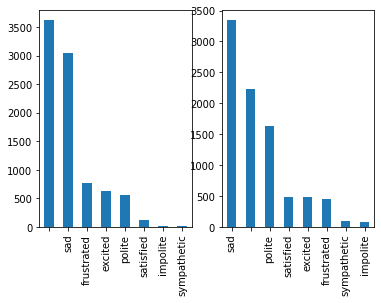


##############################################################
#####################    TensorFlow   ########################
##############################################################
When comment tones are accumulated by frequency and by confidence, there are 94 out of 19603 issues produced different results.
post_dominant_tone
comment_dominant_tone


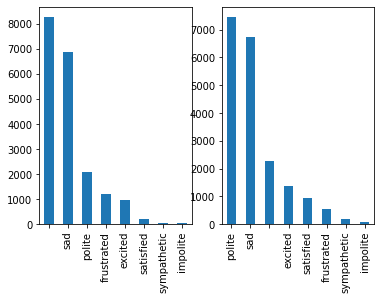


##############################################################
#######################    SkLearn    ########################
##############################################################
When comment tones are accumulated by frequency and by confidence, there are 23 out of 5701 issues produced different results.
post_dominant_tone
comment_dominant_tone


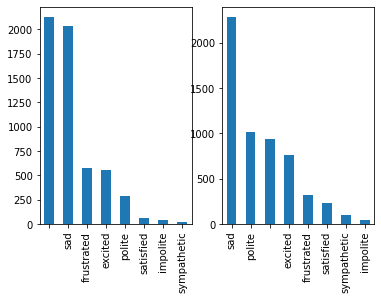

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt

def analyze_sentiment_aggregation_methods(df_analyze_posts):
    tone_aggregation_different =\
        df_analyze_posts.loc[df_analyze_posts['comment_dominant_tone_freq'] != df_analyze_posts['comment_dominant_tone_conf']]

    print('When comment tones are accumulated by frequency and by confidence, there are', tone_aggregation_different.shape[0], 'out of', df_analyze_posts.shape[0], 'issues produced different results.')
    
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1, 2) 
    print("post_dominant_tone")
    df_analyze_posts['post_dominant_tone_conf'].value_counts().plot(kind='bar', ax=ax[0])
    print("comment_dominant_tone")
    df_analyze_posts['comment_dominant_tone_freq'].value_counts().plot(kind='bar', ax=ax[1])
    plt.show()
            

print('\n##############################################################')
print('######################    PyTorch    #########################')
print('##############################################################')
analyze_sentiment_aggregation_methods(PyTorch_data['posts'])

print('\n##############################################################')
print('#####################    TensorFlow   ########################')
print('##############################################################')
analyze_sentiment_aggregation_methods(Tensorflow_data['posts'])


print('\n##############################################################')
print('#######################    SkLearn    ########################')
print('##############################################################')
analyze_sentiment_aggregation_methods(SkLearn_data['posts'])

tones_to_remove = ['impolite', 'sympathetic']
def remove_low_frequency_tones(df_analyze_posts):
    ret = df_analyze_posts
    for tone in tones_to_remove:
        ret = ret[ret['post_dominant_tone_conf'] != tone]
        ret = ret[ret['comment_dominant_tone_freq'] != tone]
        ret = ret[ret['comment_dominant_tone_conf'] != tone]
    return ret

In [71]:
def cramers_v(x, y, alpha=0.05):
    import scipy.stats as ss
    confusion_matrix = pd.crosstab(x,y)
    display(confusion_matrix)
    chi2, p, dof, ex = ss.chi2_contingency(confusion_matrix)
    if p <= alpha:
        printmd ('chi2 = ' + str(round(chi2, 3)) + '  <span style="color:red">p = ' + str(round(p, 5)) +
                 '</span>  dof = ' + str(dof))
    else:
        printmd ('chi2 = ' + str(round(chi2, 3)) + '  p = ' + str(round(p, 5)) + '  dof = ' + str(dof))
    
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    
    # Here is the formular without bias correction
    v = np.sqrt(phi2/min((k-1),(r-1)))
    
    # Here is the formular with bias correction (https://doi.org/10.1016%2Fj.jkss.2012.10.002)
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    v = np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))
    
    return v
# column name group_name column in df how many groups inthe column.
import scikit_posthocs as sp

def kruskal_with_post_hoc(df_analyze_posts, group_name, value_name, alpha=0.05):
    
    for name, group in df_analyze_posts.groupby(group_name):
        groups = [group[value_name].values for \
                           name, group in df_analyze_posts.groupby(group_name)] 
        num_groups = len(groups)
        if num_groups >= 2:
            import scipy.stats as ss
            stat, p = ss.kruskal(*groups)
            eta2 = (stat - num_groups + 1)/(len(df_analyze_posts) - num_groups)
              

            if p <= alpha:
                printmd ('H = ' + str(round(stat, 3)) + 
                         '  <span style="color:red">p = ' + str(round(p, 10))+ '</span>' +
                         '  eta2 = ' + str(round(eta2, 3)))
                
                posthoc = \
                    sp.posthoc_mannwhitney(df_analyze_posts, val_col=value_name, 
                                           group_col=group_name, p_adjust = 'holm')
                display(posthoc)
                display(df_analyze_posts.groupby(group_name).mean()[value_name])
            else:
                printmd ('H = ' + str(round(stat, 3)) + 
                         '  p = ' + str(round(p, 5)) +
                         '  eta2 = ' + str(round(eta2, 3)))
                        
            return p
        else: 
            p = 0
            return p 

# A good resource:
# https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365

print ('Define Cramer\'s V and Kruskal functions. Done!')
# print ('Interpretation of Cramer\'s V')
print ('  > 0.25 Very strong')
print ('  > 0.15 Strong')
print ('  > 0.10 Moderate')
print ('  > 0.05 Weak')
print ('  > 0.00 Very weak or no\n')
print ('Reference: Akoglu, Haldun. (2018). User\'s guide to correlation coefficients.')
print ('Turkish Journal of Emergency Medicine. 18. 10.1016/j.tjem.2018.08.001.')

Define Cramer's V and Kruskal functions. Done!
  > 0.25 Very strong
  > 0.15 Strong
  > 0.10 Moderate
  > 0.05 Weak
  > 0.00 Very weak or no

Reference: Akoglu, Haldun. (2018). User's guide to correlation coefficients.
Turkish Journal of Emergency Medicine. 18. 10.1016/j.tjem.2018.08.001.


**Overall correlation analysis**

In [72]:
def analyze_post_comment_relationship(df_analyze_posts):
    df_analyze_posts = remove_low_frequency_tones(df_analyze_posts)
    
    print('#### Post sentiment <-> Post tone')
    v = cramers_v(df_analyze_posts['Sentiment'], df_analyze_posts['post_dominant_tone_conf'])
    if v > 0.25: 
        printmd('<span style="color:red">cramers_v = ' + str( round(v, 3) )+ '</span>' )
    elif v > 0.15:
        printmd('<span style="color:blue">cramers_v  = ' + str (round(v, 3) )+ '</span>' )
    else:
        print('cramers_v =', round(v, 3))
    
    print('\n#### Comment sentiment <-> Comment tone')
    v = cramers_v(df_analyze_posts['comment_dominant_sentiment'], df_analyze_posts['comment_dominant_tone_freq'])
    if v > 0.25: 
        printmd('<span style="color:red">cramers_v = ' + str( round(v, 3) )+ '</span>' )
    elif v > 0.15:
        printmd('<span style="color:blue">cramers_v  = ' + str (round(v, 3) )+ '</span>' )
    else:
        print('cramers_v =', round(v, 3))
    
                                      
    printmd('#### Post sentiment <-> Comment sentiment')
    v = cramers_v(df_analyze_posts['Sentiment'], df_analyze_posts['comment_dominant_sentiment'])
    if v > 0.25: 
        printmd('<span style="color:red">cramers_v = ' + str( round(v, 3) )+ '</span>' )
    elif v > 0.15:
        printmd('<span style="color:blue">cramers_v  = ' + str (round(v, 3) )+ '</span>' )
    else:
        print('cramers_v =', round(v, 3))
    

    printmd('#### Post sentiment <-> Comment tone')
    v = cramers_v(df_analyze_posts['Sentiment'], df_analyze_posts['comment_dominant_tone_freq'])
    if v > 0.25: 
        printmd('<span style="color:red">cramers_v = ' + str( round(v, 3) )+ '</span>' )
    elif v > 0.15:
        printmd('<span style="color:blue">cramers_v  = ' + str (round(v, 3) )+ '</span>' )
    else:
        print('cramers_v =', round(v, 3))
    

    printmd('#### Post tone <-> Comment sentiment')
    v = cramers_v(df_analyze_posts['post_dominant_tone_conf'], df_analyze_posts['comment_dominant_sentiment'])
    if v > 0.25: 
        printmd('<span style="color:red">cramers_v = ' + str( round(v, 3) )+ '</span>' )
    elif v > 0.15:
        printmd('<span style="color:blue">cramers_v  = ' + str (round(v, 3) )+ '</span>' )
    else:
        print('cramers_v =', round(v, 3))
    

    printmd('#### Post tone <-> Comment tone')
    v = cramers_v(df_analyze_posts['post_dominant_tone_conf'], df_analyze_posts['comment_dominant_tone_freq'])
    if v > 0.25: 
        printmd('<span style="color:red">cramers_v = ' + str( round(v, 3) )+ '</span>' )
    elif v > 0.15:
        printmd('<span style="color:blue">cramers_v  = ' + str (round(v, 3) )+ '</span>' )
    else:
        print('cramers_v =', round(v, 3))
    
    
    print('======================')

    printmd('#### Post sentiment <-> Time to first comment')
    kruskal_with_post_hoc(df_analyze_posts, 'Sentiment', 'time_to_first_comment')

    printmd('#### Post tone <-> Time to first comment')
    kruskal_with_post_hoc(df_analyze_posts, 'post_dominant_tone_conf', 'time_to_first_comment')
    
    printmd('#### Comment sentiment <-> Time to first comment')
    kruskal_with_post_hoc(df_analyze_posts, 'comment_dominant_sentiment', 'time_to_first_comment')

    printmd('#### Comment tone <-> Time to first comment')
    kruskal_with_post_hoc(df_analyze_posts, 'comment_dominant_tone_freq', 'time_to_first_comment')
    
    print('======================')

    printmd('#### Post sentiment <-> Number of comments')
    kruskal_with_post_hoc(df_analyze_posts, 'Sentiment', 'NumberOfComments')

    printmd('#### Post tone <-> Number of comments')
    kruskal_with_post_hoc(df_analyze_posts, 'post_dominant_tone_conf', 'NumberOfComments')
    
    printmd('#### Comment sentiment <-> Number of comments')
    kruskal_with_post_hoc(df_analyze_posts, 'comment_dominant_sentiment', 'NumberOfComments')

    printmd('#### Comment tone <-> Number of comments')
    kruskal_with_post_hoc(df_analyze_posts, 'comment_dominant_tone_freq', 'NumberOfComments')

print('\n')
print('##############################################################')
print('##############################################################')
printmd('# PyTorch Results')
printmd('## All issues:')
PyTorch_posts_wcomments = PyTorch_data['posts'].loc[PyTorch_data['posts']['NumberOfComments'] > 0]
print("++++++++++++++++")
print(PyTorch_posts_wcomments)
print("++++++++++++++++")
analyze_post_comment_relationship(PyTorch_posts_wcomments)

print('\n')
print('##############################################################')
print('##############################################################')
printmd('# TensorFlow Results')
printmd('## All issues:')
Tensorflow_posts_wcomments = Tensorflow_data['posts'].loc[Tensorflow_data['posts']['NumberOfComments'] > 0]
analyze_post_comment_relationship(Tensorflow_posts_wcomments)

print('\n')
print('##############################################################')
print('##############################################################')
printmd('# SkLearn Results')
printmd('## All issues:')
SkLearn_posts_wcomments = SkLearn_data['posts'].loc[SkLearn_data['posts']['NumberOfComments'] > 0]
analyze_post_comment_relationship(SkLearn_posts_wcomments)

print('\n')
print('##############################################################')
print('##############################################################')
printmd('# All-together Results')
printmd('## All issues:')
All_posts_wcomments = All_posts.loc[All_posts['NumberOfComments'] > 0]
analyze_post_comment_relationship(All_posts_wcomments)



##############################################################
##############################################################


# PyTorch Results

## All issues:

++++++++++++++++
      ProjectName  IssueNumber              IssueLabel  PostNumber  \
39796     PyTorch        33660                       -           0   
39797     PyTorch        33659                       -           0   
39798     PyTorch        33655                       -           0   
39799     PyTorch        33654                       -           0   
39800     PyTorch        33637  module: build-triaged-           0   
...           ...          ...                     ...         ...   
48594     PyTorch            6                       -           0   
48595     PyTorch            5                       -           0   
48596     PyTorch            3                   todo-           0   
48597     PyTorch            2                       -           0   
48598     PyTorch            1                       -           0   

        PosterRole             PostTime           ClosedTime  \
39796  CONTRIBUTOR  2020-02-22 15:32:33  2020-02-22 20:58:03   
39797         

post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,192,14,178,46,985,8
neutral,2389,211,366,165,1278,27
positive,555,240,160,304,531,77


chi2 = 1733.444  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.334</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
comment_dominant_sentiment,,,,,,
negative,52,7,43,29,284,6
neutral,1097,291,329,878,2541,224
positive,207,181,81,718,505,253


chi2 = 895.085  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:blue">cramers_v  = 0.239</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
Sentiment,,,
negative,77,1005,341
neutral,265,3078,1093
positive,79,1277,511


chi2 = 12.812  <span style="color:red">p = 0.01223</span>  dof = 4

cramers_v = 0.024


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,229,82,92,297,627,96
neutral,817,278,252,925,1900,264
positive,310,119,109,403,803,123


chi2 = 8.547  p = 0.57557  dof = 10

cramers_v = 0.0


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
post_dominant_tone_conf,,,
,184,2164,788
excited,22,318,125
frustrated,34,491,179
polite,31,366,118
sad,144,1950,700
satisfied,6,71,35


chi2 = 6.964  p = 0.72884  dof = 10

cramers_v = 0.0


#### Post tone <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
post_dominant_tone_conf,,,,,,
,599,202,177,662,1306,190
excited,77,31,23,104,195,35
frustrated,123,39,48,143,307,44
polite,102,31,33,102,216,31
sad,438,166,165,588,1258,179
satisfied,17,10,7,26,48,4


chi2 = 25.267  p = 0.44751  dof = 25

cramers_v = 0.003


#### Post sentiment <-> Time to first comment

H = 4.746  p = 0.0932  eta2 = 0.0

#### Post tone <-> Time to first comment

H = 9.16  p = 0.10286  eta2 = 0.001

#### Comment sentiment <-> Time to first comment

H = 10.362  <span style="color:red">p = 0.0056223384</span>  eta2 = 0.001

,negative,neutral,positive
negative,-1.000000,0.021042,0.124229
neutral,0.021042,-1.000000,0.070187
positive,0.124229,0.070187,-1.000000


comment_dominant_sentiment
negative    1.355881e+06
neutral     8.864052e+05
positive    7.667230e+05
Name: time_to_first_comment, dtype: float64

#### Comment tone <-> Time to first comment

H = 24.679  <span style="color:red">p = 0.0001606861</span>  eta2 = 0.003

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.212495,1.0,0.212495,0.000041,1.000000
excited,0.212495,-1.000000,1.0,1.000000,1.000000,1.000000
frustrated,1.000000,1.000000,-1.0,1.000000,1.000000,1.000000
polite,0.212495,1.000000,1.0,-1.000000,0.378491,1.000000
sad,0.000041,1.000000,1.0,0.378491,-1.000000,0.378491
satisfied,1.000000,1.000000,1.0,1.000000,0.378491,-1.000000


comment_dominant_tone_freq
              1.600996e+06
excited       6.755394e+05
frustrated    7.017097e+05
polite        5.749855e+05
sad           7.626800e+05
satisfied     1.090579e+06
Name: time_to_first_comment, dtype: float64

#### Post sentiment <-> Number of comments

H = 23.965  <span style="color:red">p = 6.2536e-06</span>  eta2 = 0.003

,negative,neutral,positive
negative,-1.000000,0.000008,0.049874
neutral,0.000008,-1.000000,0.016842
positive,0.049874,0.016842,-1.000000


Sentiment
negative    5.063949
neutral     4.214833
positive    5.062667
Name: NumberOfComments, dtype: float64

#### Post tone <-> Number of comments

H = 56.122  <span style="color:red">p = 1e-10</span>  eta2 = 0.007

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,0.641434,0.007529,1.000000,2.552498e-11,1.0
excited,6.414339e-01,-1.000000,1.000000,1.000000,6.414339e-01,1.0
frustrated,7.529385e-03,1.000000,-1.000000,0.182621,1.000000e+00,1.0
polite,1.000000e+00,1.000000,0.182621,-1.000000,2.143164e-03,1.0
sad,2.552498e-11,0.641434,1.000000,0.002143,-1.000000e+00,1.0
satisfied,1.000000e+00,1.000000,1.000000,1.000000,1.000000e+00,-1.0


post_dominant_tone_conf
              4.350765
excited       4.389247
frustrated    4.617898
polite        4.264078
sad           4.901933
satisfied     4.705357
Name: NumberOfComments, dtype: float64

#### Comment sentiment <-> Number of comments

H = 334.426  <span style="color:red">p = 0.0</span>  eta2 = 0.043

,negative,neutral,positive
negative,-1.000000e+00,1.015450e-35,9.399621e-08
neutral,1.015450e-35,-1.000000e+00,3.592034e-49
positive,9.399621e-08,3.592034e-49,-1.000000e+00


comment_dominant_sentiment
negative    2.237530
neutral     5.321642
positive    3.027763
Name: NumberOfComments, dtype: float64

#### Comment tone <-> Number of comments

H = 1579.741  <span style="color:red">p = 0.0</span>  eta2 = 0.204

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,1.016717e-97,8.376989e-78,4.229936e-196,8.332347e-305,5.248751e-103
excited,1.016717e-97,-1.000000e+00,1.047322e-01,7.198866e-02,2.158572e-14,6.311360e-01
frustrated,8.376989e-78,1.047322e-01,-1.000000e+00,1.103146e-05,1.305707e-22,5.199243e-02
polite,4.229936e-196,7.198866e-02,1.103146e-05,-1.000000e+00,3.096815e-17,1.503077e-01
sad,8.332347e-305,2.158572e-14,1.305707e-22,3.096815e-17,-1.000000e+00,2.078610e-12
satisfied,5.248751e-103,6.311360e-01,5.199243e-02,1.503077e-01,2.078610e-12,-1.000000e+00


comment_dominant_tone_freq
              1.464602
excited       3.617954
frustrated    3.233996
polite        4.329846
sad           6.396396
satisfied     3.799172
Name: NumberOfComments, dtype: float64



##############################################################
##############################################################


# TensorFlow Results

## All issues:

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,335,56,249,165,2213,8
neutral,6312,321,496,530,2288,44
positive,1229,532,393,1223,2104,130


chi2 = 5530.263  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.385</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
comment_dominant_sentiment,,,,,,
negative,57,21,55,69,498,7
neutral,1216,547,343,2403,4587,301
positive,385,780,157,4951,1618,633


chi2 = 3431.917  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.303</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
Sentiment,,,
negative,110,1628,1288
neutral,353,4714,4924
positive,244,3055,2312


chi2 = 111.502  <span style="color:red">p = 0.0</span>  dof = 4

cramers_v = 0.054


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,283,200,90,1094,1209,150
neutral,840,771,279,4282,3292,527
positive,535,377,186,2047,2202,264


chi2 = 122.967  <span style="color:red">p = 0.0</span>  dof = 10

cramers_v = 0.055


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
post_dominant_tone_conf,,,
,287,3615,3974
excited,42,532,335
frustrated,51,611,476
polite,82,1013,823
sad,240,3534,2831
satisfied,5,92,85


chi2 = 139.615  <span style="color:red">p = 0.0</span>  dof = 10

cramers_v = 0.059


#### Post tone <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
post_dominant_tone_conf,,,,,,
,662,645,221,3376,2544,428
excited,93,64,21,322,375,34
frustrated,108,63,40,434,442,51
polite,200,121,78,688,725,106
sad,576,441,188,2539,2550,311
satisfied,19,14,7,64,67,11


chi2 = 139.32  <span style="color:red">p = 0.0</span>  dof = 25

cramers_v = 0.035


#### Post sentiment <-> Time to first comment

H = 51.79  <span style="color:red">p = 0.0</span>  eta2 = 0.003

,negative,neutral,positive
negative,-1.000000e+00,2.076872e-09,7.630891e-02
neutral,2.076872e-09,-1.000000e+00,2.019302e-07
positive,7.630891e-02,2.019302e-07,-1.000000e+00


Sentiment
negative    510267.492730
neutral     484805.729256
positive    546355.998574
Name: time_to_first_comment, dtype: float64

#### Post tone <-> Time to first comment

H = 94.821  <span style="color:red">p = 0.0</span>  eta2 = 0.005

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,0.153572,0.004009,1.380418e-07,1.122118e-18,1.0
excited,1.535719e-01,-1.000000,1.000000,1.000000e+00,6.382739e-01,1.0
frustrated,4.009210e-03,1.000000,-1.000000,1.000000e+00,1.000000e+00,1.0
polite,1.380418e-07,1.000000,1.000000,-1.000000e+00,1.000000e+00,1.0
sad,1.122118e-18,0.638274,1.000000,1.000000e+00,-1.000000e+00,1.0
satisfied,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000e+00,-1.0


post_dominant_tone_conf
              541077.788979
excited       599612.240924
frustrated    417623.786467
polite        520876.564129
sad           467038.800303
satisfied     481881.285714
Name: time_to_first_comment, dtype: float64

#### Comment sentiment <-> Time to first comment

H = 28.096  <span style="color:red">p = 7.927e-07</span>  eta2 = 0.001

,negative,neutral,positive
negative,-1.000000,4.101143e-02,6.906698e-01
neutral,0.041011,-1.000000e+00,9.746416e-07
positive,0.690670,9.746416e-07,-1.000000e+00


comment_dominant_sentiment
negative    647054.356436
neutral     508178.337661
positive    495136.991201
Name: time_to_first_comment, dtype: float64

#### Comment tone <-> Time to first comment

H = 28.558  <span style="color:red">p = 2.83112e-05</span>  eta2 = 0.001

,,excited,frustrated,polite,sad,satisfied
,-1.00000,1.000000,1.000000,1.000000,0.090290,1.000000
excited,1.00000,-1.000000,1.000000,1.000000,0.475772,1.000000
frustrated,1.00000,1.000000,-1.000000,1.000000,0.889897,1.000000
polite,1.00000,1.000000,1.000000,-1.000000,0.000011,1.000000
sad,0.09029,0.475772,0.889897,0.000011,-1.000000,0.073771
satisfied,1.00000,1.000000,1.000000,1.000000,0.073771,-1.000000


comment_dominant_tone_freq
              820708.366104
excited       599734.919139
frustrated    509052.576577
polite        432862.122053
sad           492986.343130
satisfied     514391.785335
Name: time_to_first_comment, dtype: float64

#### Post sentiment <-> Number of comments

H = 17.128  <span style="color:red">p = 0.0001908405</span>  eta2 = 0.001

,negative,neutral,positive
negative,-1.000000,0.000554,0.000298
neutral,0.000554,-1.000000,0.307062
positive,0.000298,0.307062,-1.000000


Sentiment
negative    6.468605
neutral     6.030527
positive    6.339512
Name: NumberOfComments, dtype: float64

#### Post tone <-> Number of comments

H = 44.733  <span style="color:red">p = 1.64e-08</span>  eta2 = 0.002

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.785828,0.740162,0.264619,0.000069,0.085431
excited,0.785828,-1.000000,0.510785,0.785828,0.021931,0.449734
frustrated,0.740162,0.510785,-1.000000,0.167895,0.785828,0.039454
polite,0.264619,0.785828,0.167895,-1.000000,0.000033,0.510785
sad,0.000069,0.021931,0.785828,0.000033,-1.000000,0.004020
satisfied,0.085431,0.449734,0.039454,0.510785,0.004020,-1.000000


post_dominant_tone_conf
              5.981971
excited       6.167217
frustrated    6.333919
polite        6.183003
sad           6.473732
satisfied     4.670330
Name: NumberOfComments, dtype: float64

#### Comment sentiment <-> Number of comments

H = 520.556  <span style="color:red">p = 0.0</span>  eta2 = 0.028

,negative,neutral,positive
negative,-1.000000e+00,1.029764e-93,4.532155e-72
neutral,1.029764e-93,-1.000000e+00,1.372502e-31
positive,4.532155e-72,1.372502e-31,-1.000000e+00


comment_dominant_sentiment
negative    2.749646
neutral     7.185698
positive    5.388081
Name: NumberOfComments, dtype: float64

#### Comment tone <-> Number of comments

H = 2951.924  <span style="color:red">p = 0.0</span>  eta2 = 0.158

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,2.249267e-221,1.019252e-87,0.000000e+00,0.000000e+00,3.295633e-153
excited,2.249267e-221,-1.000000e+00,2.854375e-08,3.795426e-35,2.226395e-42,3.820700e-03
frustrated,1.019252e-87,2.854375e-08,-1.000000e+00,2.726778e-45,3.101408e-47,3.820700e-03
polite,0.000000e+00,3.795426e-35,2.726778e-45,-1.000000e+00,8.203381e-05,4.949861e-43
sad,0.000000e+00,2.226395e-42,3.101408e-47,8.203381e-05,-1.000000e+00,2.586940e-48
satisfied,3.295633e-153,3.820700e-03,3.820700e-03,4.949861e-43,2.586940e-48,-1.000000e+00


comment_dominant_tone_freq
              1.666466
excited       4.609050
frustrated    3.607207
polite        6.576586
sad           7.729673
satisfied     4.025505
Name: NumberOfComments, dtype: float64



##############################################################
##############################################################


# SkLearn Results

## All issues:

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,0,2,125,2,522,0
neutral,1574,253,275,112,916,11
positive,375,261,138,163,479,44


chi2 = 1272.394  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.347</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
comment_dominant_sentiment,,,,,,
negative,17,7,30,16,144,0
neutral,524,443,219,637,1708,97
positive,143,308,66,352,407,134


chi2 = 401.767  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:blue">cramers_v  = 0.193</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
Sentiment,,,
negative,25,450,176
neutral,131,2157,853
positive,58,1021,381


chi2 = 0.853  p = 0.93122  dof = 4

cramers_v = 0.0


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,80,98,38,121,283,31
neutral,409,451,188,615,1334,144
positive,195,209,89,269,642,56


chi2 = 3.512  p = 0.9667  dof = 10

cramers_v = 0.0


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
post_dominant_tone_conf,,,
,88,1341,520
excited,12,373,131
frustrated,15,380,143
polite,12,183,82
sad,84,1315,518
satisfied,3,36,16


chi2 = 10.597  p = 0.38975  dof = 10

cramers_v = 0.008


#### Post tone <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
post_dominant_tone_conf,,,,,,
,270,304,122,355,812,86
excited,57,81,31,109,218,20
frustrated,54,72,39,103,238,32
polite,46,36,17,55,109,14
sad,253,258,100,377,854,75
satisfied,4,7,6,6,28,4


chi2 = 34.438  p = 0.09887  dof = 25

cramers_v = 0.019


#### Post sentiment <-> Time to first comment

H = 4.204  p = 0.12218  eta2 = 0.0

#### Post tone <-> Time to first comment

H = 15.287  <span style="color:red">p = 0.0092022614</span>  eta2 = 0.002

,,excited,frustrated,polite,sad,satisfied
,-1.000000,1.0,1.0,0.865131,0.002891,1.0
excited,1.000000,-1.0,1.0,1.000000,1.000000,1.0
frustrated,1.000000,1.0,-1.0,1.000000,1.000000,1.0
polite,0.865131,1.0,1.0,-1.000000,1.000000,1.0
sad,0.002891,1.0,1.0,1.000000,-1.000000,1.0
satisfied,1.000000,1.0,1.0,1.000000,1.000000,-1.0


post_dominant_tone_conf
              1.738072e+06
excited       1.415986e+06
frustrated    1.412593e+06
polite        6.067873e+05
sad           7.656295e+05
satisfied     1.415712e+05
Name: time_to_first_comment, dtype: float64

#### Comment sentiment <-> Time to first comment

H = 1.371  p = 0.50378  eta2 = -0.0

#### Comment tone <-> Time to first comment

H = 18.321  <span style="color:red">p = 0.0025695045</span>  eta2 = 0.003

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.194284,1.0,0.046541,0.000541,1.0
excited,0.194284,-1.000000,1.0,1.000000,1.000000,1.0
frustrated,1.000000,1.000000,-1.0,1.000000,1.000000,1.0
polite,0.046541,1.000000,1.0,-1.000000,1.000000,1.0
sad,0.000541,1.000000,1.0,1.000000,-1.000000,1.0
satisfied,1.000000,1.000000,1.0,1.000000,1.000000,-1.0


comment_dominant_tone_freq
              2.414243e+06
excited       1.444033e+06
frustrated    9.058576e+05
polite        8.947653e+05
sad           1.072555e+06
satisfied     7.285743e+05
Name: time_to_first_comment, dtype: float64

#### Post sentiment <-> Number of comments

H = 21.842  <span style="color:red">p = 1.80727e-05</span>  eta2 = 0.004

,negative,neutral,positive
negative,-1.000000,0.000009,0.001434
neutral,0.000009,-1.000000,0.191715
positive,0.001434,0.191715,-1.000000


Sentiment
negative    7.397849
neutral     6.282394
positive    6.801370
Name: NumberOfComments, dtype: float64

#### Post tone <-> Number of comments

H = 27.878  <span style="color:red">p = 3.84548e-05</span>  eta2 = 0.004

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.066477,0.015964,1.000000,0.000151,1.0
excited,0.066477,-1.000000,1.000000,0.330619,1.000000,1.0
frustrated,0.015964,1.000000,-1.000000,0.179684,1.000000,1.0
polite,1.000000,0.330619,0.179684,-1.000000,0.141883,1.0
sad,0.000151,1.000000,1.000000,0.141883,-1.000000,1.0
satisfied,1.000000,1.000000,1.000000,1.000000,1.000000,-1.0


post_dominant_tone_conf
              6.024115
excited       7.122093
frustrated    7.065056
polite        6.115523
sad           6.920709
satisfied     5.472727
Name: NumberOfComments, dtype: float64

#### Comment sentiment <-> Number of comments

H = 277.793  <span style="color:red">p = 0.0</span>  eta2 = 0.053

,negative,neutral,positive
negative,-1.000000e+00,1.473561e-27,4.582559e-07
neutral,1.473561e-27,-1.000000e+00,1.008051e-42
positive,4.582559e-07,1.008051e-42,-1.000000e+00


comment_dominant_sentiment
negative    3.028037
neutral     7.540794
positive    4.590780
Name: NumberOfComments, dtype: float64

#### Comment tone <-> Number of comments

H = 1119.271  <span style="color:red">p = 0.0</span>  eta2 = 0.212

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,1.436835e-113,1.064094e-63,1.078090e-151,2.591342e-206,8.566767e-55
excited,1.436835e-113,-1.000000e+00,9.361180e-03,8.700812e-04,5.810617e-17,6.697201e-02
frustrated,1.064094e-63,9.361180e-03,-1.000000e+00,9.781124e-09,7.078899e-20,6.263950e-01
polite,1.078090e-151,8.700812e-04,9.781124e-09,-1.000000e+00,4.875692e-07,5.658102e-06
sad,2.591342e-206,5.810617e-17,7.078899e-20,4.875692e-07,-1.000000e+00,1.031057e-13
satisfied,8.566767e-55,6.697201e-02,6.263950e-01,5.658102e-06,1.031057e-13,-1.000000e+00


comment_dominant_tone_freq
              1.709064
excited       5.898417
frustrated    4.444444
polite        6.649751
sad           8.717574
satisfied     4.601732
Name: NumberOfComments, dtype: float64



##############################################################
##############################################################


# All-together Results

## All issues:

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,527,72,552,213,3720,16
neutral,10275,785,1137,807,4482,82
positive,2159,1033,691,1690,3114,251


chi2 = 8276.217  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.362</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
comment_dominant_sentiment,,,,,,
negative,126,35,128,114,926,13
neutral,2837,1281,891,3918,8836,622
positive,735,1269,304,6021,2530,1020


chi2 = 5169.248  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.286</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
Sentiment,,,
negative,212,3083,1805
neutral,749,9949,6870
positive,381,5353,3204


chi2 = 40.884  <span style="color:red">p = 0.0</span>  dof = 4

cramers_v = 0.024


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,592,380,220,1512,2119,277
neutral,2066,1500,719,5822,6526,935
positive,1040,705,384,2719,3647,443


chi2 = 64.006  <span style="color:red">p = 0.0</span>  dof = 10

cramers_v = 0.029


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
post_dominant_tone_conf,,,
,559,7120,5282
excited,76,1223,591
frustrated,100,1482,798
polite,125,1562,1023
sad,468,6799,4049
satisfied,14,199,136


chi2 = 128.103  <span style="color:red">p = 0.0</span>  dof = 10

cramers_v = 0.043


#### Post tone <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
post_dominant_tone_conf,,,,,,
,1531,1151,520,4393,4662,704
excited,227,176,75,535,788,89
frustrated,285,174,127,680,987,127
polite,348,188,128,845,1050,151
sad,1267,865,453,3504,4662,565
satisfied,40,31,20,96,143,19


chi2 = 135.466  <span style="color:red">p = 0.0</span>  dof = 25

cramers_v = 0.026


#### Post sentiment <-> Time to first comment

H = 29.071  <span style="color:red">p = 4.868e-07</span>  eta2 = 0.001

,negative,neutral,positive
negative,-1.000000,0.000007,0.117194
neutral,0.000007,-1.000000,0.000295
positive,0.117194,0.000295,-1.000000


Sentiment
negative    565652.271765
neutral     747822.100979
positive    756963.587268
Name: time_to_first_comment, dtype: float64

#### Post tone <-> Time to first comment

H = 105.001  <span style="color:red">p = 0.0</span>  eta2 = 0.003

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,0.002202,0.000005,0.000732,4.480980e-21,0.186369
excited,2.201633e-03,-1.000000,1.000000,1.000000,1.000000e+00,1.000000
frustrated,4.618024e-06,1.000000,-1.000000,1.000000,1.000000e+00,1.000000
polite,7.320813e-04,1.000000,1.000000,-1.000000,3.065452e-01,1.000000
sad,4.480980e-21,1.000000,1.000000,0.306545,-1.000000e+00,1.000000
satisfied,1.863689e-01,1.000000,1.000000,1.000000,1.000000e+00,-1.000000


post_dominant_tone_conf
              8.236973e+05
excited       1.032492e+06
frustrated    8.634145e+05
polite        5.970072e+05
sad           5.634155e+05
satisfied     3.224321e+05
Name: time_to_first_comment, dtype: float64

#### Comment sentiment <-> Time to first comment

H = 138.58  <span style="color:red">p = 0.0</span>  eta2 = 0.004

,negative,neutral,positive
negative,-1.000000,3.504175e-04,3.205622e-01
neutral,0.000350,-1.000000e+00,9.337356e-31
positive,0.320562,9.337356e-31,-1.000000e+00


comment_dominant_sentiment
negative    882439.843517
neutral     767351.218711
positive    631056.433454
Name: time_to_first_comment, dtype: float64

#### Comment tone <-> Time to first comment

H = 132.042  <span style="color:red">p = 0.0</span>  eta2 = 0.004

,,excited,frustrated,polite,sad,satisfied
,-1.000000,1.299357e-01,0.197767,3.564168e-02,8.447054e-05,1.000000
excited,0.129936,-1.000000e+00,1.000000,4.786451e-07,1.000000e+00,0.088882
frustrated,0.197767,1.000000e+00,-1.000000,9.350183e-05,1.000000e+00,0.129936
polite,0.035642,4.786451e-07,0.000094,-1.000000e+00,2.508946e-27,0.909572
sad,0.000084,1.000000e+00,1.000000,2.508946e-27,-1.000000e+00,0.000533
satisfied,1.000000,8.888153e-02,0.129936,9.095717e-01,5.325392e-04,-1.000000


comment_dominant_tone_freq
              1.401576e+06
excited       8.613550e+05
frustrated    6.694965e+05
polite        5.020119e+05
sad           6.725604e+05
satisfied     7.124427e+05
Name: time_to_first_comment, dtype: float64

#### Post sentiment <-> Number of comments

H = 38.42  <span style="color:red">p = 4.5e-09</span>  eta2 = 0.001

,negative,neutral,positive
negative,-1.000000e+00,1.432903e-09,0.000207
neutral,1.432903e-09,-1.000000e+00,0.030530
positive,2.072541e-04,3.053038e-02,-1.000000


Sentiment
negative    6.195294
neutral     5.617088
positive    6.148243
Name: NumberOfComments, dtype: float64

#### Post tone <-> Number of comments

H = 91.733  <span style="color:red">p = 0.0</span>  eta2 = 0.003

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,0.628074,0.029035,6.280739e-01,3.167428e-16,0.250105
excited,6.280739e-01,-1.000000,0.628074,5.303236e-01,2.860523e-02,0.119767
frustrated,2.903542e-02,0.628074,-1.000000,3.875622e-02,4.265450e-01,0.024171
polite,6.280739e-01,0.530324,0.038756,-1.000000e+00,1.676682e-07,0.530324
sad,3.167428e-16,0.028605,0.426545,1.676682e-07,-1.000000e+00,0.000583
satisfied,2.501053e-01,0.119767,0.024171,5.303236e-01,5.828597e-04,-1.000000


post_dominant_tone_conf
              5.593627
excited       5.990476
frustrated    5.991597
polite        5.811439
sad           6.161364
satisfied     4.808023
Name: NumberOfComments, dtype: float64

#### Comment sentiment <-> Number of comments

H = 900.549  <span style="color:red">p = 0.0</span>  eta2 = 0.028

,negative,neutral,positive
negative,-1.000000e+00,6.570723e-154,7.809672e-102
neutral,6.570723e-154,-1.000000e+00,6.800844e-64
positive,7.809672e-102,6.800844e-64,-1.000000e+00


comment_dominant_sentiment
negative    2.633383
neutral     6.712320
positive    4.906979
Name: NumberOfComments, dtype: float64

#### Comment tone <-> Number of comments

H = 5807.5  <span style="color:red">p = 0.0</span>  eta2 = 0.184

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,0.000000e+00,3.951932e-228,0.000000e+00,0.000000e+00,0.000000e+00
excited,0.000000e+00,-1.000000e+00,1.313149e-14,3.437036e-35,1.457808e-58,1.620453e-05
frustrated,3.951932e-228,1.313149e-14,-1.000000e+00,3.060728e-72,9.163552e-89,4.502508e-04
polite,0.000000e+00,3.437036e-35,3.060728e-72,-1.000000e+00,7.928199e-13,5.695134e-54
sad,0.000000e+00,1.457808e-58,9.163552e-89,7.928199e-13,-1.000000e+00,1.044011e-73
satisfied,0.000000e+00,1.620453e-05,4.502508e-04,5.695134e-54,1.044011e-73,-1.000000e+00


comment_dominant_tone_freq
              1.600324
excited       4.803482
frustrated    3.678760
polite        6.220730
sad           7.550033
satisfied     4.039879
Name: NumberOfComments, dtype: float64

**Emotion <-> time to commit**



##############################################################
##############################################################


# PyTorch Results

## All issues:

#### Post sentiment <-> Time to first commit

H = 1.12  p = 0.57129  eta2 = -0.0

#### Post tone <-> Time to first commit

H = 22.664  <span style="color:red">p = 0.0003912434</span>  eta2 = 0.009

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.001383,1.000000,0.109834,1.000000,1.0
excited,0.001383,-1.000000,0.007727,1.000000,0.005276,1.0
frustrated,1.000000,0.007727,-1.000000,0.227186,1.000000,1.0
polite,0.109834,1.000000,0.227186,-1.000000,0.161969,1.0
sad,1.000000,0.005276,1.000000,0.161969,-1.000000,1.0
satisfied,1.000000,1.000000,1.000000,1.000000,1.000000,-1.0


post_dominant_tone_conf
              1.385327e+07
excited       1.313748e+07
frustrated    1.239747e+07
polite        2.260561e+07
sad           1.405051e+07
satisfied     1.618576e+07
Name: time_to_first_commit, dtype: float64

#### Comment sentiment <-> Time to first commit

H = 16.995  <span style="color:red">p = 0.0002040171</span>  eta2 = 0.008

,negative,neutral,positive
negative,-1.000000,0.298098,0.020055
neutral,0.298098,-1.000000,0.000293
positive,0.020055,0.000293,-1.000000


comment_dominant_sentiment
negative    1.948787e+07
neutral     1.450298e+07
positive    1.113132e+07
Name: time_to_first_commit, dtype: float64

#### Comment tone <-> Time to first commit

H = 35.8  <span style="color:red">p = 1.0417e-06</span>  eta2 = 0.016

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,0.306738,1.0,1.000000,8.256709e-07,1.000000
excited,3.067381e-01,-1.000000,1.0,0.624160,1.000000e+00,1.000000
frustrated,1.000000e+00,1.000000,-1.0,1.000000,1.000000e+00,1.000000
polite,1.000000e+00,0.624160,1.0,-1.000000,5.313797e-04,1.000000
sad,8.256709e-07,1.000000,1.0,0.000531,-1.000000e+00,0.499457
satisfied,1.000000e+00,1.000000,1.0,1.000000,4.994572e-01,-1.000000


comment_dominant_tone_freq
              1.205726e+07
excited       1.774630e+07
frustrated    1.476378e+07
polite        1.168866e+07
sad           1.669654e+07
satisfied     1.285091e+07
Name: time_to_first_commit, dtype: float64

#### Post sentiment <-> Time to last commit

H = 0.879  p = 0.6445  eta2 = -0.001

#### Post tone <-> Time to last commit

H = 20.399  <span style="color:red">p = 0.0010515183</span>  eta2 = 0.008

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.003883,1.000000,0.162306,1.000000,1.0
excited,0.003883,-1.000000,0.067505,1.000000,0.005333,1.0
frustrated,1.000000,0.067505,-1.000000,0.495932,1.000000,1.0
polite,0.162306,1.000000,0.495932,-1.000000,0.168229,1.0
sad,1.000000,0.005333,1.000000,0.168229,-1.000000,1.0
satisfied,1.000000,1.000000,1.000000,1.000000,1.000000,-1.0


post_dominant_tone_conf
              1.591657e+07
excited       1.483717e+07
frustrated    1.446187e+07
polite        2.470343e+07
sad           1.548390e+07
satisfied     1.732706e+07
Name: time_to_last_commit, dtype: float64

#### Comment sentiment <-> Time to last commit

H = 19.888  <span style="color:red">p = 4.80213e-05</span>  eta2 = 0.009

,negative,neutral,positive
negative,-1.000000,0.313883,0.019296
neutral,0.313883,-1.000000,0.000059
positive,0.019296,0.000059,-1.000000


comment_dominant_sentiment
negative    2.261934e+07
neutral     1.638488e+07
positive    1.241045e+07
Name: time_to_last_commit, dtype: float64

#### Comment tone <-> Time to last commit

H = 28.545  <span style="color:red">p = 2.84765e-05</span>  eta2 = 0.012

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.253210,0.915138,1.000000,0.000070,1.000000
excited,0.253210,-1.000000,1.000000,0.317384,1.000000,0.912328
frustrated,0.915138,1.000000,-1.000000,1.000000,1.000000,1.000000
polite,1.000000,0.317384,1.000000,-1.000000,0.002433,1.000000
sad,0.000070,1.000000,1.000000,0.002433,-1.000000,0.413039
satisfied,1.000000,0.912328,1.000000,1.000000,0.413039,-1.000000


comment_dominant_tone_freq
              1.405753e+07
excited       2.041237e+07
frustrated    1.968027e+07
polite        1.330439e+07
sad           1.798110e+07
satisfied     1.403382e+07
Name: time_to_last_commit, dtype: float64



##############################################################
##############################################################


# TensorFlow Results

## All issues:

#### Post sentiment <-> Time to first commit

H = 7.683  <span style="color:red">p = 0.0214590223</span>  eta2 = 0.006

,negative,neutral,positive
negative,-1.000000,0.123882,0.027609
neutral,0.123882,-1.000000,0.112279
positive,0.027609,0.112279,-1.000000


Sentiment
negative    3.237932e+06
neutral     3.074722e+06
positive    3.384362e+06
Name: time_to_first_commit, dtype: float64

#### Post tone <-> Time to first commit

H = 3.319  p = 0.65091  eta2 = -0.002

#### Comment sentiment <-> Time to first commit

H = 1.242  p = 0.53747  eta2 = -0.001

#### Comment tone <-> Time to first commit

H = 30.602  <span style="color:red">p = 1.12222e-05</span>  eta2 = 0.027

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.825912,1.0,0.000003,0.000107,1.000000
excited,0.825912,-1.000000,1.0,0.529090,1.000000,1.000000
frustrated,1.000000,1.000000,-1.0,1.000000,1.000000,1.000000
polite,0.000003,0.529090,1.0,-1.000000,1.000000,0.574512
sad,0.000107,1.000000,1.0,1.000000,-1.000000,1.000000
satisfied,1.000000,1.000000,1.0,0.574512,1.000000,-1.000000


comment_dominant_tone_freq
              1.487402e+06
excited       3.612118e+06
frustrated    1.803724e+06
polite        3.878552e+06
sad           3.146741e+06
satisfied     2.845537e+06
Name: time_to_first_commit, dtype: float64

#### Post sentiment <-> Time to last commit

H = 6.996  <span style="color:red">p = 0.0302558441</span>  eta2 = 0.005

,negative,neutral,positive
negative,-1.000000,0.141667,0.037239
neutral,0.141667,-1.000000,0.140516
positive,0.037239,0.140516,-1.000000


Sentiment
negative    3.544589e+06
neutral     3.392169e+06
positive    3.603812e+06
Name: time_to_last_commit, dtype: float64

#### Post tone <-> Time to last commit

H = 2.529  p = 0.77207  eta2 = -0.003

#### Comment sentiment <-> Time to last commit

H = 0.959  p = 0.61904  eta2 = -0.001

#### Comment tone <-> Time to last commit

H = 33.498  <span style="color:red">p = 2.9973e-06</span>  eta2 = 0.031

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,0.673817,0.317456,4.096211e-07,0.000039,1.000000
excited,6.738166e-01,-1.000000,1.000000,3.261415e-01,1.000000,1.000000
frustrated,3.174561e-01,1.000000,-1.000000,1.000000e+00,1.000000,1.000000
polite,4.096211e-07,0.326142,1.000000,-1.000000e+00,1.000000,0.526636
sad,3.891120e-05,1.000000,1.000000,1.000000e+00,-1.000000,1.000000
satisfied,1.000000e+00,1.000000,1.000000,5.266356e-01,1.000000,-1.000000


comment_dominant_tone_freq
              1.897910e+06
excited       3.796597e+06
frustrated    2.078939e+06
polite        4.183772e+06
sad           3.433882e+06
satisfied     2.958944e+06
Name: time_to_last_commit, dtype: float64



##############################################################
##############################################################


# SkLearn Results

## All issues:

#### Post sentiment <-> Time to first commit

H = 16.928  <span style="color:red">p = 0.0002109231</span>  eta2 = 0.029

,negative,neutral,positive
negative,-1.000000,0.947238,0.003738
neutral,0.947238,-1.000000,0.000198
positive,0.003738,0.000198,-1.000000


Sentiment
negative    4.096672e+06
neutral     6.047864e+06
positive    1.164117e+07
Name: time_to_first_commit, dtype: float64

#### Post tone <-> Time to first commit

H = 4.301  p = 0.50696  eta2 = -0.001

#### Comment sentiment <-> Time to first commit

H = 0.561  p = 0.75538  eta2 = -0.003

#### Comment tone <-> Time to first commit

H = 17.686  <span style="color:red">p = 0.0033661128</span>  eta2 = 0.025

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.222874,0.95483,0.001699,0.005614,0.838104
excited,0.222874,-1.000000,1.00000,1.000000,1.000000,1.000000
frustrated,0.954830,1.000000,-1.00000,1.000000,1.000000,1.000000
polite,0.001699,1.000000,1.00000,-1.000000,1.000000,1.000000
sad,0.005614,1.000000,1.00000,1.000000,-1.000000,1.000000
satisfied,0.838104,1.000000,1.00000,1.000000,1.000000,-1.000000


comment_dominant_tone_freq
              5.162665e+06
excited       7.259990e+06
frustrated    8.429940e+06
polite        9.970732e+06
sad           6.017922e+06
satisfied     6.314129e+06
Name: time_to_first_commit, dtype: float64

#### Post sentiment <-> Time to last commit

H = 16.226  <span style="color:red">p = 0.000299642</span>  eta2 = 0.027

,negative,neutral,positive
negative,-1.000000,0.762499,0.003151
neutral,0.762499,-1.000000,0.000334
positive,0.003151,0.000334,-1.000000


Sentiment
negative    4.466147e+06
neutral     7.729256e+06
positive    1.230229e+07
Name: time_to_last_commit, dtype: float64

#### Post tone <-> Time to last commit

H = 4.585  p = 0.46855  eta2 = -0.001

#### Comment sentiment <-> Time to last commit

H = 0.699  p = 0.70505  eta2 = -0.003

#### Comment tone <-> Time to last commit

H = 17.765  <span style="color:red">p = 0.0032560542</span>  eta2 = 0.025

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.121472,1.0,0.002696,0.002175,0.544576
excited,0.121472,-1.000000,1.0,1.000000,1.000000,1.000000
frustrated,1.000000,1.000000,-1.0,1.000000,1.000000,1.000000
polite,0.002696,1.000000,1.0,-1.000000,1.000000,1.000000
sad,0.002175,1.000000,1.0,1.000000,-1.000000,1.000000
satisfied,0.544576,1.000000,1.0,1.000000,1.000000,-1.000000


comment_dominant_tone_freq
              7.466731e+06
excited       7.879788e+06
frustrated    1.200073e+07
polite        1.000111e+07
sad           7.581229e+06
satisfied     6.913454e+06
Name: time_to_last_commit, dtype: float64



##############################################################
##############################################################


# All-together Results

## All issues:

#### Post sentiment <-> Time to first commit

H = 6.772  <span style="color:red">p = 0.0338516361</span>  eta2 = 0.001

,negative,neutral,positive
negative,-1.000000,0.175329,0.030983
neutral,0.175329,-1.000000,0.175329
positive,0.030983,0.175329,-1.000000


Sentiment
negative    9.795689e+06
neutral     9.858338e+06
positive    1.014855e+07
Name: time_to_first_commit, dtype: float64

#### Post tone <-> Time to first commit

H = 33.452  <span style="color:red">p = 3.0607e-06</span>  eta2 = 0.008

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.000002,1.00000,0.578119,1.000000,1.000000
excited,0.000002,-1.000000,0.00116,1.000000,0.000002,0.809159
frustrated,1.000000,0.001160,-1.00000,1.000000,1.000000,1.000000
polite,0.578119,1.000000,1.00000,-1.000000,0.578119,1.000000
sad,1.000000,0.000002,1.00000,0.578119,-1.000000,1.000000
satisfied,1.000000,0.809159,1.00000,1.000000,1.000000,-1.000000


post_dominant_tone_conf
              9.664988e+06
excited       1.117092e+07
frustrated    9.485821e+06
polite        1.279667e+07
sad           9.694034e+06
satisfied     8.585637e+06
Name: time_to_first_commit, dtype: float64

#### Comment sentiment <-> Time to first commit

H = 18.916  <span style="color:red">p = 7.80559e-05</span>  eta2 = 0.005

,negative,neutral,positive
negative,-1.000000,0.581263,0.055681
neutral,0.581263,-1.000000,0.000069
positive,0.055681,0.000069,-1.000000


comment_dominant_sentiment
negative    1.321435e+07
neutral     1.078051e+07
positive    6.969305e+06
Name: time_to_first_commit, dtype: float64

#### Comment tone <-> Time to first commit

H = 27.566  <span style="color:red">p = 4.42435e-05</span>  eta2 = 0.007

,,excited,frustrated,polite,sad,satisfied
,-1.000000,1.000000,0.935303,0.250207,0.000016,1.000000
excited,1.000000,-1.000000,1.000000,1.000000,0.325326,1.000000
frustrated,0.935303,1.000000,-1.000000,1.000000,1.000000,1.000000
polite,0.250207,1.000000,1.000000,-1.000000,0.071659,1.000000
sad,0.000016,0.325326,1.000000,0.071659,-1.000000,0.465432
satisfied,1.000000,1.000000,1.000000,1.000000,0.465432,-1.000000


comment_dominant_tone_freq
              9.954859e+06
excited       1.033736e+07
frustrated    1.091610e+07
polite        8.119496e+06
sad           1.085250e+07
satisfied     9.140053e+06
Name: time_to_first_commit, dtype: float64

#### Post sentiment <-> Time to last commit

H = 7.585  <span style="color:red">p = 0.0225381133</span>  eta2 = 0.002

,negative,neutral,positive
negative,-1.000000,0.122311,0.022030
neutral,0.122311,-1.000000,0.113073
positive,0.022030,0.113073,-1.000000


Sentiment
negative    1.130322e+07
neutral     1.119356e+07
positive    1.126626e+07
Name: time_to_last_commit, dtype: float64

#### Post tone <-> Time to last commit

H = 34.855  <span style="color:red">p = 1.6084e-06</span>  eta2 = 0.009

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.000001,0.880826,0.880826,1.000000,1.000000
excited,0.000001,-1.000000,0.005717,0.762179,0.000001,0.664954
frustrated,0.880826,0.005717,-1.000000,1.000000,0.805462,1.000000
polite,0.880826,0.762179,1.000000,-1.000000,0.880826,1.000000
sad,1.000000,0.000001,0.805462,0.880826,-1.000000,1.000000
satisfied,1.000000,0.664954,1.000000,1.000000,1.000000,-1.000000


post_dominant_tone_conf
              1.123650e+07
excited       1.251073e+07
frustrated    1.098115e+07
polite        1.384872e+07
sad           1.068357e+07
satisfied     9.204723e+06
Name: time_to_last_commit, dtype: float64

#### Comment sentiment <-> Time to last commit

H = 26.12  <span style="color:red">p = 2.1288e-06</span>  eta2 = 0.007

,negative,neutral,positive
negative,-1.000000,0.599467,0.030068
neutral,0.599467,-1.000000,0.000002
positive,0.030068,0.000002,-1.000000


comment_dominant_sentiment
negative    1.516287e+07
neutral     1.224379e+07
positive    7.782221e+06
Name: time_to_last_commit, dtype: float64

#### Comment tone <-> Time to last commit

H = 21.237  <span style="color:red">p = 0.0007307453</span>  eta2 = 0.005

,,excited,frustrated,polite,sad,satisfied
,-1.000000,1.000000,0.965563,1.000000,0.000652,1.0000
excited,1.000000,-1.000000,1.000000,1.000000,0.640273,1.0000
frustrated,0.965563,1.000000,-1.000000,1.000000,1.000000,1.0000
polite,1.000000,1.000000,1.000000,-1.000000,0.055289,1.0000
sad,0.000652,0.640273,1.000000,0.055289,-1.000000,0.6167
satisfied,1.000000,1.000000,1.000000,1.000000,0.616700,-1.0000


comment_dominant_tone_freq
              1.177868e+07
excited       1.164039e+07
frustrated    1.459560e+07
polite        8.986801e+06
sad           1.190311e+07
satisfied     9.942649e+06
Name: time_to_last_commit, dtype: float64

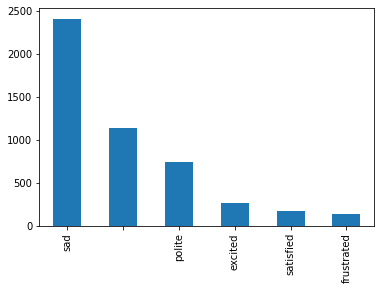

In [73]:
def analyze_emotion_commit_relationship(df_analyze_posts):
    df_analyze_posts = remove_low_frequency_tones(df_analyze_posts)
    
    df_analyze_posts['Sentiment'].value_counts().plot(kind='bar')
    df_analyze_posts['comment_dominant_sentiment'].value_counts().plot(kind='bar')
    df_analyze_posts['post_dominant_tone_conf'].value_counts().plot(kind='bar')
    df_analyze_posts['comment_dominant_tone_freq'].value_counts().plot(kind='bar')

    printmd('#### Post sentiment <-> Time to first commit')
    kruskal_with_post_hoc(df_analyze_posts, 'Sentiment', 'time_to_first_commit')

    printmd('#### Post tone <-> Time to first commit')
    kruskal_with_post_hoc(df_analyze_posts, 'post_dominant_tone_conf', 'time_to_first_commit')
    
    printmd('#### Comment sentiment <-> Time to first commit')
    kruskal_with_post_hoc(df_analyze_posts, 'comment_dominant_sentiment', 'time_to_first_commit')

    printmd('#### Comment tone <-> Time to first commit')
    kruskal_with_post_hoc(df_analyze_posts, 'comment_dominant_tone_freq', 'time_to_first_commit')
    
    print('======================')

    printmd('#### Post sentiment <-> Time to last commit')
    kruskal_with_post_hoc(df_analyze_posts, 'Sentiment', 'time_to_last_commit')

    printmd('#### Post tone <-> Time to last commit')
    kruskal_with_post_hoc(df_analyze_posts, 'post_dominant_tone_conf', 'time_to_last_commit')
    
    printmd('#### Comment sentiment <-> Time to last commit')
    kruskal_with_post_hoc(df_analyze_posts, 'comment_dominant_sentiment', 'time_to_last_commit')

    printmd('#### Comment tone <-> Time to last commit')
    kruskal_with_post_hoc(df_analyze_posts, 'comment_dominant_tone_freq', 'time_to_last_commit')

print('\n')
print('##############################################################')
print('##############################################################')
printmd('# PyTorch Results')
printmd('## All issues:')
PyTorch_posts_wcommits = PyTorch_data['posts'].loc[PyTorch_data['posts']['total_commit_size'] > 0]
analyze_emotion_commit_relationship(PyTorch_posts_wcommits)

print('\n')
print('##############################################################')
print('##############################################################')
printmd('# TensorFlow Results')
printmd('## All issues:')
Tensorflow_posts_wcommits = Tensorflow_data['posts'].loc[Tensorflow_data['posts']['total_commit_size'] > 0]
analyze_emotion_commit_relationship(Tensorflow_posts_wcommits)

print('\n')
print('##############################################################')
print('##############################################################')
printmd('# SkLearn Results')
printmd('## All issues:')
SkLearn_posts_wcommits = SkLearn_data['posts'].loc[SkLearn_data['posts']['total_commit_size'] > 0]
analyze_emotion_commit_relationship(SkLearn_posts_wcommits)

print('\n')
print('##############################################################')
print('##############################################################')
printmd('# All-together Results')
printmd('## All issues:')
All_posts_wcommits = All_posts.loc[All_posts['total_commit_size'] > 0]
analyze_emotion_commit_relationship(All_posts_wcommits)

**Separate by issue length**


##############################################################
######################    PyTorch    #########################
##############################################################
NumberOfComments==0 count: 859
NumberOfComments==1 count: 2217
NumberOfComments==2 count: 1609

NumberOfComments>0 descriptive stats:
count    7944.000000
mean        4.537764
std        10.384565
min         1.000000
25%         1.000000
50%         3.000000
75%         5.000000
max       763.000000
Name: NumberOfComments, dtype: float64

NumberOfComments>0 percentiles:
0.100     1.0
0.250     1.0
0.500     3.0
0.750     5.0
0.800     6.0
0.900    10.0
0.950    14.0
0.990    26.0
0.995    35.0
Name: NumberOfComments, dtype: float64
NumberOfComments == [ 1 , 3.0 )  count: 3826
NumberOfComments == [ 3.0 , 26.0 )  count: 4026
NumberOfComments == [ 26.0 , 764.0 )  count: 92


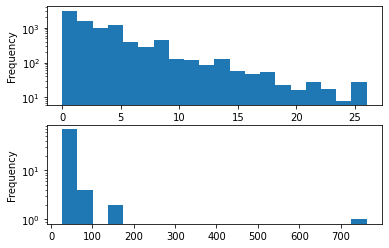


##############################################################
#####################    TensorFlow   ########################
##############################################################
NumberOfComments==0 count: 620
NumberOfComments==1 count: 2862
NumberOfComments==2 count: 2921

NumberOfComments>0 descriptive stats:
count    18983.000000
mean         6.155244
std          7.665848
min          1.000000
25%          2.000000
50%          4.000000
75%          7.000000
max        177.000000
Name: NumberOfComments, dtype: float64

NumberOfComments>0 percentiles:
0.100     1.0
0.250     2.0
0.500     4.0
0.750     7.0
0.800     9.0
0.900    13.0
0.950    18.0
0.990    35.0
0.995    46.0
Name: NumberOfComments, dtype: float64
NumberOfComments == [ 1 , 4.0 )  count: 8346
NumberOfComments == [ 4.0 , 35.0 )  count: 10433
NumberOfComments == [ 35.0 , 178.0 )  count: 204


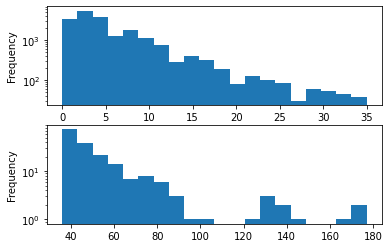


##############################################################
#######################    SkLearn    ########################
##############################################################
NumberOfComments==0 count: 245
NumberOfComments==1 count: 894
NumberOfComments==2 count: 853

NumberOfComments>0 descriptive stats:
count    5456.000000
mean        6.488636
std         7.603647
min         1.000000
25%         2.000000
50%         4.000000
75%         8.000000
max       106.000000
Name: NumberOfComments, dtype: float64

NumberOfComments>0 percentiles:
0.100     1.0
0.250     2.0
0.500     4.0
0.750     8.0
0.800    10.0
0.900    14.0
0.950    20.0
0.990    35.0
0.995    47.0
Name: NumberOfComments, dtype: float64
NumberOfComments == [ 1 , 4.0 )  count: 2388
NumberOfComments == [ 4.0 , 35.0 )  count: 3009
NumberOfComments == [ 35.0 , 107.0 )  count: 59


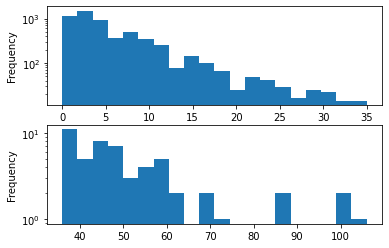


##############################################################
########################     ALL     #########################
##############################################################
NumberOfComments==0 count: 1724
NumberOfComments==1 count: 5973
NumberOfComments==2 count: 5383

NumberOfComments>0 descriptive stats:
count    32383.000000
mean         5.814625
std          8.437032
min          1.000000
25%          2.000000
50%          4.000000
75%          7.000000
max        763.000000
Name: NumberOfComments, dtype: float64

NumberOfComments>0 percentiles:
0.100     1.0
0.250     2.0
0.500     4.0
0.750     7.0
0.800     8.0
0.900    12.0
0.950    17.0
0.990    34.0
0.995    44.0
Name: NumberOfComments, dtype: float64
NumberOfComments == [ 1 , 4.0 )  count: 15564
NumberOfComments == [ 4.0 , 34.0 )  count: 16487
NumberOfComments == [ 34.0 , 764.0 )  count: 332


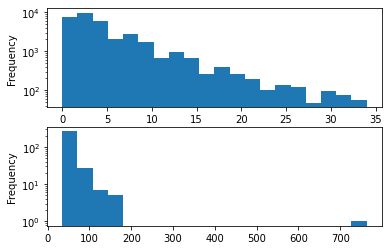

In [74]:
def analyze_issue_length(df_analyze_posts):
    print('NumberOfComments==0 count:',\
          df_analyze_posts['NumberOfComments'][df_analyze_posts['NumberOfComments']==0].count())
    print('NumberOfComments==1 count:',\
          df_analyze_posts['NumberOfComments'][df_analyze_posts['NumberOfComments']==1].count())
    print('NumberOfComments==2 count:',\
          df_analyze_posts['NumberOfComments'][df_analyze_posts['NumberOfComments']==2].count())

    df_analyze_posts_wcomments = df_analyze_posts.loc[df_analyze_posts['NumberOfComments'] > 0]

    print('\nNumberOfComments>0 descriptive stats:\n',\
          df_analyze_posts_wcomments['NumberOfComments'].describe(), sep='')

    quantiles = df_analyze_posts_wcomments['NumberOfComments'].\
                quantile([.1, .25, .5, .75, .8, .9, .95, .99, .995])
    print('\nNumberOfComments>0 percentiles:\n', quantiles, sep='')

    divider = [1, quantiles[.5], quantiles[.99], df_analyze_posts_wcomments['NumberOfComments'].max()+1]
    for i in range(len(divider)-1):
        lower = divider[i]
        upper = divider[i+1]
        print('NumberOfComments == [', lower, ',', upper, ')  count:',\
            df_analyze_posts_wcomments['NumberOfComments'][\
                (df_analyze_posts_wcomments['NumberOfComments'] >= lower) &\
                (df_analyze_posts_wcomments['NumberOfComments'] < upper)].count())
    
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(2)

    df_analyze_posts_lx = df_analyze_posts.loc[df_analyze_posts['NumberOfComments'] <= quantiles[.99]]
    df_analyze_posts_mx = df_analyze_posts.loc[df_analyze_posts['NumberOfComments'] > quantiles[.99]]

    df_analyze_posts_lx['NumberOfComments'].plot.hist(ax=ax[0], bins=20)
    ax[0].set_yscale('log')
    df_analyze_posts_mx['NumberOfComments'].plot.hist(ax=ax[1], bins=20)
    ax[1].set_yscale('log')
    plt.show()
    
    return divider

print('\n##############################################################')
print('######################    PyTorch    #########################')
print('##############################################################')
PyTorch_issue_length_divider = analyze_issue_length(PyTorch_data['posts'])

print('\n##############################################################')
print('#####################    TensorFlow   ########################')
print('##############################################################')
Tensorflow_issue_length_divider = analyze_issue_length(Tensorflow_data['posts'])


print('\n##############################################################')
print('#######################    SkLearn    ########################')
print('##############################################################')
SkLearn_issue_length_divider = analyze_issue_length(SkLearn_data['posts'])


print('\n##############################################################')
print('########################     ALL     #########################')
print('##############################################################')
All_issue_length_divider = analyze_issue_length(All_posts)

# Analysis by issue length:



##############################################################
##############################################################


# PyTorch Results


### For issues having length: [1, 3.0)

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,95,7,81,21,423,3
neutral,1260,105,164,81,578,17
positive,265,108,64,161,238,39


chi2 = 879.761  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.342</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
comment_dominant_sentiment,,,,,,
negative,51,6,36,22,204,2
neutral,979,93,142,234,670,43
positive,195,127,54,435,243,174


chi2 = 970.543  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.36</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
Sentiment,,,
negative,56,360,214
neutral,202,1297,706
positive,63,504,308


chi2 = 5.242  p = 0.26339  dof = 4

cramers_v = 0.013


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,197,40,44,124,189,36
neutral,744,136,134,409,661,121
positive,284,50,54,158,267,62


chi2 = 5.323  p = 0.86859  dof = 10

cramers_v = 0.0


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
post_dominant_tone_conf,,,
,149,949,522
excited,15,133,72
frustrated,26,173,110
polite,28,165,70
sad,99,711,429
satisfied,4,30,25


chi2 = 12.329  p = 0.26362  dof = 10

cramers_v = 0.018


#### Post tone <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
post_dominant_tone_conf,,,,,,
,540,104,91,304,491,90
excited,70,16,16,41,61,16
frustrated,110,18,22,49,89,21
polite,92,13,18,48,80,12
sad,396,71,82,233,378,79
satisfied,17,4,3,16,18,1


chi2 = 14.632  p = 0.94958  dof = 25

cramers_v = 0.0


#### Post sentiment <-> Time to first comment

H = 10.559  <span style="color:red">p = 0.0050945225</span>  eta2 = 0.002

,negative,neutral,positive
negative,-1.000000,0.252779,0.275218
neutral,0.252779,-1.000000,0.004733
positive,0.275218,0.004733,-1.000000


Sentiment
negative    1.157587e+06
neutral     1.503833e+06
positive    1.513509e+06
Name: time_to_first_comment, dtype: float64

#### Post tone <-> Time to first comment

H = 13.207  <span style="color:red">p = 0.0215139889</span>  eta2 = 0.002

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.802532,1.000000,0.094347,1.000000,1.000000
excited,0.802532,-1.000000,1.000000,0.022975,0.496110,0.526333
frustrated,1.000000,1.000000,-1.000000,0.381699,1.000000,1.000000
polite,0.094347,0.022975,0.381699,-1.000000,0.175933,1.000000
sad,1.000000,0.496110,1.000000,0.175933,-1.000000,1.000000
satisfied,1.000000,0.526333,1.000000,1.000000,1.000000,-1.000000


post_dominant_tone_conf
              1.443794e+06
excited       2.633542e+06
frustrated    2.250295e+06
polite        1.338699e+06
sad           1.122650e+06
satisfied     2.176741e+05
Name: time_to_first_comment, dtype: float64

#### Comment sentiment <-> Time to first comment

H = 1.208  p = 0.54658  eta2 = -0.0

#### Comment tone <-> Time to first comment

H = 2.328  p = 0.80209  eta2 = -0.001

#### Post sentiment <-> Number of comments

H = 0.452  p = 0.79784  eta2 = -0.0

#### Post tone <-> Number of comments

H = 4.565  p = 0.4712  eta2 = -0.0

#### Comment sentiment <-> Number of comments

H = 88.716  <span style="color:red">p = 0.0</span>  eta2 = 0.023

,negative,neutral,positive
negative,-1.000000,3.658953e-05,2.334991e-01
neutral,0.000037,-1.000000e+00,1.578312e-19
positive,0.233499,1.578312e-19,-1.000000e+00


comment_dominant_sentiment
negative    1.479751
neutral     1.355854
positive    1.517101
Name: NumberOfComments, dtype: float64

#### Comment tone <-> Number of comments

H = 221.719  <span style="color:red">p = 0.0</span>  eta2 = 0.059

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,2.547839e-18,6.930780e-14,2.633407e-28,2.782541e-30,8.291939e-19
excited,2.547839e-18,-1.000000e+00,1.000000e+00,1.000000e+00,6.289453e-01,1.000000e+00
frustrated,6.930780e-14,1.000000e+00,-1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
polite,2.633407e-28,1.000000e+00,1.000000e+00,-1.000000e+00,1.000000e+00,1.000000e+00
sad,2.782541e-30,6.289453e-01,1.000000e+00,1.000000e+00,-1.000000e+00,4.375962e-01
satisfied,8.291939e-19,1.000000e+00,1.000000e+00,1.000000e+00,4.375962e-01,-1.000000e+00


comment_dominant_tone_freq
              1.250612
excited       1.548673
frustrated    1.504310
polite        1.505065
sad           1.482543
satisfied     1.557078
Name: NumberOfComments, dtype: float64

#### Post sentiment <-> Time to first commit

H = 1.868  p = 0.39302  eta2 = -0.0

#### Post tone <-> Time to first commit

H = 10.53  p = 0.06153  eta2 = 0.009

#### Comment sentiment <-> Time to first commit

H = 18.121  <span style="color:red">p = 0.0001161889</span>  eta2 = 0.026

,negative,neutral,positive
negative,-1.000000,0.409877,0.004393
neutral,0.409877,-1.000000,0.000324
positive,0.004393,0.000324,-1.000000


comment_dominant_sentiment
negative    2.218310e+07
neutral     1.953131e+07
positive    1.207406e+07
Name: time_to_first_commit, dtype: float64

#### Comment tone <-> Time to first commit

H = 17.204  <span style="color:red">p = 0.0041284065</span>  eta2 = 0.02

,,excited,frustrated,polite,sad,satisfied
,-1.000000,1.000000,1.000000,0.884605,0.617956,0.800318
excited,1.000000,-1.000000,1.000000,1.000000,0.410043,1.000000
frustrated,1.000000,1.000000,-1.000000,0.884605,1.000000,0.847169
polite,0.884605,1.000000,0.884605,-1.000000,0.014608,1.000000
sad,0.617956,0.410043,1.000000,0.014608,-1.000000,0.042089
satisfied,0.800318,1.000000,0.847169,1.000000,0.042089,-1.000000


comment_dominant_tone_freq
              1.826895e+07
excited       1.112846e+07
frustrated    1.562814e+07
polite        1.396737e+07
sad           2.112451e+07
satisfied     9.888703e+06
Name: time_to_first_commit, dtype: float64

#### Post sentiment <-> Time to last commit

H = 0.65  p = 0.72265  eta2 = -0.002

#### Post tone <-> Time to last commit

H = 9.918  p = 0.07759  eta2 = 0.008

#### Comment sentiment <-> Time to last commit

H = 15.955  <span style="color:red">p = 0.0003430839</span>  eta2 = 0.022

,negative,neutral,positive
negative,-1.000000,0.629203,0.015125
neutral,0.629203,-1.000000,0.000551
positive,0.015125,0.000551,-1.000000


comment_dominant_sentiment
negative    2.303487e+07
neutral     2.182196e+07
positive    1.358233e+07
Name: time_to_last_commit, dtype: float64

#### Comment tone <-> Time to last commit

H = 15.343  <span style="color:red">p = 0.008992816</span>  eta2 = 0.017

,,excited,frustrated,polite,sad,satisfied
,-1.0,1.0,1.0,1.000000,1.000000,1.000000
excited,1.0,-1.0,1.0,1.000000,1.000000,1.000000
frustrated,1.0,1.0,-1.0,1.000000,1.000000,1.000000
polite,1.0,1.0,1.0,-1.000000,0.014458,1.000000
sad,1.0,1.0,1.0,0.014458,-1.000000,0.062147
satisfied,1.0,1.0,1.0,1.000000,0.062147,-1.000000


comment_dominant_tone_freq
              2.040923e+07
excited       1.557048e+07
frustrated    1.920221e+07
polite        1.466690e+07
sad           2.263662e+07
satisfied     1.112947e+07
Name: time_to_last_commit, dtype: float64


### For issues having length: [3.0, 26.0)

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,95,7,93,24,547,4
neutral,1102,105,200,83,686,10
positive,282,130,94,139,287,36


chi2 = 826.325  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.323</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
comment_dominant_sentiment,,,,,,
negative,1,1,7,7,80,4
neutral,118,198,187,637,1787,180
positive,12,54,27,283,262,79


chi2 = 206.424  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:blue">cramers_v  = 0.158</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
Sentiment,,,
negative,21,622,127
neutral,63,1736,387
positive,16,749,203


chi2 = 10.338  <span style="color:red">p = 0.03511</span>  dof = 4

cramers_v = 0.028


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,32,42,48,173,415,60
neutral,73,142,118,511,1200,142
positive,26,69,55,243,514,61


chi2 = 8.915  p = 0.5402  dof = 10

cramers_v = 0.0


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
post_dominant_tone_conf,,,
,35,1178,266
excited,7,182,53
frustrated,8,310,69
polite,3,195,48
sad,45,1204,271
satisfied,2,38,10


chi2 = 6.721  p = 0.75149  dof = 10

cramers_v = 0.0


#### Post tone <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
post_dominant_tone_conf,,,,,,
,59,98,86,354,782,100
excited,7,15,7,63,131,19
frustrated,13,21,26,93,211,23
polite,10,18,15,54,130,19
sad,42,95,83,353,848,99
satisfied,0,6,4,10,27,3


chi2 = 17.823  p = 0.8498  dof = 25

cramers_v = 0.0


#### Post sentiment <-> Time to first comment

H = 0.284  p = 0.86779  eta2 = -0.0

#### Post tone <-> Time to first comment

H = 5.897  p = 0.31642  eta2 = 0.0

#### Comment sentiment <-> Time to first comment

H = 0.03  p = 0.98506  eta2 = -0.001

#### Comment tone <-> Time to first comment

H = 8.16  p = 0.14764  eta2 = 0.001

#### Post sentiment <-> Number of comments

H = 11.953  <span style="color:red">p = 0.002538263</span>  eta2 = 0.003

,negative,neutral,positive
negative,-1.000000,0.002982,0.226348
neutral,0.002982,-1.000000,0.095790
positive,0.226348,0.095790,-1.000000


Sentiment
negative    6.888312
neutral     6.344007
positive    6.795455
Name: NumberOfComments, dtype: float64

#### Post tone <-> Number of comments

H = 23.798  <span style="color:red">p = 0.0002374461</span>  eta2 = 0.005

,,excited,frustrated,polite,sad,satisfied
,-1.000000,1.0,1.000000,1.000000,0.000058,1.0
excited,1.000000,-1.0,1.000000,1.000000,1.000000,1.0
frustrated,1.000000,1.0,-1.000000,1.000000,0.377985,1.0
polite,1.000000,1.0,1.000000,-1.000000,0.227925,1.0
sad,0.000058,1.0,0.377985,0.227925,-1.000000,1.0
satisfied,1.000000,1.0,1.000000,1.000000,1.000000,-1.0


post_dominant_tone_conf
              6.262339
excited       6.669421
frustrated    6.410853
polite        6.373984
sad           6.897368
satisfied     6.820000
Name: NumberOfComments, dtype: float64

#### Comment sentiment <-> Number of comments

H = 50.445  <span style="color:red">p = 0.0</span>  eta2 = 0.012

,negative,neutral,positive
negative,-1.000000,1.435587e-05,4.618287e-02
neutral,0.000014,-1.000000e+00,1.657706e-08
positive,0.046183,1.657706e-08,-1.000000e+00


comment_dominant_sentiment
negative    4.670000
neutral     6.841648
positive    5.615063
Name: NumberOfComments, dtype: float64

#### Comment tone <-> Number of comments

H = 274.188  <span style="color:red">p = 0.0</span>  eta2 = 0.069

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,2.344656e-16,6.323692e-10,5.296364e-26,3.837193e-36,6.607632e-14
excited,2.344656e-16,-1.000000e+00,1.226207e-01,5.477613e-02,1.329389e-09,7.969725e-01
frustrated,6.323692e-10,1.226207e-01,-1.000000e+00,1.896580e-05,7.228538e-15,1.806871e-01
polite,5.296364e-26,5.477613e-02,1.896580e-05,-1.000000e+00,1.329389e-09,3.541091e-02
sad,3.837193e-36,1.329389e-09,7.228538e-15,1.329389e-09,-1.000000e+00,7.807958e-10
satisfied,6.607632e-14,7.969725e-01,1.806871e-01,3.541091e-02,7.807958e-10,-1.000000e+00


comment_dominant_tone_freq
              3.465649
excited       5.466403
frustrated    5.049774
polite        6.177994
sad           7.333020
satisfied     5.543726
Name: NumberOfComments, dtype: float64

#### Post sentiment <-> Time to first commit

H = 0.064  p = 0.9685  eta2 = -0.002

#### Post tone <-> Time to first commit

H = 6.991  p = 0.2213  eta2 = 0.002

#### Comment sentiment <-> Time to first commit

H = 11.747  <span style="color:red">p = 0.0028131258</span>  eta2 = 0.011

,negative,neutral,positive
negative,-1.000000,0.274990,0.618711
neutral,0.274990,-1.000000,0.004516
positive,0.618711,0.004516,-1.000000


comment_dominant_sentiment
negative    1.076801e+07
neutral     1.536845e+07
positive    9.782267e+06
Name: time_to_first_commit, dtype: float64

#### Comment tone <-> Time to first commit

H = 10.84  p = 0.05465  eta2 = 0.007

#### Post sentiment <-> Time to last commit

H = 0.144  p = 0.93071  eta2 = -0.002

#### Post tone <-> Time to last commit

H = 7.606  p = 0.1793  eta2 = 0.003

#### Comment sentiment <-> Time to last commit

H = 12.078  <span style="color:red">p = 0.0023836896</span>  eta2 = 0.011

,negative,neutral,positive
negative,-1.0,1.000000,1.000000
neutral,1.0,-1.000000,0.001519
positive,1.0,0.001519,-1.000000


comment_dominant_sentiment
negative    2.127495e+07
neutral     1.701726e+07
positive    1.074270e+07
Name: time_to_last_commit, dtype: float64

#### Comment tone <-> Time to last commit

H = 9.878  p = 0.07877  eta2 = 0.006


### For issues having length: [26.0, 764.0)

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,2,0,4,1,15,1
neutral,27,1,2,1,14,0
positive,8,2,2,4,6,2


chi2 = 30.856  <span style="color:red">p = 0.00062</span>  dof = 10

<span style="color:red">cramers_v = 0.34</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,polite,sad,satisfied
comment_dominant_sentiment,,,
neutral,7,84,1


chi2 = 0.0  p = 1.0  dof = 0

cramers_v = nan


#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,neutral
Sentiment,
negative,23
neutral,45
positive,24


chi2 = 0.0  p = 1.0  dof = 0

cramers_v = nan


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,polite,sad,satisfied
Sentiment,,,
negative,0,23,0
neutral,5,39,1
positive,2,22,0


chi2 = 3.833  p = 0.42903  dof = 4

cramers_v = 0.0


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,neutral
post_dominant_tone_conf,
,37
excited,3
frustrated,8
polite,6
sad,35
satisfied,3


chi2 = 0.0  p = 1.0  dof = 0

cramers_v = nan


#### Post tone <-> Comment tone

comment_dominant_tone_freq,polite,sad,satisfied
post_dominant_tone_conf,,,
,4,33,0
excited,0,3,0
frustrated,1,7,0
polite,0,6,0
sad,2,32,1
satisfied,0,3,0


chi2 = 3.587  p = 0.96406  dof = 10

cramers_v = 0.0


#### Post sentiment <-> Time to first comment

H = 2.317  p = 0.31397  eta2 = 0.004

#### Post tone <-> Time to first comment

H = 8.026  p = 0.15482  eta2 = 0.035

#### Comment sentiment <-> Time to first comment

#### Comment tone <-> Time to first comment

H = 3.466  p = 0.17673  eta2 = 0.016

#### Post sentiment <-> Number of comments

H = 0.341  p = 0.84324  eta2 = -0.019

#### Post tone <-> Number of comments

H = 1.291  p = 0.93586  eta2 = -0.043

#### Comment sentiment <-> Number of comments

#### Comment tone <-> Number of comments

H = 0.313  p = 0.85501  eta2 = -0.019

#### Post sentiment <-> Time to first commit

H = 8.366  <span style="color:red">p = 0.0152491566</span>  eta2 = 0.455

,negative,neutral,positive
negative,-1.000000,0.051419,0.374259
neutral,0.051419,-1.000000,0.165675
positive,0.374259,0.165675,-1.000000


Sentiment
negative    3.445630e+05
neutral     1.747168e+07
positive    1.431302e+06
Name: time_to_first_commit, dtype: float64

#### Post tone <-> Time to first commit

H = 7.863  <span style="color:red">p = 0.019618381</span>  eta2 = 0.419

,,excited,sad
,-1.000000,0.346883,0.054132
excited,0.346883,-1.000000,0.346883
sad,0.054132,0.346883,-1.000000


post_dominant_tone_conf
           15826276.75
excited    54813204.00
sad         4016622.75
Name: time_to_first_commit, dtype: float64

#### Comment sentiment <-> Time to first commit

#### Comment tone <-> Time to first commit

H = 0.089  p = 0.76545  eta2 = -0.061

#### Post sentiment <-> Time to last commit

H = 8.366  <span style="color:red">p = 0.0152491566</span>  eta2 = 0.455

,negative,neutral,positive
negative,-1.000000,0.051419,0.374259
neutral,0.051419,-1.000000,0.165675
positive,0.374259,0.165675,-1.000000


Sentiment
negative      344563.0
neutral     22475488.5
positive     1431302.0
Name: time_to_last_commit, dtype: float64

#### Post tone <-> Time to last commit

H = 7.936  <span style="color:red">p = 0.0189093615</span>  eta2 = 0.424

,,excited,sad
,-1.000000,0.346883,0.040555
excited,0.346883,-1.000000,0.346883
sad,0.040555,0.346883,-1.000000


post_dominant_tone_conf
           2.333199e+07
excited    5.481320e+07
sad        4.016624e+06
Name: time_to_last_commit, dtype: float64

#### Comment sentiment <-> Time to last commit

#### Comment tone <-> Time to last commit

H = 0.089  p = 0.76545  eta2 = -0.061



##############################################################
##############################################################


# TensorFlow Results


### For issues having length: [1, 4.0)

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,144,21,105,72,881,3
neutral,2785,143,211,242,939,23
positive,566,258,170,603,900,66


chi2 = 2483.747  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.39</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
comment_dominant_sentiment,,,,,,
negative,57,14,50,47,354,4
neutral,1153,227,197,694,1416,131
positive,365,418,104,1917,613,371


chi2 = 1998.569  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.35</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
Sentiment,,,
negative,80,602,544
neutral,258,1957,2128
positive,188,1259,1116


chi2 = 23.752  <span style="color:red">p = 9e-05</span>  dof = 4

cramers_v = 0.035


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,260,89,52,355,398,72
neutral,800,372,187,1519,1184,281
positive,515,198,112,784,801,153


chi2 = 37.8  <span style="color:red">p = 4e-05</span>  dof = 10

cramers_v = 0.041


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
post_dominant_tone_conf,,,
,214,1557,1724
excited,31,222,169
frustrated,41,223,222
polite,66,446,405
sad,171,1321,1228
satisfied,3,49,40


chi2 = 28.696  <span style="color:red">p = 0.0014</span>  dof = 10

cramers_v = 0.034


#### Post tone <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
post_dominant_tone_conf,,,,,,
,638,311,150,1211,950,235
excited,88,42,13,117,144,18
frustrated,102,23,23,149,163,26
polite,196,64,50,266,273,68
sad,533,213,111,885,823,155
satisfied,18,6,4,30,30,4


chi2 = 56.519  <span style="color:red">p = 0.00031</span>  dof = 25

cramers_v = 0.028


#### Post sentiment <-> Time to first comment

H = 43.146  <span style="color:red">p = 4e-10</span>  eta2 = 0.005

,negative,neutral,positive
negative,-1.000000e+00,4.439181e-09,0.007031
neutral,4.439181e-09,-1.000000e+00,0.000063
positive,7.031437e-03,6.269493e-05,-1.000000


Sentiment
negative    796371.810767
neutral     727736.916187
positive    839559.670308
Name: time_to_first_comment, dtype: float64

#### Post tone <-> Time to first comment

H = 52.207  <span style="color:red">p = 5e-10</span>  eta2 = 0.006

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,0.403364,0.058372,0.000012,3.003992e-09,1.0
excited,4.033635e-01,-1.000000,1.000000,1.000000,1.000000e+00,1.0
frustrated,5.837220e-02,1.000000,-1.000000,1.000000,1.000000e+00,1.0
polite,1.220357e-05,1.000000,1.000000,-1.000000,1.000000e+00,1.0
sad,3.003992e-09,1.000000,1.000000,1.000000,-1.000000e+00,1.0
satisfied,1.000000e+00,1.000000,1.000000,1.000000,1.000000e+00,-1.0


post_dominant_tone_conf
              799545.413162
excited       872112.720379
frustrated    543878.195473
polite        784535.636859
sad           769089.660662
satisfied     549935.391304
Name: time_to_first_comment, dtype: float64

#### Comment sentiment <-> Time to first comment

H = 16.259  <span style="color:red">p = 0.0002947155</span>  eta2 = 0.002

,negative,neutral,positive
negative,-1.000000,0.791094,0.188111
neutral,0.791094,-1.000000,0.000217
positive,0.188111,0.000217,-1.000000


comment_dominant_sentiment
negative    746209.140684
neutral     791175.936616
positive    759104.796199
Name: time_to_first_comment, dtype: float64

#### Comment tone <-> Time to first comment

H = 14.889  <span style="color:red">p = 0.0108468181</span>  eta2 = 0.001

,,excited,frustrated,polite,sad,satisfied
,-1.000000,1.0,1.0,0.011075,1.00000,1.0
excited,1.000000,-1.0,1.0,1.000000,1.00000,1.0
frustrated,1.000000,1.0,-1.0,1.000000,1.00000,1.0
polite,0.011075,1.0,1.0,-1.000000,0.03119,1.0
sad,1.000000,1.0,1.0,0.031190,-1.00000,1.0
satisfied,1.000000,1.0,1.0,1.000000,1.00000,-1.0


comment_dominant_tone_freq
              844563.695238
excited       799730.133536
frustrated    605954.145299
polite        728965.489466
sad           802286.498531
satisfied     729971.980237
Name: time_to_first_comment, dtype: float64

#### Post sentiment <-> Number of comments

H = 12.004  <span style="color:red">p = 0.0024735847</span>  eta2 = 0.001

,negative,neutral,positive
negative,-1.000000,0.463673,0.146137
neutral,0.463673,-1.000000,0.001647
positive,0.146137,0.001647,-1.000000


Sentiment
negative    1.969821
neutral     1.988717
positive    1.920016
Name: NumberOfComments, dtype: float64

#### Post tone <-> Number of comments

H = 36.39  <span style="color:red">p = 7.936e-07</span>  eta2 = 0.004

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.004756,0.101538,0.000014,0.555926,1.0
excited,0.004756,-1.000000,1.000000,1.000000,0.093490,1.0
frustrated,0.101538,1.000000,-1.000000,1.000000,0.945062,1.0
polite,0.000014,1.000000,1.000000,-1.000000,0.005151,1.0
sad,0.555926,0.093490,0.945062,0.005151,-1.000000,1.0
satisfied,1.000000,1.000000,1.000000,1.000000,1.000000,-1.0


post_dominant_tone_conf
              2.009156
excited       1.860190
frustrated    1.907407
polite        1.862595
sad           1.969853
satisfied     1.880435
Name: NumberOfComments, dtype: float64

#### Comment sentiment <-> Number of comments

H = 52.897  <span style="color:red">p = 0.0</span>  eta2 = 0.006

,negative,neutral,positive
negative,-1.000000e+00,1.424227e-11,2.151716e-12
neutral,1.424227e-11,-1.000000e+00,2.491231e-01
positive,2.151716e-12,2.491231e-01,-1.000000e+00


comment_dominant_sentiment
negative    1.716730
neutral     1.993190
positive    1.969377
Name: NumberOfComments, dtype: float64

#### Comment tone <-> Number of comments

H = 738.666  <span style="color:red">p = 0.0</span>  eta2 = 0.09

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,2.909286e-55,2.512393e-27,1.819446e-148,1.049376e-100,1.327006e-35
excited,2.909286e-55,-1.000000e+00,3.320724e-01,2.555213e-02,1.000000e+00,3.255377e-01
frustrated,2.512393e-27,3.320724e-01,-1.000000e+00,1.324039e-04,3.320724e-01,1.000000e+00
polite,1.819446e-148,2.555213e-02,1.324039e-04,-1.000000e+00,1.241643e-06,4.600263e-06
sad,1.049376e-100,1.000000e+00,3.320724e-01,1.241643e-06,-1.000000e+00,3.255377e-01
satisfied,1.327006e-35,3.255377e-01,1.000000e+00,4.600263e-06,3.255377e-01,-1.000000e+00


comment_dominant_tone_freq
              1.486984
excited       2.056146
frustrated    1.965812
polite        2.156885
sad           2.038607
satisfied     1.966403
Name: NumberOfComments, dtype: float64

#### Post sentiment <-> Time to first commit

H = 1.075  p = 0.58415  eta2 = -0.003

#### Post tone <-> Time to first commit

H = 3.232  p = 0.66433  eta2 = -0.005

#### Comment sentiment <-> Time to first commit

H = 1.075  p = 0.58428  eta2 = -0.003

#### Comment tone <-> Time to first commit

H = 2.91  p = 0.71378  eta2 = -0.006

#### Post sentiment <-> Time to last commit

H = 1.455  p = 0.483  eta2 = -0.002

#### Post tone <-> Time to last commit

H = 2.917  p = 0.71271  eta2 = -0.006

#### Comment sentiment <-> Time to last commit

H = 0.446  p = 0.80001  eta2 = -0.005

#### Comment tone <-> Time to last commit

H = 1.667  p = 0.89305  eta2 = -0.01


### For issues having length: [4.0, 35.0)

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,188,34,141,91,1308,5
neutral,3477,171,282,281,1324,21
positive,639,264,217,609,1179,64


chi2 = 3004.643  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.381</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
comment_dominant_sentiment,,,,,,
negative,0,7,5,22,144,3
neutral,63,318,146,1661,3056,170
positive,20,361,53,3008,996,262


chi2 = 1596.392  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.278</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
Sentiment,,,
negative,30,998,739
neutral,95,2679,2782
positive,56,1737,1179


chi2 = 97.779  <span style="color:red">p = 0.0</span>  dof = 4

cramers_v = 0.067


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,23,111,38,728,789,78
neutral,40,398,92,2731,2049,246
positive,20,177,74,1232,1358,111


chi2 = 99.703  <span style="color:red">p = 0.0</span>  dof = 10

cramers_v = 0.066


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
post_dominant_tone_conf,,,
,73,1995,2236
excited,11,295,163
frustrated,10,380,250
polite,16,549,416
sad,69,2152,1590
satisfied,2,43,45


chi2 = 132.994  <span style="color:red">p = 0.0</span>  dof = 10

cramers_v = 0.077


#### Post tone <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
post_dominant_tone_conf,,,,,,
,24,331,71,2137,1548,193
excited,5,22,8,196,222,16
frustrated,6,40,17,278,274,25
polite,4,57,28,415,439,38
sad,43,228,77,1631,1676,156
satisfied,1,8,3,34,37,7


chi2 = 109.441  <span style="color:red">p = 0.0</span>  dof = 25

cramers_v = 0.041


#### Post sentiment <-> Time to first comment

H = 16.289  <span style="color:red">p = 0.0002903952</span>  eta2 = 0.001

,negative,neutral,positive
negative,-1.000000,0.010332,0.891233
neutral,0.010332,-1.000000,0.000966
positive,0.891233,0.000966,-1.000000


Sentiment
negative    318864.566497
neutral     300915.798956
positive    297985.694145
Name: time_to_first_comment, dtype: float64

#### Post tone <-> Time to first comment

H = 43.788  <span style="color:red">p = 2.56e-08</span>  eta2 = 0.004

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,1.0,0.265194,0.017758,3.220116e-09,1.0
excited,1.000000e+00,-1.0,1.000000,1.000000,1.000000e+00,1.0
frustrated,2.651937e-01,1.0,-1.000000,1.000000,1.000000e+00,1.0
polite,1.775763e-02,1.0,1.000000,-1.000000,1.000000e+00,1.0
sad,3.220116e-09,1.0,1.000000,1.000000,-1.000000e+00,1.0
satisfied,1.000000e+00,1.0,1.000000,1.000000,1.000000e+00,-1.0


post_dominant_tone_conf
              338530.726301
excited       323137.571429
frustrated    326253.885937
polite        284566.032620
sad           259059.953031
satisfied     412314.866667
Name: time_to_first_comment, dtype: float64

#### Comment sentiment <-> Time to first comment

H = 8.614  <span style="color:red">p = 0.0134726518</span>  eta2 = 0.001

,negative,neutral,positive
negative,-1.000000,0.091608,0.172175
neutral,0.091608,-1.000000,0.052013
positive,0.172175,0.052013,-1.000000


comment_dominant_sentiment
negative    358902.883978
neutral     316734.497784
positive    285356.033617
Name: time_to_first_comment, dtype: float64

#### Comment tone <-> Time to first comment

H = 15.458  <span style="color:red">p = 0.0085747611</span>  eta2 = 0.001

,,excited,frustrated,polite,sad,satisfied
,-1.0,1.0,1.0,1.000000,1.000000,1.0
excited,1.0,-1.0,1.0,1.000000,1.000000,1.0
frustrated,1.0,1.0,-1.0,1.000000,1.000000,1.0
polite,1.0,1.0,1.0,-1.000000,0.003737,1.0
sad,1.0,1.0,1.0,0.003737,-1.000000,1.0
satisfied,1.0,1.0,1.0,1.000000,1.000000,-1.0


comment_dominant_tone_freq
              368031.939759
excited       410058.620991
frustrated    342324.877451
polite        268251.253890
sad           325598.362965
satisfied     263624.937931
Name: time_to_first_comment, dtype: float64

#### Post sentiment <-> Number of comments

H = 27.213  <span style="color:red">p = 1.2324e-06</span>  eta2 = 0.002

,negative,neutral,positive
negative,-1.000000,0.004971,0.314988
neutral,0.004971,-1.000000,0.000002
positive,0.314988,0.000002,-1.000000


Sentiment
negative    8.777023
neutral     8.411267
positive    8.904778
Name: NumberOfComments, dtype: float64

#### Post tone <-> Number of comments

H = 33.362  <span style="color:red">p = 3.1894e-06</span>  eta2 = 0.003

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.794593,0.081651,0.000490,0.000780,0.794593
excited,0.794593,-1.000000,1.000000,0.970451,1.000000,0.192674
frustrated,0.081651,1.000000,-1.000000,1.000000,1.000000,0.109743
polite,0.000490,0.970451,1.000000,-1.000000,0.794593,0.047263
sad,0.000780,1.000000,1.000000,0.794593,-1.000000,0.123362
satisfied,0.794593,0.192674,0.109743,0.047263,0.123362,-1.000000


post_dominant_tone_conf
              8.350372
excited       8.501066
frustrated    8.864062
polite        9.149847
sad           8.778273
satisfied     7.522222
Name: NumberOfComments, dtype: float64

#### Comment sentiment <-> Number of comments

H = 287.674  <span style="color:red">p = 0.0</span>  eta2 = 0.028

,negative,neutral,positive
negative,-1.000000e+00,5.348247e-25,1.840691e-12
neutral,5.348247e-25,-1.000000e+00,6.846953e-47
positive,1.840691e-12,6.846953e-47,-1.000000e+00


comment_dominant_sentiment
negative    5.751381
neutral     9.403953
positive    7.819787
Name: NumberOfComments, dtype: float64

#### Comment tone <-> Number of comments

H = 392.39  <span style="color:red">p = 0.0</span>  eta2 = 0.038

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,1.321529e-07,4.926175e-06,6.179256e-16,6.347633e-20,7.971070e-07
excited,1.321529e-07,-1.000000e+00,1.000000e+00,1.770110e-17,7.833402e-37,1.000000e+00
frustrated,4.926175e-06,1.000000e+00,-1.000000e+00,1.841839e-07,1.559237e-14,1.000000e+00
polite,6.179256e-16,1.770110e-17,1.841839e-07,-1.000000e+00,7.432958e-18,1.785569e-14
sad,6.347633e-20,7.833402e-37,1.559237e-14,7.432958e-18,-1.000000e+00,8.291617e-29
satisfied,7.971070e-07,1.000000e+00,1.000000e+00,1.785569e-14,8.291617e-29,-1.000000e+00


comment_dominant_tone_freq
              5.072289
excited       6.838192
frustrated    6.431373
polite        8.393733
sad           9.560296
satisfied     6.420690
Name: NumberOfComments, dtype: float64

#### Post sentiment <-> Time to first commit

H = 6.5  <span style="color:red">p = 0.0387660537</span>  eta2 = 0.008

,negative,neutral,positive
negative,-1.000000,0.042598,0.064715
neutral,0.042598,-1.000000,0.811297
positive,0.064715,0.811297,-1.000000


Sentiment
negative    3.115087e+06
neutral     3.803568e+06
positive    3.564996e+06
Name: time_to_first_commit, dtype: float64

#### Post tone <-> Time to first commit

H = 8.611  p = 0.1256  eta2 = 0.006

#### Comment sentiment <-> Time to first commit

H = 0.012  p = 0.99378  eta2 = -0.003

#### Comment tone <-> Time to first commit

H = 4.78  p = 0.44335  eta2 = -0.0

#### Post sentiment <-> Time to last commit

H = 5.18  p = 0.07503  eta2 = 0.006

#### Post tone <-> Time to last commit

H = 8.42  p = 0.13454  eta2 = 0.006

#### Comment sentiment <-> Time to last commit

H = 0.213  p = 0.89882  eta2 = -0.003

#### Comment tone <-> Time to last commit

H = 4.949  p = 0.42216  eta2 = -0.0


### For issues having length: [35.0, 178.0)

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad
Sentiment,,,,,
negative,3,1,3,2,24
neutral,50,7,3,7,25
positive,24,10,6,11,25


chi2 = 36.322  <span style="color:red">p = 2e-05</span>  dof = 8

<span style="color:red">cramers_v = 0.267</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,excited,polite,sad
comment_dominant_sentiment,,,
neutral,2,48,115
positive,1,26,9


chi2 = 24.988  <span style="color:red">p = 0.0</span>  dof = 2

<span style="color:red">cramers_v = 0.339</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,neutral,positive
Sentiment,,
negative,28,5
neutral,78,14
positive,59,17


chi2 = 1.652  p = 0.43781  dof = 2

cramers_v = 0.0


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,excited,polite,sad
Sentiment,,,
negative,0,11,22
neutral,1,32,59
positive,2,31,43


chi2 = 2.336  p = 0.67428  dof = 4

cramers_v = 0.0


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,neutral,positive
post_dominant_tone_conf,,
,63,14
excited,15,3
frustrated,8,4
polite,18,2
sad,61,13


chi2 = 2.821  p = 0.58815  dof = 4

cramers_v = 0.0


#### Post tone <-> Comment tone

comment_dominant_tone_freq,excited,polite,sad
post_dominant_tone_conf,,,
,3,28,46
excited,0,9,9
frustrated,0,7,5
polite,0,7,13
sad,0,23,51


chi2 = 9.762  p = 0.28214  dof = 8

cramers_v = 0.066


#### Post sentiment <-> Time to first comment

H = 0.369  p = 0.83131  eta2 = -0.008

#### Post tone <-> Time to first comment

H = 8.789  p = 0.06658  eta2 = 0.024

#### Comment sentiment <-> Time to first comment

H = 0.734  p = 0.39143  eta2 = -0.001

#### Comment tone <-> Time to first comment

H = 0.945  p = 0.62352  eta2 = -0.005

#### Post sentiment <-> Number of comments

H = 1.071  p = 0.58527  eta2 = -0.005

#### Post tone <-> Number of comments

H = 2.686  p = 0.6116  eta2 = -0.007

#### Comment sentiment <-> Number of comments

H = 2.907  p = 0.08822  eta2 = 0.01

#### Comment tone <-> Number of comments

H = 12.967  <span style="color:red">p = 0.0015284085</span>  eta2 = 0.055

,excited,polite,sad
excited,-1.00000,0.730430,0.730430
polite,0.73043,-1.000000,0.001171
sad,0.73043,0.001171,-1.000000


comment_dominant_tone_freq
excited    55.666667
polite     50.135135
sad        55.153226
Name: NumberOfComments, dtype: float64

#### Post sentiment <-> Time to first commit

H = 4.949  p = 0.0842  eta2 = 0.184

#### Post tone <-> Time to first commit

H = 8.662  <span style="color:red">p = 0.0341422321</span>  eta2 = 0.377

,,excited,polite,sad
,-1.000000,0.988249,0.254566,0.324592
excited,0.988249,-1.000000,0.287696,0.988249
polite,0.254566,0.287696,-1.000000,0.219278
sad,0.324592,0.988249,0.219278,-1.000000


post_dominant_tone_conf
           2.189781e+06
excited    6.562269e+06
polite     6.185446e+05
sad        9.375602e+06
Name: time_to_first_commit, dtype: float64

#### Comment sentiment <-> Time to first commit

H = 0.2  p = 0.65458  eta2 = -0.047

#### Comment tone <-> Time to first commit

H = 2.478  p = 0.28968  eta2 = 0.03

#### Post sentiment <-> Time to last commit

H = 4.949  p = 0.0842  eta2 = 0.184

#### Post tone <-> Time to last commit

H = 8.662  <span style="color:red">p = 0.0341422321</span>  eta2 = 0.377

,,excited,polite,sad
,-1.000000,0.988249,0.254566,0.324592
excited,0.988249,-1.000000,0.287696,0.988249
polite,0.254566,0.287696,-1.000000,0.219278
sad,0.324592,0.988249,0.219278,-1.000000


post_dominant_tone_conf
           2.204457e+06
excited    6.880148e+06
polite     6.185446e+05
sad        9.397755e+06
Name: time_to_last_commit, dtype: float64

#### Comment sentiment <-> Time to last commit

H = 0.2  p = 0.65458  eta2 = -0.047

#### Comment tone <-> Time to last commit

H = 2.478  p = 0.28968  eta2 = 0.03



##############################################################
##############################################################


# SkLearn Results


### For issues having length: [1, 4.0)

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,0,0,44,1,180,0
neutral,741,107,119,45,389,5
positive,165,109,57,86,207,19


chi2 = 548.564  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.344</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
comment_dominant_sentiment,,,,,,
negative,17,5,25,8,96,0
neutral,490,148,95,175,436,25
positive,139,174,39,169,156,77


chi2 = 359.108  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.277</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
Sentiment,,,
negative,13,137,75
neutral,95,845,466
positive,43,387,213


chi2 = 0.305  p = 0.98946  dof = 4

cramers_v = 0.0


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,73,35,10,39,58,10
neutral,386,202,99,219,438,62
positive,187,90,50,94,192,30


chi2 = 7.564  p = 0.67137  dof = 10

cramers_v = 0.0


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
post_dominant_tone_conf,,,
,63,542,301
excited,8,137,71
frustrated,11,134,75
polite,11,80,41
sad,56,461,259
satisfied,2,15,7


chi2 = 5.777  p = 0.83367  dof = 10

cramers_v = 0.0


#### Post tone <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
post_dominant_tone_conf,,,,,,
,257,147,66,116,285,35
excited,52,32,17,46,62,7
frustrated,48,32,20,38,67,15
polite,44,14,11,25,32,6
sad,241,102,43,125,228,37
satisfied,4,0,2,2,14,2


chi2 = 46.376  <span style="color:red">p = 0.0058</span>  dof = 25

cramers_v = 0.043


#### Post sentiment <-> Time to first comment

H = 0.848  p = 0.65452  eta2 = -0.001

#### Post tone <-> Time to first comment

H = 7.701  p = 0.17351  eta2 = 0.001

#### Comment sentiment <-> Time to first comment

H = 1.818  p = 0.40293  eta2 = -0.0

#### Comment tone <-> Time to first comment

H = 4.926  p = 0.42495  eta2 = -0.0

#### Post sentiment <-> Number of comments

H = 1.41  p = 0.49407  eta2 = -0.0

#### Post tone <-> Number of comments

H = 3.096  p = 0.68514  eta2 = -0.001

#### Comment sentiment <-> Number of comments

H = 21.283  <span style="color:red">p = 2.39011e-05</span>  eta2 = 0.008

,negative,neutral,positive
negative,-1.000000,0.006126,0.399760
neutral,0.006126,-1.000000,0.000174
positive,0.399760,0.000174,-1.000000


comment_dominant_sentiment
negative    1.728477
neutral     1.953251
positive    1.791777
Name: NumberOfComments, dtype: float64

#### Comment tone <-> Number of comments

H = 217.71  <span style="color:red">p = 0.0</span>  eta2 = 0.094

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,8.849226e-23,4.856689e-16,2.537469e-27,2.141248e-34,8.589986e-09
excited,8.849226e-23,-1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
frustrated,4.856689e-16,1.000000e+00,-1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
polite,2.537469e-27,1.000000e+00,1.000000e+00,-1.000000e+00,1.000000e+00,1.000000e+00
sad,2.141248e-34,1.000000e+00,1.000000e+00,1.000000e+00,-1.000000e+00,1.000000e+00
satisfied,8.589986e-09,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-1.000000e+00


comment_dominant_tone_freq
              1.500000
excited       2.012232
frustrated    2.056604
polite        2.085227
sad           2.030523
satisfied     1.970588
Name: NumberOfComments, dtype: float64

#### Post sentiment <-> Time to first commit

H = 15.702  <span style="color:red">p = 0.0003893317</span>  eta2 = 0.072

,negative,neutral,positive
negative,-1.000000,0.791344,0.007205
neutral,0.791344,-1.000000,0.000308
positive,0.007205,0.000308,-1.000000


Sentiment
negative    4.226519e+06
neutral     4.336287e+06
positive    1.377731e+07
Name: time_to_first_commit, dtype: float64

#### Post tone <-> Time to first commit

H = 5.173  p = 0.27003  eta2 = 0.006

#### Comment sentiment <-> Time to first commit

H = 0.215  p = 0.898  eta2 = -0.009

#### Comment tone <-> Time to first commit

H = 2.172  p = 0.82486  eta2 = -0.015

#### Post sentiment <-> Time to last commit

H = 13.067  <span style="color:red">p = 0.0014536569</span>  eta2 = 0.059

,negative,neutral,positive
negative,-1.000000,0.929727,0.019795
neutral,0.929727,-1.000000,0.001083
positive,0.019795,0.001083,-1.000000


Sentiment
negative    4.686491e+06
neutral     5.363650e+06
positive    1.378335e+07
Name: time_to_last_commit, dtype: float64

#### Post tone <-> Time to last commit

H = 4.077  p = 0.39565  eta2 = 0.0

#### Comment sentiment <-> Time to last commit

H = 0.243  p = 0.88539  eta2 = -0.009

#### Comment tone <-> Time to last commit

H = 1.872  p = 0.86661  eta2 = -0.017


### For issues having length: [4.0, 35.0)

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,0,1,81,1,334,0
neutral,819,142,152,65,524,6
positive,205,147,78,75,264,25


chi2 = 707.3  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.346</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
comment_dominant_sentiment,,,,,,
negative,0,2,5,8,48,0
neutral,34,292,124,455,1225,72
positive,4,134,27,182,250,57


chi2 = 118.28  <span style="color:red">p = 0.0</span>  dof = 10

cramers_v = 0.136


#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
Sentiment,,,
negative,12,304,101
neutral,36,1286,386
positive,15,612,167


chi2 = 3.24  p = 0.51852  dof = 4

cramers_v = 0.0


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,7,63,28,81,217,21
neutral,23,247,89,393,874,82
positive,8,118,39,171,432,26


chi2 = 9.405  p = 0.49414  dof = 10

cramers_v = 0.0


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
post_dominant_tone_conf,,,
,25,781,218
excited,4,226,60
frustrated,4,239,68
polite,1,99,41
sad,28,836,258
satisfied,1,21,9


chi2 = 10.29  p = 0.41545  dof = 10

cramers_v = 0.007


#### Post tone <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
post_dominant_tone_conf,,,,,,
,13,154,56,237,513,51
excited,5,49,14,62,147,13
frustrated,6,40,19,64,165,17
polite,2,22,6,28,75,8
sad,12,156,57,250,609,38
satisfied,0,7,4,4,14,2


chi2 = 19.856  p = 0.75435  dof = 25

cramers_v = 0.0


#### Post sentiment <-> Time to first comment

H = 2.482  p = 0.28911  eta2 = 0.0

#### Post tone <-> Time to first comment

H = 6.48  p = 0.26225  eta2 = 0.001

#### Comment sentiment <-> Time to first comment

H = 0.101  p = 0.95091  eta2 = -0.001

#### Comment tone <-> Time to first comment

H = 7.357  p = 0.19539  eta2 = 0.001

#### Post sentiment <-> Number of comments

H = 1.389  p = 0.49927  eta2 = -0.0

#### Post tone <-> Number of comments

H = 10.568  p = 0.06064  eta2 = 0.002

#### Comment sentiment <-> Number of comments

H = 103.925  <span style="color:red">p = 0.0</span>  eta2 = 0.035

,negative,neutral,positive
negative,-1.000000e+00,5.876207e-08,1.873094e-02
neutral,5.876207e-08,-1.000000e+00,9.303408e-19
positive,1.873094e-02,9.303408e-19,-1.000000e+00


comment_dominant_sentiment
negative    6.142857
neutral     9.889192
positive    7.681957
Name: NumberOfComments, dtype: float64

#### Comment tone <-> Number of comments

H = 160.523  <span style="color:red">p = 0.0</span>  eta2 = 0.053

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,9.006068e-06,1.918082e-03,1.542296e-06,1.199206e-09,4.676946e-02
excited,9.006068e-06,-1.000000e+00,1.024759e-02,3.843956e-01,4.833594e-08,3.310761e-04
frustrated,1.918082e-03,1.024759e-02,-1.000000e+00,7.480714e-04,7.536225e-12,3.464156e-01
polite,1.542296e-06,3.843956e-01,7.480714e-04,-1.000000e+00,9.840493e-08,1.008255e-05
sad,1.199206e-09,4.833594e-08,7.536225e-12,9.840493e-08,-1.000000e+00,2.945666e-13
satisfied,4.676946e-02,3.310761e-04,3.464156e-01,1.008255e-05,2.945666e-13,-1.000000e+00


comment_dominant_tone_freq
               5.263158
excited        8.460280
frustrated     6.878205
polite         8.683721
sad           10.393959
satisfied      6.682171
Name: NumberOfComments, dtype: float64

#### Post sentiment <-> Time to first commit

H = 3.709  p = 0.15653  eta2 = 0.006

#### Post tone <-> Time to first commit

H = 5.855  p = 0.32063  eta2 = 0.003

#### Comment sentiment <-> Time to first commit

H = 0.258  p = 0.87916  eta2 = -0.006

#### Comment tone <-> Time to first commit

H = 10.909  p = 0.05322  eta2 = 0.022

#### Post sentiment <-> Time to last commit

H = 3.704  p = 0.15691  eta2 = 0.006

#### Post tone <-> Time to last commit

H = 6.864  p = 0.23098  eta2 = 0.007

#### Comment sentiment <-> Time to last commit

H = 0.789  p = 0.67401  eta2 = -0.004

#### Comment tone <-> Time to last commit

H = 8.444  p = 0.1334  eta2 = 0.013


### For issues having length: [35.0, 107.0)

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad
Sentiment,,,,,
negative,0,1,0,0,8
neutral,14,4,4,2,3
positive,5,5,3,2,8


chi2 = 22.283  <span style="color:red">p = 0.00442</span>  dof = 8

<span style="color:red">cramers_v = 0.352</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,excited,polite,sad
comment_dominant_sentiment,,,
neutral,3,7,47
positive,0,1,1


chi2 = 2.383  p = 0.30379  dof = 2

cramers_v = 0.078


#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,neutral,positive
Sentiment,,
negative,9,0
neutral,26,1
positive,22,1


chi2 = 0.388  p = 0.82351  dof = 2

cramers_v = 0.0


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,excited,polite,sad
Sentiment,,,
negative,0,1,8
neutral,2,3,22
positive,1,4,18


chi2 = 1.267  p = 0.86699  dof = 4

cramers_v = 0.0


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,neutral,positive
post_dominant_tone_conf,,
,18,1
excited,10,0
frustrated,7,0
polite,4,0
sad,18,1


chi2 = 1.144  p = 0.88722  dof = 4

cramers_v = 0.0


#### Post tone <-> Comment tone

comment_dominant_tone_freq,excited,polite,sad
post_dominant_tone_conf,,,
,3,2,14
excited,0,1,9
frustrated,0,1,6
polite,0,2,2
sad,0,2,17


chi2 = 11.47  p = 0.17646  dof = 8

<span style="color:blue">cramers_v  = 0.171</span>

#### Post sentiment <-> Time to first comment

H = 1.744  p = 0.41811  eta2 = -0.005

#### Post tone <-> Time to first comment

H = 1.435  p = 0.83813  eta2 = -0.048

#### Comment sentiment <-> Time to first comment

H = 1.375  p = 0.24088  eta2 = 0.007

#### Comment tone <-> Time to first comment

H = 4.49  p = 0.10593  eta2 = 0.044

#### Post sentiment <-> Number of comments

H = 0.571  p = 0.75178  eta2 = -0.026

#### Post tone <-> Number of comments

H = 2.429  p = 0.65741  eta2 = -0.029

#### Comment sentiment <-> Number of comments

H = 0.063  p = 0.80133  eta2 = -0.016

#### Comment tone <-> Number of comments

H = 1.605  p = 0.4481  eta2 = -0.007

#### Post sentiment <-> Time to first commit

H = 2.7  p = 0.25924  eta2 = 0.7

#### Post tone <-> Time to first commit

H = 2.7  p = 0.25924  eta2 = 0.7

#### Comment sentiment <-> Time to first commit

#### Comment tone <-> Time to first commit

H = 1.8  p = 0.17971  eta2 = 0.4

#### Post sentiment <-> Time to last commit

H = 2.7  p = 0.25924  eta2 = 0.7

#### Post tone <-> Time to last commit

H = 2.7  p = 0.25924  eta2 = 0.7

#### Comment sentiment <-> Time to last commit

#### Comment tone <-> Time to last commit

H = 1.8  p = 0.17971  eta2 = 0.4



##############################################################
##############################################################


# All-together Results


### For issues having length: [1, 4.0)

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,261,28,257,98,1604,7
neutral,5097,384,541,393,2058,45
positive,1070,502,313,890,1403,131


chi2 = 4037.391  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.365</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
comment_dominant_sentiment,,,,,,
negative,126,25,116,79,670,7
neutral,2702,521,501,1265,2874,260
positive,707,737,208,2579,1058,647


chi2 = 3371.279  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.334</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
Sentiment,,,
negative,155,1239,861
neutral,571,4555,3392
positive,297,2329,1683


chi2 = 2.295  p = 0.68167  dof = 4

cramers_v = 0.0


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,551,175,121,548,725,135
neutral,1979,753,472,2281,2517,516
positive,1005,355,232,1094,1360,263


chi2 = 15.534  p = 0.11377  dof = 10

cramers_v = 0.014


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
post_dominant_tone_conf,,,
,435,3384,2609
excited,57,533,324
frustrated,81,610,420
polite,105,746,530
sad,336,2751,1978
satisfied,9,99,75


chi2 = 16.143  p = 0.09562  dof = 10

cramers_v = 0.014


#### Post tone <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
post_dominant_tone_conf,,,,,,
,1477,596,341,1731,1880,403
excited,215,93,49,217,293,47
frustrated,269,78,79,257,360,68
polite,339,96,84,351,418,93
sad,1196,409,262,1317,1586,295
satisfied,39,11,10,50,65,8


chi2 = 46.089  <span style="color:red">p = 0.00627</span>  dof = 25

cramers_v = 0.017


#### Post sentiment <-> Time to first comment

H = 23.495  <span style="color:red">p = 7.9105e-06</span>  eta2 = 0.001

,negative,neutral,positive
negative,-1.000000,0.000121,0.202484
neutral,0.000121,-1.000000,0.000753
positive,0.202484,0.000753,-1.000000


Sentiment
negative    8.893095e+05
neutral     1.093464e+06
positive    1.138544e+06
Name: time_to_first_comment, dtype: float64

#### Post tone <-> Time to first comment

H = 41.262  <span style="color:red">p = 8.31e-08</span>  eta2 = 0.002

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,1.0,0.034735,0.000401,2.656645e-07,1.0
excited,1.000000e+00,-1.0,1.000000,1.000000,1.000000e+00,1.0
frustrated,3.473484e-02,1.0,-1.000000,1.000000,1.000000e+00,1.0
polite,4.008558e-04,1.0,1.000000,-1.000000,1.000000e+00,1.0
sad,2.656645e-07,1.0,1.000000,1.000000,-1.000000e+00,1.0
satisfied,1.000000e+00,1.0,1.000000,1.000000,1.000000e+00,-1.0


post_dominant_tone_conf
              1.180396e+06
excited       1.478968e+06
frustrated    1.365321e+06
polite        9.020239e+05
sad           8.795087e+05
satisfied     3.762751e+05
Name: time_to_first_comment, dtype: float64

#### Comment sentiment <-> Time to first comment

H = 42.02  <span style="color:red">p = 8e-10</span>  eta2 = 0.003

,negative,neutral,positive
negative,-1.000000,1.272745e-01,1.217553e-01
neutral,0.127274,-1.000000e+00,2.988957e-10
positive,0.121755,2.988957e-10,-1.000000e+00


comment_dominant_sentiment
negative    1.038067e+06
neutral     1.197832e+06
positive    9.153585e+05
Name: time_to_first_comment, dtype: float64

#### Comment tone <-> Time to first comment

H = 43.695  <span style="color:red">p = 2.67e-08</span>  eta2 = 0.003

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,1.00000,1.000000,9.264911e-07,1.000000,1.0
excited,1.000000e+00,-1.00000,1.000000,8.102522e-04,1.000000,1.0
frustrated,1.000000e+00,1.00000,-1.000000,3.689396e-03,1.000000,1.0
polite,9.264911e-07,0.00081,0.003689,-1.000000e+00,0.000001,1.0
sad,1.000000e+00,1.00000,1.000000,1.117707e-06,-1.000000,1.0
satisfied,1.000000e+00,1.00000,1.000000,1.000000e+00,1.000000,-1.0


comment_dominant_tone_freq
              1.453307e+06
excited       1.010006e+06
frustrated    7.242057e+05
polite        7.746646e+05
sad           1.150342e+06
satisfied     9.429706e+05
Name: time_to_first_comment, dtype: float64

#### Post sentiment <-> Number of comments

H = 1.028  p = 0.59814  eta2 = -0.0

#### Post tone <-> Number of comments

H = 17.509  <span style="color:red">p = 0.0036293742</span>  eta2 = 0.001

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.628200,0.989259,0.017834,1.000000,0.982948
excited,0.628200,-1.000000,1.000000,1.000000,0.789038,1.000000
frustrated,0.989259,1.000000,-1.000000,1.000000,1.000000,1.000000
polite,0.017834,1.000000,1.000000,-1.000000,0.031652,1.000000
sad,1.000000,0.789038,1.000000,0.031652,-1.000000,0.989259
satisfied,0.982948,1.000000,1.000000,1.000000,0.989259,-1.000000


post_dominant_tone_conf
              1.900747
excited       1.845733
frustrated    1.860486
polite        1.824041
sad           1.896347
satisfied     1.797814
Name: NumberOfComments, dtype: float64

#### Comment sentiment <-> Number of comments

H = 68.318  <span style="color:red">p = 0.0</span>  eta2 = 0.004

,negative,neutral,positive
negative,-1.000000e+00,7.515954e-15,1.372252e-15
neutral,7.515954e-15,-1.000000e+00,2.030169e-01
positive,1.372252e-15,2.030169e-01,-1.000000e+00


comment_dominant_sentiment
negative    1.675464
neutral     1.912963
positive    1.882075
Name: NumberOfComments, dtype: float64

#### Comment tone <-> Number of comments

H = 1456.423  <span style="color:red">p = 0.0</span>  eta2 = 0.096

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,2.489589e-117,5.789094e-73,5.426469e-262,1.256527e-210,1.880211e-82
excited,2.489589e-117,-1.000000e+00,9.043601e-01,1.855338e-02,1.000000e+00,1.000000e+00
frustrated,5.789094e-73,9.043601e-01,-1.000000e+00,2.767853e-04,1.000000e+00,1.000000e+00
polite,5.426469e-262,1.855338e-02,2.767853e-04,-1.000000e+00,4.899087e-07,4.269369e-04
sad,1.256527e-210,1.000000e+00,1.000000e+00,4.899087e-07,-1.000000e+00,1.000000e+00
satisfied,1.880211e-82,1.000000e+00,1.000000e+00,4.269369e-04,1.000000e+00,-1.000000e+00


comment_dominant_tone_freq
              1.445545
excited       2.007794
frustrated    1.957576
polite        2.083355
sad           1.988918
satisfied     1.967177
Name: NumberOfComments, dtype: float64

#### Post sentiment <-> Time to first commit

H = 1.055  p = 0.59006  eta2 = -0.001

#### Post tone <-> Time to first commit

H = 4.794  p = 0.44148  eta2 = -0.0

#### Comment sentiment <-> Time to first commit

H = 20.036  <span style="color:red">p = 4.45955e-05</span>  eta2 = 0.013

,negative,neutral,positive
negative,-1.000000,0.171302,0.001638
neutral,0.171302,-1.000000,0.000269
positive,0.001638,0.000269,-1.000000


comment_dominant_sentiment
negative    1.556159e+07
neutral     1.239916e+07
positive    7.479826e+06
Name: time_to_first_commit, dtype: float64

#### Comment tone <-> Time to first commit

H = 11.287  <span style="color:red">p = 0.0459826835</span>  eta2 = 0.005

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.316944,1.0,0.695395,1.000000,1.0
excited,0.316944,-1.000000,1.0,1.000000,0.265376,1.0
frustrated,1.000000,1.000000,-1.0,1.000000,1.000000,1.0
polite,0.695395,1.000000,1.0,-1.000000,0.330408,1.0
sad,1.000000,0.265376,1.0,0.330408,-1.000000,1.0
satisfied,1.000000,1.000000,1.0,1.000000,1.000000,-1.0


comment_dominant_tone_freq
              1.363896e+07
excited       7.588992e+06
frustrated    1.076873e+07
polite        8.585448e+06
sad           1.218805e+07
satisfied     7.789008e+06
Name: time_to_first_commit, dtype: float64

#### Post sentiment <-> Time to last commit

H = 0.605  p = 0.73915  eta2 = -0.001

#### Post tone <-> Time to last commit

H = 5.114  p = 0.40209  eta2 = 0.0

#### Comment sentiment <-> Time to last commit

H = 21.898  <span style="color:red">p = 1.75716e-05</span>  eta2 = 0.015

,negative,neutral,positive
negative,-1.000000,0.219697,0.001620
neutral,0.219697,-1.000000,0.000082
positive,0.001620,0.000082,-1.000000


comment_dominant_sentiment
negative    1.742325e+07
neutral     1.420796e+07
positive    8.308626e+06
Name: time_to_last_commit, dtype: float64

#### Comment tone <-> Time to last commit

H = 9.988  p = 0.07557  eta2 = 0.004


### For issues having length: [4.0, 34.0)

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,262,42,290,111,2076,9
neutral,5096,389,585,403,2382,37
positive,1055,513,368,783,1675,119


chi2 = 4164.659  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.358</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
comment_dominant_sentiment,,,,,,
negative,0,10,12,35,256,6
neutral,135,755,390,2587,5750,361
positive,28,531,96,3409,1461,373


chi2 = 2200.279  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.26</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
Sentiment,,,
negative,57,1796,937
neutral,178,5256,3458
positive,84,2926,1503


chi2 = 53.568  <span style="color:red">p = 0.0</span>  dof = 4

cramers_v = 0.039


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,41,205,99,950,1353,142
neutral,87,744,247,3495,3901,418
positive,35,347,152,1586,2213,180


chi2 = 67.726  <span style="color:red">p = 0.0</span>  dof = 10

cramers_v = 0.042


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
post_dominant_tone_conf,,,
,124,3635,2654
excited,19,662,263
frustrated,19,850,374
polite,20,787,490
sad,132,3945,2056
satisfied,5,99,61


chi2 = 148.577  <span style="color:red">p = 0.0</span>  dof = 10

cramers_v = 0.065


#### Post tone <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
post_dominant_tone_conf,,,,,,
,54,549,179,2625,2705,301
excited,12,83,26,308,473,42
frustrated,16,96,48,414,610,59
polite,9,92,44,482,612,58
sad,71,456,191,2156,2990,269
satisfied,1,20,10,46,77,11


chi2 = 110.897  <span style="color:red">p = 0.0</span>  dof = 25

cramers_v = 0.033


#### Post sentiment <-> Time to first comment

H = 6.467  <span style="color:red">p = 0.0394162827</span>  eta2 = 0.0

,negative,neutral,positive
negative,-1.000000,0.060415,0.342457
neutral,0.060415,-1.000000,0.211277
positive,0.342457,0.211277,-1.000000


Sentiment
negative    312705.370251
neutral     422814.269343
positive    403335.766674
Name: time_to_first_comment, dtype: float64

#### Post tone <-> Time to first comment

H = 71.16  <span style="color:red">p = 0.0</span>  eta2 = 0.004

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,0.000901,0.000592,1.000000,2.581573e-13,0.331172
excited,9.006905e-04,-1.000000,1.000000,0.096730,1.000000e+00,1.000000
frustrated,5.920582e-04,1.000000,-1.000000,0.113156,1.000000e+00,1.000000
polite,1.000000e+00,0.096730,0.113156,-1.000000,6.442397e-03,0.768295
sad,2.581573e-13,1.000000,1.000000,0.006442,-1.000000e+00,1.000000
satisfied,3.311720e-01,1.000000,1.000000,0.768295,1.000000e+00,-1.000000


post_dominant_tone_conf
              478378.297053
excited       569008.355932
frustrated    430169.698311
polite        277682.561295
sad           311243.651394
satisfied     264668.745455
Name: time_to_first_comment, dtype: float64

#### Comment sentiment <-> Time to first comment

H = 76.726  <span style="color:red">p = 0.0</span>  eta2 = 0.005

,negative,neutral,positive
negative,-1.000000,1.512258e-01,5.823295e-01
neutral,0.151226,-1.000000e+00,8.049680e-18
positive,0.582329,8.049680e-18,-1.000000e+00


comment_dominant_sentiment
negative    383359.006270
neutral     431748.788936
positive    342842.631740
Name: time_to_first_comment, dtype: float64

#### Comment tone <-> Time to first comment

H = 102.453  <span style="color:red">p = 0.0</span>  eta2 = 0.006

,,excited,frustrated,polite,sad,satisfied
,-1.0,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000
excited,1.0,-1.000000,1.000000,2.646663e-05,1.000000e+00,0.576285
frustrated,1.0,1.000000,-1.000000,1.561467e-04,1.000000e+00,0.137938
polite,1.0,0.000026,0.000156,-1.000000e+00,9.907469e-21,1.000000
sad,1.0,1.000000,1.000000,9.907469e-21,-1.000000e+00,0.084537
satisfied,1.0,0.576285,0.137938,1.000000e+00,8.453715e-02,-1.000000


comment_dominant_tone_freq
              279688.085890
excited       718041.050926
frustrated    578863.642570
polite        329616.829713
sad           386070.140619
satisfied     428672.279730
Name: time_to_first_comment, dtype: float64

#### Post sentiment <-> Number of comments

H = 32.057  <span style="color:red">p = 1.094e-07</span>  eta2 = 0.002

,negative,neutral,positive
negative,-1.000000,0.000229,0.693625
neutral,0.000229,-1.000000,0.000001
positive,0.693625,0.000001,-1.000000


Sentiment
negative    8.781720
neutral     8.399235
positive    8.879238
Name: NumberOfComments, dtype: float64

#### Post tone <-> Number of comments

H = 41.044  <span style="color:red">p = 9.19e-08</span>  eta2 = 0.002

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.242690,0.014470,0.004592,0.000001,0.924919
excited,0.242690,-1.000000,1.000000,1.000000,1.000000,0.196733
frustrated,0.014470,1.000000,-1.000000,1.000000,1.000000,0.088001
polite,0.004592,1.000000,1.000000,-1.000000,1.000000,0.076553
sad,0.000001,1.000000,1.000000,1.000000,-1.000000,0.076553
satisfied,0.924919,0.196733,0.088001,0.076553,0.076553,-1.000000


post_dominant_tone_conf
              8.335412
excited       8.614407
frustrated    8.765084
polite        8.866615
sad           8.800261
satisfied     7.909091
Name: NumberOfComments, dtype: float64

#### Comment sentiment <-> Number of comments

H = 494.754  <span style="color:red">p = 0.0</span>  eta2 = 0.03

,negative,neutral,positive
negative,-1.000000e+00,4.463992e-42,1.235721e-17
neutral,4.463992e-42,-1.000000e+00,1.012317e-78
positive,1.235721e-17,1.012317e-78,-1.000000e+00


comment_dominant_sentiment
negative    5.705329
neutral     9.257567
positive    7.641065
Name: NumberOfComments, dtype: float64

#### Comment tone <-> Number of comments

H = 651.911  <span style="color:red">p = 0.0</span>  eta2 = 0.04

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,2.540001e-19,2.538766e-13,4.870551e-31,5.664477e-41,1.312622e-13
excited,2.540001e-19,-1.000000e+00,3.813477e-02,1.064263e-12,7.284560e-45,2.014838e-02
frustrated,2.538766e-13,3.813477e-02,-1.000000e+00,2.538766e-13,3.029815e-32,9.755331e-01
polite,4.870551e-31,1.064263e-12,2.538766e-13,-1.000000e+00,1.343292e-34,1.710417e-18
sad,5.664477e-41,7.284560e-45,3.029815e-32,1.343292e-34,-1.000000e+00,1.023297e-45
satisfied,1.312622e-13,2.014838e-02,9.755331e-01,1.710417e-18,1.023297e-45,-1.000000e+00


comment_dominant_tone_freq
              4.957055
excited       7.316358
frustrated    6.530120
polite        8.237440
sad           9.533280
satisfied     6.556757
Name: NumberOfComments, dtype: float64

#### Post sentiment <-> Time to first commit

H = 3.607  p = 0.1647  eta2 = 0.001

#### Post tone <-> Time to first commit

H = 11.052  p = 0.05036  eta2 = 0.004

#### Comment sentiment <-> Time to first commit

H = 15.565  <span style="color:red">p = 0.0004169709</span>  eta2 = 0.009

,negative,neutral,positive
negative,-1.000000,0.267454,0.683743
neutral,0.267454,-1.000000,0.000505
positive,0.683743,0.000505,-1.000000


comment_dominant_sentiment
negative    6.832798e+06
neutral     1.095967e+07
positive    6.213480e+06
Name: time_to_first_commit, dtype: float64

#### Comment tone <-> Time to first commit

H = 8.428  p = 0.13417  eta2 = 0.002

#### Post sentiment <-> Time to last commit

H = 4.138  p = 0.12634  eta2 = 0.001

#### Post tone <-> Time to last commit

H = 11.444  <span style="color:red">p = 0.0432545671</span>  eta2 = 0.004

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.302924,1.000000,1.0,1.000000,1.0
excited,0.302924,-1.000000,1.000000,1.0,0.057836,1.0
frustrated,1.000000,1.000000,-1.000000,1.0,0.516741,1.0
polite,1.000000,1.000000,1.000000,-1.0,1.000000,1.0
sad,1.000000,0.057836,0.516741,1.0,-1.000000,1.0
satisfied,1.000000,1.000000,1.000000,1.0,1.000000,-1.0


post_dominant_tone_conf
              1.049641e+07
excited       1.459044e+07
frustrated    1.066182e+07
polite        1.239073e+07
sad           9.959343e+06
satisfied     8.703759e+06
Name: time_to_last_commit, dtype: float64

#### Comment sentiment <-> Time to last commit

H = 17.626  <span style="color:red">p = 0.0001487492</span>  eta2 = 0.01

,negative,neutral,positive
negative,-1.000000,0.556359,0.898385
neutral,0.556359,-1.000000,0.000106
positive,0.898385,0.000106,-1.000000


comment_dominant_sentiment
negative    9.017463e+06
neutral     1.197172e+07
positive    6.989385e+06
Name: time_to_last_commit, dtype: float64

#### Comment tone <-> Time to last commit

H = 8.328  p = 0.13906  eta2 = 0.002


### For issues having length: [34.0, 764.0)

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,4,2,5,4,40,0
neutral,82,12,11,11,42,0
positive,34,18,10,17,36,1


chi2 = 63.685  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.286</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,excited,polite,sad,satisfied
comment_dominant_sentiment,,,,
neutral,5,66,212,1
positive,1,33,11,0


chi2 = 47.042  <span style="color:red">p = 0.0</span>  dof = 3

<span style="color:red">cramers_v = 0.366</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,neutral,positive
Sentiment,,
negative,48,7
neutral,138,20
positive,98,18


chi2 = 0.514  p = 0.77352  dof = 2

cramers_v = 0.0


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,excited,polite,sad,satisfied
Sentiment,,,,
negative,0,14,41,0
neutral,3,46,108,1
positive,3,39,74,0


chi2 = 4.034  p = 0.67201  dof = 6

cramers_v = 0.0


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,neutral,positive
post_dominant_tone_conf,,
,101,19
excited,28,4
frustrated,22,4
polite,29,3
sad,103,15
satisfied,1,0


chi2 = 1.327  p = 0.93208  dof = 5

cramers_v = 0.0


#### Post tone <-> Comment tone

comment_dominant_tone_freq,excited,polite,sad,satisfied
post_dominant_tone_conf,,,,
,6,37,77,0
excited,0,10,22,0
frustrated,0,9,17,0
polite,0,12,20,0
sad,0,31,86,1
satisfied,0,0,1,0


chi2 = 14.904  p = 0.45839  dof = 15

cramers_v = 0.0


#### Post sentiment <-> Time to first comment

H = 1.939  p = 0.37922  eta2 = -0.0

#### Post tone <-> Time to first comment

H = 5.391  p = 0.37006  eta2 = 0.001

#### Comment sentiment <-> Time to first comment

H = 1.038  p = 0.30828  eta2 = 0.0

#### Comment tone <-> Time to first comment

H = 3.192  p = 0.36303  eta2 = 0.001

#### Post sentiment <-> Number of comments

H = 1.168  p = 0.55758  eta2 = -0.003

#### Post tone <-> Number of comments

H = 0.893  p = 0.97071  eta2 = -0.013

#### Comment sentiment <-> Number of comments

H = 5.494  <span style="color:red">p = 0.0190805827</span>  eta2 = 0.014

,neutral,positive
neutral,-1.000000,0.019124
positive,0.019124,-1.000000


comment_dominant_sentiment
neutral     54.559859
positive    45.577778
Name: NumberOfComments, dtype: float64

#### Comment tone <-> Number of comments

H = 16.762  <span style="color:red">p = 0.000791115</span>  eta2 = 0.042

,excited,polite,sad,satisfied
excited,-1.0,1.000000,1.000000,1.0
polite,1.0,-1.000000,0.000453,1.0
sad,1.0,0.000453,-1.000000,1.0
satisfied,1.0,1.000000,1.000000,-1.0


comment_dominant_tone_freq
excited      59.833333
polite       47.313131
sad          55.905830
satisfied    36.000000
Name: NumberOfComments, dtype: float64

#### Post sentiment <-> Time to first commit

H = 0.657  p = 0.72016  eta2 = -0.048

#### Post tone <-> Time to first commit

H = 9.255  p = 0.05503  eta2 = 0.202

#### Comment sentiment <-> Time to first commit

H = 0.142  p = 0.70666  eta2 = -0.03

#### Comment tone <-> Time to first commit

H = 2.014  p = 0.36535  eta2 = 0.0

#### Post sentiment <-> Time to last commit

H = 0.657  p = 0.72016  eta2 = -0.048

#### Post tone <-> Time to last commit

H = 9.255  p = 0.05503  eta2 = 0.202

#### Comment sentiment <-> Time to last commit

H = 0.142  p = 0.70666  eta2 = -0.03

#### Comment tone <-> Time to last commit

H = 2.014  p = 0.36535  eta2 = 0.0

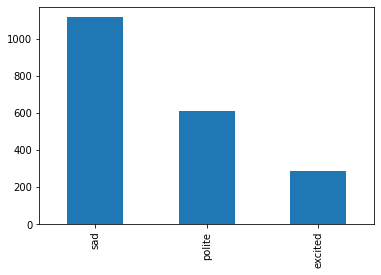

In [75]:
def analyze_post_comment_relationship_by_issue_length(df_analyze_posts, issue_length_divider):
    df_analyze_posts = remove_low_frequency_tones(df_analyze_posts)
    
    for i in range(len(issue_length_divider)-1):
        data = pd.DataFrame(columns=df_analyze_posts.columns)
        data_commit = pd.DataFrame(columns=df_analyze_posts.columns)
        lower = issue_length_divider[i]
        upper = issue_length_divider[i+1]
        data = df_analyze_posts.loc[(df_analyze_posts['NumberOfComments'] >= lower) &\
                                    (df_analyze_posts['NumberOfComments'] < upper)]
        for i, row in data.iterrows():
            if (row['HasCommit'] == 'TRUE'):
                data_commit.loc[i] = row
                
        if data.count()[0] > 0:
            printmd('\n### For issues having length: [' + str(lower) + ', ' + str(upper) + ')')
            analyze_post_comment_relationship(data)
            if data_commit.count()[0] > 0:
                print('======================')
                analyze_emotion_commit_relationship(data_commit)
                print('======================')
                
            
printmd('# Analysis by issue length:')
print('\n')
print('##############################################################')
print('##############################################################')
printmd('# PyTorch Results')
analyze_post_comment_relationship_by_issue_length(PyTorch_posts_wcomments, PyTorch_issue_length_divider)

print('\n')
print('##############################################################')
print('##############################################################')
printmd('# TensorFlow Results')
analyze_post_comment_relationship_by_issue_length(Tensorflow_posts_wcomments, Tensorflow_issue_length_divider)

print('\n')
print('##############################################################')
print('##############################################################')
printmd('# SkLearn Results')
analyze_post_comment_relationship_by_issue_length(SkLearn_posts_wcomments, SkLearn_issue_length_divider)

print('\n')
print('##############################################################')
print('##############################################################')
printmd('# All-together Results')
analyze_post_comment_relationship_by_issue_length(All_posts_wcomments, All_issue_length_divider)

**Separate by issue poster role**

# Analysis by issue poster role:



##############################################################
##############################################################


# PyTorch Results


## For issues posted by CONTRIBUTOR

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,56,0,59,1,279,1
neutral,788,88,116,34,380,2
positive,174,74,46,41,147,8


chi2 = 461.914  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.314</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
comment_dominant_sentiment,,,,,,
negative,13,0,15,6,84,2
neutral,349,93,89,265,761,64
positive,67,54,17,177,157,81


chi2 = 255.531  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:blue">cramers_v  = 0.231</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
Sentiment,,,
negative,19,288,89
neutral,83,1007,318
positive,18,326,146


chi2 = 13.539  <span style="color:red">p = 0.00892</span>  dof = 4

cramers_v = 0.046


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,78,24,22,79,168,25
neutral,271,81,75,280,617,84
positive,80,42,24,89,217,38


chi2 = 9.316  p = 0.5024  dof = 10

cramers_v = 0.0


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
post_dominant_tone_conf,,,
,56,720,242
excited,4,112,46
frustrated,11,155,55
polite,5,55,16
sad,44,570,192
satisfied,0,9,2


chi2 = 5.559  p = 0.85083  dof = 10

cramers_v = 0.0


#### Post tone <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
post_dominant_tone_conf,,,,,,
,214,56,50,204,426,68
excited,34,12,7,37,65,7
frustrated,42,15,17,36,97,14
polite,14,6,7,12,31,6
sad,124,57,39,156,379,51
satisfied,1,1,1,3,4,1


chi2 = 25.377  p = 0.44139  dof = 25

cramers_v = 0.006


#### Post sentiment <-> Time to first comment

H = 4.399  p = 0.11085  eta2 = 0.001

#### Post tone <-> Time to first comment

H = 9.508  p = 0.09043  eta2 = 0.002

#### Comment sentiment <-> Time to first comment

H = 4.925  p = 0.08522  eta2 = 0.001

#### Comment tone <-> Time to first comment

H = 38.121  <span style="color:red">p = 3.568e-07</span>  eta2 = 0.014

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,0.073586,0.848958,0.000109,6.187497e-08,0.352435
excited,7.358586e-02,-1.000000,1.000000,1.000000,1.000000e+00,1.000000
frustrated,8.489576e-01,1.000000,-1.000000,1.000000,6.894547e-01,1.000000
polite,1.089937e-04,1.000000,1.000000,-1.000000,1.000000e+00,1.000000
sad,6.187497e-08,1.000000,0.689455,1.000000,-1.000000e+00,0.848958
satisfied,3.524350e-01,1.000000,1.000000,1.000000,8.489576e-01,-1.000000


comment_dominant_tone_freq
              3.129112e+06
excited       1.040661e+06
frustrated    1.482229e+06
polite        1.017955e+06
sad           1.160557e+06
satisfied     1.930884e+06
Name: time_to_first_comment, dtype: float64

#### Post sentiment <-> Number of comments

H = 8.54  <span style="color:red">p = 0.0139806916</span>  eta2 = 0.003

,negative,neutral,positive
negative,-1.000000,0.063218,0.856031
neutral,0.063218,-1.000000,0.063218
positive,0.856031,0.063218,-1.000000


Sentiment
negative    5.267677
neutral     4.083807
positive    4.730612
Name: NumberOfComments, dtype: float64

#### Post tone <-> Number of comments

H = 18.584  <span style="color:red">p = 0.0022969359</span>  eta2 = 0.006

,,excited,frustrated,polite,sad,satisfied
,-1.000000,1.000000,0.368042,1.0,0.002643,1.0
excited,1.000000,-1.000000,1.000000,1.0,0.869737,1.0
frustrated,0.368042,1.000000,-1.000000,1.0,1.000000,1.0
polite,1.000000,1.000000,1.000000,-1.0,1.000000,1.0
sad,0.002643,0.869737,1.000000,1.0,-1.000000,1.0
satisfied,1.000000,1.000000,1.000000,1.0,1.000000,-1.0


post_dominant_tone_conf
              4.283890
excited       4.030864
frustrated    4.162896
polite        3.894737
sad           4.786600
satisfied     6.000000
Name: NumberOfComments, dtype: float64

#### Comment sentiment <-> Number of comments

H = 102.039  <span style="color:red">p = 0.0</span>  eta2 = 0.044

,negative,neutral,positive
negative,-1.000000e+00,2.259529e-13,2.057502e-05
neutral,2.259529e-13,-1.000000e+00,8.180953e-14
positive,2.057502e-05,8.180953e-14,-1.000000e+00


comment_dominant_sentiment
negative    2.116667
neutral     5.091919
positive    2.976492
Name: NumberOfComments, dtype: float64

#### Comment tone <-> Number of comments

H = 480.419  <span style="color:red">p = 0.0</span>  eta2 = 0.208

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,7.301460e-27,1.082284e-17,8.956946e-58,7.080826e-94,1.134836e-31
excited,7.301460e-27,-1.000000e+00,5.569042e-01,1.568553e-01,1.800278e-05,5.967177e-01
frustrated,1.082284e-17,5.569042e-01,-1.000000e+00,4.974386e-03,1.435559e-07,1.568553e-01
polite,8.956946e-58,1.568553e-01,4.974386e-03,-1.000000e+00,6.190192e-04,5.967177e-01
sad,7.080826e-94,1.800278e-05,1.435559e-07,6.190192e-04,-1.000000e+00,1.782184e-03
satisfied,1.134836e-31,5.967177e-01,1.568553e-01,5.967177e-01,1.782184e-03,-1.000000e+00


comment_dominant_tone_freq
              1.517483
excited       3.442177
frustrated    3.082645
polite        4.388393
sad           6.084830
satisfied     3.816327
Name: NumberOfComments, dtype: float64

#### Post sentiment <-> Time to first commit

H = 0.527  p = 0.76844  eta2 = -0.002

#### Post tone <-> Time to first commit

H = 4.382  p = 0.49586  eta2 = -0.001

#### Comment sentiment <-> Time to first commit

H = 17.095  <span style="color:red">p = 0.0001939971</span>  eta2 = 0.021

,negative,neutral,positive
negative,-1.000000,0.352042,0.028737
neutral,0.352042,-1.000000,0.000283
positive,0.028737,0.000283,-1.000000


comment_dominant_sentiment
negative    1.567417e+07
neutral     1.253926e+07
positive    7.463446e+06
Name: time_to_first_commit, dtype: float64

#### Comment tone <-> Time to first commit

H = 13.78  <span style="color:red">p = 0.0170680369</span>  eta2 = 0.012

,,excited,frustrated,polite,sad,satisfied
,-1.0,1.0,1.0,1.000000,1.000000,1.0
excited,1.0,-1.0,1.0,1.000000,1.000000,1.0
frustrated,1.0,1.0,-1.0,1.000000,1.000000,1.0
polite,1.0,1.0,1.0,-1.000000,0.004625,1.0
sad,1.0,1.0,1.0,0.004625,-1.000000,1.0
satisfied,1.0,1.0,1.0,1.000000,1.000000,-1.0


comment_dominant_tone_freq
              1.233807e+07
excited       1.085878e+07
frustrated    1.107791e+07
polite        8.305168e+06
sad           1.309454e+07
satisfied     8.116608e+06
Name: time_to_first_commit, dtype: float64

#### Post sentiment <-> Time to last commit

H = 0.365  p = 0.83313  eta2 = -0.002

#### Post tone <-> Time to last commit

H = 4.11  p = 0.53365  eta2 = -0.001

#### Comment sentiment <-> Time to last commit

H = 14.563  <span style="color:red">p = 0.0006882156</span>  eta2 = 0.018

,negative,neutral,positive
negative,-1.000000,0.464541,0.073385
neutral,0.464541,-1.000000,0.000758
positive,0.073385,0.000758,-1.000000


comment_dominant_sentiment
negative    1.823088e+07
neutral     1.401079e+07
positive    8.732988e+06
Name: time_to_last_commit, dtype: float64

#### Comment tone <-> Time to last commit

H = 12.068  <span style="color:red">p = 0.0338681323</span>  eta2 = 0.01

,,excited,frustrated,polite,sad,satisfied
,-1.000000,1.0,1.0,1.000000,0.942815,1.0
excited,1.000000,-1.0,1.0,1.000000,1.000000,1.0
frustrated,1.000000,1.0,-1.0,1.000000,1.000000,1.0
polite,1.000000,1.0,1.0,-1.000000,0.012606,1.0
sad,0.942815,1.0,1.0,0.012606,-1.000000,1.0
satisfied,1.000000,1.0,1.0,1.000000,1.000000,-1.0


comment_dominant_tone_freq
              1.344880e+07
excited       1.388023e+07
frustrated    1.557761e+07
polite        9.552797e+06
sad           1.421402e+07
satisfied     9.473485e+06
Name: time_to_last_commit, dtype: float64


## For issues posted by NON_CONTRIBUTOR

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,136,14,119,45,706,7
neutral,1601,123,250,131,898,25
positive,381,166,114,263,384,69


chi2 = 1262.741  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.34</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
comment_dominant_sentiment,,,,,,
negative,39,7,28,23,200,4
neutral,748,198,240,613,1780,160
positive,140,127,64,541,348,172


chi2 = 651.345  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:blue">cramers_v  = 0.243</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
Sentiment,,,
negative,58,717,252
neutral,182,2071,775
positive,61,951,365


chi2 = 5.426  p = 0.24635  dof = 4

cramers_v = 0.011


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,151,58,70,218,459,71
neutral,546,197,177,645,1283,180
positive,230,77,85,314,586,85


chi2 = 11.322  p = 0.33295  dof = 10

cramers_v = 0.011


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
post_dominant_tone_conf,,,
,128,1444,546
excited,18,206,79
frustrated,23,336,124
polite,26,311,102
sad,100,1380,508
satisfied,6,62,33


chi2 = 7.017  p = 0.7238  dof = 10

cramers_v = 0.0


#### Post tone <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
post_dominant_tone_conf,,,,,,
,385,146,127,458,880,122
excited,43,19,16,67,130,28
frustrated,81,24,31,107,210,30
polite,88,25,26,90,185,25
sad,314,109,126,432,879,128
satisfied,16,9,6,23,44,3


chi2 = 23.293  p = 0.56043  dof = 25

cramers_v = 0.0


#### Post sentiment <-> Time to first comment

H = 1.119  p = 0.57148  eta2 = -0.0

#### Post tone <-> Time to first comment

H = 3.426  p = 0.63455  eta2 = -0.0

#### Comment sentiment <-> Time to first comment

H = 6.719  <span style="color:red">p = 0.0347562172</span>  eta2 = 0.001

,negative,neutral,positive
negative,-1.000000,0.125524,0.452164
neutral,0.125524,-1.000000,0.125524
positive,0.452164,0.125524,-1.000000


comment_dominant_sentiment
negative    884641.275748
neutral     591061.609521
positive    545618.096983
Name: time_to_first_comment, dtype: float64

#### Comment tone <-> Time to first comment

H = 6.25  p = 0.28266  eta2 = 0.0

#### Post sentiment <-> Number of comments

H = 16.662  <span style="color:red">p = 0.0002408775</span>  eta2 = 0.003

,negative,neutral,positive
negative,-1.000000,0.000153,0.060903
neutral,0.000153,-1.000000,0.089353
positive,0.060903,0.089353,-1.000000


Sentiment
negative    4.985394
neutral     4.275760
positive    5.180828
Name: NumberOfComments, dtype: float64

#### Post tone <-> Number of comments

H = 41.212  <span style="color:red">p = 8.5e-08</span>  eta2 = 0.007

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,0.387762,0.101731,1.000000,3.636021e-08,1.000000
excited,3.877623e-01,-1.000000,1.000000,0.791244,1.000000e+00,1.000000
frustrated,1.017312e-01,1.000000,-1.000000,0.536160,1.000000e+00,1.000000
polite,1.000000e+00,0.791244,0.536160,-1.000000,7.203850e-03,1.000000
sad,3.636021e-08,1.000000,1.000000,0.007204,-1.000000e+00,0.699668
satisfied,1.000000e+00,1.000000,1.000000,1.000000,6.996676e-01,-1.000000


post_dominant_tone_conf
              4.382908
excited       4.580858
frustrated    4.826087
polite        4.328018
sad           4.948692
satisfied     4.564356
Name: NumberOfComments, dtype: float64

#### Comment sentiment <-> Number of comments

H = 233.809  <span style="color:red">p = 0.0</span>  eta2 = 0.043

,negative,neutral,positive
negative,-1.000000e+00,6.484744e-24,2.626937e-04
neutral,6.484744e-24,-1.000000e+00,1.749714e-36
positive,2.626937e-04,1.749714e-36,-1.000000e+00


comment_dominant_sentiment
negative    2.285714
neutral     5.421236
positive    3.048132
Name: NumberOfComments, dtype: float64

#### Comment tone <-> Number of comments

H = 1101.98  <span style="color:red">p = 0.0</span>  eta2 = 0.202

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,7.454900e-72,3.727218e-61,1.537899e-139,7.469747e-212,2.277126e-72
excited,7.454900e-72,-1.000000e+00,4.379219e-01,4.379219e-01,1.858021e-09,9.917104e-01
frustrated,3.727218e-61,4.379219e-01,-1.000000e+00,2.292358e-03,1.088239e-15,4.379219e-01
polite,1.537899e-139,4.379219e-01,2.292358e-03,-1.000000e+00,6.861845e-14,4.379219e-01
sad,7.469747e-212,1.858021e-09,1.088239e-15,6.861845e-14,-1.000000e+00,1.933690e-09
satisfied,2.277126e-72,9.917104e-01,4.379219e-01,4.379219e-01,1.933690e-09,-1.000000e+00


comment_dominant_tone_freq
              1.440129
excited       3.695783
frustrated    3.289157
polite        4.307562
sad           6.530498
satisfied     3.791667
Name: NumberOfComments, dtype: float64

#### Post sentiment <-> Time to first commit

H = 1.528  p = 0.46578  eta2 = -0.001

#### Post tone <-> Time to first commit

H = 21.165  <span style="color:red">p = 0.0007538554</span>  eta2 = 0.02

,,excited,frustrated,polite,sad,satisfied
,-1.000000,1.000000,0.506386,0.228366,0.179449,1.0
excited,1.000000,-1.000000,0.125281,1.000000,0.090208,1.0
frustrated,0.506386,0.125281,-1.000000,0.017698,1.000000,1.0
polite,0.228366,1.000000,0.017698,-1.000000,0.007247,1.0
sad,0.179449,0.090208,1.000000,0.007247,-1.000000,1.0
satisfied,1.000000,1.000000,1.000000,1.000000,1.000000,-1.0


post_dominant_tone_conf
              2.027367e+07
excited       2.694881e+07
frustrated    1.480862e+07
polite        3.055528e+07
sad           1.628605e+07
satisfied     1.396003e+07
Name: time_to_first_commit, dtype: float64

#### Comment sentiment <-> Time to first commit

H = 10.147  <span style="color:red">p = 0.0062597535</span>  eta2 = 0.01

,negative,neutral,positive
negative,-1.000000,0.684440,0.599745
neutral,0.684440,-1.000000,0.004102
positive,0.599745,0.004102,-1.000000


comment_dominant_sentiment
negative    2.237140e+07
neutral     2.003717e+07
positive    1.509360e+07
Name: time_to_first_commit, dtype: float64

#### Comment tone <-> Time to first commit

H = 4.563  p = 0.47151  eta2 = -0.001

#### Post sentiment <-> Time to last commit

H = 0.543  p = 0.76233  eta2 = -0.002

#### Post tone <-> Time to last commit

H = 22.793  <span style="color:red">p = 0.0003697356</span>  eta2 = 0.022

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.279052,1.000000,0.279052,0.135503,1.0
excited,0.279052,-1.000000,0.059411,1.000000,0.012185,1.0
frustrated,1.000000,0.059411,-1.000000,0.048232,1.000000,1.0
polite,0.279052,1.000000,0.048232,-1.000000,0.008653,1.0
sad,0.135503,0.012185,1.000000,0.008653,-1.000000,1.0
satisfied,1.000000,1.000000,1.000000,1.000000,1.000000,-1.0


post_dominant_tone_conf
              2.218875e+07
excited       3.255378e+07
frustrated    1.757829e+07
polite        3.279904e+07
sad           1.778864e+07
satisfied     1.624264e+07
Name: time_to_last_commit, dtype: float64

#### Comment sentiment <-> Time to last commit

H = 12.443  <span style="color:red">p = 0.0019862889</span>  eta2 = 0.013

,negative,neutral,positive
negative,-1.000000,0.920788,0.306935
neutral,0.920788,-1.000000,0.001200
positive,0.306935,0.001200,-1.000000


comment_dominant_sentiment
negative    2.593744e+07
neutral     2.226247e+07
positive    1.637591e+07
Name: time_to_last_commit, dtype: float64

#### Comment tone <-> Time to last commit

H = 5.257  p = 0.38537  eta2 = 0.0



##############################################################
##############################################################


# TensorFlow Results


## For issues posted by CONTRIBUTOR

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,55,8,40,13,320,0
neutral,935,59,104,62,404,4
positive,211,82,75,124,257,10


chi2 = 654.049  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.342</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
comment_dominant_sentiment,,,,,,
negative,10,4,7,14,69,1
neutral,156,93,58,360,774,59
positive,48,121,13,609,262,105


chi2 = 427.874  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.275</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
Sentiment,,,
negative,15,270,151
neutral,59,802,707
positive,31,428,300


chi2 = 18.787  <span style="color:red">p = 0.00087</span>  dof = 4

cramers_v = 0.052


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,32,30,12,126,209,27
neutral,131,131,40,596,571,99
positive,51,57,26,261,325,39


chi2 = 27.414  <span style="color:red">p = 0.00224</span>  dof = 10

cramers_v = 0.056


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
post_dominant_tone_conf,,,
,44,594,563
excited,3,87,59
frustrated,13,117,89
polite,8,119,72
sad,37,578,366
satisfied,0,5,9


chi2 = 31.561  <span style="color:red">p = 0.00047</span>  dof = 10

cramers_v = 0.062


#### Post tone <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
post_dominant_tone_conf,,,,,,
,92,106,32,453,440,78
excited,10,11,3,54,66,5
frustrated,17,12,10,73,97,10
polite,18,14,7,72,77,11
sad,76,75,24,327,419,60
satisfied,1,0,2,4,6,1


chi2 = 28.779  p = 0.27328  dof = 25

cramers_v = 0.017


#### Post sentiment <-> Time to first comment

H = 13.343  <span style="color:red">p = 0.0012663458</span>  eta2 = 0.004

,negative,neutral,positive
negative,-1.000000,0.001116,0.097825
neutral,0.001116,-1.000000,0.097825
positive,0.097825,0.097825,-1.000000


Sentiment
negative    493387.068807
neutral     701099.107143
positive    777146.191041
Name: time_to_first_comment, dtype: float64

#### Post tone <-> Time to first comment

H = 15.112  <span style="color:red">p = 0.009894746</span>  eta2 = 0.004

,,excited,frustrated,polite,sad,satisfied
,-1.000000,1.000000,1.0,0.728709,0.006106,1.0
excited,1.000000,-1.000000,1.0,1.000000,0.718599,1.0
frustrated,1.000000,1.000000,-1.0,1.000000,1.000000,1.0
polite,0.728709,1.000000,1.0,-1.000000,1.000000,1.0
sad,0.006106,0.718599,1.0,1.000000,-1.000000,1.0
satisfied,1.000000,1.000000,1.0,1.000000,1.000000,-1.0


post_dominant_tone_conf
              7.452390e+05
excited       1.061633e+06
frustrated    8.472371e+05
polite        4.284463e+05
sad           5.847944e+05
satisfied     4.706836e+05
Name: time_to_first_comment, dtype: float64

#### Comment sentiment <-> Time to first comment

H = 8.793  <span style="color:red">p = 0.0123230801</span>  eta2 = 0.002

,negative,neutral,positive
negative,-1.000000,0.017958,0.081906
neutral,0.017958,-1.000000,0.107464
positive,0.081906,0.107464,-1.000000


comment_dominant_sentiment
negative    1.621976e+06
neutral     6.167686e+05
positive    6.984747e+05
Name: time_to_first_comment, dtype: float64

#### Comment tone <-> Time to first comment

H = 4.175  p = 0.52445  eta2 = -0.0

#### Post sentiment <-> Number of comments

H = 5.639  p = 0.05963  eta2 = 0.001

#### Post tone <-> Number of comments

H = 4.732  p = 0.44948  eta2 = -0.0

#### Comment sentiment <-> Number of comments

H = 94.818  <span style="color:red">p = 0.0</span>  eta2 = 0.034

,negative,neutral,positive
negative,-1.000000e+00,7.210069e-16,1.997441e-10
neutral,7.210069e-16,-1.000000e+00,6.300924e-10
positive,1.997441e-10,6.300924e-10,-1.000000e+00


comment_dominant_sentiment
negative    2.923810
neutral     7.885333
positive    5.812608
Name: NumberOfComments, dtype: float64

#### Comment tone <-> Number of comments

H = 446.863  <span style="color:red">p = 0.0</span>  eta2 = 0.16

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,4.990658e-35,2.303117e-18,3.062965e-75,1.778486e-74,4.754334e-26
excited,4.990658e-35,-1.000000e+00,1.000000e+00,7.556341e-08,3.785107e-10,8.496919e-01
frustrated,2.303117e-18,1.000000e+00,-1.000000e+00,2.132518e-04,2.408403e-05,1.000000e+00
polite,3.062965e-75,7.556341e-08,2.132518e-04,-1.000000e+00,1.547708e-01,2.132473e-09
sad,1.778486e-74,3.785107e-10,2.408403e-05,1.547708e-01,-1.000000e+00,1.923835e-11
satisfied,4.754334e-26,8.496919e-01,1.000000e+00,2.132473e-09,1.923835e-11,-1.000000e+00


comment_dominant_tone_freq
              1.696262
excited       4.715596
frustrated    4.307692
polite        7.181078
sad           8.508597
satisfied     4.109091
Name: NumberOfComments, dtype: float64

#### Post sentiment <-> Time to first commit

H = 1.496  p = 0.4733  eta2 = -0.002

#### Post tone <-> Time to first commit

H = 12.498  <span style="color:red">p = 0.0285693287</span>  eta2 = 0.024

,,excited,frustrated,polite,sad,satisfied
,-1.000000,1.000000,0.384755,0.242165,1.000000,1.0
excited,1.000000,-1.000000,1.000000,0.490288,1.000000,1.0
frustrated,0.384755,1.000000,-1.000000,0.061544,0.219627,1.0
polite,0.242165,0.490288,0.061544,-1.000000,0.352077,1.0
sad,1.000000,1.000000,0.219627,0.352077,-1.000000,1.0
satisfied,1.000000,1.000000,1.000000,1.000000,1.000000,-1.0


post_dominant_tone_conf
              2.706650e+06
excited       3.931851e+06
frustrated    6.460447e+06
polite        1.492358e+06
sad           3.026081e+06
satisfied     3.018757e+06
Name: time_to_first_commit, dtype: float64

#### Comment sentiment <-> Time to first commit

H = 1.05  p = 0.59166  eta2 = -0.003

#### Comment tone <-> Time to first commit

H = 7.08  p = 0.21475  eta2 = 0.007

#### Post sentiment <-> Time to last commit

H = 1.28  p = 0.52721  eta2 = -0.002

#### Post tone <-> Time to last commit

H = 11.713  <span style="color:red">p = 0.0389433176</span>  eta2 = 0.021

,,excited,frustrated,polite,sad,satisfied
,-1.000000,1.000000,0.815924,0.115453,1.000000,1.0
excited,1.000000,-1.000000,1.000000,0.584917,1.000000,1.0
frustrated,0.815924,1.000000,-1.000000,0.057955,0.491421,1.0
polite,0.115453,0.584917,0.057955,-1.000000,0.213892,1.0
sad,1.000000,1.000000,0.491421,0.213892,-1.000000,1.0
satisfied,1.000000,1.000000,1.000000,1.000000,1.000000,-1.0


post_dominant_tone_conf
              3.179246e+06
excited       4.101473e+06
frustrated    6.474737e+06
polite        1.502979e+06
sad           3.542757e+06
satisfied     3.018757e+06
Name: time_to_last_commit, dtype: float64

#### Comment sentiment <-> Time to last commit

H = 0.834  p = 0.65897  eta2 = -0.004

#### Comment tone <-> Time to last commit

H = 6.226  p = 0.28485  eta2 = 0.004


## For issues posted by NON_CONTRIBUTOR

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,280,48,209,152,1893,8
neutral,5377,262,392,468,1884,40
positive,1018,450,318,1099,1847,120


chi2 = 4894.13  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.392</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
comment_dominant_sentiment,,,,,,
negative,47,17,48,55,429,6
neutral,1060,454,285,2043,3813,242
positive,337,659,144,4342,1356,528


chi2 = 3009.751  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.307</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
Sentiment,,,
negative,95,1358,1137
neutral,294,3912,4217
positive,213,2627,2012


chi2 = 101.02  <span style="color:red">p = 0.0</span>  dof = 4

cramers_v = 0.055


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,251,170,78,968,1000,123
neutral,709,640,239,3686,2721,428
positive,484,320,160,1786,1877,225


chi2 = 108.398  <span style="color:red">p = 0.0</span>  dof = 10

cramers_v = 0.056


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
post_dominant_tone_conf,,,
,243,3021,3411
excited,39,445,276
frustrated,38,494,387
polite,74,894,751
sad,203,2956,2465
satisfied,5,87,76


chi2 = 121.757  <span style="color:red">p = 0.0</span>  dof = 10

cramers_v = 0.059


#### Post tone <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
post_dominant_tone_conf,,,,,,
,570,539,189,2923,2104,350
excited,83,53,18,268,309,29
frustrated,91,51,30,361,345,41
polite,182,107,71,616,648,95
sad,500,366,164,2212,2131,251
satisfied,18,14,5,60,61,10


chi2 = 128.039  <span style="color:red">p = 0.0</span>  dof = 25

cramers_v = 0.036


#### Post sentiment <-> Time to first comment

H = 40.425  <span style="color:red">p = 1.7e-09</span>  eta2 = 0.002

,negative,neutral,positive
negative,-1.000000e+00,6.610776e-07,2.832928e-01
neutral,6.610776e-07,-1.000000e+00,9.344889e-07
positive,2.832928e-01,9.344889e-07,-1.000000e+00


Sentiment
negative    513109.139382
neutral     444541.213463
positive    510253.410758
Name: time_to_first_comment, dtype: float64

#### Post tone <-> Time to first comment

H = 81.697  <span style="color:red">p = 0.0</span>  eta2 = 0.005

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,0.060758,0.015271,5.873982e-07,7.365867e-16,1.0
excited,6.075834e-02,-1.000000,1.000000,1.000000e+00,1.000000e+00,1.0
frustrated,1.527068e-02,1.000000,-1.000000,1.000000e+00,1.000000e+00,1.0
polite,5.873982e-07,1.000000,1.000000,-1.000000e+00,1.000000e+00,1.0
sad,7.365867e-16,1.000000,1.000000,1.000000e+00,-1.000000e+00,1.0
satisfied,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000e+00,-1.0


post_dominant_tone_conf
              504344.055880
excited       509031.784211
frustrated    315245.862894
polite        531576.748109
sad           446498.565078
satisfied     482814.428571
Name: time_to_first_comment, dtype: float64

#### Comment sentiment <-> Time to first comment

H = 23.61  <span style="color:red">p = 7.4682e-06</span>  eta2 = 0.001

,negative,neutral,positive
negative,-1.000000,0.379280,0.615562
neutral,0.379280,-1.000000,0.000004
positive,0.615562,0.000004,-1.000000


comment_dominant_sentiment
negative    477009.926910
neutral     487552.092187
positive    463170.514933
Name: time_to_first_comment, dtype: float64

#### Comment tone <-> Time to first comment

H = 29.413  <span style="color:red">p = 1.92351e-05</span>  eta2 = 0.002

,,excited,frustrated,polite,sad,satisfied
,-1.00000,1.000000,1.0000,1.000000,0.313440,1.00000
excited,1.00000,-1.000000,1.0000,1.000000,0.276762,1.00000
frustrated,1.00000,1.000000,-1.0000,1.000000,0.384700,1.00000
polite,1.00000,1.000000,1.0000,-1.000000,0.000016,1.00000
sad,0.31344,0.276762,0.3847,0.000016,-1.000000,0.02048
satisfied,1.00000,1.000000,1.0000,1.000000,0.020480,-1.00000


comment_dominant_tone_freq
              777657.736842
excited       575301.819469
frustrated    441711.226415
polite        400639.942702
sad           465446.527153
satisfied     489248.567010
Name: time_to_first_comment, dtype: float64

#### Post sentiment <-> Number of comments

H = 16.796  <span style="color:red">p = 0.0002253709</span>  eta2 = 0.001

,negative,neutral,positive
negative,-1.000000,0.003126,0.000211
neutral,0.003126,-1.000000,0.087197
positive,0.000211,0.087197,-1.000000


Sentiment
negative    6.386873
neutral     5.929598
positive    6.191880
Name: NumberOfComments, dtype: float64

#### Post tone <-> Number of comments

H = 41.876  <span style="color:red">p = 6.24e-08</span>  eta2 = 0.002

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.702898,1.000000,0.470477,0.000260,0.101920
excited,0.702898,-1.000000,0.702898,1.000000,0.005108,0.702898
frustrated,1.000000,0.702898,-1.000000,0.702898,0.702898,0.114168
polite,0.470477,1.000000,0.702898,-1.000000,0.000142,0.702898
sad,0.000260,0.005108,0.702898,0.000142,-1.000000,0.005251
satisfied,0.101920,0.702898,0.114168,0.702898,0.005251,-1.000000


post_dominant_tone_conf
              5.862472
excited       5.923684
frustrated    6.150163
polite        6.068645
sad           6.405583
satisfied     4.684524
Name: NumberOfComments, dtype: float64

#### Comment sentiment <-> Number of comments

H = 426.169  <span style="color:red">p = 0.0</span>  eta2 = 0.027

,negative,neutral,positive
negative,-1.000000e+00,5.520873e-79,3.260636e-63
neutral,5.520873e-79,-1.000000e+00,4.064461e-23
positive,3.260636e-63,4.064461e-23,-1.000000e+00


comment_dominant_sentiment
negative    2.719269
neutral     7.052805
positive    5.321341
Name: NumberOfComments, dtype: float64

#### Comment tone <-> Number of comments

H = 2505.961  <span style="color:red">p = 0.0</span>  eta2 = 0.158

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,2.003780e-186,2.018061e-70,0.000000e+00,0.000000e+00,4.421418e-127
excited,2.003780e-186,-1.000000e+00,6.759521e-09,1.198533e-28,4.244372e-33,6.506570e-03
frustrated,2.018061e-70,6.759521e-09,-1.000000e+00,3.032593e-42,2.247054e-42,1.737897e-03
polite,0.000000e+00,1.198533e-28,3.032593e-42,-1.000000e+00,1.737897e-03,3.464382e-35
sad,0.000000e+00,4.244372e-33,2.247054e-42,1.737897e-03,-1.000000e+00,4.212612e-38
satisfied,4.421418e-127,6.506570e-03,1.737897e-03,3.464382e-35,4.212612e-38,-1.000000e+00


comment_dominant_tone_freq
              1.662050
excited       4.588496
frustrated    3.492662
polite        6.484317
sad           7.575920
satisfied     4.007732
Name: NumberOfComments, dtype: float64

#### Post sentiment <-> Time to first commit

H = 2.663  p = 0.26414  eta2 = 0.001

#### Post tone <-> Time to first commit

H = 1.786  p = 0.87794  eta2 = -0.005

#### Comment sentiment <-> Time to first commit

H = 2.842  p = 0.24145  eta2 = 0.001

#### Comment tone <-> Time to first commit

H = 12.818  <span style="color:red">p = 0.0251475425</span>  eta2 = 0.013

,,excited,frustrated,polite,sad,satisfied
,-1.000000,1.000000,1.000000,0.124756,0.536612,1.0
excited,1.000000,-1.000000,1.000000,0.536612,1.000000,1.0
frustrated,1.000000,1.000000,-1.000000,0.334382,0.672881,1.0
polite,0.124756,0.536612,0.334382,-1.000000,1.000000,1.0
sad,0.536612,1.000000,0.672881,1.000000,-1.000000,1.0
satisfied,1.000000,1.000000,1.000000,1.000000,1.000000,-1.0


comment_dominant_tone_freq
              1.674307e+06
excited       3.365458e+06
frustrated    1.156053e+06
polite        3.601001e+06
sad           3.096490e+06
satisfied     3.682051e+06
Name: time_to_first_commit, dtype: float64

#### Post sentiment <-> Time to last commit

H = 2.492  p = 0.2876  eta2 = 0.001

#### Post tone <-> Time to last commit

H = 3.606  p = 0.60745  eta2 = -0.002

#### Comment sentiment <-> Time to last commit

H = 2.244  p = 0.32557  eta2 = 0.0

#### Comment tone <-> Time to last commit

H = 11.856  <span style="color:red">p = 0.0368106643</span>  eta2 = 0.011

,,excited,frustrated,polite,sad,satisfied
,-1.000000,1.000000,1.0,0.058999,0.516636,0.722708
excited,1.000000,-1.000000,1.0,0.516636,1.000000,1.000000
frustrated,1.000000,1.000000,-1.0,1.000000,1.000000,1.000000
polite,0.058999,0.516636,1.0,-1.000000,1.000000,1.000000
sad,0.516636,1.000000,1.0,1.000000,-1.000000,1.000000
satisfied,0.722708,1.000000,1.0,1.000000,1.000000,-1.000000


comment_dominant_tone_freq
              1.706212e+06
excited       3.614620e+06
frustrated    1.562331e+06
polite        3.893118e+06
sad           3.285270e+06
satisfied     3.905393e+06
Name: time_to_last_commit, dtype: float64



##############################################################
##############################################################


# SkLearn Results


## For issues posted by CONTRIBUTOR

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,0,0,23,0,120,0
neutral,263,55,66,19,182,0
positive,74,58,22,20,79,8


chi2 = 248.731  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.348</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
comment_dominant_sentiment,,,,,,
negative,7,0,4,3,26,0
neutral,90,94,47,119,326,16
positive,27,55,8,65,73,29


chi2 = 85.403  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:blue">cramers_v  = 0.195</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
Sentiment,,,
negative,6,95,42
neutral,26,403,156
positive,8,194,59


chi2 = 3.803  p = 0.43328  dof = 4

cramers_v = 0.0


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,15,27,5,23,68,5
neutral,72,80,40,117,247,29
positive,37,42,14,47,110,11


chi2 = 8.269  p = 0.60256  dof = 10

cramers_v = 0.0


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
post_dominant_tone_conf,,,
,17,231,89
excited,1,84,28
frustrated,1,88,22
polite,0,27,12
sad,20,255,106
satisfied,1,7,0


chi2 = 17.959  p = 0.05566  dof = 10

cramers_v = 0.063


#### Post tone <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
post_dominant_tone_conf,,,,,,
,46,55,21,60,138,17
excited,16,22,5,22,44,4
frustrated,6,13,12,26,48,6
polite,9,3,2,5,19,1
sad,46,56,19,74,169,17
satisfied,1,0,0,0,7,0


chi2 = 29.865  p = 0.2294  dof = 25

cramers_v = 0.031


#### Post sentiment <-> Time to first comment

H = 0.907  p = 0.63526  eta2 = -0.001

#### Post tone <-> Time to first comment

H = 4.979  p = 0.41847  eta2 = -0.0

#### Comment sentiment <-> Time to first comment

H = 6.043  <span style="color:red">p = 0.0487346504</span>  eta2 = 0.004

,negative,neutral,positive
negative,-1.000000,0.039521,0.051818
neutral,0.039521,-1.000000,0.970768
positive,0.051818,0.970768,-1.000000


comment_dominant_sentiment
negative    785965.200000
neutral     816842.592486
positive    614009.206226
Name: time_to_first_comment, dtype: float64

#### Comment tone <-> Time to first comment

H = 6.144  p = 0.29244  eta2 = 0.001

#### Post sentiment <-> Number of comments

H = 3.289  p = 0.19314  eta2 = 0.001

#### Post tone <-> Number of comments

H = 3.241  p = 0.66285  eta2 = -0.002

#### Comment sentiment <-> Number of comments

H = 53.802  <span style="color:red">p = 0.0</span>  eta2 = 0.053

,negative,neutral,positive
negative,-1.000000,4.278479e-06,2.227169e-02
neutral,0.000004,-1.000000e+00,3.401951e-09
positive,0.022272,3.401951e-09,-1.000000e+00


comment_dominant_sentiment
negative    3.200000
neutral     7.514451
positive    4.700389
Name: NumberOfComments, dtype: float64

#### Comment tone <-> Number of comments

H = 200.172  <span style="color:red">p = 0.0</span>  eta2 = 0.199

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,8.250885e-24,3.498741e-09,1.121615e-24,1.285581e-35,0.000002
excited,8.250885e-24,-1.000000e+00,1.396407e-02,1.000000e+00,6.341898e-02,0.008100
frustrated,3.498741e-09,1.396407e-02,-1.000000e+00,3.497566e-02,3.567426e-05,1.000000
polite,1.121615e-24,1.000000e+00,3.497566e-02,-1.000000e+00,9.818469e-03,0.013097
sad,1.285581e-35,6.341898e-02,3.567426e-05,9.818469e-03,-1.000000e+00,0.000036
satisfied,1.816042e-06,8.099620e-03,1.000000e+00,1.309685e-02,3.648198e-05,-1.000000


comment_dominant_tone_freq
              1.935484
excited       6.570470
frustrated    4.254237
polite        6.310160
sad           8.717647
satisfied     4.022222
Name: NumberOfComments, dtype: float64

#### Post sentiment <-> Time to first commit

H = 3.072  p = 0.21527  eta2 = 0.01

#### Post tone <-> Time to first commit

H = 5.264  p = 0.26123  eta2 = 0.012

#### Comment sentiment <-> Time to first commit

H = 1.83  p = 0.40061  eta2 = -0.002

#### Comment tone <-> Time to first commit

H = 0.697  p = 0.98313  eta2 = -0.041

#### Post sentiment <-> Time to last commit

H = 1.747  p = 0.41747  eta2 = -0.002

#### Post tone <-> Time to last commit

H = 5.164  p = 0.27092  eta2 = 0.011

#### Comment sentiment <-> Time to last commit

H = 1.541  p = 0.46286  eta2 = -0.004

#### Comment tone <-> Time to last commit

H = 0.935  p = 0.96764  eta2 = -0.039


## For issues posted by NON_CONTRIBUTOR

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,0,2,102,2,402,0
neutral,1311,198,209,93,734,11
positive,301,203,116,143,400,36


chi2 = 1034.946  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.347</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
comment_dominant_sentiment,,,,,,
negative,10,7,26,13,118,0
neutral,434,349,172,518,1382,81
positive,116,253,58,287,334,105


chi2 = 327.645  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:blue">cramers_v  = 0.193</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
Sentiment,,,
negative,19,355,134
neutral,105,1754,697
positive,50,827,322


chi2 = 0.42  p = 0.98085  dof = 4

cramers_v = 0.0


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,65,71,33,98,215,26
neutral,337,371,148,498,1087,115
positive,158,167,75,222,532,45


chi2 = 3.718  p = 0.95918  dof = 10

cramers_v = 0.0


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
post_dominant_tone_conf,,,
,71,1110,431
excited,11,289,103
frustrated,14,292,121
polite,12,156,70
sad,64,1060,412
satisfied,2,29,16


chi2 = 6.705  p = 0.75296  dof = 10

cramers_v = 0.0


#### Post tone <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
post_dominant_tone_conf,,,,,,
,224,249,101,295,674,69
excited,41,59,26,87,174,16
frustrated,48,59,27,77,190,26
polite,37,33,15,50,90,13
sad,207,202,81,303,685,58
satisfied,3,7,6,6,21,4


chi2 = 29.617  p = 0.23895  dof = 25

cramers_v = 0.015


#### Post sentiment <-> Time to first comment

H = 5.245  p = 0.07264  eta2 = 0.001

#### Post tone <-> Time to first comment

H = 19.188  <span style="color:red">p = 0.0017732749</span>  eta2 = 0.003

,,excited,frustrated,polite,sad,satisfied
,-1.000000,1.0,1.0,0.905806,0.000833,0.905806
excited,1.000000,-1.0,1.0,1.000000,1.000000,1.000000
frustrated,1.000000,1.0,-1.0,1.000000,1.000000,1.000000
polite,0.905806,1.0,1.0,-1.000000,1.000000,1.000000
sad,0.000833,1.0,1.0,1.000000,-1.000000,1.000000
satisfied,0.905806,1.0,1.0,1.000000,1.000000,-1.000000


post_dominant_tone_conf
              1.910808e+06
excited       1.564865e+06
frustrated    1.414018e+06
polite        6.763998e+05
sad           8.368745e+05
satisfied     1.306191e+05
Name: time_to_first_comment, dtype: float64

#### Comment sentiment <-> Time to first comment

H = 0.064  p = 0.9687  eta2 = -0.0

#### Comment tone <-> Time to first comment

H = 16.331  <span style="color:red">p = 0.0059603299</span>  eta2 = 0.003

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.723238,1.000000,0.201902,0.003795,1.0
excited,0.723238,-1.000000,1.000000,1.000000,1.000000,1.0
frustrated,1.000000,1.000000,-1.000000,1.000000,0.513294,1.0
polite,0.201902,1.000000,1.000000,-1.000000,1.000000,1.0
sad,0.003795,1.000000,0.513294,1.000000,-1.000000,1.0
satisfied,1.000000,1.000000,1.000000,1.000000,1.000000,-1.0


comment_dominant_tone_freq
              2.867690e+06
excited       1.510088e+06
frustrated    7.964713e+05
polite        1.026683e+06
sad           1.109126e+06
satisfied     8.806416e+05
Name: time_to_first_comment, dtype: float64

#### Post sentiment <-> Number of comments

H = 18.244  <span style="color:red">p = 0.000109251</span>  eta2 = 0.004

,negative,neutral,positive
negative,-1.000000,0.000061,0.003509
neutral,0.000061,-1.000000,0.232009
positive,0.003509,0.232009,-1.000000


Sentiment
negative    7.444882
neutral     6.285994
positive    6.750626
Name: NumberOfComments, dtype: float64

#### Post tone <-> Number of comments

H = 28.253  <span style="color:red">p = 3.24738e-05</span>  eta2 = 0.005

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.013485,0.021691,1.000000,0.000551,1.0
excited,0.013485,-1.000000,1.000000,0.093235,1.000000,1.0
frustrated,0.021691,1.000000,-1.000000,0.107421,1.000000,1.0
polite,1.000000,0.093235,0.107421,-1.000000,0.102359,1.0
sad,0.000551,1.000000,1.000000,0.102359,-1.000000,1.0
satisfied,1.000000,1.000000,1.000000,1.000000,1.000000,-1.0


post_dominant_tone_conf
              6.007444
excited       7.399504
frustrated    6.990632
polite        5.684874
sad           6.953776
satisfied     5.489362
Name: NumberOfComments, dtype: float64

#### Comment sentiment <-> Number of comments

H = 223.146  <span style="color:red">p = 0.0</span>  eta2 = 0.052

,negative,neutral,positive
negative,-1.000000e+00,1.597969e-22,7.950108e-06
neutral,1.597969e-22,-1.000000e+00,1.554745e-34
positive,7.950108e-06,1.554745e-34,-1.000000e+00


comment_dominant_sentiment
negative    2.988506
neutral     7.547003
positive    4.566349
Name: NumberOfComments, dtype: float64

#### Comment tone <-> Number of comments

H = 929.12  <span style="color:red">p = 0.0</span>  eta2 = 0.217

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,7.524662e-91,2.870941e-55,8.384361e-128,1.259805e-171,2.095848e-49
excited,7.524662e-91,-1.000000e+00,2.123111e-01,5.662202e-05,1.808529e-16,7.752960e-01
frustrated,2.870941e-55,2.123111e-01,-1.000000e+00,3.584530e-07,2.759881e-15,7.752960e-01
polite,8.384361e-128,5.662202e-05,3.584530e-07,-1.000000e+00,5.662202e-05,3.178519e-04
sad,1.259805e-171,1.808529e-16,2.759881e-15,5.662202e-05,-1.000000e+00,2.111637e-09
satisfied,2.095848e-49,7.752960e-01,7.752960e-01,3.178519e-04,2.111637e-09,-1.000000e+00


comment_dominant_tone_freq
              1.658929
excited       5.733990
frustrated    4.488281
polite        6.727384
sad           8.717557
satisfied     4.741935
Name: NumberOfComments, dtype: float64

#### Post sentiment <-> Time to first commit

H = 17.068  <span style="color:red">p = 0.0001966764</span>  eta2 = 0.042

,negative,neutral,positive
negative,-1.000000,0.207658,0.000746
neutral,0.207658,-1.000000,0.000746
positive,0.000746,0.000746,-1.000000


Sentiment
negative    3.730165e+06
neutral     6.852024e+06
positive    1.514344e+07
Name: time_to_first_commit, dtype: float64

#### Post tone <-> Time to first commit

H = 6.858  p = 0.2314  eta2 = 0.005

#### Comment sentiment <-> Time to first commit

H = 1.446  p = 0.48541  eta2 = -0.002

#### Comment tone <-> Time to first commit

H = 3.75  p = 0.58598  eta2 = -0.003

#### Post sentiment <-> Time to last commit

H = 15.572  <span style="color:red">p = 0.0004156066</span>  eta2 = 0.038

,negative,neutral,positive
negative,-1.000000,0.175376,0.001564
neutral,0.175376,-1.000000,0.001564
positive,0.001564,0.001564,-1.000000


Sentiment
negative    4.259186e+06
neutral     8.420233e+06
positive    1.596145e+07
Name: time_to_last_commit, dtype: float64

#### Post tone <-> Time to last commit

H = 7.463  p = 0.18841  eta2 = 0.007

#### Comment sentiment <-> Time to last commit

H = 1.979  p = 0.37167  eta2 = -0.0

#### Comment tone <-> Time to last commit

H = 2.5  p = 0.77654  eta2 = -0.007



##############################################################
##############################################################


# All-together Results


## For issues posted by CONTRIBUTOR

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,111,8,122,14,719,1
neutral,1986,202,286,115,966,6
positive,459,214,143,185,483,26


chi2 = 1334.96  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.331</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
comment_dominant_sentiment,,,,,,
negative,30,4,26,23,179,3
neutral,595,280,194,744,1861,139
positive,142,230,38,851,492,215


chi2 = 820.876  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.259</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
Sentiment,,,
negative,40,653,282
neutral,168,2212,1181
positive,57,948,505


chi2 = 9.973  <span style="color:red">p = 0.04088</span>  dof = 4

cramers_v = 0.022


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,125,81,39,228,445,57
neutral,474,292,155,993,1435,212
positive,168,141,64,397,652,88


chi2 = 17.926  p = 0.05622  dof = 10

cramers_v = 0.026


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
post_dominant_tone_conf,,,
,117,1545,894
excited,8,283,133
frustrated,25,360,166
polite,13,201,100
sad,101,1403,664
satisfied,1,21,11


chi2 = 20.272  <span style="color:red">p = 0.02679</span>  dof = 10

cramers_v = 0.029


#### Post tone <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
post_dominant_tone_conf,,,,,,
,352,217,103,717,1004,163
excited,60,45,15,113,175,16
frustrated,65,40,39,135,242,30
polite,41,23,16,89,127,18
sad,246,188,82,557,967,128
satisfied,3,1,3,7,17,2


chi2 = 44.53  <span style="color:red">p = 0.00946</span>  dof = 25

cramers_v = 0.025


#### Post sentiment <-> Time to first comment

H = 9.904  <span style="color:red">p = 0.0070697601</span>  eta2 = 0.001

,negative,neutral,positive
negative,-1.000000,0.007191,0.212828
neutral,0.007191,-1.000000,0.212828
positive,0.212828,0.212828,-1.000000


Sentiment
negative    7.530545e+05
neutral     1.094511e+06
positive    1.062573e+06
Name: time_to_first_comment, dtype: float64

#### Post tone <-> Time to first comment

H = 16.6  <span style="color:red">p = 0.0053252147</span>  eta2 = 0.002

,,excited,frustrated,polite,sad,satisfied
,-1.000000,1.000000,1.0,1.0,0.001911,1.0
excited,1.000000,-1.000000,1.0,1.0,0.496862,1.0
frustrated,1.000000,1.000000,-1.0,1.0,1.000000,1.0
polite,1.000000,1.000000,1.0,-1.0,1.000000,1.0
sad,0.001911,0.496862,1.0,1.0,-1.000000,1.0
satisfied,1.000000,1.000000,1.0,1.0,1.000000,-1.0


post_dominant_tone_conf
              1.066713e+06
excited       1.741616e+06
frustrated    1.560087e+06
polite        5.520841e+05
sad           7.962995e+05
satisfied     3.625292e+05
Name: time_to_first_comment, dtype: float64

#### Comment sentiment <-> Time to first comment

H = 24.566  <span style="color:red">p = 4.6294e-06</span>  eta2 = 0.004

,negative,neutral,positive
negative,-1.000000,0.000149,0.011026
neutral,0.000149,-1.000000,0.001329
positive,0.011026,0.001329,-1.000000


comment_dominant_sentiment
negative    1.910547e+06
neutral     1.057320e+06
positive    8.630132e+05
Name: time_to_first_comment, dtype: float64

#### Comment tone <-> Time to first comment

H = 32.905  <span style="color:red">p = 3.9301e-06</span>  eta2 = 0.005

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.002102,0.041983,0.034861,0.000003,0.283653
excited,0.002102,-1.000000,1.000000,0.450691,1.000000,1.000000
frustrated,0.041983,1.000000,-1.000000,1.000000,1.000000,1.000000
polite,0.034861,0.450691,1.000000,-1.000000,0.034861,1.000000
sad,0.000003,1.000000,1.000000,0.034861,-1.000000,1.000000
satisfied,0.283653,1.000000,1.000000,1.000000,1.000000,-1.000000


comment_dominant_tone_freq
              2.119454e+06
excited       9.460347e+05
frustrated    1.289248e+06
polite        7.098087e+05
sad           8.888462e+05
satisfied     1.100076e+06
Name: time_to_first_comment, dtype: float64

#### Post sentiment <-> Number of comments

H = 21.731  <span style="color:red">p = 1.91087e-05</span>  eta2 = 0.003

,negative,neutral,positive
negative,-1.000000,0.001384,0.934322
neutral,0.001384,-1.000000,0.000231
positive,0.934322,0.000231,-1.000000


Sentiment
negative    6.309744
neutral     5.538332
positive    6.411921
Name: NumberOfComments, dtype: float64

#### Post tone <-> Number of comments

H = 21.559  <span style="color:red">p = 0.0006348145</span>  eta2 = 0.003

,,excited,frustrated,polite,sad,satisfied
,-1.000000,1.000000,0.231279,1.0,0.000211,1.0
excited,1.000000,-1.000000,1.000000,1.0,0.666791,1.0
frustrated,0.231279,1.000000,-1.000000,1.0,1.000000,1.0
polite,1.000000,1.000000,1.000000,-1.0,1.000000,1.0
sad,0.000211,0.666791,1.000000,1.0,-1.000000,1.0
satisfied,1.000000,1.000000,1.000000,1.0,1.000000,-1.0


post_dominant_tone_conf
              5.633803
excited       5.778302
frustrated    5.974592
polite        6.573248
sad           6.078413
satisfied     5.212121
Name: NumberOfComments, dtype: float64

#### Comment sentiment <-> Number of comments

H = 191.723  <span style="color:red">p = 0.0</span>  eta2 = 0.031

,negative,neutral,positive
negative,-1.000000e+00,2.601119e-32,5.307694e-20
neutral,2.601119e-32,-1.000000e+00,1.930805e-16
positive,5.307694e-20,1.930805e-16,-1.000000e+00


comment_dominant_sentiment
negative    2.600000
neutral     6.630475
positive    4.870427
Name: NumberOfComments, dtype: float64

#### Comment tone <-> Number of comments

H = 1185.99  <span style="color:red">p = 0.0</span>  eta2 = 0.196

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,1.895895e-97,4.685150e-45,1.218486e-190,5.915977e-214,1.851627e-65
excited,1.895895e-97,-1.000000e+00,1.021758e-03,7.151619e-06,3.981735e-11,1.245110e-02
frustrated,4.685150e-45,1.021758e-03,-1.000000e+00,2.094151e-13,9.086768e-18,2.324154e-01
polite,1.218486e-190,7.151619e-06,2.094151e-13,-1.000000e+00,3.505117e-03,1.793844e-12
sad,5.915977e-214,3.981735e-11,9.086768e-18,3.505117e-03,-1.000000e+00,6.631325e-18
satisfied,1.851627e-65,1.245110e-02,2.324154e-01,1.793844e-12,6.631325e-18,-1.000000e+00


comment_dominant_tone_freq
              1.634941
excited       4.889105
frustrated    3.720930
polite        6.307169
sad           7.584518
satisfied     3.977591
Name: NumberOfComments, dtype: float64

#### Post sentiment <-> Time to first commit

H = 0.963  p = 0.61778  eta2 = -0.001

#### Post tone <-> Time to first commit

H = 13.077  <span style="color:red">p = 0.0226691547</span>  eta2 = 0.007

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.611844,0.419852,0.939422,1.000000,0.943116
excited,0.611844,-1.000000,1.000000,0.215170,1.000000,1.000000
frustrated,0.419852,1.000000,-1.000000,0.215170,1.000000,1.000000
polite,0.939422,0.215170,0.215170,-1.000000,0.611844,0.611844
sad,1.000000,1.000000,1.000000,0.611844,-1.000000,1.000000
satisfied,0.943116,1.000000,1.000000,0.611844,1.000000,-1.000000


post_dominant_tone_conf
              7.869376e+06
excited       9.408721e+06
frustrated    8.514845e+06
polite        6.159841e+06
sad           8.774576e+06
satisfied     1.566269e+07
Name: time_to_first_commit, dtype: float64

#### Comment sentiment <-> Time to first commit

H = 17.776  <span style="color:red">p = 0.0001380247</span>  eta2 = 0.014

,negative,neutral,positive
negative,-1.000000,0.819858,0.128802
neutral,0.819858,-1.000000,0.000098
positive,0.128802,0.000098,-1.000000


comment_dominant_sentiment
negative    1.138183e+07
neutral     9.503893e+06
positive    5.509679e+06
Name: time_to_first_commit, dtype: float64

#### Comment tone <-> Time to first commit

H = 8.822  p = 0.1164  eta2 = 0.003

#### Post sentiment <-> Time to last commit

H = 0.845  p = 0.65527  eta2 = -0.001

#### Post tone <-> Time to last commit

H = 11.721  <span style="color:red">p = 0.0388168117</span>  eta2 = 0.006

,,excited,frustrated,polite,sad,satisfied
,-1.000000,1.000000,0.275956,1.000000,1.000000,1.000000
excited,1.000000,-1.000000,1.000000,0.442954,1.000000,1.000000
frustrated,0.275956,1.000000,-1.000000,0.180484,0.955414,1.000000
polite,1.000000,0.442954,0.180484,-1.000000,0.756605,0.942635
sad,1.000000,1.000000,0.955414,0.756605,-1.000000,1.000000
satisfied,1.000000,1.000000,1.000000,0.942635,1.000000,-1.000000


post_dominant_tone_conf
              9.339280e+06
excited       9.818756e+06
frustrated    9.354251e+06
polite        7.436867e+06
sad           9.532302e+06
satisfied     1.566269e+07
Name: time_to_last_commit, dtype: float64

#### Comment sentiment <-> Time to last commit

H = 16.407  <span style="color:red">p = 0.0002736659</span>  eta2 = 0.013

,negative,neutral,positive
negative,-1.000000,0.837478,0.170336
neutral,0.837478,-1.000000,0.000189
positive,0.170336,0.000189,-1.000000


comment_dominant_sentiment
negative    1.323355e+07
neutral     1.058413e+07
positive    6.376651e+06
Name: time_to_last_commit, dtype: float64

#### Comment tone <-> Time to last commit

H = 8.596  p = 0.12628  eta2 = 0.003


## For issues posted by NON_CONTRIBUTOR

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,416,64,430,199,3001,15
neutral,8289,583,851,692,3516,76
positive,1700,819,548,1505,2631,225


chi2 = 6956.328  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.369</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
comment_dominant_sentiment,,,,,,
negative,96,31,102,91,747,10
neutral,2242,1001,697,3174,6975,483
positive,593,1039,266,5170,2038,805


chi2 = 4332.255  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.291</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
Sentiment,,,
negative,172,2430,1523
neutral,581,7737,5689
positive,324,4405,2699


chi2 = 45.025  <span style="color:red">p = 0.0</span>  dof = 4

cramers_v = 0.028


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,467,299,181,1284,1674,220
neutral,1592,1208,564,4829,5091,723
positive,872,564,320,2322,2995,355


chi2 = 62.932  <span style="color:red">p = 0.0</span>  dof = 10

cramers_v = 0.032


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
post_dominant_tone_conf,,,
,442,5575,4388
excited,68,940,458
frustrated,75,1122,632
polite,112,1361,923
sad,367,5396,3385
satisfied,13,178,125


chi2 = 117.944  <span style="color:red">p = 0.0</span>  dof = 10

cramers_v = 0.046


#### Post tone <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
post_dominant_tone_conf,,,,,,
,1179,934,417,3676,3658,541
excited,167,131,60,422,613,73
frustrated,220,134,88,545,745,97
polite,307,165,112,756,923,133
sad,1021,677,371,2947,3695,437
satisfied,37,30,17,89,126,17


chi2 = 118.225  <span style="color:red">p = 0.0</span>  dof = 25

cramers_v = 0.027


#### Post sentiment <-> Time to first comment

H = 21.229  <span style="color:red">p = 2.4553e-05</span>  eta2 = 0.001

,negative,neutral,positive
negative,-1.000000,0.000461,0.376792
neutral,0.000461,-1.000000,0.000702
positive,0.376792,0.000702,-1.000000


Sentiment
negative    521357.207273
neutral     659683.444635
positive    694837.876683
Name: time_to_first_comment, dtype: float64

#### Post tone <-> Time to first comment

H = 96.238  <span style="color:red">p = 0.0</span>  eta2 = 0.004

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,0.000206,0.000008,0.000295,4.776609e-18,0.049067
excited,2.060318e-04,-1.000000,1.000000,1.000000,1.000000e+00,1.000000
frustrated,8.187818e-06,1.000000,-1.000000,1.000000,1.000000e+00,1.000000
polite,2.948793e-04,1.000000,1.000000,-1.000000,1.000000e+00,1.000000
sad,4.776609e-18,1.000000,1.000000,1.000000,-1.000000e+00,1.000000
satisfied,4.906652e-02,1.000000,1.000000,1.000000,1.000000e+00,-1.000000


post_dominant_tone_conf
              764000.372129
excited       827397.866985
frustrated    653536.803718
polite        602894.406093
sad           508223.869042
satisfied     318244.705696
Name: time_to_first_comment, dtype: float64

#### Comment sentiment <-> Time to first comment

H = 123.231  <span style="color:red">p = 0.0</span>  eta2 = 0.005

,negative,neutral,positive
negative,-1.000000,3.959460e-02,2.771262e-02
neutral,0.039595,-1.000000e+00,3.732448e-28
positive,0.027713,3.732448e-28,-1.000000e+00


comment_dominant_sentiment
negative    629470.138347
neutral     691476.220011
positive    584997.419029
Name: time_to_first_comment, dtype: float64

#### Comment tone <-> Time to first comment

H = 121.421  <span style="color:red">p = 0.0</span>  eta2 = 0.005

,,excited,frustrated,polite,sad,satisfied
,-1.000000,1.000000,1.000000,1.208277e-05,1.935710e-01,0.387214
excited,1.000000,-1.000000,1.000000,8.600969e-06,1.000000e+00,0.193027
frustrated,1.000000,1.000000,-1.000000,3.081984e-04,1.000000e+00,0.193571
polite,0.000012,0.000009,0.000308,-1.000000e+00,1.924094e-25,1.000000
sad,0.193571,1.000000,1.000000,1.924094e-25,-1.000000e+00,0.000869
satisfied,0.387214,0.193027,0.193571,1.000000e+00,8.685886e-04,-1.000000


comment_dominant_tone_freq
              1.213718e+06
excited       8.403384e+05
frustrated    5.193594e+05
polite        4.621524e+05
sad           6.164502e+05
satisfied     6.058288e+05
Name: time_to_first_comment, dtype: float64

#### Post sentiment <-> Number of comments

H = 27.654  <span style="color:red">p = 9.885e-07</span>  eta2 = 0.001

,negative,neutral,positive
negative,-1.000000e+00,4.952935e-07,0.000054
neutral,4.952935e-07,-1.000000e+00,0.584152
positive,5.416486e-05,5.841520e-01,-1.000000


Sentiment
negative    6.168242
neutral     5.637110
positive    6.094642
Name: NumberOfComments, dtype: float64

#### Post tone <-> Number of comments

H = 77.11  <span style="color:red">p = 0.0</span>  eta2 = 0.003

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,0.472729,0.238589,4.727286e-01,3.828443e-12,0.077252
excited,4.727286e-01,-1.000000,0.611988,3.266049e-01,1.475184e-01,0.039110
frustrated,2.385894e-01,0.611988,-1.000000,7.901961e-02,3.266049e-01,0.013881
polite,4.727286e-01,0.326605,0.079020,-1.000000e+00,1.676467e-07,0.326605
sad,3.828443e-12,0.147518,0.326605,1.676467e-07,-1.000000e+00,0.000133
satisfied,7.725223e-02,0.039110,0.013881,3.266049e-01,1.334814e-04,-1.000000


post_dominant_tone_conf
              5.583758
excited       6.051842
frustrated    5.996720
polite        5.711603
sad           6.181023
satisfied     4.765823
Name: NumberOfComments, dtype: float64

#### Comment sentiment <-> Number of comments

H = 711.24  <span style="color:red">p = 0.0</span>  eta2 = 0.028

,negative,neutral,positive
negative,-1.000000e+00,4.894953e-123,4.921234e-83
neutral,4.894953e-123,-1.000000e+00,1.312378e-49
positive,4.921234e-83,1.312378e-49,-1.000000e+00


comment_dominant_sentiment
negative    2.641597
neutral     6.733736
positive    4.914237
Name: NumberOfComments, dtype: float64

#### Comment tone <-> Number of comments

H = 4622.312  <span style="color:red">p = 0.0</span>  eta2 = 0.181

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,0.000000e+00,5.011447e-184,0.000000e+00,0.000000e+00,2.664987e-248
excited,0.000000e+00,-1.000000e+00,1.202525e-11,2.765719e-30,2.832854e-48,5.625108e-04
frustrated,5.011447e-184,1.202525e-11,-1.000000e+00,1.317476e-59,1.111618e-71,8.614504e-04
polite,0.000000e+00,2.765719e-30,1.317476e-59,-1.000000e+00,2.591453e-10,3.360569e-42
sad,0.000000e+00,2.832854e-48,1.111618e-71,2.591453e-10,-1.000000e+00,1.214737e-56
satisfied,2.664987e-248,5.625108e-04,8.614504e-04,3.360569e-42,1.214737e-56,-1.000000e+00


comment_dominant_tone_freq
              1.591266
excited       4.782231
frustrated    3.668545
polite        6.204149
sad           7.541086
satisfied     4.057011
Name: NumberOfComments, dtype: float64

#### Post sentiment <-> Time to first commit

H = 2.677  p = 0.26225  eta2 = 0.0

#### Post tone <-> Time to first commit

H = 15.338  <span style="color:red">p = 0.009011655</span>  eta2 = 0.006

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.332013,1.000000,1.000000,0.265201,1.000000
excited,0.332013,-1.000000,0.069334,1.000000,0.021987,0.810469
frustrated,1.000000,0.069334,-1.000000,1.000000,1.000000,1.000000
polite,1.000000,1.000000,1.000000,-1.000000,0.915153,1.000000
sad,0.265201,0.021987,1.000000,0.915153,-1.000000,1.000000
satisfied,1.000000,0.810469,1.000000,1.000000,1.000000,-1.000000


post_dominant_tone_conf
              1.171955e+07
excited       1.693810e+07
frustrated    1.028340e+07
polite        1.462466e+07
sad           1.007235e+07
satisfied     6.105215e+06
Name: time_to_first_commit, dtype: float64

#### Comment sentiment <-> Time to first commit

H = 17.149  <span style="color:red">p = 0.0001888343</span>  eta2 = 0.008

,negative,neutral,positive
negative,-1.000000,0.987941,0.179662
neutral,0.987941,-1.000000,0.000119
positive,0.179662,0.000119,-1.000000


comment_dominant_sentiment
negative    1.432872e+07
neutral     1.283702e+07
positive    7.722556e+06
Name: time_to_first_commit, dtype: float64

#### Comment tone <-> Time to first commit

H = 3.641  p = 0.60214  eta2 = -0.001

#### Post sentiment <-> Time to last commit

H = 2.699  p = 0.25933  eta2 = 0.0

#### Post tone <-> Time to last commit

H = 19.58  <span style="color:red">p = 0.0014981704</span>  eta2 = 0.008

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.032428,1.000000,1.00000,0.241583,1.000000
excited,0.032428,-1.000000,0.032428,0.65789,0.000848,0.254895
frustrated,1.000000,0.032428,-1.000000,1.00000,1.000000,1.000000
polite,1.000000,0.657890,1.000000,-1.00000,1.000000,1.000000
sad,0.241583,0.000848,1.000000,1.00000,-1.000000,1.000000
satisfied,1.000000,0.254895,1.000000,1.00000,1.000000,-1.000000


post_dominant_tone_conf
              1.301949e+07
excited       1.995716e+07
frustrated    1.219039e+07
polite        1.558146e+07
sad           1.100028e+07
satisfied     6.959031e+06
Name: time_to_last_commit, dtype: float64

#### Comment sentiment <-> Time to last commit

H = 22.912  <span style="color:red">p = 1.05863e-05</span>  eta2 = 0.012

,negative,neutral,positive
negative,-1.000000,0.878968,0.075306
neutral,0.878968,-1.000000,0.000007
positive,0.075306,0.000007,-1.000000


comment_dominant_sentiment
negative    1.633611e+07
neutral     1.432551e+07
positive    8.476800e+06
Name: time_to_last_commit, dtype: float64

#### Comment tone <-> Time to last commit

H = 2.836  p = 0.72528  eta2 = -0.001

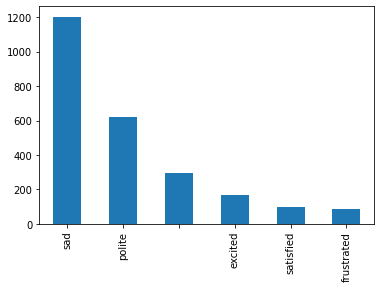

In [76]:
def analyze_post_comment_relationship_by_issue_poster_role(df_analyze_posts):
        role = "CONTRIBUTOR"
        data_contributor = pd.DataFrame(columns=df_analyze_posts.columns)
        data_non_contributor = pd.DataFrame(columns=df_analyze_posts.columns)
        data_commit_contributor = pd.DataFrame(columns=df_analyze_posts.columns)
        data_commit_non_contributor = pd.DataFrame(columns=df_analyze_posts.columns)
        data_contributor = df_analyze_posts.loc[df_analyze_posts['PosterRole'] == role]
        data_non_contributor = df_analyze_posts.loc[df_analyze_posts['PosterRole'] != role]
        for i, row in data_contributor.iterrows():
            if (row['HasCommit'] == 'TRUE'):
                data_commit_contributor.loc[i] = row
        for i, row in data_non_contributor.iterrows():
            if (row['HasCommit'] == 'TRUE'):
                data_commit_non_contributor.loc[i] = row
        
        if data_contributor.count()[0] > 0:
            printmd('\n## For issues posted by '+ role)
            analyze_post_comment_relationship(data_contributor)
            if data_commit_contributor.count()[0] > 0:  
                print('======================')
                analyze_emotion_commit_relationship(data_commit_contributor)
                print('======================')
                                                           
        if data_non_contributor.count()[0] > 0:
            printmd('\n## For issues posted by NON_'+role)
            analyze_post_comment_relationship(data_non_contributor)
            if data_commit_non_contributor.count()[0] > 0:  
                print('======================')
                analyze_emotion_commit_relationship(data_commit_non_contributor)
                print('======================')
            
printmd('# Analysis by issue poster role:')
print('\n')
print('##############################################################')
print('##############################################################')
printmd('# PyTorch Results')
analyze_post_comment_relationship_by_issue_poster_role(PyTorch_posts_wcomments)

print('\n')
print('##############################################################')
print('##############################################################')
printmd('# TensorFlow Results')
analyze_post_comment_relationship_by_issue_poster_role(Tensorflow_posts_wcomments)

print('\n')
print('##############################################################')
print('##############################################################')
printmd('# SkLearn Results')
analyze_post_comment_relationship_by_issue_poster_role(SkLearn_posts_wcomments)

print('\n')
print('##############################################################')
print('##############################################################')
printmd('# All-together Results')
analyze_post_comment_relationship_by_issue_poster_role(All_posts_wcomments)

**Separate by issue type**

# Analysis by issue type (bugs vs features):

Labels were selected conservatively to ensure high precision but we tolorate low recall.


##############################################################
##############################################################


# PyTorch Results


## For issues with labels: ['high priority', 'critical', 'needs reproduction', 'topic: assert failure', 'topic: crash', 'topic: deadlock', 'topic: dependency bug', 'topic: error checking'] (951 issues)

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,18,1,23,6,139,1
neutral,290,10,56,8,209,2
positive,48,14,19,18,61,6


chi2 = 188.924  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.311</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
comment_dominant_sentiment,,,,,,
negative,3,2,4,5,27,2
neutral,59,33,45,130,409,27
positive,14,20,10,69,45,25


chi2 = 94.146  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:blue">cramers_v  = 0.213</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
Sentiment,,,
negative,7,148,33
neutral,25,434,116
positive,11,121,34


chi2 = 2.823  p = 0.58787  dof = 4

cramers_v = 0.0


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,14,12,14,49,90,9
neutral,52,39,33,123,291,37
positive,10,4,12,32,100,8


chi2 = 12.81  p = 0.2345  dof = 10

cramers_v = 0.039


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
post_dominant_tone_conf,,,
,18,271,67
excited,3,16,6
frustrated,5,78,15
polite,1,24,7
sad,16,308,85
satisfied,0,6,3


chi2 = 7.418  p = 0.68546  dof = 10

cramers_v = 0.0


#### Post tone <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
post_dominant_tone_conf,,,,,,
,32,18,25,83,178,20
excited,2,0,1,7,14,1
frustrated,3,4,11,22,49,9
polite,1,4,1,7,15,4
sad,36,29,20,85,219,20
satisfied,2,0,1,0,6,0


chi2 = 29.216  p = 0.25498  dof = 25

cramers_v = 0.03


#### Post sentiment <-> Time to first comment

H = 1.195  p = 0.55023  eta2 = -0.001

#### Post tone <-> Time to first comment

H = 1.125  p = 0.95183  eta2 = -0.004

#### Comment sentiment <-> Time to first comment

H = 2.513  p = 0.28458  eta2 = 0.001

#### Comment tone <-> Time to first comment

H = 16.137  <span style="color:red">p = 0.0064641768</span>  eta2 = 0.012

,,excited,frustrated,polite,sad,satisfied
,-1.000000,1.000000,0.262868,0.008139,0.008139,1.0
excited,1.000000,-1.000000,1.000000,0.693354,0.924155,1.0
frustrated,0.262868,1.000000,-1.000000,1.000000,1.000000,1.0
polite,0.008139,0.693354,1.000000,-1.000000,1.000000,1.0
sad,0.008139,0.924155,1.000000,1.000000,-1.000000,1.0
satisfied,1.000000,1.000000,1.000000,1.000000,1.000000,-1.0


comment_dominant_tone_freq
              1.461740e+06
excited       1.045182e+06
frustrated    2.489867e+05
polite        4.078119e+05
sad           8.382317e+05
satisfied     1.858291e+06
Name: time_to_first_comment, dtype: float64

#### Post sentiment <-> Number of comments

H = 13.34  <span style="color:red">p = 0.0012681873</span>  eta2 = 0.012

,negative,neutral,positive
negative,-1.000000,0.164712,0.173438
neutral,0.164712,-1.000000,0.001071
positive,0.173438,0.001071,-1.000000


Sentiment
negative    8.297872
neutral     6.391304
positive    8.162651
Name: NumberOfComments, dtype: float64

#### Post tone <-> Number of comments

H = 4.895  p = 0.42878  eta2 = -0.0

#### Comment sentiment <-> Number of comments

H = 47.88  <span style="color:red">p = 0.0</span>  eta2 = 0.05

,negative,neutral,positive
negative,-1.000000,2.782302e-06,6.523933e-02
neutral,0.000003,-1.000000e+00,1.535427e-07
positive,0.065239,1.535427e-07,-1.000000e+00


comment_dominant_sentiment
negative    3.116279
neutral     7.981508
positive    4.617486
Name: NumberOfComments, dtype: float64

#### Comment tone <-> Number of comments

H = 189.308  <span style="color:red">p = 0.0</span>  eta2 = 0.2

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,1.425802e-10,1.425802e-10,4.836576e-22,1.757434e-30,2.448061e-14
excited,1.425802e-10,-1.000000e+00,1.000000e+00,1.224404e-01,4.179601e-06,1.224404e-01
frustrated,1.425802e-10,1.000000e+00,-1.000000e+00,1.224404e-01,6.099158e-07,1.224404e-01
polite,4.836576e-22,1.224404e-01,1.224404e-01,-1.000000e+00,4.087855e-06,1.000000e+00
sad,1.757434e-30,4.179601e-06,6.099158e-07,4.087855e-06,-1.000000e+00,3.520160e-02
satisfied,2.448061e-14,1.224404e-01,1.224404e-01,1.000000e+00,3.520160e-02,-1.000000e+00


comment_dominant_tone_freq
              1.526316
excited       4.363636
frustrated    4.016949
polite        5.946078
sad           9.338877
satisfied     5.407407
Name: NumberOfComments, dtype: float64

#### Post sentiment <-> Time to first commit

H = 7.72  <span style="color:red">p = 0.0210631728</span>  eta2 = 0.017

,negative,neutral,positive
negative,-1.000000,0.930152,0.139165
neutral,0.930152,-1.000000,0.013949
positive,0.139165,0.013949,-1.000000


Sentiment
negative    2.021063e+07
neutral     1.725201e+07
positive    8.752585e+06
Name: time_to_first_commit, dtype: float64

#### Post tone <-> Time to first commit

H = 3.71  p = 0.59193  eta2 = -0.004

#### Comment sentiment <-> Time to first commit

H = 4.136  p = 0.12643  eta2 = 0.006

#### Comment tone <-> Time to first commit

H = 2.57  p = 0.76593  eta2 = -0.007

#### Post sentiment <-> Time to last commit

H = 5.846  p = 0.05378  eta2 = 0.011

#### Post tone <-> Time to last commit

H = 6.097  p = 0.29687  eta2 = 0.003

#### Comment sentiment <-> Time to last commit

H = 3.363  p = 0.18609  eta2 = 0.004

#### Comment tone <-> Time to last commit

H = 5.698  p = 0.33676  eta2 = 0.002


## For issues with labels: ['feature', 'proposal accepted', 'enhancement'] (201 issues)

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,2,0,2,0,2,0
neutral,54,9,9,3,31,1
positive,26,27,7,8,15,0


chi2 = 31.607  <span style="color:red">p = 0.00047</span>  dof = 10

<span style="color:blue">cramers_v  = 0.236</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
comment_dominant_sentiment,,,,,,
negative,1,0,2,0,1,0
neutral,21,4,9,29,76,1
positive,1,6,2,19,17,7


chi2 = 48.18  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.313</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
Sentiment,,,
negative,0,5,1
neutral,4,78,25
positive,0,57,26


chi2 = 4.91  p = 0.29664  dof = 4

cramers_v = 0.048


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,0,0,0,2,4,0
neutral,13,8,11,20,51,4
positive,10,2,2,26,39,4


chi2 = 12.257  p = 0.26819  dof = 10

cramers_v = 0.075


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
post_dominant_tone_conf,,,
,3,58,21
excited,0,28,8
frustrated,1,9,8
polite,0,9,2
sad,0,35,13
satisfied,0,1,0


chi2 = 8.777  p = 0.55342  dof = 10

cramers_v = 0.0


#### Post tone <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
post_dominant_tone_conf,,,,,,
,10,4,7,18,40,3
excited,3,1,0,10,22,0
frustrated,2,0,2,6,6,2
polite,3,1,1,4,2,0
sad,5,4,3,10,23,3
satisfied,0,0,0,0,1,0


chi2 = 20.597  p = 0.71486  dof = 25

cramers_v = 0.0


#### Post sentiment <-> Time to first comment

H = 0.601  p = 0.74049  eta2 = -0.007

#### Post tone <-> Time to first comment

H = 2.892  p = 0.71664  eta2 = -0.011

#### Comment sentiment <-> Time to first comment

H = 0.069  p = 0.96596  eta2 = -0.01

#### Comment tone <-> Time to first comment

H = 5.996  p = 0.3066  eta2 = 0.005

#### Post sentiment <-> Number of comments

H = 6.875  <span style="color:red">p = 0.0321523542</span>  eta2 = 0.025

,negative,neutral,positive
negative,-1.000000,0.047704,0.158609
neutral,0.047704,-1.000000,0.158609
positive,0.158609,0.158609,-1.000000


Sentiment
negative    15.000000
neutral      5.009346
positive    15.626506
Name: NumberOfComments, dtype: float64

#### Post tone <-> Number of comments

H = 6.263  p = 0.28143  eta2 = 0.007

#### Comment sentiment <-> Number of comments

H = 7.534  <span style="color:red">p = 0.0231243891</span>  eta2 = 0.029

,negative,neutral,positive
negative,-1.000000,0.184802,0.242611
neutral,0.184802,-1.000000,0.070248
positive,0.242611,0.070248,-1.000000


comment_dominant_sentiment
negative     2.250000
neutral     12.064286
positive     4.326923
Name: NumberOfComments, dtype: float64

#### Comment tone <-> Number of comments

H = 55.237  <span style="color:red">p = 1e-10</span>  eta2 = 0.264

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,0.131631,1.000000,0.000028,7.003202e-08,0.510069
excited,1.316315e-01,-1.000000,1.000000,1.000000,1.427818e-01,1.000000
frustrated,1.000000e+00,1.000000,-1.000000,0.028505,7.658890e-04,1.000000
polite,2.809057e-05,1.000000,0.028505,-1.000000,4.649269e-02,0.582356
sad,7.003202e-08,0.142782,0.000766,0.046493,-1.000000e+00,0.131631
satisfied,5.100690e-01,1.000000,1.000000,0.582356,1.316315e-01,-1.000000


comment_dominant_tone_freq
               1.652174
excited        3.300000
frustrated     2.230769
polite         4.875000
sad           16.585106
satisfied      3.750000
Name: NumberOfComments, dtype: float64

#### Post sentiment <-> Time to first commit

H = 0.04  p = 0.98003  eta2 = -0.032

#### Post tone <-> Time to first commit

H = 9.389  p = 0.05207  eta2 = 0.09

#### Comment sentiment <-> Time to first commit

H = 11.468  <span style="color:red">p = 0.000708016</span>  eta2 = 0.166

,neutral,positive
neutral,-1.000000,0.000727
positive,0.000727,-1.000000


comment_dominant_sentiment
neutral     1.378345e+07
positive    3.845078e+06
Name: time_to_first_commit, dtype: float64

#### Comment tone <-> Time to first commit

H = 6.884  p = 0.2294  eta2 = 0.032

#### Post sentiment <-> Time to last commit

H = 0.028  p = 0.98603  eta2 = -0.032

#### Post tone <-> Time to last commit

H = 9.598  <span style="color:red">p = 0.0477744543</span>  eta2 = 0.093

,,excited,frustrated,polite,sad
,-1.000000,0.268237,1.000000,0.397227,1.000000
excited,0.268237,-1.000000,0.650889,1.000000,0.650889
frustrated,1.000000,0.650889,-1.000000,0.650889,1.000000
polite,0.397227,1.000000,0.650889,-1.000000,0.650889
sad,1.000000,0.650889,1.000000,0.650889,-1.000000


post_dominant_tone_conf
              8.372451e+06
excited       2.731948e+07
frustrated    4.269851e+06
polite        3.763017e+07
sad           1.095810e+07
Name: time_to_last_commit, dtype: float64

#### Comment sentiment <-> Time to last commit

H = 11.468  <span style="color:red">p = 0.000708016</span>  eta2 = 0.166

,neutral,positive
neutral,-1.000000,0.000727
positive,0.000727,-1.000000


comment_dominant_sentiment
neutral     1.430485e+07
positive    5.091134e+06
Name: time_to_last_commit, dtype: float64

#### Comment tone <-> Time to last commit

H = 6.943  p = 0.22488  eta2 = 0.033

# All the Bug and Features labels in PyTorch


## For issues with labels: ['high priority', 'critical', 'needs reproduction', 'topic: assert failure', 'topic: crash', 'topic: deadlock', 'topic: dependency bug', 'topic: error checking', 'feature', 'proposal accepted', 'enhancement'] (1127 issues)

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,20,1,24,6,141,1
neutral,335,19,64,11,235,3
positive,73,37,25,26,73,6


chi2 = 239.251  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.323</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
comment_dominant_sentiment,,,,,,
negative,4,2,6,5,27,2
neutral,80,37,53,158,466,28
positive,15,26,11,88,61,31


chi2 = 117.393  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:blue">cramers_v  = 0.221</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
Sentiment,,,
negative,7,152,34
neutral,28,499,140
positive,11,171,58


chi2 = 3.228  p = 0.52047  dof = 4

cramers_v = 0.0


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,14,12,14,51,93,9
neutral,65,47,42,142,330,41
positive,20,6,14,58,131,11


chi2 = 11.963  p = 0.28757  dof = 10

cramers_v = 0.03


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
post_dominant_tone_conf,,,
,20,321,87
excited,3,40,14
frustrated,6,85,22
polite,1,33,9
sad,16,336,97
satisfied,0,7,3


chi2 = 3.171  p = 0.97712  dof = 10

cramers_v = 0.0


#### Post tone <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
post_dominant_tone_conf,,,,,,
,42,22,31,100,210,23
excited,5,1,1,17,32,1
frustrated,5,4,12,28,54,10
polite,4,5,2,11,17,4
sad,41,33,23,95,234,23
satisfied,2,0,1,0,7,0


chi2 = 31.819  p = 0.16331  dof = 25

cramers_v = 0.035


#### Post sentiment <-> Time to first comment

H = 1.532  p = 0.46488  eta2 = -0.0

#### Post tone <-> Time to first comment

H = 3.761  p = 0.58425  eta2 = -0.001

#### Comment sentiment <-> Time to first comment

H = 2.432  p = 0.29645  eta2 = 0.0

#### Comment tone <-> Time to first comment

H = 21.656  <span style="color:red">p = 0.0006087151</span>  eta2 = 0.015

,,excited,frustrated,polite,sad,satisfied
,-1.000000,1.000000,0.048587,0.000862,0.000489,0.661067
excited,1.000000,-1.000000,1.000000,0.661067,0.785512,1.000000
frustrated,0.048587,1.000000,-1.000000,1.000000,1.000000,1.000000
polite,0.000862,0.661067,1.000000,-1.000000,1.000000,1.000000
sad,0.000489,0.785512,1.000000,1.000000,-1.000000,1.000000
satisfied,0.661067,1.000000,1.000000,1.000000,1.000000,-1.000000


comment_dominant_tone_freq
              3.153973e+06
excited       1.052710e+06
frustrated    4.970218e+05
polite        5.351689e+05
sad           1.015377e+06
satisfied     1.991012e+06
Name: time_to_first_comment, dtype: float64

#### Post sentiment <-> Number of comments

H = 14.087  <span style="color:red">p = 0.0008730288</span>  eta2 = 0.011

,negative,neutral,positive
negative,-1.000000,0.025437,0.742877
neutral,0.025437,-1.000000,0.002502
positive,0.742877,0.002502,-1.000000


Sentiment
negative     8.347150
neutral      6.133433
positive    10.658333
Name: NumberOfComments, dtype: float64

#### Post tone <-> Number of comments

H = 4.902  p = 0.42797  eta2 = -0.0

#### Comment sentiment <-> Number of comments

H = 50.738  <span style="color:red">p = 0.0</span>  eta2 = 0.044

,negative,neutral,positive
negative,-1.000000,1.610449e-06,2.964362e-02
neutral,0.000002,-1.000000e+00,5.663255e-08
positive,0.029644,5.663255e-08,-1.000000e+00


comment_dominant_sentiment
negative    3.000000
neutral     8.583942
positive    4.594828
Name: NumberOfComments, dtype: float64

#### Comment tone <-> Number of comments

H = 234.729  <span style="color:red">p = 0.0</span>  eta2 = 0.21

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,5.099525e-12,1.154792e-10,4.526744e-27,1.037949e-37,7.632012e-16
excited,5.099525e-12,-1.000000e+00,1.000000e+00,6.900906e-02,3.463267e-07,1.140259e-01
frustrated,1.154792e-10,1.000000e+00,-1.000000e+00,1.018370e-02,2.940092e-09,4.477123e-02
polite,4.526744e-27,6.900906e-02,1.018370e-02,-1.000000e+00,1.435871e-07,1.000000e+00
sad,1.037949e-37,3.463267e-07,2.940092e-09,1.435871e-07,-1.000000e+00,9.880665e-03
satisfied,7.632012e-16,1.140259e-01,4.477123e-02,1.000000e+00,9.880665e-03,-1.000000e+00


comment_dominant_tone_freq
               1.555556
excited        4.200000
frustrated     3.742857
polite         5.752988
sad           10.480144
satisfied      5.262295
Name: NumberOfComments, dtype: float64

#### Post sentiment <-> Time to first commit

H = 7.118  <span style="color:red">p = 0.0284646785</span>  eta2 = 0.013

,negative,neutral,positive
negative,-1.000000,0.94599,0.205881
neutral,0.945990,-1.00000,0.019910
positive,0.205881,0.01991,-1.000000


Sentiment
negative    1.977948e+07
neutral     1.635698e+07
positive    9.138884e+06
Name: time_to_first_commit, dtype: float64

#### Post tone <-> Time to first commit

H = 4.606  p = 0.4658  eta2 = -0.001

#### Comment sentiment <-> Time to first commit

H = 7.397  <span style="color:red">p = 0.024755364</span>  eta2 = 0.014

,negative,neutral,positive
negative,-1.000000,0.189884,0.416011
neutral,0.189884,-1.000000,0.064472
positive,0.416011,0.064472,-1.000000


comment_dominant_sentiment
negative    1.334112e+07
neutral     1.677026e+07
positive    1.195763e+07
Name: time_to_first_commit, dtype: float64

#### Comment tone <-> Time to first commit

H = 2.939  p = 0.70933  eta2 = -0.005

#### Post sentiment <-> Time to last commit

H = 5.893  p = 0.05253  eta2 = 0.01

#### Post tone <-> Time to last commit

H = 5.624  p = 0.3445  eta2 = 0.002

#### Comment sentiment <-> Time to last commit

H = 6.554  <span style="color:red">p = 0.0377352153</span>  eta2 = 0.012

,negative,neutral,positive
negative,-1.000000,0.348367,0.580681
neutral,0.348367,-1.000000,0.064851
positive,0.580681,0.064851,-1.000000


comment_dominant_sentiment
negative    1.732012e+07
neutral     1.834130e+07
positive    1.454111e+07
Name: time_to_last_commit, dtype: float64

#### Comment tone <-> Time to last commit

H = 5.742  p = 0.33217  eta2 = 0.002



##############################################################
##############################################################


# TensorFlow Results


## For issues with labels: ['type:bug', 'type:docs-bug'] (2331 issues)

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,25,6,36,14,169,0
neutral,1285,17,54,33,235,0
positive,90,39,44,63,184,2


chi2 = 880.369  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.436</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
comment_dominant_sentiment,,,,,,
negative,4,2,2,5,27,1
neutral,79,72,32,316,502,29
positive,29,134,10,760,212,80


chi2 = 392.099  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.289</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
Sentiment,,,
negative,3,130,117
neutral,29,658,937
positive,9,242,171


chi2 = 45.878  <span style="color:red">p = 0.0</span>  dof = 4

cramers_v = 0.096


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,13,21,4,99,99,14
neutral,83,160,30,803,459,89
positive,16,27,10,179,183,7


chi2 = 52.204  <span style="color:red">p = 0.0</span>  dof = 10

cramers_v = 0.096


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
post_dominant_tone_conf,,,
,30,543,827
excited,1,34,27
frustrated,4,73,57
polite,0,63,47
sad,6,317,265
satisfied,0,0,2


chi2 = 60.43  <span style="color:red">p = 0.0</span>  dof = 10

cramers_v = 0.105


#### Post tone <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
post_dominant_tone_conf,,,,,,
,65,146,26,691,391,81
excited,5,4,2,23,26,2
frustrated,7,8,2,63,52,2
polite,9,4,3,48,45,1
sad,26,46,11,255,226,24
satisfied,0,0,0,1,1,0


chi2 = 51.628  <span style="color:red">p = 0.00134</span>  dof = 25

cramers_v = 0.048


#### Post sentiment <-> Time to first comment

H = 20.85  <span style="color:red">p = 2.96746e-05</span>  eta2 = 0.008

,negative,neutral,positive
negative,-1.000000,0.195715,0.195715
neutral,0.195715,-1.000000,0.000021
positive,0.195715,0.000021,-1.000000


Sentiment
negative    1.123251e+06
neutral     6.562389e+05
positive    7.182069e+05
Name: time_to_first_comment, dtype: float64

#### Post tone <-> Time to first comment

H = 36.435  <span style="color:red">p = 7.773e-07</span>  eta2 = 0.014

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,1.000000,0.416702,1.0,8.812807e-08,1.0
excited,1.000000e+00,-1.000000,1.000000,1.0,3.529946e-01,1.0
frustrated,4.167021e-01,1.000000,-1.000000,1.0,1.000000e+00,1.0
polite,1.000000e+00,1.000000,1.000000,-1.0,1.000000e+00,1.0
sad,8.812807e-08,0.352995,1.000000,1.0,-1.000000e+00,1.0
satisfied,1.000000e+00,1.000000,1.000000,1.0,1.000000e+00,-1.0


post_dominant_tone_conf
              7.042243e+05
excited       1.721703e+06
frustrated    7.977775e+05
polite        7.457979e+05
sad           6.244721e+05
satisfied     4.194520e+05
Name: time_to_first_comment, dtype: float64

#### Comment sentiment <-> Time to first comment

H = 16.515  <span style="color:red">p = 0.0002593457</span>  eta2 = 0.006

,negative,neutral,positive
negative,-1.000000,0.017701,0.079477
neutral,0.017701,-1.000000,0.001748
positive,0.079477,0.001748,-1.000000


comment_dominant_sentiment
negative    2.079853e+06
neutral     6.840432e+05
positive    7.018691e+05
Name: time_to_first_comment, dtype: float64

#### Comment tone <-> Time to first comment

H = 5.952  p = 0.31091  eta2 = 0.0

#### Post sentiment <-> Number of comments

H = 11.518  <span style="color:red">p = 0.0031544027</span>  eta2 = 0.004

,negative,neutral,positive
negative,-1.000000,0.441137,0.441137
neutral,0.441137,-1.000000,0.002482
positive,0.441137,0.002482,-1.000000


Sentiment
negative    8.732000
neutral     7.650246
positive    9.447867
Name: NumberOfComments, dtype: float64

#### Post tone <-> Number of comments

H = 19.51  <span style="color:red">p = 0.0015441526</span>  eta2 = 0.006

,,excited,frustrated,polite,sad,satisfied
,-1.000000,1.0,1.0,1.0,0.000744,1.0
excited,1.000000,-1.0,1.0,1.0,1.000000,1.0
frustrated,1.000000,1.0,-1.0,1.0,1.000000,1.0
polite,1.000000,1.0,1.0,-1.0,1.000000,1.0
sad,0.000744,1.0,1.0,1.0,-1.000000,1.0
satisfied,1.000000,1.0,1.0,1.0,1.000000,-1.0


post_dominant_tone_conf
               7.591429
excited        8.274194
frustrated     8.992537
polite         8.118182
sad            9.069728
satisfied     11.000000
Name: NumberOfComments, dtype: float64

#### Comment sentiment <-> Number of comments

H = 50.937  <span style="color:red">p = 0.0</span>  eta2 = 0.021

,negative,neutral,positive
negative,-1.000000e+00,5.198450e-09,1.558828e-08
neutral,5.198450e-09,-1.000000e+00,6.064334e-05
positive,1.558828e-08,6.064334e-05,-1.000000e+00


comment_dominant_sentiment
negative    3.536585
neutral     9.251456
positive    7.281633
Name: NumberOfComments, dtype: float64

#### Comment tone <-> Number of comments

H = 309.794  <span style="color:red">p = 0.0</span>  eta2 = 0.133

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,1.286058e-26,1.337076e-06,3.731625e-45,4.661941e-42,5.499910e-18
excited,1.286058e-26,-1.000000e+00,2.263438e-02,1.356764e-10,3.688895e-14,8.246976e-01
frustrated,1.337076e-06,2.263438e-02,-1.000000e+00,4.535157e-07,8.959020e-08,3.421924e-02
polite,3.731625e-45,1.356764e-10,4.535157e-07,-1.000000e+00,4.154203e-03,1.448299e-05
sad,4.661941e-42,3.688895e-14,8.959020e-08,4.154203e-03,-1.000000e+00,1.115506e-07
satisfied,5.499910e-18,8.246976e-01,3.421924e-02,1.448299e-05,1.115506e-07,-1.000000e+00


comment_dominant_tone_freq
               2.392857
excited        5.389423
frustrated     4.318182
polite         8.177613
sad           10.214575
satisfied      5.509091
Name: NumberOfComments, dtype: float64

#### Post sentiment <-> Time to first commit

H = 4.818  p = 0.08989  eta2 = 0.011

#### Post tone <-> Time to first commit

H = 4.251  p = 0.3731  eta2 = 0.001

#### Comment sentiment <-> Time to first commit

H = 1.381  p = 0.50124  eta2 = -0.002

#### Comment tone <-> Time to first commit

H = 3.906  p = 0.56305  eta2 = -0.004

#### Post sentiment <-> Time to last commit

H = 5.611  p = 0.06049  eta2 = 0.014

#### Post tone <-> Time to last commit

H = 4.952  p = 0.29222  eta2 = 0.004

#### Comment sentiment <-> Time to last commit

H = 1.458  p = 0.48231  eta2 = -0.002

#### Comment tone <-> Time to last commit

H = 5.217  p = 0.38994  eta2 = 0.001


## For issues with labels: ['type:feature'] (1184 issues)

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,23,6,12,6,59,0
neutral,384,43,35,51,93,2
positive,134,83,35,86,101,15


chi2 = 228.722  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.306</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
comment_dominant_sentiment,,,,,,
negative,2,2,3,2,33,0
neutral,46,32,26,183,355,26
positive,9,30,11,265,104,39


chi2 = 183.282  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.273</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
Sentiment,,,
negative,2,68,36
neutral,21,329,258
positive,19,271,164


chi2 = 7.195  p = 0.12594  dof = 4

cramers_v = 0.037


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,7,6,2,37,49,5
neutral,25,41,21,251,237,33
positive,25,17,17,162,206,27


chi2 = 12.666  p = 0.24294  dof = 10

cramers_v = 0.034


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
post_dominant_tone_conf,,,
,21,280,240
excited,5,85,42
frustrated,2,47,33
polite,2,92,49
sad,12,159,82
satisfied,0,5,12


chi2 = 26.542  <span style="color:red">p = 0.00308</span>  dof = 10

cramers_v = 0.084


#### Post tone <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
post_dominant_tone_conf,,,,,,
,27,31,22,223,210,28
excited,7,5,2,46,64,8
frustrated,8,2,3,31,34,4
polite,3,7,5,52,66,10
sad,11,18,7,92,110,15
satisfied,1,1,1,6,8,0


chi2 = 19.928  p = 0.7506  dof = 25

cramers_v = 0.0


#### Post sentiment <-> Time to first comment

H = 0.274  p = 0.87208  eta2 = -0.001

#### Post tone <-> Time to first comment

H = 8.303  p = 0.1403  eta2 = 0.003

#### Comment sentiment <-> Time to first comment

H = 15.199  <span style="color:red">p = 0.0005006429</span>  eta2 = 0.011

,negative,neutral,positive
negative,-1.000000,0.007208,0.046943
neutral,0.007208,-1.000000,0.008394
positive,0.046943,0.008394,-1.000000


comment_dominant_sentiment
negative    3.369784e+06
neutral     1.261153e+06
positive    1.226585e+06
Name: time_to_first_comment, dtype: float64

#### Comment tone <-> Time to first comment

H = 5.432  p = 0.36548  eta2 = 0.0

#### Post sentiment <-> Number of comments

H = 9.73  <span style="color:red">p = 0.0077126528</span>  eta2 = 0.007

,negative,neutral,positive
negative,-1.000000,0.044245,0.528926
neutral,0.044245,-1.000000,0.024816
positive,0.528926,0.024816,-1.000000


Sentiment
negative    8.688679
neutral     7.840461
positive    9.220264
Name: NumberOfComments, dtype: float64

#### Post tone <-> Number of comments

H = 32.423  <span style="color:red">p = 4.8984e-06</span>  eta2 = 0.024

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.026888,0.490552,0.000020,0.009217,1.0
excited,0.026888,-1.000000,1.000000,1.000000,1.000000,1.0
frustrated,0.490552,1.000000,-1.000000,1.000000,1.000000,1.0
polite,0.000020,1.000000,1.000000,-1.000000,0.381219,1.0
sad,0.009217,1.000000,1.000000,0.381219,-1.000000,1.0
satisfied,1.000000,1.000000,1.000000,1.000000,1.000000,-1.0


post_dominant_tone_conf
               7.245841
excited        9.734848
frustrated     8.878049
polite        10.860140
sad            8.948617
satisfied      7.294118
Name: NumberOfComments, dtype: float64

#### Comment sentiment <-> Number of comments

H = 59.549  <span style="color:red">p = 0.0</span>  eta2 = 0.049

,negative,neutral,positive
negative,-1.000000e+00,3.849787e-08,6.533318e-04
neutral,3.849787e-08,-1.000000e+00,4.134008e-09
positive,6.533318e-04,4.134008e-09,-1.000000e+00


comment_dominant_sentiment
negative    3.500000
neutral     9.986527
positive    6.672489
Name: NumberOfComments, dtype: float64

#### Comment tone <-> Number of comments

H = 143.178  <span style="color:red">p = 0.0</span>  eta2 = 0.119

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,4.877543e-08,7.716598e-07,1.983252e-19,5.572083e-21,2.014095e-05
excited,4.877543e-08,-1.000000e+00,8.981667e-01,1.672375e-02,4.634019e-04,6.221590e-01
frustrated,7.716598e-07,8.981667e-01,-1.000000e+00,3.566861e-02,1.890360e-03,6.221590e-01
polite,1.983252e-19,1.672375e-02,3.566861e-02,-1.000000e+00,3.566861e-02,1.282602e-05
sad,5.572083e-21,4.634019e-04,1.890360e-03,3.566861e-02,-1.000000e+00,3.985221e-08
satisfied,2.014095e-05,6.221590e-01,6.221590e-01,1.282602e-05,3.985221e-08,-1.000000e+00


comment_dominant_tone_freq
               2.052632
excited        6.187500
frustrated     4.750000
polite         8.504444
sad           10.331301
satisfied      4.015385
Name: NumberOfComments, dtype: float64

#### Post sentiment <-> Time to first commit

H = 7.74  <span style="color:red">p = 0.02085794</span>  eta2 = 0.068

,negative,neutral,positive
negative,-1.000000,0.024223,0.073378
neutral,0.024223,-1.000000,0.252061
positive,0.073378,0.252061,-1.000000


Sentiment
negative    1.361154e+06
neutral     8.282316e+06
positive    4.617294e+06
Name: time_to_first_commit, dtype: float64

#### Post tone <-> Time to first commit

H = 9.093  p = 0.1054  eta2 = 0.05

#### Comment sentiment <-> Time to first commit

H = 1.125  p = 0.56964  eta2 = -0.01

#### Comment tone <-> Time to first commit

H = 6.735  p = 0.24109  eta2 = 0.021

#### Post sentiment <-> Time to last commit

H = 6.021  <span style="color:red">p = 0.0492582295</span>  eta2 = 0.047

,negative,neutral,positive
negative,-1.000000,0.059321,0.130535
neutral,0.059321,-1.000000,0.310227
positive,0.130535,0.310227,-1.000000


Sentiment
negative    2.279567e+06
neutral     8.445521e+06
positive    4.961347e+06
Name: time_to_last_commit, dtype: float64

#### Post tone <-> Time to last commit

H = 8.452  p = 0.13304  eta2 = 0.042

#### Comment sentiment <-> Time to last commit

H = 1.237  p = 0.53868  eta2 = -0.009

#### Comment tone <-> Time to last commit

H = 6.641  p = 0.2487  eta2 = 0.02

# All the Bug and Features labels in Tensorflow


## For issues with labels: ['type:feature', 'type:bug', 'type:docs-bug'] (3503 issues)

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,48,11,47,20,228,0
neutral,1667,60,88,84,324,2
positive,224,122,78,149,283,17


chi2 = 1143.416  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.405</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
comment_dominant_sentiment,,,,,,
negative,6,4,5,7,60,1
neutral,125,103,58,498,852,55
positive,36,164,21,1023,316,118


chi2 = 593.343  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.291</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
Sentiment,,,
negative,5,197,152
neutral,50,983,1192
positive,28,511,334


chi2 = 66.826  <span style="color:red">p = 0.0</span>  dof = 4

cramers_v = 0.095


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,19,27,6,135,148,19
neutral,107,201,51,1053,692,121
positive,41,43,27,340,388,34


chi2 = 68.316  <span style="color:red">p = 0.0</span>  dof = 10

cramers_v = 0.092


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
post_dominant_tone_conf,,,
,51,822,1066
excited,6,119,68
frustrated,6,119,88
polite,2,155,96
sad,18,471,346
satisfied,0,5,14


chi2 = 91.955  <span style="color:red">p = 0.0</span>  dof = 10

cramers_v = 0.109


#### Post tone <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
post_dominant_tone_conf,,,,,,
,92,177,48,913,600,109
excited,11,9,4,69,90,10
frustrated,14,10,5,92,86,6
polite,12,11,8,100,111,11
sad,37,63,18,347,332,38
satisfied,1,1,1,7,9,0


chi2 = 61.02  <span style="color:red">p = 8e-05</span>  dof = 25

cramers_v = 0.046


#### Post sentiment <-> Time to first comment

H = 12.865  <span style="color:red">p = 0.0016085875</span>  eta2 = 0.003

,negative,neutral,positive
negative,-1.000000,0.349391,0.368951
neutral,0.349391,-1.000000,0.001232
positive,0.368951,0.001232,-1.000000


Sentiment
negative    1.407335e+06
neutral     7.592345e+05
positive    1.140567e+06
Name: time_to_first_comment, dtype: float64

#### Post tone <-> Time to first comment

H = 41.544  <span style="color:red">p = 7.28e-08</span>  eta2 = 0.011

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,1.000000,0.228846,0.257837,5.062685e-08,1.000000
excited,1.000000e+00,-1.000000,1.000000,1.000000,8.280821e-02,1.000000
frustrated,2.288459e-01,1.000000,-1.000000,1.000000,1.000000e+00,0.554073
polite,2.578372e-01,1.000000,1.000000,-1.000000,1.000000e+00,0.626600
sad,5.062685e-08,0.082808,1.000000,1.000000,-1.000000e+00,0.257837
satisfied,1.000000e+00,1.000000,0.554073,0.626600,2.578372e-01,-1.000000


post_dominant_tone_conf
              8.862059e+05
excited       1.254333e+06
frustrated    8.435279e+05
polite        1.213334e+06
sad           8.433322e+05
satisfied     1.681150e+06
Name: time_to_first_comment, dtype: float64

#### Comment sentiment <-> Time to first comment

H = 32.351  <span style="color:red">p = 9.44e-08</span>  eta2 = 0.009

,negative,neutral,positive
negative,-1.000000,0.000106,0.004573
neutral,0.000106,-1.000000,0.000019
positive,0.004573,0.000019,-1.000000


comment_dominant_sentiment
negative    2.732589e+06
neutral     9.078191e+05
positive    8.470092e+05
Name: time_to_first_comment, dtype: float64

#### Comment tone <-> Time to first comment

H = 8.227  p = 0.14415  eta2 = 0.001

#### Post sentiment <-> Number of comments

H = 12.232  <span style="color:red">p = 0.0022071175</span>  eta2 = 0.003

,negative,neutral,positive
negative,-1.000000,0.059851,0.979441
neutral,0.059851,-1.000000,0.005502
positive,0.979441,0.005502,-1.000000


Sentiment
negative    8.734463
neutral     7.696629
positive    9.199313
Name: NumberOfComments, dtype: float64

#### Post tone <-> Number of comments

H = 32.61  <span style="color:red">p = 4.4983e-06</span>  eta2 = 0.008

,,excited,frustrated,polite,sad,satisfied
,-1.000000,1.0,1.0,0.002536,0.000014,1.0
excited,1.000000,-1.0,1.0,1.000000,1.000000,1.0
frustrated,1.000000,1.0,-1.0,1.000000,1.000000,1.0
polite,0.002536,1.0,1.0,-1.000000,1.000000,1.0
sad,0.000014,1.0,1.0,1.000000,-1.000000,1.0
satisfied,1.000000,1.0,1.0,1.000000,1.000000,-1.0


post_dominant_tone_conf
              7.486849
excited       9.295337
frustrated    8.638498
polite        9.667984
sad           8.988024
satisfied     7.684211
Name: NumberOfComments, dtype: float64

#### Comment sentiment <-> Number of comments

H = 99.537  <span style="color:red">p = 0.0</span>  eta2 = 0.028

,negative,neutral,positive
negative,-1.000000e+00,3.357468e-16,1.127361e-12
neutral,3.357468e-16,-1.000000e+00,4.739605e-10
positive,1.127361e-12,4.739605e-10,-1.000000e+00


comment_dominant_sentiment
negative    3.518072
neutral     9.520402
positive    7.066150
Name: NumberOfComments, dtype: float64

#### Comment tone <-> Number of comments

H = 437.495  <span style="color:red">p = 0.0</span>  eta2 = 0.126

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,8.709411e-35,6.827416e-13,1.744813e-63,5.651735e-61,3.622944e-21
excited,8.709411e-35,-1.000000e+00,1.188880e-01,6.569794e-12,1.083400e-16,5.666233e-01
frustrated,6.827416e-13,1.188880e-01,-1.000000e+00,7.896915e-09,1.055628e-10,5.666233e-01
polite,1.744813e-63,6.569794e-12,7.896915e-09,-1.000000e+00,3.888690e-04,7.545176e-11
sad,5.651735e-61,1.083400e-16,1.055628e-10,3.888690e-04,-1.000000e+00,1.512147e-14
satisfied,3.622944e-21,5.666233e-01,5.666233e-01,7.545176e-11,1.512147e-14,-1.000000e+00


comment_dominant_tone_freq
               2.269461
excited        5.483395
frustrated     4.523810
polite         8.213351
sad           10.252443
satisfied      4.959770
Name: NumberOfComments, dtype: float64

#### Post sentiment <-> Time to first commit

H = 10.054  <span style="color:red">p = 0.0065571144</span>  eta2 = 0.024

,negative,neutral,positive
negative,-1.000000,0.009497,0.009497
neutral,0.009497,-1.000000,0.327687
positive,0.009497,0.327687,-1.000000


Sentiment
negative    1.431060e+06
neutral     3.551927e+06
positive    3.819488e+06
Name: time_to_first_commit, dtype: float64

#### Post tone <-> Time to first commit

H = 8.208  p = 0.14516  eta2 = 0.009

#### Comment sentiment <-> Time to first commit

H = 0.344  p = 0.84219  eta2 = -0.005

#### Comment tone <-> Time to first commit

H = 6.376  p = 0.27129  eta2 = 0.004

#### Post sentiment <-> Time to last commit

H = 10.932  <span style="color:red">p = 0.0042281694</span>  eta2 = 0.026

,negative,neutral,positive
negative,-1.000000,0.007960,0.006528
neutral,0.007960,-1.000000,0.229309
positive,0.006528,0.229309,-1.000000


Sentiment
negative    1.679728e+06
neutral     3.622786e+06
positive    4.000602e+06
Name: time_to_last_commit, dtype: float64

#### Post tone <-> Time to last commit

H = 7.754  p = 0.1703  eta2 = 0.008

#### Comment sentiment <-> Time to last commit

H = 0.5  p = 0.77889  eta2 = -0.004

#### Comment tone <-> Time to last commit

H = 8.008  p = 0.15582  eta2 = 0.009



##############################################################
##############################################################


# SkLearn Results


## For issues with labels: ['Bug: triage', 'Bug', 'Regression'] (880 issues)

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,0,0,29,0,127,0
neutral,228,33,53,15,162,0
positive,49,27,24,17,88,6


chi2 = 212.236  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.344</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
comment_dominant_sentiment,,,,,,
negative,2,3,5,1,23,0
neutral,45,84,35,124,340,12
positive,8,42,12,39,67,16


chi2 = 52.858  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:blue">cramers_v  = 0.158</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
Sentiment,,,
negative,3,120,33
neutral,20,358,113
positive,11,162,38


chi2 = 4.651  p = 0.32499  dof = 4

cramers_v = 0.019


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,12,23,8,28,79,6
neutral,30,76,31,95,241,18
positive,13,30,13,41,110,4


chi2 = 2.971  p = 0.98209  dof = 10

cramers_v = 0.0


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
post_dominant_tone_conf,,,
,12,201,64
excited,2,43,15
frustrated,3,74,29
polite,2,21,9
sad,14,297,66
satisfied,1,4,1


chi2 = 11.146  p = 0.34623  dof = 10

cramers_v = 0.026


#### Post tone <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
post_dominant_tone_conf,,,,,,
,19,45,18,48,134,13
excited,3,6,5,9,36,1
frustrated,5,19,8,21,49,4
polite,5,7,0,7,13,0
sad,23,51,21,78,194,10
satisfied,0,1,0,1,4,0


chi2 = 20.623  p = 0.71343  dof = 25

cramers_v = 0.0


#### Post sentiment <-> Time to first comment

H = 1.785  p = 0.4096  eta2 = -0.0

#### Post tone <-> Time to first comment

H = 4.18  p = 0.52375  eta2 = -0.001

#### Comment sentiment <-> Time to first comment

H = 5.797  p = 0.05511  eta2 = 0.004

#### Comment tone <-> Time to first comment

H = 17.899  <span style="color:red">p = 0.0030756132</span>  eta2 = 0.015

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.04263,0.72143,0.174363,0.001385,0.174363
excited,0.042630,-1.00000,1.00000,1.000000,1.000000,1.000000
frustrated,0.721430,1.00000,-1.00000,1.000000,1.000000,1.000000
polite,0.174363,1.00000,1.00000,-1.000000,0.715849,1.000000
sad,0.001385,1.00000,1.00000,0.715849,-1.000000,1.000000
satisfied,0.174363,1.00000,1.00000,1.000000,1.000000,-1.000000


comment_dominant_tone_freq
              2.976778e+06
excited       7.579640e+05
frustrated    1.760838e+06
polite        1.058042e+06
sad           1.283668e+06
satisfied     6.795591e+05
Name: time_to_first_comment, dtype: float64

#### Post sentiment <-> Number of comments

H = 5.722  p = 0.05721  eta2 = 0.004

#### Post tone <-> Number of comments

H = 7.098  p = 0.21345  eta2 = 0.002

#### Comment sentiment <-> Number of comments

H = 53.172  <span style="color:red">p = 0.0</span>  eta2 = 0.06

,negative,neutral,positive
negative,-1.000000e+00,1.976259e-07,1.498928e-03
neutral,1.976259e-07,-1.000000e+00,1.671707e-07
positive,1.498928e-03,1.671707e-07,-1.000000e+00


comment_dominant_sentiment
negative     3.823529
neutral     10.082812
positive     6.228261
Name: NumberOfComments, dtype: float64

#### Comment tone <-> Number of comments

H = 119.871  <span style="color:red">p = 0.0</span>  eta2 = 0.135

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,1.289068e-13,7.204177e-09,5.287034e-17,8.184182e-21,0.000008
excited,1.289068e-13,-1.000000e+00,3.827698e-01,5.143960e-01,1.229295e-02,0.514396
frustrated,7.204177e-09,3.827698e-01,-1.000000e+00,2.439784e-02,1.615154e-04,0.967641
polite,5.287034e-17,5.143960e-01,2.439784e-02,-1.000000e+00,2.778173e-01,0.221792
sad,8.184182e-21,1.229295e-02,1.615154e-04,2.778173e-01,-1.000000e+00,0.023870
satisfied,7.899781e-06,5.143960e-01,9.676412e-01,2.217925e-01,2.386992e-02,-1.000000


comment_dominant_tone_freq
               2.236364
excited        8.426357
frustrated     5.692308
polite         8.689024
sad           10.769767
satisfied      5.964286
Name: NumberOfComments, dtype: float64

#### Post sentiment <-> Time to first commit

H = 7.546  <span style="color:red">p = 0.0229867754</span>  eta2 = 0.044

,negative,neutral,positive
negative,-1.000000,0.563876,0.161711
neutral,0.563876,-1.000000,0.020865
positive,0.161711,0.020865,-1.000000


Sentiment
negative    4.945091e+06
neutral     6.206517e+06
positive    1.344303e+07
Name: time_to_first_commit, dtype: float64

#### Post tone <-> Time to first commit

H = 10.041  <span style="color:red">p = 0.0397490059</span>  eta2 = 0.048

,,excited,frustrated,polite,sad
,-1.000000,0.042196,1.000000,1.000000,1.000000
excited,0.042196,-1.000000,0.404495,0.431947,0.061156
frustrated,1.000000,0.404495,-1.000000,1.000000,1.000000
polite,1.000000,0.431947,1.000000,-1.000000,1.000000
sad,1.000000,0.061156,1.000000,1.000000,-1.000000


post_dominant_tone_conf
              5.690045e+06
excited       1.166201e+07
frustrated    6.889769e+06
polite        1.579095e+06
sad           8.787807e+06
Name: time_to_first_commit, dtype: float64

#### Comment sentiment <-> Time to first commit

H = 0.529  p = 0.76756  eta2 = -0.012

#### Comment tone <-> Time to first commit

H = 7.296  p = 0.19956  eta2 = 0.019

#### Post sentiment <-> Time to last commit

H = 5.908  p = 0.05212  eta2 = 0.031

#### Post tone <-> Time to last commit

H = 9.714  <span style="color:red">p = 0.0455291411</span>  eta2 = 0.046

,,excited,frustrated,polite,sad
,-1.000000,0.044966,1.000000,1.000000,1.000000
excited,0.044966,-1.000000,0.392723,0.343681,0.109409
frustrated,1.000000,0.392723,-1.000000,1.000000,1.000000
polite,1.000000,0.343681,1.000000,-1.000000,1.000000
sad,1.000000,0.109409,1.000000,1.000000,-1.000000


post_dominant_tone_conf
              6.071425e+06
excited       1.367096e+07
frustrated    7.534456e+06
polite        1.579095e+06
sad           9.578557e+06
Name: time_to_last_commit, dtype: float64

#### Comment sentiment <-> Time to last commit

H = 0.564  p = 0.75445  eta2 = -0.011

#### Comment tone <-> Time to last commit

H = 4.376  p = 0.49665  eta2 = -0.005


## For issues with labels: ['Enhancement', 'New Feature'] (436 issues)

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,0,0,7,0,22,0
neutral,125,33,25,13,46,1
positive,45,35,15,8,41,2


chi2 = 73.447  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.276</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
comment_dominant_sentiment,,,,,,
negative,0,0,0,1,7,0
neutral,21,32,16,67,185,12
positive,3,24,6,20,19,5


chi2 = 42.327  <span style="color:red">p = 1e-05</span>  dof = 10

<span style="color:blue">cramers_v  = 0.197</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
Sentiment,,,
negative,2,23,4
neutral,4,193,46
positive,2,117,27


chi2 = 4.457  p = 0.3477  dof = 4

cramers_v = 0.023


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,0,4,4,6,15,0
neutral,17,32,13,57,111,13
positive,7,20,5,25,85,4


chi2 = 14.918  p = 0.1351  dof = 10

cramers_v = 0.077


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
post_dominant_tone_conf,,,
,5,131,34
excited,1,57,10
frustrated,0,41,6
polite,0,15,6
sad,2,87,20
satisfied,0,2,1


chi2 = 6.335  p = 0.78633  dof = 10

cramers_v = 0.0


#### Post tone <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
post_dominant_tone_conf,,,,,,
,12,28,9,37,73,11
excited,2,11,3,8,43,1
frustrated,2,2,3,16,23,1
polite,1,2,1,2,13,2
sad,7,12,6,24,58,2
satisfied,0,1,0,1,1,0


chi2 = 28.578  p = 0.28194  dof = 25

cramers_v = 0.041


#### Post sentiment <-> Time to first comment

H = 5.498  p = 0.064  eta2 = 0.008

#### Post tone <-> Time to first comment

H = 10.546  p = 0.06117  eta2 = 0.013

#### Comment sentiment <-> Time to first comment

H = 1.506  p = 0.4709  eta2 = -0.001

#### Comment tone <-> Time to first comment

H = 9.403  p = 0.09401  eta2 = 0.011

#### Post sentiment <-> Number of comments

H = 3.019  p = 0.221  eta2 = 0.002

#### Post tone <-> Number of comments

H = 7.94  p = 0.15955  eta2 = 0.007

#### Comment sentiment <-> Number of comments

H = 20.343  <span style="color:red">p = 3.82412e-05</span>  eta2 = 0.044

,negative,neutral,positive
negative,-1.000000,0.194910,0.933641
neutral,0.194910,-1.000000,0.000052
positive,0.933641,0.000052,-1.000000


comment_dominant_sentiment
negative     5.500000
neutral     11.363363
positive     6.805195
Name: NumberOfComments, dtype: float64

#### Comment tone <-> Number of comments

H = 84.001  <span style="color:red">p = 0.0</span>  eta2 = 0.192

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,0.000002,0.000091,2.860790e-09,1.597444e-11,0.000190
excited,1.813647e-06,-1.000000,1.000000,1.000000e+00,5.481337e-05,1.000000
frustrated,9.128381e-05,1.000000,-1.000000,1.000000e+00,7.266721e-03,1.000000
polite,2.860790e-09,1.000000,1.000000,-1.000000e+00,7.938159e-04,1.000000
sad,1.597444e-11,0.000055,0.007267,7.938159e-04,-1.000000e+00,0.023512
satisfied,1.896566e-04,1.000000,1.000000,1.000000e+00,2.351172e-02,-1.000000


comment_dominant_tone_freq
               1.750000
excited        6.785714
frustrated     6.363636
polite         8.647727
sad           13.857820
satisfied      6.176471
Name: NumberOfComments, dtype: float64

#### Post sentiment <-> Time to first commit

H = 4.401  p = 0.11075  eta2 = 0.053

#### Post tone <-> Time to first commit

H = 2.77  p = 0.59704  eta2 = -0.029

#### Comment sentiment <-> Time to first commit

H = 0.987  p = 0.61058  eta2 = -0.023

#### Comment tone <-> Time to first commit

H = 4.87  p = 0.43191  eta2 = -0.003

#### Post sentiment <-> Time to last commit

H = 3.099  p = 0.21239  eta2 = 0.024

#### Post tone <-> Time to last commit

H = 3.02  p = 0.55441  eta2 = -0.023

#### Comment sentiment <-> Time to last commit

H = 1.531  p = 0.46504  eta2 = -0.01

#### Comment tone <-> Time to last commit

H = 4.46  p = 0.48523  eta2 = -0.013

# All the Bug and Features labels in SkLearn


## For issues with labels: ['Bug: triage', 'Bug', 'Regression', 'Enhancement', 'New Feature'] (1312 issues)

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,0,0,36,0,149,0
neutral,352,65,78,28,208,1
positive,93,62,39,25,128,8


chi2 = 295.123  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.335</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
comment_dominant_sentiment,,,,,,
negative,2,3,5,2,30,0
neutral,65,116,51,191,522,24
positive,11,66,18,59,86,21


chi2 = 79.889  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:blue">cramers_v  = 0.166</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
Sentiment,,,
negative,5,143,37
neutral,24,549,159
positive,13,277,65


chi2 = 2.049  p = 0.72668  dof = 4

cramers_v = 0.0


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,12,27,12,34,94,6
neutral,46,108,44,152,351,31
positive,20,50,18,66,193,8


chi2 = 6.294  p = 0.78999  dof = 10

cramers_v = 0.0


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
post_dominant_tone_conf,,,
,17,330,98
excited,3,99,25
frustrated,3,115,35
polite,2,36,15
sad,16,383,86
satisfied,1,6,2


chi2 = 8.982  p = 0.53378  dof = 10

cramers_v = 0.0


#### Post tone <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
post_dominant_tone_conf,,,,,,
,30,73,27,85,206,24
excited,5,17,8,17,78,2
frustrated,7,21,11,37,72,5
polite,6,9,1,9,26,2
sad,30,63,27,102,251,12
satisfied,0,2,0,2,5,0


chi2 = 27.567  p = 0.32815  dof = 25

cramers_v = 0.02


#### Post sentiment <-> Time to first comment

H = 0.726  p = 0.69568  eta2 = -0.001

#### Post tone <-> Time to first comment

H = 5.987  p = 0.3075  eta2 = 0.001

#### Comment sentiment <-> Time to first comment

H = 3.209  p = 0.20101  eta2 = 0.001

#### Comment tone <-> Time to first comment

H = 24.217  <span style="color:red">p = 0.0001971871</span>  eta2 = 0.015

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.005032,0.157362,0.003673,0.00003,0.049324
excited,0.005032,-1.000000,1.000000,1.000000,1.00000,1.000000
frustrated,0.157362,1.000000,-1.000000,1.000000,1.00000,1.000000
polite,0.003673,1.000000,1.000000,-1.000000,1.00000,1.000000
sad,0.000030,1.000000,1.000000,1.000000,-1.00000,1.000000
satisfied,0.049324,1.000000,1.000000,1.000000,1.00000,-1.000000


comment_dominant_tone_freq
              8.330050e+06
excited       3.951619e+06
frustrated    1.884763e+06
polite        2.067417e+06
sad           2.320701e+06
satisfied     1.360844e+06
Name: time_to_first_comment, dtype: float64

#### Post sentiment <-> Number of comments

H = 7.726  <span style="color:red">p = 0.0210028576</span>  eta2 = 0.005

,negative,neutral,positive
negative,-1.000000,0.067432,0.570287
neutral,0.067432,-1.000000,0.068357
positive,0.570287,0.068357,-1.000000


Sentiment
negative     9.837838
neutral      8.960383
positive    10.352113
Name: NumberOfComments, dtype: float64

#### Post tone <-> Number of comments

H = 10.362  p = 0.0656  eta2 = 0.004

#### Comment sentiment <-> Number of comments

H = 73.672  <span style="color:red">p = 0.0</span>  eta2 = 0.056

,negative,neutral,positive
negative,-1.000000e+00,5.388716e-08,6.498730e-03
neutral,5.388716e-08,-1.000000e+00,7.885076e-12
positive,6.498730e-03,7.885076e-12,-1.000000e+00


comment_dominant_sentiment
negative     4.142857
neutral     10.536636
positive     6.398467
Name: NumberOfComments, dtype: float64

#### Comment tone <-> Number of comments

H = 196.555  <span style="color:red">p = 0.0</span>  eta2 = 0.151

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,1.435377e-19,2.642570e-13,1.417844e-25,8.760229e-32,5.795994e-10
excited,1.435377e-19,-1.000000e+00,3.422932e-01,2.850039e-01,1.244943e-06,6.590985e-01
frustrated,2.642570e-13,3.422932e-01,-1.000000e+00,1.188317e-02,4.787502e-07,6.590985e-01
polite,1.417844e-25,2.850039e-01,1.188317e-02,-1.000000e+00,6.904215e-04,1.501029e-01
sad,8.760229e-32,1.244943e-06,4.787502e-07,6.904215e-04,-1.000000e+00,5.082294e-04
satisfied,5.795994e-10,6.590985e-01,6.590985e-01,1.501029e-01,5.082294e-04,-1.000000e+00


comment_dominant_tone_freq
               2.089744
excited        7.929730
frustrated     5.891892
polite         8.674603
sad           11.802508
satisfied      6.044444
Name: NumberOfComments, dtype: float64

#### Post sentiment <-> Time to first commit

H = 2.729  p = 0.25546  eta2 = 0.004

#### Post tone <-> Time to first commit

H = 8.774  p = 0.11842  eta2 = 0.022

#### Comment sentiment <-> Time to first commit

H = 0.664  p = 0.71739  eta2 = -0.008

#### Comment tone <-> Time to first commit

H = 6.164  p = 0.29058  eta2 = 0.007

#### Post sentiment <-> Time to last commit

H = 2.353  p = 0.30836  eta2 = 0.002

#### Post tone <-> Time to last commit

H = 8.294  p = 0.14074  eta2 = 0.019

#### Comment sentiment <-> Time to last commit

H = 1.379  p = 0.50187  eta2 = -0.004

#### Comment tone <-> Time to last commit

H = 4.525  p = 0.47661  eta2 = -0.003



##############################################################
##############################################################


# All Results


## For issues with labels: ['Bug: triage', 'Bug', 'Regression', 'type:bug', 'type:docs-bug', 'high priority', 'critical', 'needs reproduction', 'topic: assert failure', 'topic: crash', 'topic: deadlock', 'topic: dependency bug', 'topic: error checking'] (4162 issues)

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,43,7,88,20,435,1
neutral,1803,60,163,56,606,2
positive,187,80,87,98,333,14


chi2 = 1241.019  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.388</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
comment_dominant_sentiment,,,,,,
negative,9,7,11,11,77,3
neutral,183,189,112,570,1251,68
positive,51,196,32,868,324,121


chi2 = 666.788  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.284</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
Sentiment,,,
negative,13,398,183
neutral,74,1450,1166
positive,31,525,243


chi2 = 66.471  <span style="color:red">p = 0.0</span>  dof = 4

cramers_v = 0.087


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,39,56,26,176,268,29
neutral,165,275,94,1021,991,144
positive,39,61,35,252,393,19


chi2 = 60.726  <span style="color:red">p = 0.0</span>  dof = 10

cramers_v = 0.079


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
post_dominant_tone_conf,,,
,60,1015,958
excited,6,93,48
frustrated,12,225,101
polite,3,108,63
sad,36,922,416
satisfied,1,10,6


chi2 = 121.152  <span style="color:red">p = 0.0</span>  dof = 10

cramers_v = 0.117


#### Post tone <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
post_dominant_tone_conf,,,,,,
,116,209,69,822,703,114
excited,10,10,8,39,76,4
frustrated,15,31,21,106,150,15
polite,15,15,4,62,73,5
sad,85,126,52,418,639,54
satisfied,2,1,1,2,11,0


chi2 = 94.542  <span style="color:red">p = 0.0</span>  dof = 25

cramers_v = 0.058


#### Post sentiment <-> Time to first comment

H = 19.158  <span style="color:red">p = 6.91709e-05</span>  eta2 = 0.004

,negative,neutral,positive
negative,-1.000000,0.007443,0.707855
neutral,0.007443,-1.000000,0.000434
positive,0.707855,0.000434,-1.000000


Sentiment
negative    8.512615e+05
neutral     8.082750e+05
positive    1.047941e+06
Name: time_to_first_comment, dtype: float64

#### Post tone <-> Time to first comment

H = 51.749  <span style="color:red">p = 6e-10</span>  eta2 = 0.011

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,1.00000,0.071831,1.000000,2.262565e-11,1.0
excited,1.000000e+00,-1.00000,1.000000,1.000000,3.799701e-01,1.0
frustrated,7.183146e-02,1.00000,-1.000000,1.000000,1.000000e+00,1.0
polite,1.000000e+00,1.00000,1.000000,-1.000000,3.031786e-01,1.0
sad,2.262565e-11,0.37997,1.000000,0.303179,-1.000000e+00,1.0
satisfied,1.000000e+00,1.00000,1.000000,1.000000,1.000000e+00,-1.0


post_dominant_tone_conf
              8.197798e+05
excited       2.121045e+06
frustrated    1.198715e+06
polite        7.179646e+05
sad           7.303485e+05
satisfied     3.069251e+05
Name: time_to_first_comment, dtype: float64

#### Comment sentiment <-> Time to first comment

H = 61.885  <span style="color:red">p = 0.0</span>  eta2 = 0.015

,negative,neutral,positive
negative,-1.000000,5.168866e-03,6.822920e-01
neutral,0.005169,-1.000000e+00,8.073852e-14
positive,0.682292,8.073852e-14,-1.000000e+00


comment_dominant_sentiment
negative    1.386223e+06
neutral     8.959000e+05
positive    7.711489e+05
Name: time_to_first_comment, dtype: float64

#### Comment tone <-> Time to first comment

H = 45.33  <span style="color:red">p = 1.24e-08</span>  eta2 = 0.01

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.160595,0.045204,2.385489e-01,3.854609e-05,0.336675
excited,0.160595,-1.000000,1.000000,1.000000e+00,2.019939e-01,1.000000
frustrated,0.045204,1.000000,-1.000000,2.917231e-01,1.000000e+00,1.000000
polite,0.238549,1.000000,0.291723,-1.000000e+00,3.924057e-07,1.000000
sad,0.000039,0.201994,1.000000,3.924057e-07,-1.000000e+00,0.396453
satisfied,0.336675,1.000000,1.000000,1.000000e+00,3.964534e-01,-1.000000


comment_dominant_tone_freq
              2.080452e+06
excited       9.310948e+05
frustrated    9.341139e+05
polite        6.529851e+05
sad           8.331233e+05
satisfied     9.343340e+05
Name: time_to_first_comment, dtype: float64

#### Post sentiment <-> Number of comments

H = 25.091  <span style="color:red">p = 3.5601e-06</span>  eta2 = 0.006

,negative,neutral,positive
negative,-1.000000,0.033967,0.168884
neutral,0.033967,-1.000000,0.000004
positive,0.168884,0.000004,-1.000000


Sentiment
negative    8.835017
neutral     7.569145
positive    9.141427
Name: NumberOfComments, dtype: float64

#### Post tone <-> Number of comments

H = 16.092  <span style="color:red">p = 0.0065874931</span>  eta2 = 0.003

,,excited,frustrated,polite,sad,satisfied
,-1.000000,1.000000,1.0,1.0,0.002549,1.0
excited,1.000000,-1.000000,1.0,1.0,0.798383,1.0
frustrated,1.000000,1.000000,-1.0,1.0,1.000000,1.0
polite,1.000000,1.000000,1.0,-1.0,1.000000,1.0
sad,0.002549,0.798383,1.0,1.0,-1.000000,1.0
satisfied,1.000000,1.000000,1.0,1.0,1.000000,-1.0


post_dominant_tone_conf
              7.490408
excited       8.204082
frustrated    8.541420
polite        7.867816
sad           8.783115
satisfied     9.117647
Name: NumberOfComments, dtype: float64

#### Comment sentiment <-> Number of comments

H = 124.718  <span style="color:red">p = 0.0</span>  eta2 = 0.03

,negative,neutral,positive
negative,-1.000000e+00,3.573258e-21,6.038129e-18
neutral,3.573258e-21,-1.000000e+00,4.769537e-10
positive,6.038129e-18,4.769537e-10,-1.000000e+00


comment_dominant_sentiment
negative    3.466102
neutral     9.099452
positive    6.853643
Name: NumberOfComments, dtype: float64

#### Comment tone <-> Number of comments

H = 597.908  <span style="color:red">p = 0.0</span>  eta2 = 0.145

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,4.148338e-54,8.019302e-24,2.577929e-92,2.859092e-91,8.527234e-38
excited,4.148338e-54,-1.000000e+00,2.636030e-03,3.079848e-09,4.613578e-18,7.860953e-01
frustrated,8.019302e-24,2.636030e-03,-1.000000e+00,1.967363e-13,2.678002e-18,1.264102e-02
polite,2.577929e-92,3.079848e-09,1.967363e-13,-1.000000e+00,1.615104e-06,2.117112e-06
sad,2.859092e-91,4.613578e-18,2.678002e-18,1.615104e-06,-1.000000e+00,1.491869e-11
satisfied,8.527234e-38,7.860953e-01,1.264102e-02,2.117112e-06,1.491869e-11,-1.000000e+00


comment_dominant_tone_freq
               2.086420
excited        6.244898
frustrated     4.664516
polite         7.921325
sad           10.104116
satisfied      5.546875
Name: NumberOfComments, dtype: float64

#### Post sentiment <-> Time to first commit

H = 0.367  p = 0.83217  eta2 = -0.002

#### Post tone <-> Time to first commit

H = 8.205  p = 0.14527  eta2 = 0.004

#### Comment sentiment <-> Time to first commit

H = 7.543  <span style="color:red">p = 0.0230211664</span>  eta2 = 0.008

,negative,neutral,positive
negative,-1.000000,0.389422,0.736357
neutral,0.389422,-1.000000,0.030296
positive,0.736357,0.030296,-1.000000


comment_dominant_sentiment
negative    9.632085e+06
neutral     1.147102e+07
positive    6.599809e+06
Name: time_to_first_commit, dtype: float64

#### Comment tone <-> Time to first commit

H = 4.334  p = 0.50234  eta2 = -0.001

#### Post sentiment <-> Time to last commit

H = 0.312  p = 0.85571  eta2 = -0.002

#### Post tone <-> Time to last commit

H = 11.792  <span style="color:red">p = 0.0377473867</span>  eta2 = 0.009

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.711493,0.283324,1.000000,1.000000,1.0
excited,0.711493,-1.000000,1.000000,0.619067,0.643886,1.0
frustrated,0.283324,1.000000,-1.000000,0.315679,0.229158,1.0
polite,1.000000,0.619067,0.315679,-1.000000,1.000000,1.0
sad,1.000000,0.643886,0.229158,1.000000,-1.000000,1.0
satisfied,1.000000,1.000000,1.000000,1.000000,1.000000,-1.0


post_dominant_tone_conf
              1.022058e+07
excited       1.770413e+07
frustrated    1.393436e+07
polite        7.683159e+06
sad           1.071723e+07
satisfied     2.596168e+07
Name: time_to_last_commit, dtype: float64

#### Comment sentiment <-> Time to last commit

H = 10.672  <span style="color:red">p = 0.0048144943</span>  eta2 = 0.012

,negative,neutral,positive
negative,-1.000000,0.410694,0.863739
neutral,0.410694,-1.000000,0.004735
positive,0.863739,0.004735,-1.000000


comment_dominant_sentiment
negative    1.185458e+07
neutral     1.258944e+07
positive    7.553993e+06
Name: time_to_last_commit, dtype: float64

#### Comment tone <-> Time to last commit

H = 4.643  p = 0.46095  eta2 = -0.0


## For issues with labels: ['Enhancement', 'New Feature', 'type:feature', 'feature', 'proposal accepted', 'enhancement'] (1821 issues)

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,25,6,21,6,83,0
neutral,563,85,69,67,170,4
positive,205,145,57,102,157,17


chi2 = 299.956  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.285</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
comment_dominant_sentiment,,,,,,
negative,3,2,5,3,41,0
neutral,88,68,51,279,616,39
positive,13,60,19,304,140,51


chi2 = 251.182  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.26</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
Sentiment,,,
negative,4,96,41
neutral,29,600,329
positive,21,445,217


chi2 = 2.305  p = 0.67982  dof = 4

cramers_v = 0.0


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,7,10,6,45,68,5
neutral,55,81,45,328,399,50
positive,42,39,24,213,330,35


chi2 = 12.017  p = 0.28394  dof = 10

cramers_v = 0.024


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
post_dominant_tone_conf,,,
,29,469,295
excited,6,170,60
frustrated,3,97,47
polite,2,116,57
sad,14,281,115
satisfied,0,8,13


chi2 = 30.427  <span style="color:red">p = 0.00073</span>  dof = 10

cramers_v = 0.076


#### Post tone <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
post_dominant_tone_conf,,,,,,
,49,63,38,278,323,42
excited,12,17,5,64,129,9
frustrated,12,4,8,53,63,7
polite,7,10,7,58,81,12
sad,23,34,16,126,191,20
satisfied,1,2,1,7,10,0


chi2 = 28.775  p = 0.27343  dof = 25

cramers_v = 0.021


#### Post sentiment <-> Time to first comment

H = 3.455  p = 0.17769  eta2 = 0.001

#### Post tone <-> Time to first comment

H = 13.622  <span style="color:red">p = 0.0181973337</span>  eta2 = 0.005

,,excited,frustrated,polite,sad,satisfied
,-1.000000,1.0,0.539198,1.0,0.022381,1.0
excited,1.000000,-1.0,1.000000,1.0,1.000000,1.0
frustrated,0.539198,1.0,-1.000000,1.0,1.000000,1.0
polite,1.000000,1.0,1.000000,-1.0,1.000000,1.0
sad,0.022381,1.0,1.000000,1.0,-1.000000,1.0
satisfied,1.000000,1.0,1.000000,1.0,1.000000,-1.0


post_dominant_tone_conf
              2.936970e+06
excited       2.841236e+06
frustrated    1.768845e+06
polite        2.107699e+06
sad           2.279859e+06
satisfied     1.488393e+06
Name: time_to_first_comment, dtype: float64

#### Comment sentiment <-> Time to first comment

H = 16.419  <span style="color:red">p = 0.0002721131</span>  eta2 = 0.008

,negative,neutral,positive
negative,-1.000000,0.029787,0.204455
neutral,0.029787,-1.000000,0.001407
positive,0.204455,0.001407,-1.000000


comment_dominant_sentiment
negative    2.806686e+06
neutral     2.608977e+06
positive    2.497465e+06
Name: time_to_first_comment, dtype: float64

#### Comment tone <-> Time to first comment

H = 15.051  <span style="color:red">p = 0.0101452001</span>  eta2 = 0.006

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.202547,0.202547,0.017967,0.008585,1.000000
excited,0.202547,-1.000000,1.000000,1.000000,1.000000,1.000000
frustrated,0.202547,1.000000,-1.000000,1.000000,1.000000,1.000000
polite,0.017967,1.000000,1.000000,-1.000000,1.000000,1.000000
sad,0.008585,1.000000,1.000000,1.000000,-1.000000,0.705209
satisfied,1.000000,1.000000,1.000000,1.000000,0.705209,-1.000000


comment_dominant_tone_freq
              7.354792e+06
excited       5.878622e+06
frustrated    1.638709e+06
polite        1.403912e+06
sad           2.436533e+06
satisfied     1.975375e+06
Name: time_to_first_comment, dtype: float64

#### Post sentiment <-> Number of comments

H = 15.589  <span style="color:red">p = 0.0004120519</span>  eta2 = 0.008

,negative,neutral,positive
negative,-1.000000,0.004446,0.177152
neutral,0.004446,-1.000000,0.004702
positive,0.177152,0.004702,-1.000000


Sentiment
negative     9.404255
neutral      7.943633
positive    10.560761
Name: NumberOfComments, dtype: float64

#### Post tone <-> Number of comments

H = 37.692  <span style="color:red">p = 4.35e-07</span>  eta2 = 0.018

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.000367,0.468004,0.000065,0.000791,1.0
excited,0.000367,-1.000000,1.000000,1.000000,1.000000,1.0
frustrated,0.468004,1.000000,-1.000000,1.000000,1.000000,1.0
polite,0.000065,1.000000,1.000000,-1.000000,1.000000,1.0
sad,0.000791,1.000000,1.000000,1.000000,-1.000000,1.0
satisfied,1.000000,1.000000,1.000000,1.000000,1.000000,-1.0


post_dominant_tone_conf
               8.390921
excited        9.970339
frustrated     9.040816
polite        10.777143
sad            9.209756
satisfied      7.190476
Name: NumberOfComments, dtype: float64

#### Comment sentiment <-> Number of comments

H = 89.69  <span style="color:red">p = 0.0</span>  eta2 = 0.049

,negative,neutral,positive
negative,-1.000000e+00,6.780774e-09,1.833488e-03
neutral,6.780774e-09,-1.000000e+00,2.611397e-15
positive,1.833488e-03,2.611397e-15,-1.000000e+00


comment_dominant_sentiment
negative     3.703704
neutral     10.643295
positive     6.482112
Name: NumberOfComments, dtype: float64

#### Comment tone <-> Number of comments

H = 271.896  <span style="color:red">p = 0.0</span>  eta2 = 0.15

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,1.090369e-17,4.308716e-11,1.049689e-35,7.086224e-41,7.061269e-11
excited,1.090369e-17,-1.000000e+00,3.847442e-01,2.020100e-02,1.893579e-07,2.100307e-01
frustrated,4.308716e-11,3.847442e-01,-1.000000e+00,5.390295e-04,2.259199e-08,7.415616e-01
polite,1.049689e-35,2.020100e-02,5.390295e-04,-1.000000e+00,4.848831e-07,1.667081e-05
sad,7.086224e-41,1.893579e-07,2.259199e-08,4.848831e-07,-1.000000e+00,3.506245e-11
satisfied,7.061269e-11,2.100307e-01,7.415616e-01,1.667081e-05,3.506245e-11,-1.000000e+00


comment_dominant_tone_freq
               1.894231
excited        6.223077
frustrated     4.786667
polite         8.228669
sad           12.002509
satisfied      4.400000
Name: NumberOfComments, dtype: float64

#### Post sentiment <-> Time to first commit

H = 3.458  p = 0.17748  eta2 = 0.007

#### Post tone <-> Time to first commit

H = 10.727  p = 0.05707  eta2 = 0.029

#### Comment sentiment <-> Time to first commit

H = 4.24  p = 0.12001  eta2 = 0.011

#### Comment tone <-> Time to first commit

H = 2.644  p = 0.75468  eta2 = -0.012

#### Post sentiment <-> Time to last commit

H = 2.372  p = 0.30549  eta2 = 0.002

#### Post tone <-> Time to last commit

H = 11.091  <span style="color:red">p = 0.0496082798</span>  eta2 = 0.031

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.356707,1.000000,1.000000,1.000000,0.546262
excited,0.356707,-1.000000,0.403626,0.946255,0.620711,0.073324
frustrated,1.000000,0.403626,-1.000000,1.000000,1.000000,1.000000
polite,1.000000,0.946255,1.000000,-1.000000,1.000000,1.000000
sad,1.000000,0.620711,1.000000,1.000000,-1.000000,0.839047
satisfied,0.546262,0.073324,1.000000,1.000000,0.839047,-1.000000


post_dominant_tone_conf
              1.159479e+07
excited       1.683107e+07
frustrated    6.659603e+06
polite        1.032156e+07
sad           1.110625e+07
satisfied     1.961856e+06
Name: time_to_last_commit, dtype: float64

#### Comment sentiment <-> Time to last commit

H = 5.19  p = 0.07465  eta2 = 0.016

#### Comment tone <-> Time to last commit

H = 2.097  p = 0.8356  eta2 = -0.015

# All the Bug and Features labels in all the repositories


## For issues with labels: ['high priority', 'critical', 'needs reproduction', 'topic: assert failure', 'topic: crash', 'topic: deadlock', 'topic: dependency bug', 'topic: error checking', 'feature', 'proposal accepted', 'enhancement', 'type:feature', 'type:bug', 'type:docs-bug', 'Bug: triage', 'Bug', 'Regression', 'Enhancement', 'New Feature'] (5942 issues)

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,68,12,107,26,518,1
neutral,2354,144,230,123,767,6
positive,390,221,142,200,484,31


chi2 = 1619.07  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.372</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
comment_dominant_sentiment,,,,,,
negative,12,9,16,14,117,3
neutral,270,256,162,847,1840,107
positive,62,256,50,1170,463,170


chi2 = 906.855  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.278</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
Sentiment,,,
negative,17,492,223
neutral,102,2031,1491
positive,52,959,457


chi2 = 64.258  <span style="color:red">p = 0.0</span>  dof = 4

cramers_v = 0.072


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,45,66,32,220,335,34
neutral,218,356,137,1347,1373,193
positive,81,99,59,464,712,53


chi2 = 65.386  <span style="color:red">p = 0.0</span>  dof = 10

cramers_v = 0.069


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
post_dominant_tone_conf,,,
,88,1473,1251
excited,12,258,107
frustrated,15,319,145
polite,5,224,120
sad,50,1190,529
satisfied,1,18,19


chi2 = 137.927  <span style="color:red">p = 0.0</span>  dof = 10

cramers_v = 0.105


#### Post tone <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
post_dominant_tone_conf,,,,,,
,164,272,106,1098,1016,156
excited,21,27,13,103,200,13
frustrated,26,35,28,157,212,21
polite,22,25,11,120,154,17
sad,108,159,68,544,817,73
satisfied,3,3,2,9,21,0


chi2 = 95.449  <span style="color:red">p = 0.0</span>  dof = 25

cramers_v = 0.049


#### Post sentiment <-> Time to first comment

H = 17.179  <span style="color:red">p = 0.0001860771</span>  eta2 = 0.003

,negative,neutral,positive
negative,-1.000000,0.002425,0.381910
neutral,0.002425,-1.000000,0.003652
positive,0.381910,0.003652,-1.000000


Sentiment
negative    1.058930e+06
neutral     1.224350e+06
positive    1.899106e+06
Name: time_to_first_comment, dtype: float64

#### Post tone <-> Time to first comment

H = 66.085  <span style="color:red">p = 0.0</span>  eta2 = 0.01

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,1.000000,0.006879,1.000000,8.564878e-14,1.0
excited,1.000000e+00,-1.000000,0.332608,1.000000,3.265053e-03,1.0
frustrated,6.878627e-03,0.332608,-1.000000,1.000000,1.000000e+00,1.0
polite,1.000000e+00,1.000000,1.000000,-1.000000,5.349896e-02,1.0
sad,8.564878e-14,0.003265,1.000000,0.053499,-1.000000e+00,1.0
satisfied,1.000000e+00,1.000000,1.000000,1.000000,1.000000e+00,-1.0


post_dominant_tone_conf
              1.415813e+06
excited       2.424388e+06
frustrated    1.356511e+06
polite        1.414823e+06
sad           1.088068e+06
satisfied     9.598416e+05
Name: time_to_first_comment, dtype: float64

#### Comment sentiment <-> Time to first comment

H = 72.194  <span style="color:red">p = 0.0</span>  eta2 = 0.012

,negative,neutral,positive
negative,-1.000000,3.480261e-04,2.817355e-01
neutral,0.000348,-1.000000e+00,2.493547e-15
positive,0.281736,2.493547e-15,-1.000000e+00


comment_dominant_sentiment
negative    1.819126e+06
neutral     1.438028e+06
positive    1.235276e+06
Name: time_to_first_comment, dtype: float64

#### Comment tone <-> Time to first comment

H = 51.433  <span style="color:red">p = 7e-10</span>  eta2 = 0.008

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,0.003432,0.001328,0.001656,8.236734e-08,0.120633
excited,3.431687e-03,-1.000000,1.000000,1.000000,4.988453e-01,1.000000
frustrated,1.328441e-03,1.000000,-1.000000,0.290669,1.000000e+00,0.498845
polite,1.655731e-03,1.000000,0.290669,-1.000000,1.770129e-05,1.000000
sad,8.236734e-08,0.498845,1.000000,0.000018,-1.000000e+00,0.120633
satisfied,1.206331e-01,1.000000,0.498845,1.000000,1.206331e-01,-1.000000


comment_dominant_tone_freq
              3.693032e+06
excited       2.167371e+06
frustrated    1.156693e+06
polite        8.708630e+05
sad           1.331492e+06
satisfied     1.235023e+06
Name: time_to_first_comment, dtype: float64

#### Post sentiment <-> Number of comments

H = 32.519  <span style="color:red">p = 8.68e-08</span>  eta2 = 0.005

,negative,neutral,positive
negative,-1.000000,0.000601,0.849796
neutral,0.000601,-1.000000,0.000001
positive,0.849796,0.000001,-1.000000


Sentiment
negative    8.911202
neutral     7.664183
positive    9.716621
Name: NumberOfComments, dtype: float64

#### Post tone <-> Number of comments

H = 37.738  <span style="color:red">p = 4.259e-07</span>  eta2 = 0.006

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.291805,0.588527,0.000859,0.000002,1.0
excited,0.291805,-1.000000,1.000000,1.000000,1.000000,1.0
frustrated,0.588527,1.000000,-1.000000,0.880769,1.000000,1.0
polite,0.000859,1.000000,0.880769,-1.000000,1.000000,1.0
sad,0.000002,1.000000,1.000000,1.000000,-1.000000,1.0
satisfied,1.000000,1.000000,1.000000,1.000000,1.000000,-1.0


post_dominant_tone_conf
              7.743243
excited       9.246684
frustrated    8.517745
polite        9.326648
sad           8.853024
satisfied     8.052632
Name: NumberOfComments, dtype: float64

#### Comment sentiment <-> Number of comments

H = 196.34  <span style="color:red">p = 0.0</span>  eta2 = 0.033

,negative,neutral,positive
negative,-1.000000e+00,1.066706e-28,7.853441e-20
neutral,1.066706e-28,-1.000000e+00,2.172451e-20
positive,7.853441e-20,2.172451e-20,-1.000000e+00


comment_dominant_sentiment
negative    3.532164
neutral     9.582137
positive    6.721787
Name: NumberOfComments, dtype: float64

#### Comment tone <-> Number of comments

H = 851.492  <span style="color:red">p = 0.0</span>  eta2 = 0.145

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,2.528567e-71,1.430470e-34,2.070567e-126,3.955347e-130,4.670431e-47
excited,2.528567e-71,-1.000000e+00,2.001219e-03,9.886691e-11,7.091959e-25,1.909583e-01
frustrated,1.430470e-34,2.001219e-03,-1.000000e+00,3.969466e-16,3.458662e-25,9.408487e-02
polite,2.070567e-126,9.886691e-11,3.969466e-16,-1.000000e+00,3.532149e-12,8.810673e-11
sad,3.955347e-130,7.091959e-25,3.458662e-25,3.532149e-12,-1.000000e+00,5.521612e-21
satisfied,4.670431e-47,1.909583e-01,9.408487e-02,8.810673e-11,5.521612e-21,-1.000000e+00


comment_dominant_tone_freq
               2.023256
excited        6.191939
frustrated     4.728070
polite         7.966519
sad           10.713223
satisfied      5.200000
Name: NumberOfComments, dtype: float64

#### Post sentiment <-> Time to first commit

H = 1.538  p = 0.46359  eta2 = -0.001

#### Post tone <-> Time to first commit

H = 12.169  <span style="color:red">p = 0.0325406789</span>  eta2 = 0.008

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.073092,1.000000,1.00000,1.000000,1.0
excited,0.073092,-1.000000,0.974729,0.17045,0.041518,1.0
frustrated,1.000000,0.974729,-1.000000,1.00000,1.000000,1.0
polite,1.000000,0.170450,1.000000,-1.00000,1.000000,1.0
sad,1.000000,0.041518,1.000000,1.00000,-1.000000,1.0
satisfied,1.000000,1.000000,1.000000,1.00000,1.000000,-1.0


post_dominant_tone_conf
              9.256357e+06
excited       1.567004e+07
frustrated    1.087601e+07
polite        8.186422e+06
sad           9.837647e+06
satisfied     7.295150e+06
Name: time_to_first_commit, dtype: float64

#### Comment sentiment <-> Time to first commit

H = 8.811  <span style="color:red">p = 0.0122113945</span>  eta2 = 0.007

,negative,neutral,positive
negative,-1.000000,0.665103,0.867118
neutral,0.665103,-1.000000,0.010568
positive,0.867118,0.010568,-1.000000


comment_dominant_sentiment
negative    9.054652e+06
neutral     1.147748e+07
positive    6.647205e+06
Name: time_to_first_commit, dtype: float64

#### Comment tone <-> Time to first commit

H = 3.441  p = 0.63241  eta2 = -0.002

#### Post sentiment <-> Time to last commit

H = 1.41  p = 0.49399  eta2 = -0.001

#### Post tone <-> Time to last commit

H = 14.839  <span style="color:red">p = 0.0110721893</span>  eta2 = 0.011

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.079325,0.813440,1.000000,1.000000,1.000000
excited,0.079325,-1.000000,1.000000,0.079325,0.048503,0.704995
frustrated,0.813440,1.000000,-1.000000,0.315387,0.449275,1.000000
polite,1.000000,0.079325,0.315387,-1.000000,1.000000,1.000000
sad,1.000000,0.048503,0.449275,1.000000,-1.000000,1.000000
satisfied,1.000000,0.704995,1.000000,1.000000,1.000000,-1.000000


post_dominant_tone_conf
              1.054609e+07
excited       1.658836e+07
frustrated    1.270913e+07
polite        8.210839e+06
sad           1.073036e+07
satisfied     7.295150e+06
Name: time_to_last_commit, dtype: float64

#### Comment sentiment <-> Time to last commit

H = 12.651  <span style="color:red">p = 0.0017904389</span>  eta2 = 0.012

,negative,neutral,positive
negative,-1.000000,0.781599,0.781599
neutral,0.781599,-1.000000,0.001163
positive,0.781599,0.001163,-1.000000


comment_dominant_sentiment
negative    1.090011e+07
neutral     1.265195e+07
positive    7.521449e+06
Name: time_to_last_commit, dtype: float64

#### Comment tone <-> Time to last commit

H = 3.932  p = 0.55924  eta2 = -0.001

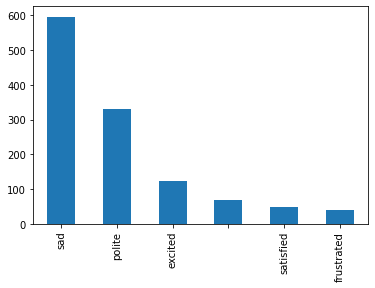

In [77]:
def analyze_post_comment_relationship_by_issue_type(df_analyze_posts, required_issue_labels, label):
    data = pd.DataFrame(columns=df_analyze_posts.columns)
    data_commit = pd.DataFrame(columns=df_analyze_posts.columns)
    j = 0
    for i, row in df_analyze_posts.iterrows():
        if (any(label in row['IssueLabel'] for label in required_issue_labels)):
            data.loc[i] = row
            if (row['HasCommit'] == 'TRUE'):
                data_commit.loc[j] = row
                j = j+1
            
    if data.count()[0] > 0:
        printmd('\n## For issues with labels: ' + str(required_issue_labels) +\
                ' (' + str(data.count()[0]) + ' issues)')
        analyze_post_comment_relationship(data)  
        if data_commit.count()[0] > 0:
            print('======================')
            analyze_emotion_commit_relationship(data_commit)
            print('======================')
            
            
printmd('# Analysis by issue type (bugs vs features):')
print('Labels were selected conservatively to ensure high precision but we tolorate low recall.')
print('\n')
print('##############################################################')
print('##############################################################')
printmd('# PyTorch Results')
PyTorch_bug_labels = ['high priority', 'critical', 'needs reproduction',\
                      'topic: assert failure', 'topic: crash', 'topic: deadlock',\
                      'topic: dependency bug', 'topic: error checking']
PyTorch_feature_labels = ['feature', 'proposal accepted', 'enhancement']
analyze_post_comment_relationship_by_issue_type(PyTorch_posts_wcomments, PyTorch_bug_labels, "PyTorchBug")
analyze_post_comment_relationship_by_issue_type(PyTorch_posts_wcomments, PyTorch_feature_labels,"PyTorchFeature")

PyTorch_all_labels = ['high priority', 'critical', 'needs reproduction',\
                      'topic: assert failure', 'topic: crash', 'topic: deadlock',\
                      'topic: dependency bug', 'topic: error checking',\
                     'feature', 'proposal accepted', 'enhancement']
printmd('# All the Bug and Features labels in PyTorch')
analyze_post_comment_relationship_by_issue_type(PyTorch_posts_wcomments, PyTorch_all_labels,"PyTorchAll")

print('\n')
print('##############################################################')
print('##############################################################')
printmd('# TensorFlow Results')
Tensorflow_bug_labels = ['type:bug', 'type:docs-bug']
Tensorflow_feature_labels = ['type:feature']
analyze_post_comment_relationship_by_issue_type(Tensorflow_posts_wcomments, Tensorflow_bug_labels,"TensorflowBug")
analyze_post_comment_relationship_by_issue_type(Tensorflow_posts_wcomments, Tensorflow_feature_labels,"TensorflowFeature")
Tensorflow_all_labels = ['type:feature','type:bug', 'type:docs-bug']
printmd('# All the Bug and Features labels in Tensorflow')
analyze_post_comment_relationship_by_issue_type(Tensorflow_posts_wcomments, Tensorflow_all_labels,"TensorflowAll")

print('\n')
print('##############################################################')
print('##############################################################')
printmd('# SkLearn Results')
SkLearn_bug_labels = ['Bug: triage', 'Bug', 'Regression']
SkLearn_feature_labels = ['Enhancement', 'New Feature']
analyze_post_comment_relationship_by_issue_type(SkLearn_posts_wcomments, SkLearn_bug_labels,"SklearnBug")
analyze_post_comment_relationship_by_issue_type(SkLearn_posts_wcomments, SkLearn_feature_labels,"SklearnFeature")
SkLearn_all_labels = ['Bug: triage', 'Bug', 'Regression','Enhancement', 'New Feature']
printmd('# All the Bug and Features labels in SkLearn')
analyze_post_comment_relationship_by_issue_type(SkLearn_posts_wcomments, SkLearn_all_labels,"SklearnAll")

print('\n')
print('##############################################################')
print('##############################################################')
printmd('# All Results')
all_bug_labels = ['Bug: triage', 'Bug', 'Regression', 'type:bug', 'type:docs-bug', \
                  'high priority', 'critical', 'needs reproduction',\
                  'topic: assert failure', 'topic: crash', 'topic: deadlock',\
                  'topic: dependency bug', 'topic: error checking']
all_feature_labels = ['Enhancement', 'New Feature', 'type:feature', 'feature', 'proposal accepted', 'enhancement']
analyze_post_comment_relationship_by_issue_type(All_posts_wcomments, all_bug_labels,"allBug")
analyze_post_comment_relationship_by_issue_type(All_posts_wcomments, all_feature_labels,"allFeature")
all_labels =['high priority', 'critical', 'needs reproduction',\
                      'topic: assert failure', 'topic: crash', 'topic: deadlock',\
                      'topic: dependency bug', 'topic: error checking',\
                     'feature', 'proposal accepted', 'enhancement',\
                     'type:feature','type:bug', 'type:docs-bug',\
                    'Bug: triage', 'Bug', 'Regression','Enhancement', 'New Feature']
printmd('# All the Bug and Features labels in all the repositories')
analyze_post_comment_relationship_by_issue_type(All_posts_wcomments, all_labels,"AllAll")


**Separate by commit size**

Analyze issues to decide commit size of each repositories
This cell is going to find the best points to determine the "Small", "Medium" and "Large" size of commit


##############################################################
######################    PyTorch    #########################
##############################################################
total_commit_size==0 count: 6851
total_commit_size==1 count: 24
total_commit_size==2 count: 137

total_commit_size>0 descriptive stats:
count      1952.000000
mean       1734.190574
std       12409.412901
min           1.000000
25%           9.000000
50%          37.000000
75%         150.250000
max      243244.000000
Name: total_commit_size, dtype: float64

total_commit_size>0 percentiles:
0.100        3.000
0.250        9.000
0.500       37.000
0.750      150.250
0.800      233.000
0.900      665.000
0.950     3410.350
0.990    40561.600
0.995    89926.745
Name: total_commit_size, dtype: float64
total_commit_size == [ 1 , 9.0 )  count: 485
total_commit_size == [ 9.0 , 150.25 )  count: 979
total_commit_size == [ 150.25 , 243245.0 )  count: 488


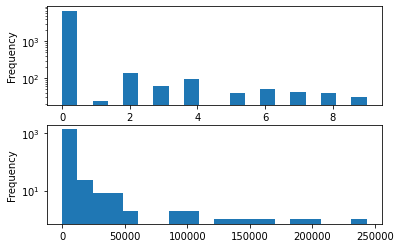


##############################################################
#####################    TensorFlow   ########################
##############################################################
total_commit_size==0 count: 18645
total_commit_size==1 count: 25
total_commit_size==2 count: 95

total_commit_size>0 descriptive stats:
count      958.000000
mean       702.665971
std       4107.564772
min          1.000000
25%          6.000000
50%         24.000000
75%         93.000000
max      50108.000000
Name: total_commit_size, dtype: float64

total_commit_size>0 percentiles:
0.100        2.000
0.250        6.000
0.500       24.000
0.750       93.000
0.800      129.000
0.900      346.100
0.950     1012.050
0.990    21403.350
0.995    28807.555
Name: total_commit_size, dtype: float64
total_commit_size == [ 1 , 6.0 )  count: 209
total_commit_size == [ 6.0 , 93.0 )  count: 508
total_commit_size == [ 93.0 , 50109.0 )  count: 241


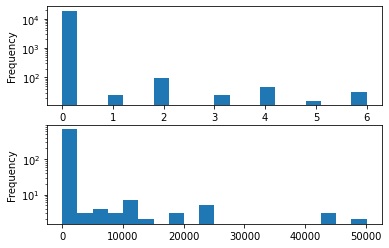


##############################################################
#######################    SkLearn    ########################
##############################################################
total_commit_size==0 count: 5162
total_commit_size==1 count: 8
total_commit_size==2 count: 44

total_commit_size>0 descriptive stats:
count      539.000000
mean       583.831169
std       4305.698187
min          1.000000
25%          7.000000
50%         24.000000
75%         67.500000
max      58442.000000
Name: total_commit_size, dtype: float64

total_commit_size>0 percentiles:
0.100        3.00
0.250        7.00
0.500       24.00
0.750       67.50
0.800       92.00
0.900      238.20
0.950      783.00
0.990    11938.14
0.995    38425.86
Name: total_commit_size, dtype: float64
total_commit_size == [ 1 , 7.0 )  count: 119
total_commit_size == [ 7.0 , 67.5 )  count: 285
total_commit_size == [ 67.5 , 58443.0 )  count: 135


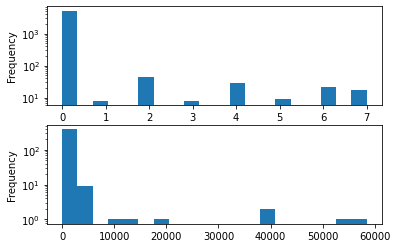


##############################################################
########################     ALL     #########################
##############################################################
total_commit_size==0 count: 30658
total_commit_size==1 count: 57
total_commit_size==2 count: 276

total_commit_size>0 descriptive stats:
count      3449.000000
mean       1267.897651
std        9746.566383
min           1.000000
25%           8.000000
50%          30.000000
75%         117.000000
max      243244.000000
Name: total_commit_size, dtype: float64

total_commit_size>0 percentiles:
0.100        3.00
0.250        8.00
0.500       30.00
0.750      117.00
0.800      166.40
0.900      479.20
0.950     1994.80
0.990    31143.56
0.995    47602.04
Name: total_commit_size, dtype: float64
total_commit_size == [ 1 , 8.0 )  count: 839
total_commit_size == [ 8.0 , 117.0 )  count: 1745
total_commit_size == [ 117.0 , 243245.0 )  count: 865


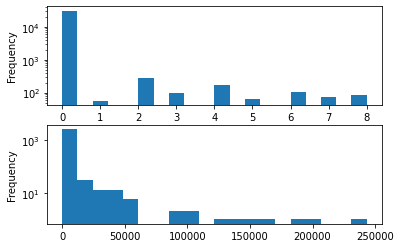

In [78]:
def analyze_issue_length(df_analyze_posts):
    print('total_commit_size==0 count:',\
          df_analyze_posts['total_commit_size'][df_analyze_posts['total_commit_size']==0].count())
    print('total_commit_size==1 count:',\
          df_analyze_posts['total_commit_size'][df_analyze_posts['total_commit_size']==1].count())
    print('total_commit_size==2 count:',\
          df_analyze_posts['total_commit_size'][df_analyze_posts['total_commit_size']==2].count())

    df_analyze_posts_wcomments = df_analyze_posts.loc[df_analyze_posts['total_commit_size'] > 0]

    print('\ntotal_commit_size>0 descriptive stats:\n',\
          df_analyze_posts_wcomments['total_commit_size'].describe(), sep='')

    quantiles = df_analyze_posts_wcomments['total_commit_size'].\
                quantile([.1, .25, .5, .75, .8, .9, .95, .99, .995])
    print('\ntotal_commit_size>0 percentiles:\n', quantiles, sep='')

    divider = [1, quantiles[.25], quantiles[.75], df_analyze_posts_wcomments['total_commit_size'].max()+1]
    for i in range(len(divider)-1):
        lower = divider[i]
        upper = divider[i+1]
        print('total_commit_size == [', lower, ',', upper, ')  count:',\
            df_analyze_posts_wcomments['total_commit_size'][\
                (df_analyze_posts_wcomments['total_commit_size'] >= lower) &\
                (df_analyze_posts_wcomments['total_commit_size'] < upper)].count())
    
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(2)

    df_analyze_posts_lx = df_analyze_posts.loc[df_analyze_posts['total_commit_size'] <= quantiles[.25]]
    df_analyze_posts_mx = df_analyze_posts.loc[df_analyze_posts['total_commit_size'] > quantiles[.25]]
    
    df_analyze_posts_lx['total_commit_size'].plot.hist(ax=ax[0], bins=20)
    ax[0].set_yscale('log')
    df_analyze_posts_mx['total_commit_size'].plot.hist(ax=ax[1], bins=20)
    ax[1].set_yscale('log')
    plt.show()
    
    return divider

print('\n##############################################################')
print('######################    PyTorch    #########################')
print('##############################################################')
PyTorch_commit_size_divider = analyze_issue_length(PyTorch_data['posts'])

print('\n##############################################################')
print('#####################    TensorFlow   ########################')
print('##############################################################')
Tensorflow_commit_size_divider = analyze_issue_length(Tensorflow_data['posts'])


print('\n##############################################################')
print('#######################    SkLearn    ########################')
print('##############################################################')
SkLearn_commit_size_divider = analyze_issue_length(SkLearn_data['posts'])



print('\n##############################################################')
print('########################     ALL     #########################')
print('##############################################################')
All_issue_length_divider = analyze_issue_length(All_posts)


# Analysis by commit size:



##############################################################
##############################################################


# PyTorch Results


### For issues having commit size: [1, 9.0)

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,13,0,11,1,59,0
neutral,164,10,22,13,92,1
positive,26,10,6,7,35,3


chi2 = 84.892  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.282</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
comment_dominant_sentiment,,,,,,
negative,3,1,0,3,11,0
neutral,135,17,15,53,119,20
positive,10,9,2,32,27,16


chi2 = 56.351  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:blue">cramers_v  = 0.222</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
Sentiment,,,
negative,3,61,20
neutral,13,228,61
positive,2,70,15


chi2 = 2.005  p = 0.73484  dof = 4

cramers_v = 0.0


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,25,4,5,10,32,8
neutral,101,14,8,61,100,18
positive,22,9,4,17,25,10


chi2 = 14.642  p = 0.14568  dof = 10

cramers_v = 0.07


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
post_dominant_tone_conf,,,
,10,156,37
excited,0,14,6
frustrated,1,30,8
polite,1,18,2
sad,6,139,41
satisfied,0,2,2


chi2 = 7.307  p = 0.69619  dof = 10

cramers_v = 0.0


#### Post tone <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
post_dominant_tone_conf,,,,,,
,73,11,8,39,61,11
excited,5,1,1,6,6,1
frustrated,9,3,1,10,12,4
polite,7,1,1,0,9,3
sad,53,11,6,32,68,16
satisfied,1,0,0,1,1,1


chi2 = 17.815  p = 0.85015  dof = 25

cramers_v = 0.0


#### Post sentiment <-> Time to first comment

H = 2.891  p = 0.23562  eta2 = 0.002

#### Post tone <-> Time to first comment

H = 1.104  p = 0.95373  eta2 = -0.008

#### Comment sentiment <-> Time to first comment

H = 22.074  <span style="color:red">p = 1.60954e-05</span>  eta2 = 0.043

,negative,neutral,positive
negative,-1.000000,0.021091,0.434818
neutral,0.021091,-1.000000,0.000091
positive,0.434818,0.000091,-1.000000


comment_dominant_sentiment
negative    3.652420e+06
neutral     6.476356e+05
positive    1.245472e+06
Name: time_to_first_comment, dtype: float64

#### Comment tone <-> Time to first comment

H = 61.853  <span style="color:red">p = 0.0</span>  eta2 = 0.122

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,0.000807,0.002821,1.946563e-07,1.009425e-09,0.000036
excited,8.066946e-04,-1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000
frustrated,2.821154e-03,1.000000,-1.000000,1.000000e+00,1.000000e+00,1.000000
polite,1.946563e-07,1.000000,1.000000,-1.000000e+00,1.000000e+00,1.000000
sad,1.009425e-09,1.000000,1.000000,1.000000e+00,-1.000000e+00,1.000000
satisfied,3.575493e-05,1.000000,1.000000,1.000000e+00,1.000000e+00,-1.000000


comment_dominant_tone_freq
              3.970168e+05
excited       8.828117e+05
frustrated    7.255242e+05
polite        2.455609e+05
sad           7.713157e+05
satisfied     5.004883e+06
Name: time_to_first_comment, dtype: float64

#### Post sentiment <-> Number of comments

H = 8.197  <span style="color:red">p = 0.0166004381</span>  eta2 = 0.013

,negative,neutral,positive
negative,-1.000000,0.065335,0.780524
neutral,0.065335,-1.000000,0.065335
positive,0.780524,0.065335,-1.000000


Sentiment
negative    4.047619
neutral     3.370861
positive    3.850575
Name: NumberOfComments, dtype: float64

#### Post tone <-> Number of comments

H = 9.003  p = 0.10895  eta2 = 0.009

#### Comment sentiment <-> Number of comments

H = 2.946  p = 0.22928  eta2 = 0.002

#### Comment tone <-> Number of comments

H = 222.989  <span style="color:red">p = 0.0</span>  eta2 = 0.467

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,1.348135e-12,2.046034e-07,2.057926e-29,8.479477e-36,8.288976e-17
excited,1.348135e-12,-1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
frustrated,2.046034e-07,1.000000e+00,-1.000000e+00,1.000000e+00,1.000000e+00,5.963512e-01
polite,2.057926e-29,1.000000e+00,1.000000e+00,-1.000000e+00,1.000000e+00,1.000000e+00
sad,8.479477e-36,1.000000e+00,1.000000e+00,1.000000e+00,-1.000000e+00,1.000000e+00
satisfied,8.288976e-17,1.000000e+00,5.963512e-01,1.000000e+00,1.000000e+00,-1.000000e+00


comment_dominant_tone_freq
              0.695946
excited       3.962963
frustrated    3.294118
polite        4.806818
sad           5.299363
satisfied     4.777778
Name: NumberOfComments, dtype: float64

#### Post sentiment <-> Time to first commit

H = 0.316  p = 0.8537  eta2 = -0.004

#### Post tone <-> Time to first commit

H = 6.817  p = 0.23462  eta2 = 0.004

#### Comment sentiment <-> Time to first commit

H = 15.501  <span style="color:red">p = 0.0004305383</span>  eta2 = 0.029

,negative,neutral,positive
negative,-1.000000,0.059715,0.003532
neutral,0.059715,-1.000000,0.003532
positive,0.003532,0.003532,-1.000000


comment_dominant_sentiment
negative    3.919758e+07
neutral     2.450987e+07
positive    1.250204e+07
Name: time_to_first_commit, dtype: float64

#### Comment tone <-> Time to first commit

H = 11.502  <span style="color:red">p = 0.0422896387</span>  eta2 = 0.014

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.569554,1.0,1.000000,0.063284,1.0
excited,0.569554,-1.000000,1.0,0.904318,1.000000,1.0
frustrated,1.000000,1.000000,-1.0,1.000000,1.000000,1.0
polite,1.000000,0.904318,1.0,-1.000000,0.677830,1.0
sad,0.063284,1.000000,1.0,0.677830,-1.000000,1.0
satisfied,1.000000,1.000000,1.0,1.000000,1.000000,-1.0


comment_dominant_tone_freq
              1.970516e+07
excited       2.863084e+07
frustrated    2.031474e+07
polite        1.904797e+07
sad           2.709526e+07
satisfied     2.055195e+07
Name: time_to_first_commit, dtype: float64

#### Post sentiment <-> Time to last commit

H = 0.446  p = 0.80023  eta2 = -0.003

#### Post tone <-> Time to last commit

H = 8.356  p = 0.13768  eta2 = 0.007

#### Comment sentiment <-> Time to last commit

H = 15.626  <span style="color:red">p = 0.0004043536</span>  eta2 = 0.029

,negative,neutral,positive
negative,-1.000000,0.060017,0.003223
neutral,0.060017,-1.000000,0.003223
positive,0.003223,0.003223,-1.000000


comment_dominant_sentiment
negative    4.002906e+07
neutral     2.488702e+07
positive    1.325965e+07
Name: time_to_last_commit, dtype: float64

#### Comment tone <-> Time to last commit

H = 11.056  p = 0.05027  eta2 = 0.013


### For issues having commit size: [9.0, 150.25)

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,25,1,27,5,105,1
neutral,343,34,67,18,147,0
positive,52,24,25,18,65,3


chi2 = 175.788  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.294</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
comment_dominant_sentiment,,,,,,
negative,3,0,4,6,25,0
neutral,277,27,40,95,275,20
positive,20,22,9,65,50,22


chi2 = 148.932  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.269</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
Sentiment,,,
negative,5,126,33
neutral,23,470,116
positive,10,138,39


chi2 = 1.791  p = 0.7742  dof = 4

cramers_v = 0.0


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,41,12,12,33,58,8
neutral,215,28,32,96,211,27
positive,44,9,9,37,81,7


chi2 = 17.475  p = 0.06449  dof = 10

cramers_v = 0.062


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
post_dominant_tone_conf,,,
,19,325,76
excited,2,43,14
frustrated,5,88,26
polite,1,34,6
sad,11,240,66
satisfied,0,4,0


chi2 = 4.623  p = 0.9149  dof = 10

cramers_v = 0.0


#### Post tone <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
post_dominant_tone_conf,,,,,,
,157,15,21,69,139,19
excited,21,6,1,14,16,1
frustrated,33,7,10,18,44,7
polite,11,4,0,6,17,3
sad,77,17,20,58,133,12
satisfied,1,0,1,1,1,0


chi2 = 38.085  <span style="color:red">p = 0.04538</span>  dof = 25

cramers_v = 0.052


#### Post sentiment <-> Time to first comment

H = 3.308  p = 0.19129  eta2 = 0.001

#### Post tone <-> Time to first comment

H = 6.765  p = 0.23869  eta2 = 0.002

#### Comment sentiment <-> Time to first comment

H = 41.364  <span style="color:red">p = 1e-09</span>  eta2 = 0.041

,negative,neutral,positive
negative,-1.000000,6.705324e-05,6.857645e-02
neutral,0.000067,-1.000000e+00,3.667787e-07
positive,0.068576,3.667787e-07,-1.000000e+00


comment_dominant_sentiment
negative    2.202736e+06
neutral     5.388529e+05
positive    4.897030e+05
Name: time_to_first_comment, dtype: float64

#### Comment tone <-> Time to first comment

H = 209.134  <span style="color:red">p = 0.0</span>  eta2 = 0.214

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,2.782437e-10,4.212701e-11,6.327604e-26,4.415663e-37,7.543461e-11
excited,2.782437e-10,-1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
frustrated,4.212701e-11,1.000000e+00,-1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
polite,6.327604e-26,1.000000e+00,1.000000e+00,-1.000000e+00,1.000000e+00,1.000000e+00
sad,4.415663e-37,1.000000e+00,1.000000e+00,1.000000e+00,-1.000000e+00,1.000000e+00
satisfied,7.543461e-11,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-1.000000e+00


comment_dominant_tone_freq
              347387.866667
excited       651028.163265
frustrated    105775.094340
polite        388792.921687
sad           992515.542857
satisfied     420078.619048
Name: time_to_first_comment, dtype: float64

#### Post sentiment <-> Number of comments

H = 18.354  <span style="color:red">p = 0.0001033825</span>  eta2 = 0.017

,negative,neutral,positive
negative,-1.000000,0.000998,0.563479
neutral,0.000998,-1.000000,0.004072
positive,0.563479,0.004072,-1.000000


Sentiment
negative    4.615854
neutral     3.576355
positive    4.342246
Name: NumberOfComments, dtype: float64

#### Post tone <-> Number of comments

H = 22.61  <span style="color:red">p = 0.0004006753</span>  eta2 = 0.018

,,excited,frustrated,polite,sad,satisfied
,-1.000000,1.00000,1.000000,1.0,0.000161,1.0
excited,1.000000,-1.00000,1.000000,1.0,0.398990,1.0
frustrated,1.000000,1.00000,-1.000000,1.0,0.265111,1.0
polite,1.000000,1.00000,1.000000,-1.0,1.000000,1.0
sad,0.000161,0.39899,0.265111,1.0,-1.000000,1.0
satisfied,1.000000,1.00000,1.000000,1.0,1.000000,-1.0


post_dominant_tone_conf
              3.573810
excited       3.474576
frustrated    3.428571
polite        4.219512
sad           4.539432
satisfied     5.250000
Name: NumberOfComments, dtype: float64

#### Comment sentiment <-> Number of comments

H = 2.466  p = 0.29148  eta2 = 0.0

#### Comment tone <-> Number of comments

H = 514.407  <span style="color:red">p = 0.0</span>  eta2 = 0.534

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,3.345583e-25,1.043276e-24,4.486237e-61,2.766854e-89,4.208644e-20
excited,3.345583e-25,-1.000000e+00,5.243444e-01,4.898610e-01,3.183691e-02,4.898610e-01
frustrated,1.043276e-24,5.243444e-01,-1.000000e+00,2.834086e-02,2.801998e-04,6.834181e-01
polite,4.486237e-61,4.898610e-01,2.834086e-02,-1.000000e+00,1.281637e-01,1.077310e-02
sad,2.766854e-89,3.183691e-02,2.801998e-04,1.281637e-01,-1.000000e+00,2.575452e-04
satisfied,4.208644e-20,4.898610e-01,6.834181e-01,1.077310e-02,2.575452e-04,-1.000000e+00


comment_dominant_tone_freq
              0.560000
excited       3.857143
frustrated    3.264151
polite        5.012048
sad           6.434286
satisfied     3.166667
Name: NumberOfComments, dtype: float64

#### Post sentiment <-> Time to first commit

H = 0.595  p = 0.74263  eta2 = -0.001

#### Post tone <-> Time to first commit

H = 9.843  p = 0.07981  eta2 = 0.005

#### Comment sentiment <-> Time to first commit

H = 5.064  p = 0.07951  eta2 = 0.003

#### Comment tone <-> Time to first commit

H = 28.301  <span style="color:red">p = 3.1791e-05</span>  eta2 = 0.024

,,excited,frustrated,polite,sad,satisfied
,-1.000000,1.0,0.520102,1.000000,0.000008,1.0
excited,1.000000,-1.0,1.000000,1.000000,1.000000,1.0
frustrated,0.520102,1.0,-1.000000,1.000000,1.000000,1.0
polite,1.000000,1.0,1.000000,-1.000000,0.015194,1.0
sad,0.000008,1.0,1.000000,0.015194,-1.000000,1.0
satisfied,1.000000,1.0,1.000000,1.000000,1.000000,-1.0


comment_dominant_tone_freq
              8.305137e+06
excited       1.372867e+07
frustrated    1.509917e+07
polite        7.623276e+06
sad           1.295453e+07
satisfied     9.092436e+06
Name: time_to_first_commit, dtype: float64

#### Post sentiment <-> Time to last commit

H = 0.902  p = 0.63686  eta2 = -0.001

#### Post tone <-> Time to last commit

H = 7.63  p = 0.17784  eta2 = 0.003

#### Comment sentiment <-> Time to last commit

H = 6.171  <span style="color:red">p = 0.0456960158</span>  eta2 = 0.004

,negative,neutral,positive
negative,-1.000000,0.794681,0.927391
neutral,0.794681,-1.000000,0.047218
positive,0.927391,0.047218,-1.000000


comment_dominant_sentiment
negative    1.365832e+07
neutral     1.304347e+07
positive    1.069384e+07
Name: time_to_last_commit, dtype: float64

#### Comment tone <-> Time to last commit

H = 22.143  <span style="color:red">p = 0.0004919219</span>  eta2 = 0.018

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.639307,0.43957,1.000000,0.000517,1.0
excited,0.639307,-1.000000,1.00000,1.000000,1.000000,1.0
frustrated,0.439570,1.000000,-1.00000,1.000000,1.000000,1.0
polite,1.000000,1.000000,1.00000,-1.000000,0.055234,1.0
sad,0.000517,1.000000,1.00000,0.055234,-1.000000,1.0
satisfied,1.000000,1.000000,1.00000,1.000000,1.000000,-1.0


comment_dominant_tone_freq
              1.056624e+07
excited       1.752833e+07
frustrated    1.987024e+07
polite        9.521050e+06
sad           1.431476e+07
satisfied     1.025763e+07
Name: time_to_last_commit, dtype: float64


### For issues having commit size: [150.25, 243245.0)

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,9,1,14,0,35,1
neutral,134,91,26,7,67,2
positive,31,16,11,6,28,3


chi2 = 76.176  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.263</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
comment_dominant_sentiment,,,,,,
negative,2,0,1,1,12,0
neutral,173,12,15,60,117,9
positive,8,9,4,23,25,11


chi2 = 74.107  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.258</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
Sentiment,,,
negative,2,48,10
neutral,11,272,44
positive,3,66,26


chi2 = 10.322  <span style="color:red">p = 0.03534</span>  dof = 4

cramers_v = 0.081


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,13,5,2,13,25,2
neutral,153,15,10,41,99,9
positive,17,1,8,30,30,9


chi2 = 57.004  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:blue">cramers_v  = 0.221</span>

#### Post tone <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
post_dominant_tone_conf,,,
,8,137,29
excited,3,96,9
frustrated,0,40,11
polite,0,12,1
sad,5,96,29
satisfied,0,5,1


chi2 = 13.748  p = 0.18482  dof = 10

cramers_v = 0.062


#### Post tone <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
post_dominant_tone_conf,,,,,,
,58,11,9,31,59,6
excited,77,1,2,9,15,4
frustrated,11,0,4,11,22,3
polite,4,1,2,2,4,0
sad,31,8,3,30,51,7
satisfied,2,0,0,1,3,0


chi2 = 86.186  <span style="color:red">p = 0.0</span>  dof = 25

<span style="color:blue">cramers_v  = 0.16</span>

#### Post sentiment <-> Time to first comment

H = 11.782  <span style="color:red">p = 0.0027647695</span>  eta2 = 0.02

,negative,neutral,positive
negative,-1.000000,0.095477,0.436928
neutral,0.095477,-1.000000,0.005411
positive,0.436928,0.005411,-1.000000


Sentiment
negative    386804.800000
neutral     755220.363914
positive    463624.284211
Name: time_to_first_comment, dtype: float64

#### Post tone <-> Time to first comment

H = 63.271  <span style="color:red">p = 0.0</span>  eta2 = 0.122

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,1.414073e-10,1.000000,1.000000,1.000000e+00,1.000000
excited,1.414073e-10,-1.000000e+00,0.000005,0.001310,1.219737e-10,0.087894
frustrated,1.000000e+00,5.329472e-06,-1.000000,0.794617,1.000000e+00,1.000000
polite,1.000000e+00,1.310136e-03,0.794617,-1.000000,1.000000e+00,1.000000
sad,1.000000e+00,1.219737e-10,1.000000,1.000000,-1.000000e+00,1.000000
satisfied,1.000000e+00,8.789448e-02,1.000000,1.000000,1.000000e+00,-1.000000


post_dominant_tone_conf
              5.491897e+05
excited       3.472657e+05
frustrated    9.915382e+04
polite        2.551608e+06
sad           1.079781e+06
satisfied     4.244425e+05
Name: time_to_first_comment, dtype: float64

#### Comment sentiment <-> Time to first comment

H = 21.592  <span style="color:red">p = 2.04854e-05</span>  eta2 = 0.041

,negative,neutral,positive
negative,-1.000000,0.031307,0.488254
neutral,0.031307,-1.000000,0.000095
positive,0.488254,0.000095,-1.000000


comment_dominant_sentiment
negative    842726.375000
neutral     653170.313472
positive    607528.637500
Name: time_to_first_comment, dtype: float64

#### Comment tone <-> Time to first comment

H = 162.298  <span style="color:red">p = 0.0</span>  eta2 = 0.33

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,3.327098e-08,2.330345e-09,5.196377e-20,5.292305e-27,7.861539e-08
excited,3.327098e-08,-1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
frustrated,2.330345e-09,1.000000e+00,-1.000000e+00,8.988966e-01,8.460264e-01,1.000000e+00
polite,5.196377e-20,1.000000e+00,8.988966e-01,-1.000000e+00,1.000000e+00,1.000000e+00
sad,5.292305e-27,1.000000e+00,8.460264e-01,1.000000e+00,-1.000000e+00,1.000000e+00
satisfied,7.861539e-08,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-1.000000e+00


comment_dominant_tone_freq
              3.910144e+05
excited       2.895114e+05
frustrated    1.908904e+06
polite        9.313464e+05
sad           7.497893e+05
satisfied     2.347774e+05
Name: time_to_first_comment, dtype: float64

#### Post sentiment <-> Number of comments

H = 24.391  <span style="color:red">p = 5.0531e-06</span>  eta2 = 0.047

,negative,neutral,positive
negative,-1.000000,0.000939,0.952858
neutral,0.000939,-1.000000,0.000123
positive,0.952858,0.000123,-1.000000


Sentiment
negative    5.050000
neutral     3.455657
positive    4.957895
Name: NumberOfComments, dtype: float64

#### Post tone <-> Number of comments

H = 85.958  <span style="color:red">p = 0.0</span>  eta2 = 0.17

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,8.394098e-14,8.350442e-01,1.000000,1.000000e+00,1.000000
excited,8.394098e-14,-1.000000e+00,4.460736e-11,0.000432,1.667178e-13,0.006427
frustrated,8.350442e-01,4.460736e-11,-1.000000e+00,1.000000,1.000000e+00,1.000000
polite,1.000000e+00,4.316295e-04,1.000000e+00,-1.000000,1.000000e+00,1.000000
sad,1.000000e+00,1.667178e-13,1.000000e+00,1.000000,-1.000000e+00,1.000000
satisfied,1.000000e+00,6.426544e-03,1.000000e+00,1.000000,1.000000e+00,-1.000000


post_dominant_tone_conf
              4.448276
excited       1.425926
frustrated    4.980392
polite        5.153846
sad           4.784615
satisfied     5.500000
Name: NumberOfComments, dtype: float64

#### Comment sentiment <-> Number of comments

H = 3.304  p = 0.19167  eta2 = 0.003

#### Comment tone <-> Number of comments

H = 297.888  <span style="color:red">p = 0.0</span>  eta2 = 0.615

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,1.582048e-11,1.932393e-11,6.644932e-36,1.218030e-50,7.684728e-12
excited,1.582048e-11,-1.000000e+00,1.000000e+00,3.375218e-02,3.509691e-03,1.000000e+00
frustrated,1.932393e-11,1.000000e+00,-1.000000e+00,5.019350e-02,4.707195e-03,1.000000e+00
polite,6.644932e-36,3.375218e-02,5.019350e-02,-1.000000e+00,4.675677e-01,9.842089e-02
sad,1.218030e-50,3.509691e-03,4.707195e-03,4.675677e-01,-1.000000e+00,1.226231e-02
satisfied,7.684728e-12,1.000000e+00,1.000000e+00,9.842089e-02,1.226231e-02,-1.000000e+00


comment_dominant_tone_freq
              0.524590
excited       3.619048
frustrated    3.300000
polite        5.476190
sad           7.350649
satisfied     3.700000
Name: NumberOfComments, dtype: float64

#### Post sentiment <-> Time to first commit

H = 0.764  p = 0.68254  eta2 = -0.003

#### Post tone <-> Time to first commit

H = 18.207  <span style="color:red">p = 0.0026982911</span>  eta2 = 0.028

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.142619,1.000000,1.000000,1.000000,0.396384
excited,0.142619,-1.000000,0.851757,1.000000,0.008884,0.533124
frustrated,1.000000,0.851757,-1.000000,1.000000,1.000000,0.909689
polite,1.000000,1.000000,1.000000,-1.000000,0.909689,1.000000
sad,1.000000,0.008884,1.000000,0.909689,-1.000000,0.225659
satisfied,0.396384,0.533124,0.909689,1.000000,0.225659,-1.000000


post_dominant_tone_conf
              1.302574e+07
excited       1.085403e+07
frustrated    1.561465e+07
polite        1.781420e+07
sad           1.091778e+07
satisfied     2.802453e+07
Name: time_to_first_commit, dtype: float64

#### Comment sentiment <-> Time to first commit

H = 2.522  p = 0.28334  eta2 = 0.001

#### Comment tone <-> Time to first commit

H = 4.689  p = 0.45497  eta2 = -0.001

#### Post sentiment <-> Time to last commit

H = 0.649  p = 0.72302  eta2 = -0.003

#### Post tone <-> Time to last commit

H = 16.074  <span style="color:red">p = 0.0066369257</span>  eta2 = 0.023

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.386434,1.000000,1.000000,1.000000,0.572060
excited,0.386434,-1.000000,1.000000,1.000000,0.024210,0.798132
frustrated,1.000000,1.000000,-1.000000,1.000000,0.798132,1.000000
polite,1.000000,1.000000,1.000000,-1.000000,0.963503,1.000000
sad,1.000000,0.024210,0.798132,0.963503,-1.000000,0.403590
satisfied,0.572060,0.798132,1.000000,1.000000,0.403590,-1.000000


post_dominant_tone_conf
              1.589234e+07
excited       1.220017e+07
frustrated    1.931675e+07
polite        2.547608e+07
sad           1.357404e+07
satisfied     3.068741e+07
Name: time_to_last_commit, dtype: float64

#### Comment sentiment <-> Time to last commit

H = 4.031  p = 0.13327  eta2 = 0.004

#### Comment tone <-> Time to last commit

H = 3.523  p = 0.61992  eta2 = -0.003



##############################################################
##############################################################


# TensorFlow Results


### For issues having commit size: [1, 6.0)

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,6,1,5,1,30,0
neutral,70,5,5,5,27,0
positive,20,3,5,11,13,1


chi2 = 58.159  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.342</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
comment_dominant_sentiment,,,,,,
negative,0,0,0,2,2,0
neutral,24,7,6,24,60,3
positive,5,5,1,44,18,7


chi2 = 40.369  <span style="color:red">p = 1e-05</span>  dof = 10

<span style="color:red">cramers_v = 0.271</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
Sentiment,,,
negative,1,25,17
neutral,1,63,48
positive,2,36,15


chi2 = 4.438  p = 0.34993  dof = 4

cramers_v = 0.032


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,8,3,1,13,15,3
neutral,18,7,4,40,39,4
positive,3,2,2,17,26,3


chi2 = 7.603  p = 0.66757  dof = 10

cramers_v = 0.0


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
post_dominant_tone_conf,,,
,3,54,39
excited,0,7,2
frustrated,0,10,5
polite,0,12,5
sad,1,40,29
satisfied,0,1,0


chi2 = 4.855  p = 0.90063  dof = 10

cramers_v = 0.0


#### Post tone <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
post_dominant_tone_conf,,,,,,
,13,6,2,37,33,5
excited,1,0,1,1,5,1
frustrated,3,2,0,4,6,0
polite,1,1,1,5,8,1
sad,11,3,3,23,27,3
satisfied,0,0,0,0,1,0


chi2 = 13.771  p = 0.96558  dof = 25

cramers_v = 0.0


#### Post sentiment <-> Time to first comment

H = 1.069  p = 0.58586  eta2 = -0.005

#### Post tone <-> Time to first comment

H = 2.078  p = 0.83831  eta2 = -0.014

#### Comment sentiment <-> Time to first comment

H = 2.666  p = 0.26369  eta2 = 0.003

#### Comment tone <-> Time to first comment

H = 6.646  p = 0.24832  eta2 = 0.008

#### Post sentiment <-> Number of comments

H = 7.23  <span style="color:red">p = 0.0269205998</span>  eta2 = 0.026

,negative,neutral,positive
negative,-1.000000,0.189776,0.694903
neutral,0.189776,-1.000000,0.034332
positive,0.694903,0.034332,-1.000000


Sentiment
negative    8.069767
neutral     5.633929
positive    8.245283
Name: NumberOfComments, dtype: float64

#### Post tone <-> Number of comments

H = 6.412  p = 0.26818  eta2 = 0.007

#### Comment sentiment <-> Number of comments

H = 0.838  p = 0.65772  eta2 = -0.006

#### Comment tone <-> Number of comments

H = 61.021  <span style="color:red">p = 0.0</span>  eta2 = 0.277

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,0.000887,0.016955,1.038781e-10,3.496415e-10,0.041299
excited,8.865072e-04,-1.000000,1.000000,1.000000e+00,7.654013e-01,1.000000
frustrated,1.695488e-02,1.000000,-1.000000,3.154982e-01,3.154982e-01,1.000000
polite,1.038781e-10,1.000000,0.315498,-1.000000e+00,1.000000e+00,0.171062
sad,3.496415e-10,0.765401,0.315498,1.000000e+00,-1.000000e+00,0.202699
satisfied,4.129867e-02,1.000000,1.000000,1.710624e-01,2.026987e-01,-1.000000


comment_dominant_tone_freq
              1.103448
excited       4.583333
frustrated    3.000000
polite        7.785714
sad           9.050000
satisfied     3.800000
Name: NumberOfComments, dtype: float64

#### Post sentiment <-> Time to first commit

H = 3.709  p = 0.15652  eta2 = 0.008

#### Post tone <-> Time to first commit

H = 3.687  p = 0.5953  eta2 = -0.006

#### Comment sentiment <-> Time to first commit

H = 3.163  p = 0.20568  eta2 = 0.006

#### Comment tone <-> Time to first commit

H = 4.169  p = 0.52529  eta2 = -0.004

#### Post sentiment <-> Time to last commit

H = 4.007  p = 0.13485  eta2 = 0.01

#### Post tone <-> Time to last commit

H = 4.887  p = 0.42986  eta2 = -0.001

#### Comment sentiment <-> Time to last commit

H = 3.484  p = 0.17515  eta2 = 0.007

#### Comment tone <-> Time to last commit

H = 4.573  p = 0.47022  eta2 = -0.002


### For issues having commit size: [6.0, 93.0)

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,9,4,14,0,56,0
neutral,190,3,14,9,71,0
positive,26,9,11,21,48,9


chi2 = 182.042  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.418</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
comment_dominant_sentiment,,,,,,
negative,1,2,2,1,6,0
neutral,51,19,14,62,135,10
positive,9,21,2,101,39,19


chi2 = 97.307  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.298</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
Sentiment,,,
negative,2,57,24
neutral,6,161,120
positive,4,73,47


chi2 = 4.983  p = 0.2891  dof = 4

cramers_v = 0.031


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,4,7,4,27,38,3
neutral,39,20,7,102,100,19
positive,18,15,7,35,42,7


chi2 = 14.968  p = 0.13325  dof = 10

cramers_v = 0.071


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
post_dominant_tone_conf,,,
,4,115,106
excited,0,11,5
frustrated,3,25,11
polite,0,21,9
sad,4,115,56
satisfied,1,4,4


chi2 = 22.005  <span style="color:red">p = 0.01508</span>  dof = 10

cramers_v = 0.11


#### Post tone <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
post_dominant_tone_conf,,,,,,
,29,18,4,88,73,13
excited,3,2,2,2,4,3
frustrated,7,0,1,19,12,0
polite,4,1,0,10,13,2
sad,17,21,9,44,73,11
satisfied,1,0,2,1,5,0


chi2 = 50.887  <span style="color:red">p = 0.00165</span>  dof = 25

cramers_v = 0.103


#### Post sentiment <-> Time to first comment

H = 0.692  p = 0.70765  eta2 = -0.003

#### Post tone <-> Time to first comment

H = 5.368  p = 0.37262  eta2 = 0.001

#### Comment sentiment <-> Time to first comment

H = 14.558  <span style="color:red">p = 0.0006898324</span>  eta2 = 0.026

,negative,neutral,positive
negative,-1.000000,0.049065,0.188632
neutral,0.049065,-1.000000,0.002727
positive,0.188632,0.002727,-1.000000


comment_dominant_sentiment
negative    3.876070e+06
neutral     3.588768e+05
positive    5.594598e+05
Name: time_to_first_comment, dtype: float64

#### Comment tone <-> Time to first comment

H = 35.804  <span style="color:red">p = 1.0398e-06</span>  eta2 = 0.063

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,0.000398,0.079348,6.491789e-07,0.000001,0.003026
excited,3.978158e-04,-1.000000,1.000000,1.000000e+00,1.000000,1.000000
frustrated,7.934799e-02,1.000000,-1.000000,1.000000e+00,1.000000,1.000000
polite,6.491789e-07,1.000000,1.000000,-1.000000e+00,1.000000,1.000000
sad,1.225412e-06,1.000000,1.000000,1.000000e+00,-1.000000,1.000000
satisfied,3.026064e-03,1.000000,1.000000,1.000000e+00,1.000000,-1.000000


comment_dominant_tone_freq
              5.053790e+05
excited       8.625801e+05
frustrated    1.568153e+05
polite        4.639002e+05
sad           4.247283e+05
satisfied     1.220446e+06
Name: time_to_first_comment, dtype: float64

#### Post sentiment <-> Number of comments

H = 5.44  p = 0.06588  eta2 = 0.007

#### Post tone <-> Number of comments

H = 6.879  p = 0.22979  eta2 = 0.004

#### Comment sentiment <-> Number of comments

H = 7.728  <span style="color:red">p = 0.0209835107</span>  eta2 = 0.012

,negative,neutral,positive
negative,-1.000000,0.038897,0.027669
neutral,0.038897,-1.000000,0.187111
positive,0.027669,0.187111,-1.000000


comment_dominant_sentiment
negative    2.916667
neutral     7.742268
positive    5.434555
Name: NumberOfComments, dtype: float64

#### Comment tone <-> Number of comments

H = 144.883  <span style="color:red">p = 0.0</span>  eta2 = 0.287

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,6.474118e-13,0.000003,4.891056e-23,1.389957e-24,4.458933e-07
excited,6.474118e-13,-1.000000e+00,0.643922,6.439216e-01,5.704033e-02,2.001420e-01
frustrated,3.004551e-06,6.439216e-01,-1.000000,1.948084e-01,3.596724e-02,6.439216e-01
polite,4.891056e-23,6.439216e-01,0.194808,-1.000000e+00,1.203352e-01,9.423118e-03
sad,1.389957e-24,5.704033e-02,0.035967,1.203352e-01,-1.000000e+00,3.533506e-04
satisfied,4.458933e-07,2.001420e-01,0.643922,9.423118e-03,3.533506e-04,-1.000000e+00


comment_dominant_tone_freq
              0.983607
excited       6.309524
frustrated    4.388889
polite        6.756098
sad           9.466667
satisfied     3.793103
Name: NumberOfComments, dtype: float64

#### Post sentiment <-> Time to first commit

H = 0.82  p = 0.66362  eta2 = -0.002

#### Post tone <-> Time to first commit

H = 2.066  p = 0.83987  eta2 = -0.006

#### Comment sentiment <-> Time to first commit

H = 2.628  p = 0.26869  eta2 = 0.001

#### Comment tone <-> Time to first commit

H = 20.858  <span style="color:red">p = 0.0008615424</span>  eta2 = 0.032

,,excited,frustrated,polite,sad,satisfied
,-1.000000,1.000000,1.0,0.001461,0.020906,1.000000
excited,1.000000,-1.000000,1.0,0.325955,1.000000,1.000000
frustrated,1.000000,1.000000,-1.0,1.000000,1.000000,1.000000
polite,0.001461,0.325955,1.0,-1.000000,1.000000,0.230508
sad,0.020906,1.000000,1.0,1.000000,-1.000000,0.649932
satisfied,1.000000,1.000000,1.0,0.230508,0.649932,-1.000000


comment_dominant_tone_freq
              1.713870e+06
excited       3.543602e+06
frustrated    1.776232e+06
polite        4.180487e+06
sad           3.296960e+06
satisfied     2.301190e+06
Name: time_to_first_commit, dtype: float64

#### Post sentiment <-> Time to last commit

H = 0.828  p = 0.66092  eta2 = -0.002

#### Post tone <-> Time to last commit

H = 1.418  p = 0.9223  eta2 = -0.007

#### Comment sentiment <-> Time to last commit

H = 2.625  p = 0.26919  eta2 = 0.001

#### Comment tone <-> Time to last commit

H = 20.327  <span style="color:red">p = 0.0010850874</span>  eta2 = 0.031

,,excited,frustrated,polite,sad,satisfied
,-1.000000,1.000000,1.0,0.001669,0.024185,1.000000
excited,1.000000,-1.000000,1.0,0.187237,0.724178,1.000000
frustrated,1.000000,1.000000,-1.0,1.000000,1.000000,1.000000
polite,0.001669,0.187237,1.0,-1.000000,1.000000,0.475742
sad,0.024185,0.724178,1.0,1.000000,-1.000000,1.000000
satisfied,1.000000,1.000000,1.0,0.475742,1.000000,-1.000000


comment_dominant_tone_freq
              2.409900e+06
excited       3.550355e+06
frustrated    1.811877e+06
polite        4.597895e+06
sad           3.685026e+06
satisfied     2.481704e+06
Name: time_to_last_commit, dtype: float64


### For issues having commit size: [93.0, 50109.0)

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,4,2,3,0,26,0
neutral,77,4,9,6,42,0
positive,16,7,7,12,21,1


chi2 = 57.681  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.318</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
comment_dominant_sentiment,,,,,,
negative,0,0,1,1,7,0
neutral,18,11,5,35,65,3
positive,0,8,1,52,25,5


chi2 = 44.165  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.269</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
Sentiment,,,
negative,1,26,8
neutral,4,70,64
positive,4,41,19


chi2 = 10.418  <span style="color:red">p = 0.03395</span>  dof = 4

cramers_v = 0.117


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,4,1,1,10,18,1
neutral,12,12,3,54,54,3
positive,2,6,3,24,25,4


chi2 = 9.039  p = 0.5284  dof = 10

cramers_v = 0.0


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
post_dominant_tone_conf,,,
,6,46,45
excited,0,10,3
frustrated,0,12,7
polite,1,11,6
sad,2,57,30
satisfied,0,1,0


chi2 = 10.521  p = 0.39601  dof = 10

cramers_v = 0.032


#### Post tone <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
post_dominant_tone_conf,,,,,,
,7,8,2,38,36,6
excited,2,1,0,7,3,0
frustrated,0,1,1,5,12,0
polite,0,0,1,6,11,0
sad,9,9,3,31,35,2
satisfied,0,0,0,1,0,0


chi2 = 21.548  p = 0.66169  dof = 25

cramers_v = 0.0


#### Post sentiment <-> Time to first comment

H = 1.509  p = 0.47036  eta2 = -0.002

#### Post tone <-> Time to first comment

H = 5.138  p = 0.39926  eta2 = 0.001

#### Comment sentiment <-> Time to first comment

H = 3.098  p = 0.21245  eta2 = 0.005

#### Comment tone <-> Time to first comment

H = 7.608  p = 0.1792  eta2 = 0.011

#### Post sentiment <-> Number of comments

H = 1.96  p = 0.37537  eta2 = -0.0

#### Post tone <-> Number of comments

H = 7.564  p = 0.18195  eta2 = 0.011

#### Comment sentiment <-> Number of comments

H = 1.177  p = 0.5552  eta2 = -0.004

#### Comment tone <-> Number of comments

H = 43.1  <span style="color:red">p = 3.53e-08</span>  eta2 = 0.165

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,0.000014,0.003877,2.136110e-08,1.504526e-08,0.002573
excited,1.378734e-05,-1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000
frustrated,3.876741e-03,1.000000,-1.000000,1.000000e+00,1.000000e+00,1.000000
polite,2.136110e-08,1.000000,1.000000,-1.000000e+00,1.000000e+00,1.000000
sad,1.504526e-08,1.000000,1.000000,1.000000e+00,-1.000000e+00,1.000000
satisfied,2.572686e-03,1.000000,1.000000,1.000000e+00,1.000000e+00,-1.000000


comment_dominant_tone_freq
              0.944444
excited       5.842105
frustrated    5.428571
polite        9.034091
sad           8.402062
satisfied     5.875000
Name: NumberOfComments, dtype: float64

#### Post sentiment <-> Time to first commit

H = 13.427  <span style="color:red">p = 0.0012146194</span>  eta2 = 0.049

,negative,neutral,positive
negative,-1.000000,0.003719,0.001079
neutral,0.003719,-1.000000,0.284725
positive,0.001079,0.284725,-1.000000


Sentiment
negative    1.387289e+06
neutral     3.462989e+06
positive    3.852751e+06
Name: time_to_first_commit, dtype: float64

#### Post tone <-> Time to first commit

H = 6.158  p = 0.29111  eta2 = 0.005

#### Comment sentiment <-> Time to first commit

H = 0.608  p = 0.73804  eta2 = -0.006

#### Comment tone <-> Time to first commit

H = 7.555  p = 0.18255  eta2 = 0.011

#### Post sentiment <-> Time to last commit

H = 12.852  <span style="color:red">p = 0.0016186078</span>  eta2 = 0.046

,negative,neutral,positive
negative,-1.000000,0.005101,0.001544
neutral,0.005101,-1.000000,0.254446
positive,0.001544,0.254446,-1.000000


Sentiment
negative    1.891847e+06
neutral     3.740300e+06
positive    4.193417e+06
Name: time_to_last_commit, dtype: float64

#### Post tone <-> Time to last commit

H = 9.19  p = 0.10173  eta2 = 0.018

#### Comment sentiment <-> Time to last commit

H = 0.141  p = 0.93171  eta2 = -0.008

#### Comment tone <-> Time to last commit

H = 8.937  p = 0.11162  eta2 = 0.017



##############################################################
##############################################################


# SkLearn Results


### For issues having commit size: [1, 7.0)

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,0,0,2,0,12,0
neutral,51,5,6,5,22,1
positive,3,0,4,0,6,0


chi2 = 34.018  <span style="color:red">p = 0.00018</span>  dof = 10

<span style="color:red">cramers_v = 0.323</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
comment_dominant_sentiment,,,,,,
negative,2,0,1,2,1,0
neutral,19,10,2,11,38,2
positive,2,9,0,8,6,4


chi2 = 27.987  <span style="color:red">p = 0.00181</span>  dof = 10

<span style="color:red">cramers_v = 0.279</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
Sentiment,,,
negative,2,11,1
neutral,4,62,24
positive,0,9,4


chi2 = 5.276  p = 0.26013  dof = 4

cramers_v = 0.073


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,1,2,2,2,6,1
neutral,21,12,1,19,32,5
positive,1,5,0,0,7,0


chi2 = 20.528  <span style="color:red">p = 0.02464</span>  dof = 10

<span style="color:blue">cramers_v  = 0.213</span>

#### Post tone <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
post_dominant_tone_conf,,,
,1,37,16
excited,0,4,1
frustrated,0,9,3
polite,0,3,2
sad,5,28,7
satisfied,0,1,0


chi2 = 9.008  p = 0.53131  dof = 10

cramers_v = 0.0


#### Post tone <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
post_dominant_tone_conf,,,,,,
,14,8,0,12,17,3
excited,2,1,0,0,2,0
frustrated,1,3,0,0,6,2
polite,0,0,0,4,1,0
sad,6,7,3,4,19,1
satisfied,0,0,0,1,0,0


chi2 = 38.505  <span style="color:red">p = 0.04126</span>  dof = 25

<span style="color:blue">cramers_v  = 0.154</span>

#### Post sentiment <-> Time to first comment

H = 0.724  p = 0.69635  eta2 = -0.011

#### Post tone <-> Time to first comment

H = 8.74  p = 0.11989  eta2 = 0.034

#### Comment sentiment <-> Time to first comment

H = 5.049  p = 0.08011  eta2 = 0.027

#### Comment tone <-> Time to first comment

H = 25.363  <span style="color:red">p = 0.0001185402</span>  eta2 = 0.183

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.00624,0.816703,0.004518,0.000125,0.023049
excited,0.006240,-1.00000,1.000000,1.000000,1.000000,1.000000
frustrated,0.816703,1.00000,-1.000000,1.000000,1.000000,1.000000
polite,0.004518,1.00000,1.000000,-1.000000,1.000000,1.000000
sad,0.000125,1.00000,1.000000,1.000000,-1.000000,1.000000
satisfied,0.023049,1.00000,1.000000,1.000000,1.000000,-1.000000


comment_dominant_tone_freq
               53849.913043
excited       138287.473684
frustrated     13892.666667
polite        140436.523810
sad           493684.666667
satisfied     270000.500000
Name: time_to_first_comment, dtype: float64

#### Post sentiment <-> Number of comments

H = 7.296  <span style="color:red">p = 0.0260441027</span>  eta2 = 0.046

,negative,neutral,positive
negative,-1.000000,0.09881,0.863219
neutral,0.098810,-1.00000,0.111280
positive,0.863219,0.11128,-1.000000


Sentiment
negative    7.714286
neutral     4.377778
positive    5.153846
Name: NumberOfComments, dtype: float64

#### Post tone <-> Number of comments

H = 10.3  p = 0.06716  eta2 = 0.048

#### Comment sentiment <-> Number of comments

H = 0.791  p = 0.67319  eta2 = -0.011

#### Comment tone <-> Number of comments

H = 48.523  <span style="color:red">p = 2.8e-09</span>  eta2 = 0.392

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,0.00001,0.166088,5.612259e-07,9.210028e-09,0.013396
excited,1.017940e-05,-1.00000,1.000000,1.000000e+00,1.000000e+00,1.000000
frustrated,1.660877e-01,1.00000,-1.000000,1.000000e+00,1.000000e+00,1.000000
polite,5.612259e-07,1.00000,1.000000,-1.000000e+00,1.000000e+00,1.000000
sad,9.210028e-09,1.00000,1.000000,1.000000e+00,-1.000000e+00,1.000000
satisfied,1.339626e-02,1.00000,1.000000,1.000000e+00,1.000000e+00,-1.000000


comment_dominant_tone_freq
              0.608696
excited       3.947368
frustrated    4.666667
polite        5.238095
sad           7.444444
satisfied     3.500000
Name: NumberOfComments, dtype: float64

#### Post sentiment <-> Time to first commit

H = 0.398  p = 0.8194  eta2 = -0.014

#### Post tone <-> Time to first commit

H = 2.413  p = 0.78948  eta2 = -0.023

#### Comment sentiment <-> Time to first commit

H = 0.258  p = 0.87892  eta2 = -0.015

#### Comment tone <-> Time to first commit

H = 3.339  p = 0.64791  eta2 = -0.015

#### Post sentiment <-> Time to last commit

H = 0.428  p = 0.80752  eta2 = -0.014

#### Post tone <-> Time to last commit

H = 2.512  p = 0.77463  eta2 = -0.022

#### Comment sentiment <-> Time to last commit

H = 0.052  p = 0.97454  eta2 = -0.017

#### Comment tone <-> Time to last commit

H = 2.381  p = 0.79428  eta2 = -0.024


### For issues having commit size: [7.0, 67.5)

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,0,0,13,0,20,0
neutral,95,16,13,3,52,0
positive,22,9,6,2,18,3


chi2 = 69.439  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.332</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
comment_dominant_sentiment,,,,,,
negative,0,0,3,1,9,0
neutral,38,17,10,28,100,5
positive,4,17,1,16,19,4


chi2 = 44.737  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.253</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
Sentiment,,,
negative,0,30,3
neutral,8,127,44
positive,5,41,14


chi2 = 7.943  p = 0.09367  dof = 4

cramers_v = 0.085


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,5,5,3,4,16,0
neutral,31,21,8,32,81,6
positive,6,8,3,9,31,3


chi2 = 5.713  p = 0.83874  dof = 10

cramers_v = 0.0


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
post_dominant_tone_conf,,,
,6,83,28
excited,1,17,7
frustrated,1,24,7
polite,2,2,1
sad,3,70,17
satisfied,0,2,1


chi2 = 16.12  p = 0.09626  dof = 10

cramers_v = 0.106


#### Post tone <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
post_dominant_tone_conf,,,,,,
,17,13,6,24,51,6
excited,6,4,1,3,10,1
frustrated,4,4,2,6,16,0
polite,1,1,0,0,3,0
sad,13,11,5,12,47,2
satisfied,1,1,0,0,1,0


chi2 = 12.14  p = 0.9854  dof = 25

cramers_v = 0.0


#### Post sentiment <-> Time to first comment

H = 1.947  p = 0.37781  eta2 = -0.0

#### Post tone <-> Time to first comment

H = 2.208  p = 0.81969  eta2 = -0.01

#### Comment sentiment <-> Time to first comment

H = 7.021  <span style="color:red">p = 0.0298848128</span>  eta2 = 0.019

,negative,neutral,positive
negative,-1.000000,0.241933,0.690834
neutral,0.241933,-1.000000,0.061964
positive,0.690834,0.061964,-1.000000


comment_dominant_sentiment
negative    3.422838e+05
neutral     6.124071e+05
positive    3.149423e+06
Name: time_to_first_comment, dtype: float64

#### Comment tone <-> Time to first comment

H = 18.132  <span style="color:red">p = 0.0027848699</span>  eta2 = 0.049

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.023953,0.216206,0.010866,0.002989,0.17894
excited,0.023953,-1.000000,1.000000,1.000000,1.000000,1.00000
frustrated,0.216206,1.000000,-1.000000,1.000000,1.000000,1.00000
polite,0.010866,1.000000,1.000000,-1.000000,1.000000,1.00000
sad,0.002989,1.000000,1.000000,1.000000,-1.000000,1.00000
satisfied,0.178940,1.000000,1.000000,1.000000,1.000000,-1.00000


comment_dominant_tone_freq
              1.576547e+06
excited       3.780915e+06
frustrated    3.515361e+05
polite        6.302981e+05
sad           5.452346e+05
satisfied     2.220005e+06
Name: time_to_first_comment, dtype: float64

#### Post sentiment <-> Number of comments

H = 0.836  p = 0.65837  eta2 = -0.004

#### Post tone <-> Number of comments

H = 3.242  p = 0.66267  eta2 = -0.007

#### Comment sentiment <-> Number of comments

H = 10.165  <span style="color:red">p = 0.0062057773</span>  eta2 = 0.03

,negative,neutral,positive
negative,-1.000000,0.005941,0.01659
neutral,0.005941,-1.000000,0.34675
positive,0.016590,0.346750,-1.00000


comment_dominant_sentiment
negative    2.153846
neutral     6.030303
positive    4.918033
Name: NumberOfComments, dtype: float64

#### Comment tone <-> Number of comments

H = 87.078  <span style="color:red">p = 0.0</span>  eta2 = 0.309

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,1.390002e-08,0.000159,8.772921e-12,4.777082e-16,0.001386
excited,1.390002e-08,-1.000000e+00,0.934539,7.230248e-01,5.378384e-01,0.938328
frustrated,1.585588e-04,9.345385e-01,-1.000000,1.178003e-01,1.248224e-01,1.000000
polite,8.772921e-12,7.230248e-01,0.117800,-1.000000e+00,1.000000e+00,0.219104
sad,4.777082e-16,5.378384e-01,0.124822,1.000000e+00,-1.000000e+00,0.287615
satisfied,1.385708e-03,9.383275e-01,1.000000,2.191041e-01,2.876146e-01,-1.000000


comment_dominant_tone_freq
              0.976190
excited       5.264706
frustrated    4.000000
polite        6.600000
sad           7.148438
satisfied     3.777778
Name: NumberOfComments, dtype: float64

#### Post sentiment <-> Time to first commit

H = 9.705  <span style="color:red">p = 0.0078101868</span>  eta2 = 0.029

,negative,neutral,positive
negative,-1.000000,0.694901,0.108937
neutral,0.694901,-1.000000,0.006345
positive,0.108937,0.006345,-1.000000


Sentiment
negative    5.356277e+06
neutral     6.684118e+06
positive    1.185109e+07
Name: time_to_first_commit, dtype: float64

#### Post tone <-> Time to first commit

H = 2.647  p = 0.75419  eta2 = -0.009

#### Comment sentiment <-> Time to first commit

H = 0.35  p = 0.83928  eta2 = -0.006

#### Comment tone <-> Time to first commit

H = 13.112  <span style="color:red">p = 0.0223475194</span>  eta2 = 0.03

,,excited,frustrated,polite,sad,satisfied
,-1.000000,1.000000,1.0,0.010680,0.387217,0.42349
excited,1.000000,-1.000000,1.0,0.634797,1.000000,1.00000
frustrated,1.000000,1.000000,-1.0,1.000000,1.000000,1.00000
polite,0.010680,0.634797,1.0,-1.000000,0.730502,1.00000
sad,0.387217,1.000000,1.0,0.730502,-1.000000,1.00000
satisfied,0.423490,1.000000,1.0,1.000000,1.000000,-1.00000


comment_dominant_tone_freq
              5.510167e+06
excited       8.211904e+06
frustrated    1.047932e+07
polite        1.159028e+07
sad           6.223811e+06
satisfied     1.208079e+07
Name: time_to_first_commit, dtype: float64

#### Post sentiment <-> Time to last commit

H = 8.681  <span style="color:red">p = 0.0130273709</span>  eta2 = 0.025

,negative,neutral,positive
negative,-1.000000,0.995072,0.092008
neutral,0.995072,-1.000000,0.011872
positive,0.092008,0.011872,-1.000000


Sentiment
negative    5.702279e+06
neutral     7.405414e+06
positive    1.198933e+07
Name: time_to_last_commit, dtype: float64

#### Post tone <-> Time to last commit

H = 2.182  p = 0.82346  eta2 = -0.011

#### Comment sentiment <-> Time to last commit

H = 0.138  p = 0.93346  eta2 = -0.007

#### Comment tone <-> Time to last commit

H = 11.571  <span style="color:red">p = 0.0411705556</span>  eta2 = 0.025

,,excited,frustrated,polite,sad,satisfied
,-1.000000,1.0,1.0,0.015408,0.309266,0.572496
excited,1.000000,-1.0,1.0,1.000000,1.000000,1.000000
frustrated,1.000000,1.0,-1.0,1.000000,1.000000,1.000000
polite,0.015408,1.0,1.0,-1.000000,1.000000,1.000000
sad,0.309266,1.0,1.0,1.000000,-1.000000,1.000000
satisfied,0.572496,1.0,1.0,1.000000,1.000000,-1.000000


comment_dominant_tone_freq
              5.686872e+06
excited       8.903079e+06
frustrated    1.047932e+07
polite        1.162755e+07
sad           7.131826e+06
satisfied     1.208079e+07
Name: time_to_last_commit, dtype: float64


### For issues having commit size: [67.5, 58443.0)

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,0,0,4,0,12,0
neutral,53,10,8,1,24,0
positive,4,6,3,1,6,1


chi2 = 41.66  <span style="color:red">p = 1e-05</span>  dof = 10

<span style="color:red">cramers_v = 0.347</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
comment_dominant_sentiment,,,,,,
negative,0,0,1,0,2,0
neutral,18,12,3,16,47,2
positive,3,9,1,4,8,7


chi2 = 31.499  <span style="color:red">p = 0.00049</span>  dof = 10

<span style="color:red">cramers_v = 0.286</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
Sentiment,,,
negative,0,12,4
neutral,3,71,22
positive,0,15,6


chi2 = 1.411  p = 0.84225  dof = 4

cramers_v = 0.0


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,0,2,1,3,8,2
neutral,20,15,4,12,39,6
positive,1,4,0,5,10,1


chi2 = 10.024  p = 0.43838  dof = 10

cramers_v = 0.0


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
post_dominant_tone_conf,,,
,2,45,10
excited,0,12,4
frustrated,0,9,6
polite,0,1,1
sad,1,30,11
satisfied,0,1,0


chi2 = 5.516  p = 0.85415  dof = 10

cramers_v = 0.0


#### Post tone <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
post_dominant_tone_conf,,,,,,
,16,9,4,8,19,1
excited,1,4,0,3,6,2
frustrated,1,2,0,3,6,3
polite,0,1,0,1,0,0
sad,3,5,1,5,25,3
satisfied,0,0,0,0,1,0


chi2 = 30.829  p = 0.19473  dof = 25

cramers_v = 0.094


#### Post sentiment <-> Time to first comment

H = 0.36  p = 0.83542  eta2 = -0.013

#### Post tone <-> Time to first comment

H = 4.015  p = 0.54729  eta2 = -0.008

#### Comment sentiment <-> Time to first comment

H = 2.053  p = 0.35821  eta2 = 0.0

#### Comment tone <-> Time to first comment

H = 12.435  <span style="color:red">p = 0.0292856539</span>  eta2 = 0.059

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.193349,0.508743,0.192309,0.193349,1.0
excited,0.193349,-1.000000,1.000000,1.000000,1.000000,1.0
frustrated,0.508743,1.000000,-1.000000,1.000000,1.000000,1.0
polite,0.192309,1.000000,1.000000,-1.000000,1.000000,1.0
sad,0.193349,1.000000,1.000000,1.000000,-1.000000,1.0
satisfied,1.000000,1.000000,1.000000,1.000000,1.000000,-1.0


comment_dominant_tone_freq
              2.216972e+05
excited       4.487640e+05
frustrated    2.411978e+06
polite        2.347539e+06
sad           2.093613e+06
satisfied     1.339437e+05
Name: time_to_first_comment, dtype: float64

#### Post sentiment <-> Number of comments

H = 2.695  p = 0.25985  eta2 = 0.005

#### Post tone <-> Number of comments

H = 10.387  p = 0.06497  eta2 = 0.042

#### Comment sentiment <-> Number of comments

H = 7.348  <span style="color:red">p = 0.0253714404</span>  eta2 = 0.041

,negative,neutral,positive
negative,-1.000000,0.384440,0.904104
neutral,0.384440,-1.000000,0.037944
positive,0.904104,0.037944,-1.000000


comment_dominant_sentiment
negative    3.000
neutral     8.500
positive    4.625
Name: NumberOfComments, dtype: float64

#### Comment tone <-> Number of comments

H = 49.162  <span style="color:red">p = 2.1e-09</span>  eta2 = 0.348

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,0.000046,0.013195,0.000147,7.626390e-09,0.019859
excited,4.557660e-05,-1.000000,1.000000,1.000000,1.875669e-01,1.000000
frustrated,1.319514e-02,1.000000,-1.000000,1.000000,1.000000e+00,1.000000
polite,1.473296e-04,1.000000,1.000000,-1.000000,6.697657e-01,1.000000
sad,7.626390e-09,0.187567,1.000000,0.669766,-1.000000e+00,0.046817
satisfied,1.985934e-02,1.000000,1.000000,1.000000,4.681743e-02,-1.000000


comment_dominant_tone_freq
               0.952381
excited        6.428571
frustrated     5.800000
polite         9.350000
sad           10.228070
satisfied      4.000000
Name: NumberOfComments, dtype: float64

#### Post sentiment <-> Time to first commit

H = 6.995  <span style="color:red">p = 0.0302738789</span>  eta2 = 0.038

,negative,neutral,positive
negative,-1.000000,0.650433,0.043243
neutral,0.650433,-1.000000,0.043243
positive,0.043243,0.043243,-1.000000


Sentiment
negative    4.532241e+06
neutral     7.550021e+06
positive    1.670317e+07
Name: time_to_first_commit, dtype: float64

#### Post tone <-> Time to first commit

H = 3.503  p = 0.62287  eta2 = -0.012

#### Comment sentiment <-> Time to first commit

H = 1.976  p = 0.37229  eta2 = -0.0

#### Comment tone <-> Time to first commit

H = 9.958  p = 0.07644  eta2 = 0.039

#### Post sentiment <-> Time to last commit

H = 7.31  <span style="color:red">p = 0.0258567808</span>  eta2 = 0.041

,negative,neutral,positive
negative,-1.000000,0.717578,0.038028
neutral,0.717578,-1.000000,0.034719
positive,0.038028,0.034719,-1.000000


Sentiment
negative    5.273418e+06
neutral     1.257832e+07
positive    1.926745e+07
Name: time_to_last_commit, dtype: float64

#### Post tone <-> Time to last commit

H = 2.487  p = 0.7785  eta2 = -0.02

#### Comment sentiment <-> Time to last commit

H = 1.981  p = 0.37133  eta2 = -0.0

#### Comment tone <-> Time to last commit

H = 9.342  p = 0.09619  eta2 = 0.034



##############################################################
##############################################################


# All-together Results


### For issues having commit size: [1, 8.0)

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,19,1,20,2,104,0
neutral,295,20,34,23,141,2
positive,51,15,16,21,54,5


chi2 = 172.983  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.315</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
comment_dominant_sentiment,,,,,,
negative,5,1,2,6,14,0
neutral,174,37,26,89,225,25
positive,21,26,2,86,55,29


chi2 = 113.881  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.252</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
Sentiment,,,
negative,6,100,40
neutral,18,354,143
positive,4,122,36


chi2 = 2.924  p = 0.57055  dof = 4

cramers_v = 0.0


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,33,11,8,28,54,12
neutral,140,37,15,118,177,28
positive,27,16,7,35,63,14


chi2 = 13.483  p = 0.19789  dof = 10

cramers_v = 0.046


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
post_dominant_tone_conf,,,
,14,257,94
excited,0,27,9
frustrated,1,49,20
polite,1,33,12
sad,12,205,82
satisfied,0,5,2


chi2 = 3.572  p = 0.96459  dof = 10

cramers_v = 0.0


#### Post tone <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
post_dominant_tone_conf,,,,,,
,100,28,9,88,119,21
excited,9,2,2,8,13,2
frustrated,15,9,1,14,26,5
polite,7,2,2,10,20,5
sad,68,23,15,59,114,20
satisfied,1,0,1,2,2,1


chi2 = 20.609  p = 0.71418  dof = 25

cramers_v = 0.0


#### Post sentiment <-> Time to first comment

H = 4.339  p = 0.11421  eta2 = 0.003

#### Post tone <-> Time to first comment

H = 4.525  p = 0.47657  eta2 = -0.001

#### Comment sentiment <-> Time to first comment

H = 29.549  <span style="color:red">p = 3.833e-07</span>  eta2 = 0.034

,negative,neutral,positive
negative,-1.000000,0.028079,0.718124
neutral,0.028079,-1.000000,0.000001
positive,0.718124,0.000001,-1.000000


comment_dominant_sentiment
negative    2.768312e+06
neutral     4.922528e+05
positive    7.566700e+05
Name: time_to_first_comment, dtype: float64

#### Comment tone <-> Time to first comment

H = 81.574  <span style="color:red">p = 0.0</span>  eta2 = 0.094

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,9.272210e-07,0.00168,3.457836e-11,7.635563e-14,5.794563e-07
excited,9.272210e-07,-1.000000e+00,1.00000,1.000000e+00,1.000000e+00,1.000000e+00
frustrated,1.680195e-03,1.000000e+00,-1.00000,1.000000e+00,1.000000e+00,1.000000e+00
polite,3.457836e-11,1.000000e+00,1.00000,-1.000000e+00,1.000000e+00,1.000000e+00
sad,7.635563e-14,1.000000e+00,1.00000,1.000000e+00,-1.000000e+00,1.000000e+00
satisfied,5.794563e-07,1.000000e+00,1.00000,1.000000e+00,1.000000e+00,-1.000000e+00


comment_dominant_tone_freq
              3.014169e+05
excited       8.765146e+05
frustrated    4.551579e+05
polite        1.891995e+05
sad           5.928519e+05
satisfied     3.484860e+06
Name: time_to_first_comment, dtype: float64

#### Post sentiment <-> Number of comments

H = 24.418  <span style="color:red">p = 4.9849e-06</span>  eta2 = 0.027

,negative,neutral,positive
negative,-1.000000,0.002412,0.578069
neutral,0.002412,-1.000000,0.000032
positive,0.578069,0.000032,-1.000000


Sentiment
negative    5.705479
neutral     4.139806
positive    5.722222
Name: NumberOfComments, dtype: float64

#### Post tone <-> Number of comments

H = 15.115  <span style="color:red">p = 0.0098805885</span>  eta2 = 0.012

,,excited,frustrated,polite,sad,satisfied
,-1.000000,1.0,1.0,0.354582,0.009601,1.0
excited,1.000000,-1.0,1.0,1.000000,1.000000,1.0
frustrated,1.000000,1.0,-1.0,1.000000,1.000000,1.0
polite,0.354582,1.0,1.0,-1.000000,1.000000,1.0
sad,0.009601,1.0,1.0,1.000000,-1.000000,1.0
satisfied,1.000000,1.0,1.0,1.000000,1.000000,-1.0


post_dominant_tone_conf
              3.969863
excited       6.055556
frustrated    4.685714
polite        6.695652
sad           5.204013
satisfied     4.714286
Name: NumberOfComments, dtype: float64

#### Comment sentiment <-> Number of comments

H = 6.408  <span style="color:red">p = 0.0406012244</span>  eta2 = 0.005

,negative,neutral,positive
negative,-1.000000,0.12407,0.005683
neutral,0.124070,-1.00000,0.273920
positive,0.005683,0.27392,-1.000000


comment_dominant_sentiment
negative    2.321429
neutral     4.996528
positive    4.333333
Name: NumberOfComments, dtype: float64

#### Comment tone <-> Number of comments

H = 344.823  <span style="color:red">p = 0.0</span>  eta2 = 0.416

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,7.493352e-24,6.021957e-13,3.908329e-52,1.623158e-57,8.463419e-21
excited,7.493352e-24,-1.000000e+00,1.000000e+00,2.309746e-01,2.309746e-01,1.000000e+00
frustrated,6.021957e-13,1.000000e+00,-1.000000e+00,2.309746e-01,2.309746e-01,1.000000e+00
polite,3.908329e-52,2.309746e-01,2.309746e-01,-1.000000e+00,1.000000e+00,2.309746e-01
sad,1.623158e-57,2.309746e-01,2.309746e-01,1.000000e+00,-1.000000e+00,2.309746e-01
satisfied,8.463419e-21,1.000000e+00,1.000000e+00,2.309746e-01,2.309746e-01,-1.000000e+00


comment_dominant_tone_freq
              0.790000
excited       4.343750
frustrated    3.766667
polite        6.187845
sad           6.772109
satisfied     4.296296
Name: NumberOfComments, dtype: float64

#### Post sentiment <-> Time to first commit

H = 0.646  p = 0.72383  eta2 = -0.002

#### Post tone <-> Time to first commit

H = 5.517  p = 0.35612  eta2 = 0.001

#### Comment sentiment <-> Time to first commit

H = 14.619  <span style="color:red">p = 0.0006690967</span>  eta2 = 0.015

,negative,neutral,positive
negative,-1.000000,0.181264,0.015816
neutral,0.181264,-1.000000,0.002008
positive,0.015816,0.002008,-1.000000


comment_dominant_sentiment
negative    2.484955e+07
neutral     1.585147e+07
positive    7.016997e+06
Name: time_to_first_commit, dtype: float64

#### Comment tone <-> Time to first commit

H = 6.279  p = 0.28005  eta2 = 0.002

#### Post sentiment <-> Time to last commit

H = 1.113  p = 0.57329  eta2 = -0.001

#### Post tone <-> Time to last commit

H = 5.828  p = 0.32335  eta2 = 0.001

#### Comment sentiment <-> Time to last commit

H = 15.807  <span style="color:red">p = 0.0003694876</span>  eta2 = 0.017

,negative,neutral,positive
negative,-1.000000,0.211975,0.016487
neutral,0.211975,-1.000000,0.000935
positive,0.016487,0.000935,-1.000000


comment_dominant_sentiment
negative    2.487889e+07
neutral     1.610421e+07
positive    7.352253e+06
Name: time_to_last_commit, dtype: float64

#### Comment tone <-> Time to last commit

H = 6.422  p = 0.26732  eta2 = 0.002


### For issues having commit size: [8.0, 117.0)

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,34,5,53,5,176,1
neutral,607,55,90,31,273,0
positive,97,41,44,39,133,15


chi2 = 366.712  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.324</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
comment_dominant_sentiment,,,,,,
negative,4,2,7,8,39,0
neutral,356,63,59,183,505,37
positive,29,59,12,185,104,47


chi2 = 312.373  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.298</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
Sentiment,,,
negative,7,208,59
neutral,34,746,276
positive,19,249,101


chi2 = 7.688  p = 0.10372  dof = 4

cramers_v = 0.033


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,51,22,18,61,110,12
neutral,275,69,42,231,386,53
positive,63,33,18,84,152,19


chi2 = 20.113  <span style="color:red">p = 0.0282</span>  dof = 10

cramers_v = 0.055


#### Post tone <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
post_dominant_tone_conf,,,
,28,500,210
excited,3,72,26
frustrated,8,135,44
polite,2,58,15
sad,18,428,136
satisfied,1,10,5


chi2 = 8.489  p = 0.58114  dof = 10

cramers_v = 0.0


#### Post tone <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
post_dominant_tone_conf,,,,,,
,193,46,30,181,250,38
excited,28,13,4,18,33,5
frustrated,40,10,11,45,71,10
polite,17,7,0,15,32,4
sad,108,47,31,115,254,27
satisfied,3,1,2,2,8,0


chi2 = 40.763  <span style="color:red">p = 0.02431</span>  dof = 25

cramers_v = 0.043


#### Post sentiment <-> Time to first comment

H = 3.654  p = 0.16093  eta2 = 0.001

#### Post tone <-> Time to first comment

H = 5.969  p = 0.30922  eta2 = 0.001

#### Comment sentiment <-> Time to first comment

H = 69.012  <span style="color:red">p = 0.0</span>  eta2 = 0.04

,negative,neutral,positive
negative,-1.000000,6.896533e-05,3.039673e-01
neutral,0.000069,-1.000000e+00,7.615087e-14
positive,0.303967,7.615087e-14,-1.000000e+00


comment_dominant_sentiment
negative    2.210591e+06
neutral     4.683465e+05
positive    8.904304e+05
Name: time_to_first_comment, dtype: float64

#### Comment tone <-> Time to first comment

H = 285.031  <span style="color:red">p = 0.0</span>  eta2 = 0.165

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,1.192859e-21,4.239760e-14,2.492634e-42,5.839402e-50,3.878080e-18
excited,1.192859e-21,-1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
frustrated,4.239760e-14,1.000000e+00,-1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
polite,2.492634e-42,1.000000e+00,1.000000e+00,-1.000000e+00,1.000000e+00,1.000000e+00
sad,5.839402e-50,1.000000e+00,1.000000e+00,1.000000e+00,-1.000000e+00,1.000000e+00
satisfied,3.878080e-18,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-1.000000e+00


comment_dominant_tone_freq
              5.192367e+05
excited       1.449378e+06
frustrated    1.527207e+05
polite        4.223221e+05
sad           7.054921e+05
satisfied     8.894502e+05
Name: time_to_first_comment, dtype: float64

#### Post sentiment <-> Number of comments

H = 19.011  <span style="color:red">p = 7.44401e-05</span>  eta2 = 0.01

,negative,neutral,positive
negative,-1.000000,0.000571,0.372123
neutral,0.000571,-1.000000,0.004527
positive,0.372123,0.004527,-1.000000


Sentiment
negative    6.102190
neutral     4.712121
positive    5.341463
Name: NumberOfComments, dtype: float64

#### Post tone <-> Number of comments

H = 26.416  <span style="color:red">p = 7.41067e-05</span>  eta2 = 0.013

,,excited,frustrated,polite,sad,satisfied
,-1.000000,1.000000,1.000000,0.638271,0.000236,0.840261
excited,1.000000,-1.000000,1.000000,0.638271,0.072877,0.840261
frustrated,1.000000,1.000000,-1.000000,0.783508,0.047760,0.840261
polite,0.638271,0.638271,0.783508,-1.000000,1.000000,1.000000
sad,0.000236,0.072877,0.047760,1.000000,-1.000000,1.000000
satisfied,0.840261,0.840261,0.840261,1.000000,1.000000,-1.000000


post_dominant_tone_conf
              4.639566
excited       4.376238
frustrated    4.679144
polite        6.400000
sad           5.683849
satisfied     5.625000
Name: NumberOfComments, dtype: float64

#### Comment sentiment <-> Number of comments

H = 12.327  <span style="color:red">p = 0.0021043806</span>  eta2 = 0.006

,negative,neutral,positive
negative,-1.000000,0.006933,0.000033
neutral,0.006933,-1.000000,0.385812
positive,0.000033,0.385812,-1.000000


comment_dominant_sentiment
negative    2.400000
neutral     5.432253
positive    4.449541
Name: NumberOfComments, dtype: float64

#### Comment tone <-> Number of comments

H = 757.088  <span style="color:red">p = 0.0</span>  eta2 = 0.444

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,5.919551e-52,2.602267e-32,5.065014e-104,1.890173e-131,6.623566e-34
excited,5.919551e-52,-1.000000e+00,3.846989e-02,6.231013e-02,6.405988e-04,3.846989e-02
frustrated,2.602267e-32,3.846989e-02,-1.000000e+00,2.570065e-05,6.720909e-08,9.877666e-01
polite,5.065014e-104,6.231013e-02,2.570065e-05,-1.000000e+00,2.865540e-02,2.445550e-05
sad,1.890173e-131,6.405988e-04,6.720909e-08,2.865540e-02,-1.000000e+00,4.117706e-08
satisfied,6.623566e-34,3.846989e-02,9.877666e-01,2.445550e-05,4.117706e-08,-1.000000e+00


comment_dominant_tone_freq
              0.673522
excited       5.016129
frustrated    3.589744
polite        6.077128
sad           7.507716
satisfied     3.630952
Name: NumberOfComments, dtype: float64

#### Post sentiment <-> Time to first commit

H = 6.306  <span style="color:red">p = 0.0427265227</span>  eta2 = 0.003

,negative,neutral,positive
negative,-1.000000,0.311923,0.056812
neutral,0.311923,-1.000000,0.087016
positive,0.056812,0.087016,-1.000000


Sentiment
negative    6.709855e+06
neutral     8.293170e+06
positive    8.650936e+06
Name: time_to_first_commit, dtype: float64

#### Post tone <-> Time to first commit

H = 10.259  p = 0.06821  eta2 = 0.003

#### Comment sentiment <-> Time to first commit

H = 2.774  p = 0.2498  eta2 = 0.0

#### Comment tone <-> Time to first commit

H = 34.333  <span style="color:red">p = 2.044e-06</span>  eta2 = 0.017

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,1.000000,0.406732,0.002440,3.304636e-07,1.000000
excited,1.000000e+00,-1.000000,1.000000,1.000000,5.087724e-01,1.000000
frustrated,4.067319e-01,1.000000,-1.000000,1.000000,1.000000e+00,1.000000
polite,2.440044e-03,1.000000,1.000000,-1.000000,5.673627e-01,1.000000
sad,3.304636e-07,0.508772,1.000000,0.567363,-1.000000e+00,0.567363
satisfied,1.000000e+00,1.000000,1.000000,1.000000,5.673627e-01,-1.000000


comment_dominant_tone_freq
              6.730934e+06
excited       9.761655e+06
frustrated    1.277723e+07
polite        6.743182e+06
sad           9.020662e+06
satisfied     6.929219e+06
Name: time_to_first_commit, dtype: float64

#### Post sentiment <-> Time to last commit

H = 6.765  <span style="color:red">p = 0.0339622223</span>  eta2 = 0.003

,negative,neutral,positive
negative,-1.000000,0.258033,0.041471
neutral,0.258033,-1.000000,0.084094
positive,0.041471,0.084094,-1.000000


Sentiment
negative    7.965873e+06
neutral     9.726529e+06
positive    9.882086e+06
Name: time_to_last_commit, dtype: float64

#### Post tone <-> Time to last commit

H = 9.385  p = 0.09467  eta2 = 0.003

#### Comment sentiment <-> Time to last commit

H = 4.287  p = 0.11722  eta2 = 0.001

#### Comment tone <-> Time to last commit

H = 25.036  <span style="color:red">p = 0.0001371157</span>  eta2 = 0.012

,,excited,frustrated,polite,sad,satisfied
,-1.000000,1.0,0.549132,0.039168,0.000035,1.000000
excited,1.000000,-1.0,1.000000,1.000000,1.000000,1.000000
frustrated,0.549132,1.0,-1.000000,1.000000,1.000000,1.000000
polite,0.039168,1.0,1.000000,-1.000000,0.644286,1.000000
sad,0.000035,1.0,1.000000,0.644286,-1.000000,0.594141
satisfied,1.000000,1.0,1.000000,1.000000,0.594141,-1.000000


comment_dominant_tone_freq
              8.544880e+06
excited       1.144075e+07
frustrated    1.518245e+07
polite        7.809021e+06
sad           1.018673e+07
satisfied     7.575208e+06
Name: time_to_last_commit, dtype: float64


### For issues having commit size: [117.0, 243245.0)

#### Post sentiment <-> Post tone


post_dominant_tone_conf,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,13,3,20,0,75,1
neutral,275,103,46,13,130,2
positive,52,28,18,18,53,4


chi2 = 155.571  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.292</span>


#### Comment sentiment <-> Comment tone


comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
comment_dominant_sentiment,,,,,,
negative,2,0,4,3,22,0
neutral,223,32,25,112,226,12
positive,11,24,7,74,58,19


chi2 = 142.264  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:red">cramers_v = 0.279</span>

#### Post sentiment <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
Sentiment,,,
negative,3,88,21
neutral,21,424,124
positive,7,118,48


chi2 = 4.412  p = 0.35315  dof = 4

cramers_v = 0.015


#### Post sentiment <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
Sentiment,,,,,,
negative,17,8,5,26,52,4
neutral,195,38,20,108,192,16
positive,24,10,11,55,62,11


chi2 = 48.713  <span style="color:red">p = 0.0</span>  dof = 10

<span style="color:blue">cramers_v  = 0.151</span>

#### Post tone <-> Comment sentiment

comment_dominant_sentiment,negative,neutral,positive
post_dominant_tone_conf,,,
,17,241,82
excited,3,115,16
frustrated,1,63,20
polite,2,23,6
sad,8,182,68
satisfied,0,6,1


chi2 = 17.631  p = 0.06153  dof = 10

cramers_v = 0.067


#### Post tone <-> Comment tone

comment_dominant_tone_freq,,excited,frustrated,polite,sad,satisfied
post_dominant_tone_conf,,,,,,
,91,25,17,77,119,11
excited,81,5,2,19,21,6
frustrated,14,3,7,17,39,4
polite,4,1,3,9,14,0
sad,44,22,7,65,110,10
satisfied,2,0,0,2,3,0


chi2 = 114.67  <span style="color:red">p = 0.0</span>  dof = 25

cramers_v = 0.145


#### Post sentiment <-> Time to first comment

H = 6.28  <span style="color:red">p = 0.0432858378</span>  eta2 = 0.005

,negative,neutral,positive
negative,-1.00000,0.485460,0.485460
neutral,0.48546,-1.000000,0.053031
positive,0.48546,0.053031,-1.000000


Sentiment
negative    6.837504e+05
neutral     1.031167e+06
positive    5.219094e+05
Name: time_to_first_comment, dtype: float64

#### Post tone <-> Time to first comment

H = 58.673  <span style="color:red">p = 0.0</span>  eta2 = 0.063

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,1.546454e-10,0.782062,1.000000,1.000000e+00,1.000000
excited,1.546454e-10,-1.000000e+00,0.000052,0.000139,1.867218e-10,0.407396
frustrated,7.820619e-01,5.221758e-05,-1.000000,0.718192,1.000000e+00,1.000000
polite,1.000000e+00,1.386668e-04,0.718192,-1.000000,1.000000e+00,1.000000
sad,1.000000e+00,1.867218e-10,1.000000,1.000000,-1.000000e+00,1.000000
satisfied,1.000000e+00,4.073956e-01,1.000000,1.000000,1.000000e+00,-1.000000


post_dominant_tone_conf
              9.770971e+05
excited       5.982212e+05
frustrated    5.766136e+05
polite        1.160186e+06
sad           9.853396e+05
satisfied     3.729527e+05
Name: time_to_first_comment, dtype: float64

#### Comment sentiment <-> Time to first comment

H = 37.065  <span style="color:red">p = 8.9e-09</span>  eta2 = 0.041

,negative,neutral,positive
negative,-1.000000,1.109460e-03,1.101927e-01
neutral,0.001109,-1.000000e+00,3.044684e-07
positive,0.110193,3.044684e-07,-1.000000e+00


comment_dominant_sentiment
negative    8.619930e+05
neutral     1.009217e+06
positive    4.718965e+05
Name: time_to_first_comment, dtype: float64

#### Comment tone <-> Time to first comment

H = 206.867  <span style="color:red">p = 0.0</span>  eta2 = 0.238

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,3.206522e-14,1.936666e-12,2.177767e-30,1.345158e-34,7.499455e-09
excited,3.206522e-14,-1.000000e+00,9.071344e-01,1.000000e+00,1.000000e+00,1.000000e+00
frustrated,1.936666e-12,9.071344e-01,-1.000000e+00,1.000000e+00,4.237582e-01,9.071344e-01
polite,2.177767e-30,1.000000e+00,1.000000e+00,-1.000000e+00,9.071344e-01,1.000000e+00
sad,1.345158e-34,1.000000e+00,4.237582e-01,9.071344e-01,-1.000000e+00,1.000000e+00
satisfied,7.499455e-09,1.000000e+00,9.071344e-01,1.000000e+00,1.000000e+00,-1.000000e+00


comment_dominant_tone_freq
              3.809165e+05
excited       3.316715e+05
frustrated    1.428550e+06
polite        1.309334e+06
sad           1.111957e+06
satisfied     1.930136e+05
Name: time_to_first_comment, dtype: float64

#### Post sentiment <-> Number of comments

H = 26.404  <span style="color:red">p = 1.847e-06</span>  eta2 = 0.029

,negative,neutral,positive
negative,-1.000000,0.000580,0.972313
neutral,0.000580,-1.000000,0.000054
positive,0.972313,0.000054,-1.000000


Sentiment
negative    5.982143
neutral     4.908612
positive    5.867052
Name: NumberOfComments, dtype: float64

#### Post tone <-> Number of comments

H = 88.204  <span style="color:red">p = 0.0</span>  eta2 = 0.098

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,3.523135e-14,1.000000e+00,7.424791e-01,1.000000e+00,1.000000
excited,3.523135e-14,-1.000000e+00,1.727393e-10,2.692291e-07,4.312380e-16,0.132593
frustrated,1.000000e+00,1.727393e-10,-1.000000e+00,1.000000e+00,1.000000e+00,1.000000
polite,7.424791e-01,2.692291e-07,1.000000e+00,-1.000000e+00,1.000000e+00,1.000000
sad,1.000000e+00,4.312380e-16,1.000000e+00,1.000000e+00,-1.000000e+00,1.000000
satisfied,1.000000e+00,1.325932e-01,1.000000e+00,1.000000e+00,1.000000e+00,-1.000000


post_dominant_tone_conf
              5.850000
excited       2.365672
frustrated    5.238095
polite        6.322581
sad           5.821705
satisfied     4.857143
Name: NumberOfComments, dtype: float64

#### Comment sentiment <-> Number of comments

H = 10.977  <span style="color:red">p = 0.0041340024</span>  eta2 = 0.011

,negative,neutral,positive
negative,-1.000000,0.847259,0.106406
neutral,0.847259,-1.000000,0.003826
positive,0.106406,0.003826,-1.000000


comment_dominant_sentiment
negative    3.387097
neutral     5.098413
positive    6.015544
Name: NumberOfComments, dtype: float64

#### Comment tone <-> Number of comments

H = 452.324  <span style="color:red">p = 0.0</span>  eta2 = 0.528

,,excited,frustrated,polite,sad,satisfied
,-1.000000e+00,1.263463e-28,1.239189e-19,2.512344e-61,1.070268e-78,1.275172e-17
excited,1.263463e-28,-1.000000e+00,9.304563e-01,1.119729e-01,9.823257e-03,9.304563e-01
frustrated,1.239189e-19,9.304563e-01,-1.000000e+00,9.823257e-03,5.482860e-04,9.304563e-01
polite,2.512344e-61,1.119729e-01,9.823257e-03,-1.000000e+00,7.870460e-01,2.419407e-02
sad,1.070268e-78,9.823257e-03,5.482860e-04,7.870460e-01,-1.000000e+00,2.639142e-03
satisfied,1.275172e-17,9.304563e-01,9.304563e-01,2.419407e-02,2.639142e-03,-1.000000e+00


comment_dominant_tone_freq
              0.555085
excited       5.214286
frustrated    3.861111
polite        7.153439
sad           7.960784
satisfied     4.129032
Name: NumberOfComments, dtype: float64

#### Post sentiment <-> Time to first commit

H = 0.979  p = 0.61284  eta2 = -0.001

#### Post tone <-> Time to first commit

H = 28.664  <span style="color:red">p = 2.6982e-05</span>  eta2 = 0.028

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.001172,1.000000,1.0,1.000000,0.854573
excited,0.001172,-1.000000,0.140261,1.0,0.000005,1.000000
frustrated,1.000000,0.140261,-1.000000,1.0,1.000000,1.000000
polite,1.000000,1.000000,1.000000,-1.0,1.000000,1.000000
sad,1.000000,0.000005,1.000000,1.0,-1.000000,0.476637
satisfied,0.854573,1.000000,1.000000,1.0,0.476637,-1.000000


post_dominant_tone_conf
              1.001078e+07
excited       9.805772e+06
frustrated    1.177736e+07
polite        1.046642e+07
sad           8.146702e+06
satisfied     2.403488e+07
Name: time_to_first_commit, dtype: float64

#### Comment sentiment <-> Time to first commit

H = 5.027  p = 0.081  eta2 = 0.004

#### Comment tone <-> Time to first commit

H = 2.503  p = 0.77602  eta2 = -0.003

#### Post sentiment <-> Time to last commit

H = 0.293  p = 0.86376  eta2 = -0.002

#### Post tone <-> Time to last commit

H = 27.221  <span style="color:red">p = 5.16601e-05</span>  eta2 = 0.026

,,excited,frustrated,polite,sad,satisfied
,-1.000000,0.000904,1.000000,1.0,1.000000,0.935988
excited,0.000904,-1.000000,0.426261,1.0,0.000014,1.000000
frustrated,1.000000,0.426261,-1.000000,1.0,0.670958,1.000000
polite,1.000000,1.000000,1.000000,-1.0,1.000000,1.000000
sad,1.000000,0.000014,0.670958,1.0,-1.000000,0.670958
satisfied,0.935988,1.000000,1.000000,1.0,0.670958,-1.000000


post_dominant_tone_conf
              1.285906e+07
excited       1.121162e+07
frustrated    1.417736e+07
polite        1.376241e+07
sad           9.842698e+06
satisfied     2.635225e+07
Name: time_to_last_commit, dtype: float64

#### Comment sentiment <-> Time to last commit

H = 7.814  <span style="color:red">p = 0.0201009194</span>  eta2 = 0.007

,negative,neutral,positive
negative,-1.000000,0.792171,0.315773
neutral,0.792171,-1.000000,0.018455
positive,0.315773,0.018455,-1.000000


comment_dominant_sentiment
negative    1.428261e+07
neutral     1.252010e+07
positive    9.769051e+06
Name: time_to_last_commit, dtype: float64

#### Comment tone <-> Time to last commit

H = 2.678  p = 0.7495  eta2 = -0.003

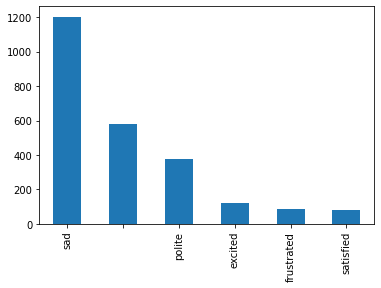

In [80]:
def analyze_post_commit_relationship_by_issue_length(df_analyze_posts, issue_length_divider):
    df_analyze_posts = remove_low_frequency_tones(df_analyze_posts)
    
    for i in range(len(issue_length_divider)-1):
        lower = issue_length_divider[i]
        upper = issue_length_divider[i+1]
        data = df_analyze_posts.loc[(df_analyze_posts['total_commit_size'] >= lower) &\
                                    (df_analyze_posts['total_commit_size'] < upper)]
        
        if data.count()[0] > 0:
            printmd('\n### For issues having commit size: [' + str(lower) + ', ' + str(upper) + ')')
            analyze_post_comment_relationship(data)  
            print('======================')
            analyze_emotion_commit_relationship(data)
            print('======================')
            
printmd('# Analysis by commit size:')
print('\n')
print('##############################################################')
print('##############################################################')
printmd('# PyTorch Results')
#PyTorch_posts_wcomments 

analyze_post_commit_relationship_by_issue_length(PyTorch_posts_wcommits, PyTorch_commit_size_divider)

print('\n')
print('##############################################################')
print('##############################################################')
printmd('# TensorFlow Results')
analyze_post_commit_relationship_by_issue_length(Tensorflow_posts_wcommits, Tensorflow_commit_size_divider)

print('\n')
print('##############################################################')
print('##############################################################')
printmd('# SkLearn Results')
analyze_post_commit_relationship_by_issue_length(SkLearn_posts_wcommits, SkLearn_commit_size_divider)

print('\n')
print('##############################################################')
print('##############################################################')
printmd('# All-together Results')
analyze_post_commit_relationship_by_issue_length(All_posts_wcommits, All_issue_length_divider)